# `Process Data`

In [ ]:
%matplotlib inline
%config IPython.matplotlib.backend = "retina"

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams

import transit
import emcee
import corner

import astroML 
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=14, usetex=True)

import astropy
from astropy import constants as const
from astropy import units as u
from astropy.modeling import models, fitting
from astropy.io import fits
from astropy.table import Table

from scipy import stats
import scipy.optimize as op
import scipy.signal as sig
from scipy.signal import argrelextrema, medfilt
from random import uniform, randrange

import kplr
from kplr.ld import get_quad_coeffs

import time
from collections import Counter, defaultdict, OrderedDict

import glob, os

In [ ]:
rcParams['figure.figsize'] = 16, 7
rcParams["figure.dpi"] = 150
rcParams["savefig.dpi"] = 150

In [ ]:
pgf_with_latex = {
    "pgf.texsystem": "xelatex",         # use Xelatex which is TTF font aware
    "text.usetex": True,                # use LaTeX to write all text
    "axes.labelsize": 10,               # LaTeX default is 10pt font.
    "legend.fontsize": 8,               # Make the legend/label fonts a little smaller
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "text.latex.unicode": True,
    "pgf.preamble": [
        r'\usepackage{fontspec}',
        r'\setmainfont{Ubuntu}',
        r'\setmonofont{Ubuntu Mono}',
        r'\usepackage{unicode-math}'
        r'\setmathfont{Ubuntu}'
        r'\usepackage{amsmath}' #for \text command
    ]
}

rcParams.update(pgf_with_latex)

# Introduction

## Load the data

In [ ]:
path_file = '/Users/mbadenas/Documents/Master UAB/Tesis UAB/TFM2018/clean_bat_files/LC_p13point5up/'
path_mergedLC = '/Users/mbadenas/Documents/Master UAB/Tesis UAB/TFM2018/merge_light_curves/LC_p13point5up_merged/'

properties_sample = pd.read_csv(path_file+'all_targets_P13point5up.csv', sep=',', comment='#')
targets = pd.read_csv(path_file + 'kepler_id.txt',delimiter=',', dtype=int, header=None, names=['kepid'])

In [ ]:
df = pd.merge(targets, properties_sample, on=['kepid'], how='inner') 
sc_data = df.drop_duplicates('kepid') #remove duplicates (some systems have both sc and lc LC)

print("Check files:")

if (len(targets) != len(properties_sample)):
    print("*Lengths don't match:", len(targets), len(properties_sample))
    print("\tSome systems have both sc and lc data! Remove duplicates.")

if (len(sc_data) == len(targets)):
    print("*Lengths match:", len(sc_data), len(targets))
    print('\tDuplicates have been removed.\n A total of {} systems have *short-cadence* LC with SN > 7.1 for their first transit and only 1 planet'.format(len(sc_data)))
    
sc_data.shape

## Define the Systems

In [ ]:
class System:    
    def __init__(self, kepid, rs, rs_err, smass, smass_err, teff, logg, feh, srho,
                time_BKJD, flux, flux_err, 
                t0, P, depth, b, duration, u1, u2, diffld, num_planets, incl, eccen, dor, sma,
                 transit_times,ind_missed_transits,
                rp, rp_err, teq, mp, 
                 trans_id, ftrans, ftrans_err, ttrans,dt_trans,
                res_transfit, P_distribution, MCMC_transits):
        
        """****** Kepler Reported Stellar Parameters ******"""
        self.kepid = kepid
        self.rs = rs # [Solar radii]. 
        self.rs_err = rs_err
        self.smass = smass # [Solar mass]
        self.smass_err = smass_err
        
        self.teff = teff;     
        self.logg = logg; # Stellar Surface Gravity [log10(cm/s**2)]  
        self.feh = feh;   
        self.srho = srho; #g/cm3
        
        """****** LC parameters ******"""
        self.time_BKJD = time_BKJD
        self.flux = flux
        self.flux_err = flux_err
        
        """****** Transit Parameters ******"""
        self.t0 = t0
        self.P = P;            
        self.depth = depth;  
        self.b = b; 
        self.duration = duration; 
        self.u1 = u1; 
        self.u2 = u2
        self.diffld = 0.0
        self.num_planets = num_planets
        self.incl = incl #[º]
        self.eccen = 0.0
        self.dor = dor #Planet-Star Distance over Star Radius
        self.sma = sma #Orbital semi-major axis [AU]
        
        self.transit_times = transit_times
        self.ind_missed_transits = ind_missed_transits
        #self.depth = rprs ** 2 
            # Transit depth in absolute terms. To 1st order (assuming stellar disk has uniform brightness and 
            # neglecting any flux coming from planet), the ratio X of the observed change in flux, Delta(F), 
            # to that of the stellar flux F is: X = (Rp/Rs)^2 = depth.
                   
        """****** Planetary Parameters ******"""
        self.rp = rp # [Earth radii]. This is "prad"  in the original file
        self.rp_err = rp_err
        self.teq = teq
        self.mp = 2.69*(rp)**(0.93) #Weiss & Marcy rel'n. It requires Rp in Earth radii
        
        """****** Internal Variables ******"""
        self.trans_id = np.empty(0)
        self.ftrans = np.empty(0)
        self.ftrans_err = np.empty(0)
        self.ttrans = np.empty(0)
        self.dt_trans = np.empty(0)
        self.res_transfit = np.empty(0)
        self.P_distribution = np.empty(0)
        self.MCMC_transits = np.empty(0)

## Characterize the Systems

Some initialization functions: `quadraticLD`calculates the quadratic LD coefficients of a star based on the model from Claret & Bloemen (2011). As for `fetchLC`, it simply loads the systems' light curves.

In [ ]:
bjd_ref = 2454833

def quadraticLD(T, G, FEH): 
    """Confirm the quadratic LD coefficients with a model from Claret & Bloemen (2011).
    Use the Claret coefficients instead."""
    mu1, mu2 = get_quad_coeffs(T, G, FEH)
    return (mu1, mu2)

def fetchLC(name):
    id_kep = "%.0f" % name
    lc = path_mergedLC+('KID'+id_kep+'.txt')
    df = pd.read_csv(lc, sep="\t", skiprows=1, header=None, names=["Time BKJD", "Flux", "Flux_Err"])
    y = df['Flux']
    yerr = df['Flux_Err']
    x = df['Time BKJD']
    #print(np.median(y),np.mean(y),np.std(y))
    return (y, yerr, x)

Create the planet+star system. In this research, we will only evaluate systems with only 1 planet. 

In [ ]:
targets = []

for row in sc_data.itertuples(index = True, name='Pandas'):
    kepid = getattr(row, "kepid")
    fluxLC, fluxLC_err, timeLC_BKJD = fetchLC(kepid)

    ## Store the stellar parameters
    rs = getattr(row, "koi_srad") #solar radii
    smass = getattr(row, "koi_smass")
    #Assuming that we have a 5% error on radius and mass (this is sensible thanks to Gaia)
    rs_err = rs*0.05
    smass_err = smass*0.05
    
    #rs_errPos = getattr(row, "koi_srad_err1"); rs_errNeg = getattr(row, "koi_srad_err2")
    #rs_err = np.abs((rs_errPos+rs_errNeg)/2.)
    
    #smass_errPos = getattr(row, "koi_smass_err1"); smass_errNeg = getattr(row, "koi_smass_err2")
    #smass_err = np.abs((smass_errPos+smass_errNeg)/2.)
    
    teff = getattr(row, "koi_steff")
    logg = getattr(row, "koi_slogg") # Stellar Surface Gravity [log10(cm/s**2)]  
    feh = getattr(row, "koi_smet")
    srho = getattr(row, "koi_srho") #g/cm3
    
    #### Store LC Parameters
    t0 = getattr(row, "koi_time0bk")
    P = getattr(row, "koi_period") # Orbital Period [days]
    depth = getattr(row, "koi_depth")/1e6
    b = getattr(row, "koi_impact")
    
    u1, u2 = quadraticLD(teff,logg,feh)

    num_planets = getattr(row, "koi_count")
    incl =  getattr(row, "koi_incl") #in degrees
    dor = getattr(row, "koi_dor")  #Planet-Star Distance over Star Radius
    
    time0bk = getattr(row, "koi_time0bk")
    duration = getattr(row, "koi_duration")/24. #in days. "Duration is measured from first contact between the planet and star until last contact."
    
    #Planetary parameters
    sma = getattr(row, "koi_sma")  #Orbit Semi-Major Axis [AU]
    sma_solarRad = sma*215
    teq = getattr(row, "koi_teq") 
    rp = getattr(row, "koi_prad") # in Earth radii
    rp_solarRad = getattr(row, "koi_prad")*0.009168 # in solar radii
    rp_errPos = getattr(row, "koi_prad_err1"); rp_errNeg = getattr(row, "koi_prad_err2")
    rp_err = np.sqrt(rp_errPos**2+rp_errNeg**2)
        
    if (num_planets == 1):
        system = System(kepid, rs, rs_err, smass, smass_err, teff, logg, feh, srho,
                    timeLC_BKJD, fluxLC, fluxLC_err, 
                    t0, P, depth, b, duration, u1, u2, u1-u2, num_planets, incl, 0.0, dor, sma,
                        None, None,
                    rp, rp_err, teq, None, 
                        None, None, None, None, None,
                       None, None, None)

        targets.append(system)
                
    else:
        print('Star {:s} not stored (koi_count > 1)'.format(str(kepid)))

# Global Parameters

MCMC Global Initialization Parameters

In [ ]:
sc = 58.0  #sc = 58 sec
tKep = sc/60/60/24  # sc in days
G = 6.6730e-11

In [ ]:
steps, nwalkers = 1000, 100
steps_rho, nwalkers_rho = 1000, 100

id_mcmc = ["Depth:", "Impact parameter (b):", "sigma:", "Stellar Mass (Ms, [Solar mass]):",
           "Stellar Radius (Rs, [Solar Radii]):", "Out-of-transit flux (f0):", "Orbital Period (P, [days]):", 
           "Time of transit (tc, [days]):", "Planetary Radius (Rp, [Rearth]):", "Rs_a:"]

header_mcmc = "This file shows the 50% percentile and the +- 1 sigma error interval of the parameters.\n"

header_rs = "This file shows the 50% percentile for the Stellar Radius (in solar radii), \
its +- 1 sigma error interval, and the MCMC acceptance fraction (in %). Note that these results \
are for the star's *observed* transits with a minimum SNR of 3.0. \n"

# Transit Detection

In [ ]:
def find_transits(star):
    ti = min(star.time_BKJD)
    tf = max(star.time_BKJD)
    
    n_min = int((ti-star.t0)/star.P)
    n_max = int((tf-star.t0)/star.P+1.)
    n = np.arange(n_min, n_max)
    
    t = star.t0+n*star.P
    t = t[t>ti] 
    t = t[t<tf]
    return(t)

In [12]:
def show_folded_lightcurve(star, plot=False):
    if plot==True:
        plt.figure(figsize=(15,6))
        plt.plot(star.dt_trans,star.ftrans,'.')     
        plt.title('Folded LC for KID'+str(star.kepid))
        plt.xlabel('Time BKJD [d]'); plt.ylabel('Normalized Flux')
        plt.show(block=False)    
        time.sleep(0.2)
        plt.close()

def mark_transits(star, obs_trans, plot=False):
    if plot==True:
        plt.figure(figsize=(15,6))
        plt.plot(star.time_BKJD,star.flux,'.')        
        for j in range(len(star.transit_times)): 
            plt.axvline(star.transit_times[j], color='k', ls='-')
        for k in range(len(obs_trans)): 
            plt.axvline(obs_trans[k], color='r', ls='--')
        plt.title('KID'+str(star.kepid))
        plt.xlabel('Time BKJD [d]'); plt.ylabel('Normalized Flux')
        plt.show(block=False)    
        time.sleep(0.2)
        plt.close()
        
def show_transits(star, bad_trans, plot=False):        
    s1 = set(bad_trans)
    if plot==True:   
        for i in range(len(star.transit_times)):
            if (i not in bad_trans):
                plt.figure(figsize=(15,6))
                plt.title('Folded Light Curve for Transit '+str(i+1))
                plt.plot(star.ttrans[star.trans_id==i]-star.transit_times[i],star.ftrans[star.trans_id==i], 'k.')     
                plt.xlabel('Time [d]'); plt.ylabel('Normalized Flux')
                plt.show(block=False)    
                time.sleep(0.2)
                plt.close()

In [13]:
def get_data_in_transit(star, factor):
    window = factor*star.duration # In days
    total_points = 0
    
    for i in range(0,len(star.transit_times)):
        residual = star.time_BKJD - star.transit_times[i]
        points_in_transit = np.abs(residual) <= window
        total_points += np.sum(points_in_transit)

    time_in_transit = np.empty(total_points)
    flux_in_transit = np.empty(total_points)
    flux_err_in_transit = np.empty(total_points)
    flag_transit = np.empty(total_points)
    mid_trans = np.empty(total_points)

    total_points = 0

    for i in range(0, len(star.transit_times)):
        points_in_transit = np.abs(star.time_BKJD - star.transit_times[i]) <= window
        count_points = np.sum(points_in_transit)
        time_in_transit[(0 + total_points):(count_points + total_points)] = star.time_BKJD[points_in_transit]
        flux_in_transit[(0 + total_points):(count_points + total_points)] = star.flux[points_in_transit] #, star.flux_err[points_in_transit])[0]
        flux_err_in_transit[(0 + total_points):(count_points + total_points)] = star.flux_err[points_in_transit] #normalize(star.flux[points_in_transit], 
        flag_transit[(0 + total_points):(count_points + total_points)] = i
        mid_trans[(0 + total_points):(count_points + total_points)] = star.transit_times[i] 
        total_points += count_points
        
    star.trans_id = flag_transit
    star.ttrans = time_in_transit
    star.ftrans = flux_in_transit
    star.ftrans_err = flux_err_in_transit
    star.dt_trans = time_in_transit - mid_trans #if interested in the folded LC, plot target.dt_trans vs target.ftrans

In [14]:
def oot_fit(star, polyorder):
    transit_range = star.duration/2 #in days
    for i in range(0, len(star.transit_times)):
        dt = star.ttrans[star.trans_id == i] - star.transit_times[i]
        y = star.ftrans[star.trans_id==i]
        outside_trans = np.abs(dt) >= transit_range
        inside_trans = np.abs(dt) < transit_range
        num_oot_points = len(dt[outside_trans])
        
        if  (num_oot_points!= 0):
            z = np.polyfit(dt[outside_trans], y[outside_trans], polyorder)
            p = np.poly1d(z)
            y = y/p(dt)

In [15]:
def find_missed_transits(star):
    gaps = []
    for i in range(len(star.transit_times)):
        if len(star.ttrans[star.trans_id==i])==0: 
            gaps.append(i)
    missing_transits = sorted(gaps, reverse=True)
    return(missing_transits)

In [16]:
def export_folded_lc(system):
    lc = pd.DataFrame(OrderedDict({'Time': system.time_BKJD, 'Flux': system.flux, 'Flux_Err': system.flux_err}))
     
    np.savetxt("/Users/mbadenas/Documents/Master UAB/Tesis UAB/TFM2018/folded_LC/"+str(system.kepid)+".txt", 
               lc.values, fmt='%f', delimiter="\t") 

The code below performs two functions: 
    1. It identifies the light curves that don't have a visible transit. (With the data being used as of June 30, this amounts to 4 systems).
    2. For the remaining light curves, it calculates all the expected transits and then looks at which transits are actually visible (sometimes, there are gaps in the data and transits are lost). 

In [17]:
stars_wo_transits = []
poly_order = 2
amplify = 2
print("Amplification of transit duration by:", amplify)

Amplification of transit duration by: 2


In [18]:
for target in targets:
    print("\n******************************** KID"+str(target.kepid)+" ********************************\n")

    target.transit_times = find_transits(target)
    get_data_in_transit(target, amplify)
    oot_fit(target, poly_order)
    
    if (len(target.transit_times)==0): stars_wo_transits.append(target.kepid)

    target.ind_missed_transits = find_missed_transits(target)
    observed_transits = np.delete(target.transit_times, target.ind_missed_transits)
    mark_transits(target, observed_transits, False)
    show_transits(target, target.ind_missed_transits, False)

    if len(observed_transits!=0): 
        show_folded_lightcurve(target, False)
        
    #export_folded_lc(target)
    print("Transit duration: {0:0.5} [d]".format(target.duration))
    print("Period: {0:s} [d]".format(str(target.P)))
    print("Estimated transits at ({0:s}):".format(str(len(target.transit_times))), target.transit_times)
    print("Observed transits at ({0:s}):".format(str(len(observed_transits))), observed_transits)
    print("Index of missed transits:", target.ind_missed_transits)


******************************** KID5009743 ********************************

Transit duration: 0.2377 [d]
Period: 41.6980186 [d]
Estimated transits at (1): [878.4417962]
Observed transits at (1): [878.4417962]
Index of missed transits: []

******************************** KID8802165 ********************************

Transit duration: 0.20822 [d]
Period: 17.42115972 [d]
Estimated transits at (2): [759.14417676 776.56533648]
Observed transits at (2): [759.14417676 776.56533648]
Index of missed transits: []

******************************** KID6471021 ********************************

Transit duration: 0.3795 [d]
Period: 125.6291479 [d]
Estimated transits at (9): [ 504.6090858  630.2382337  755.8673816  881.4965295 1007.1256774
 1132.7548253 1258.3839732 1384.0131211 1509.642269 ]
Observed transits at (4): [ 630.2382337 1258.3839732 1384.0131211 1509.642269 ]
Index of missed transits: [5, 4, 3, 2, 0]

******************************** KID11133306 ********************************

Transit

Transit duration: 0.16541 [d]
Period: 16.23847733 [d]
Estimated transits at (86): [ 203.49651866  219.73499599  235.97347332  252.21195065  268.45042798
  284.68890531  300.92738264  317.16585997  333.4043373   349.64281463
  365.88129196  382.11976929  398.35824662  414.59672395  430.83520128
  447.07367861  463.31215594  479.55063327  495.7891106   512.02758793
  528.26606526  544.50454259  560.74301992  576.98149725  593.21997458
  609.45845191  625.69692924  641.93540657  658.1738839   674.41236123
  690.65083856  706.88931589  723.12779322  739.36627055  755.60474788
  771.84322521  788.08170254  804.32017987  820.5586572   836.79713453
  853.03561186  869.27408919  885.51256652  901.75104385  917.98952118
  934.22799851  950.46647584  966.70495317  982.9434305   999.18190783
 1015.42038516 1031.65886249 1047.89733982 1064.13581715 1080.37429448
 1096.61277181 1112.85124914 1129.08972647 1145.3282038  1161.56668113
 1177.80515846 1194.04363579 1210.28211312 1226.52059045 1242.7590

Transit duration: 0.33696 [d]
Period: 19.55662003 [d]
Estimated transits at (54): [ 541.06270054  560.61932057  580.1759406   599.73256063  619.28918066
  638.84580069  658.40242072  677.95904075  697.51566078  717.07228081
  736.62890084  756.18552087  775.7421409   795.29876093  814.85538096
  834.41200099  853.96862102  873.52524105  893.08186108  912.63848111
  932.19510114  951.75172117  971.3083412   990.86496123 1010.42158126
 1029.97820129 1049.53482132 1069.09144135 1088.64806138 1108.20468141
 1127.76130144 1147.31792147 1166.8745415  1186.43116153 1205.98778156
 1225.54440159 1245.10102162 1264.65764165 1284.21426168 1303.77088171
 1323.32750174 1342.88412177 1362.4407418  1381.99736183 1401.55398186
 1421.11060189 1440.66722192 1460.22384195 1479.78046198 1499.33708201
 1518.89370204 1538.45032207 1558.0069421  1577.56356213]
Observed transits at (52): [ 541.06270054  560.61932057  580.1759406   599.73256063  619.28918066
  638.84580069  658.40242072  677.95904075  697.5156

Transit duration: 0.1955 [d]
Period: 14.00640392 [d]
Estimated transits at (31): [268.26648528 282.2728892  296.27929312 310.28569704 324.29210096
 338.29850488 352.3049088  366.31131272 380.31771664 394.32412056
 408.33052448 422.3369284  436.34333232 450.34973624 464.35614016
 478.36254408 492.368948   506.37535192 520.38175584 534.38815976
 548.39456368 562.4009676  576.40737152 590.41377544 604.42017936
 618.42658328 632.4329872  646.43939112 660.44579504 674.45219896
 688.45860288]
Observed transits at (24): [268.26648528 282.2728892  296.27929312 310.28569704 324.29210096
 338.29850488 352.3049088  366.31131272 380.31771664 394.32412056
 408.33052448 422.3369284  436.34333232 506.37535192 520.38175584
 534.38815976 548.39456368 562.4009676  576.40737152 590.41377544
 604.42017936 618.42658328 674.45219896 688.45860288]
Index of missed transits: [28, 27, 26, 16, 15, 14, 13]

******************************** KID8866102 ********************************

Transit duration: 0.18797 [d]

In [19]:
print("There are {:s} stars without transits. These targets won't be studied".format(str(len(stars_wo_transits))))

print(stars_wo_transits)

There are 4 stars without transits. These targets won't be studied
[10795103, 7761545, 11622600, 11027624]


# Fit of the Stellar Density

## Transit Routine (DFM)

A Python library for generating light curves of transiting planets. See https://github.com/dfm/transit/blob/master/transit/transit.py for original code

In [ ]:
def lnprior_rho(theta, maxb):
    pdepth, pb, sigma, pradius, f0, ptc = theta 
    if ((0 <= pb < maxb) and (0 <= sigma) and (pradius > 0) and (pdepth > 0) and (ptc**2<0.01)):
        return 0.0
    return -np.inf  

def lnlike_rho(theta, timeLC, fluxLC, errorLC, allfixed):
    ecc,  mass, masserr, tKep, u1, u2, maxb, P = allfixed
    pdepth, pb, sigma, pradius, f0, ptc = theta 
    
    s = transit.System(transit.Central(mu1=u1, mu2=u2, mass = mass, radius = pradius))
    body = transit.Body(radius=np.sqrt(pdepth)*pradius, period=P, t0=ptc, b=np.abs(pb), e=ecc)
    s.add_body(body)
    inv_sigma2 = 1.0/(errorLC**2 + sigma**2)
    try: 
        ftheo = s.light_curve(timeLC, texp=tKep, tol=1e-08, maxdepth=4)
    except ValueError:
        return -np.inf
    ftheo = ftheo-1+f0
    chi2 = -0.5*(np.sum((fluxLC-ftheo)**2*inv_sigma2 - np.log(inv_sigma2)))
    return chi2
                 
def lnprob_rho(theta, timeLC, fluxLC, errorLC, allfixed):
    ecc, mass, masserr, tKep, u1, u2, maxb, P = allfixed
    lp_rho = lnprior_rho(theta, maxb)
    if not np.isfinite(lp_rho):
        return -np.inf
    return lp_rho + lnlike_rho(theta, timeLC, fluxLC, errorLC, allfixed)

## MCMC

In [ ]:
def fit_rho(star, t, f, ferr, num_trans, showLC, showMCMC):
    max_b = 1+star.rp/star.rs
    
    allfixed_rho = np.array([star.eccen, star.smass, 0.0, tKep, star.u1, star.u2, max_b, star.P])
    first_guess =  np.array([1.2*star.depth, star.b, 0.0, star.rs, 1.0, 0.0])
    
    nll_rho = lambda *args: -lnprob_rho(*args)
       
    result = op.minimize(nll_rho, first_guess, args=(t, f, ferr, allfixed_rho), 
                       options={'disp': True},
                       method='Nelder-Mead') 
    
    depth_ml, b_ml, sigma_ml, radius_ml, f0_ml, tc_ml = result["x"]
        
    # Compute the theoretical light curve integrated over a Kepler short-cadence exposure time.
    s = transit.System(transit.Central(mu1=star.u1, mu2=star.u2, mass=star.smass, radius=radius_ml))
    body = transit.Body(radius=np.sqrt(depth_ml)*radius_ml,period=star.P, t0=tc_ml,b=np.abs(b_ml),e=star.eccen)
    s.add_body(body)
    t_fit = np.arange(-1, 1, tKep*0.01)
    f_fit = s.light_curve(t_fit, texp=tKep, tol=1e-08, maxdepth=4)
    f_fit = f_fit - 1.0 + f0_ml
    
    if showLC == True:
        fig = plt.figure(figsize=(16,7))
        plt.title(str(star.kepid)+'. Stellar Density Fit for Transit '+str(num_trans+1), fontsize = 15)
        plt.plot(t, f, '.')
        plt.plot(t_fit, f_fit, color='r', lw = 3)
        plt.xlabel('Time from midtransit [days]')
        plt.ylabel('Normalized flux')
        plt.xlim([min(t),max(t)]) 
        plt.show(block=False)    
        time.sleep(0.2)
        plt.close()
        
    ndim_rho = len(result["x"])
    
    p0 = [result["x"]*(1+1e-8*np.random.randn(ndim_rho)) for i in range(nwalkers_rho)]
    sampler = emcee.EnsembleSampler(nwalkers_rho, ndim_rho, lnprob_rho, args=(t, f, ferr, allfixed_rho))
    
    print("Running burn-in")
    pos, prob, state = sampler.run_mcmc(p0, 200, progress=True);
    sampler.reset() # Reset the chain to remove the burn-in samples.
    print("\n------ Run MCMC -------")
    sampler.run_mcmc(p0, steps_rho, rstate0 = state, progress=True);
    samples = sampler.chain[:, int(steps_rho/10):, :].reshape((-1, ndim_rho)) #burnin currently set to 10%
    
    samples[:, 2] = np.exp(samples[:, 2])
    
    #Get the 50% percentile and the +- 1 sigma error of the parameters and 2 derived quantities 
    depth_mcmc, b_mcmc, sigma_mcmc, \
    rs_mcmc, f0_mcmc, tc_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), 
                               zip(*np.percentile(samples, [15.86, 50, 84.14], axis=0)))
    
    if showMCMC == True:
        print("\n------ Post-MCMC Results ------")
        print("\nDepth:\n\tTrue = {:0.3f}".format(star.depth))
        print("\tMCMC Fit = {0:0.3f} (+{1:0.3f},-{2:0.3f})".format(depth_mcmc[0],depth_mcmc[1],depth_mcmc[2]))
        print("\nImpact parameter:\n\tTrue = {:0.3f}".format(star.b))
        print("\tMCMC Fit = {0:0.3f} (+{1:0.3f},-{2:0.3f})".format(b_mcmc[0],b_mcmc[1],b_mcmc[2]))
        print("\nStellar radius [Rsun]:\n\tREPORTED = {:0.3f}".format(star.rs))
        print("\tMCMC Fit = {0:0.3f} (+{1:0.3f},-{2:0.3f})".format(rs_mcmc[0], rs_mcmc[1],rs_mcmc[2]))
   
    #---------- Plot the LC with the MCMC fit ----------
    s = transit.System(transit.Central(mu1=star.u1, mu2=star.u2, mass=star.smass, radius=rs_mcmc[0]))
    body = transit.Body(radius=np.sqrt(depth_mcmc[0])*rs_mcmc[0], period=star.P, t0=tc_mcmc[0], 
                        b=np.abs(b_mcmc[0]), e=star.eccen)
    s.add_body(body)
    t_fit = np.arange(-1, 1, tKep*0.01)
    f_fit = s.light_curve(t_fit, texp=tKep, tol=1e-08, maxdepth=4)
    f_fit = f_fit - 1.0 + f0_mcmc[0]
    fig_lc = plt.figure(figsize=(15,4))
    plt.title('MCMC Fit for KID'+str(star.kepid))
    plt.plot(t, f, '.')
    plt.plot(t_fit, f_fit, 'r', lw = 3)
    plt.xlabel('Time [d]'); plt.ylabel('Normalized Flux')
    plt.xlim([min(t),max(t)])
    
    filepath_rho = '/Users/mbadenas/Documents/Master UAB/Tesis UAB/TFM2018/results/new_rs/'
    store_lcfit = "fit"+str(star.kepid)+"_st"+str(steps_rho)+"_trans"+str(num_trans+1)+".png"
    fig_lc.savefig(filepath_rho+store_lcfit)
    plt.close(fig_lc)
        
    true_params = [star.depth, star.b, None, star.rs, 1.0, 0.0]
    res_labels = [r'Depth', r'$b$', r'$\sigma$', r'$R_{s} [R_{\odot}]$', r'$f_{0}$', r'$t_{c}$']
    
    fig_corner = corner.corner(samples, weights = None, labels = res_labels, quantiles=[0.16, 0.5, 0.84],
                               truths = true_params, show_titles = True, title_args={"fontsize": 12}, 
                               plot_contours=True, truth_color='r', plot_datapoints=True) 
        
    plt.suptitle("KID"+str(star.kepid)+". Corner Plot for Transit "+str(num_trans+1), fontsize = 20)
    store_corner = "corner"+str(star.kepid)+"_st"+str(steps_rho)+"_trans"+str(num_trans+1)+".png"
    fig_corner.savefig(filepath_rho+store_corner)
    plt.close(fig_corner)
   
    #Acceptance fraction: s a rule of thumb, the acceptance fraction (af) should be between 0.2 and 0.5. 
    #If af < 0.2 decrease the a parameter. If af > 0.5 increase the a parameter. 
    af = sampler.acceptance_fraction  
    af_percentage = 100*np.mean(sampler.acceptance_fraction)
    
    print("Mean acceptance fraction:", np.mean(af))
    print("Acceptance fraction: {0:.2f} %".format(af_percentage))
    
    #Steps plot
    fig_steps, axes = plt.subplots(ndim_rho, 1, sharex=True, figsize=(8, 9))
    axes[0].plot(sampler.chain[:, :, 0].T, ls='dotted', color = "xkcd:sky blue") #depth = 0
    axes[0].set_ylabel(r'Depth'); axes[0].axhline(true_params[0], color='red')
    axes[1].plot(sampler.chain[:, :, 1].T,'.', ls='dotted', color="xkcd:sky blue")
    axes[1].set_ylabel(r'$b$'); axes[1].axhline(true_params[1], color='red')
    axes[2].plot((sampler.chain[:, :, 2]).T, ls='dotted', color="xkcd:sky blue")
    axes[2].set_ylabel(r'$\sigma$');
    axes[3].plot((sampler.chain[:, :, 3]).T, ls='dotted', color="xkcd:sky blue")
    axes[3].set_ylabel(r'$R_{s} [R_{\odot}]$'); axes[3].axhline(true_params[3], color='red')
    axes[4].plot((sampler.chain[:, :, 4]).T, ls='dotted', color="xkcd:sky blue")
    axes[4].set_ylabel(r'$f_{0}$'); axes[4].axhline(true_params[4], color='red')
    axes[5].plot((sampler.chain[:, :, 5]).T, ls='dotted',color="xkcd:sky blue")
    axes[5].set_ylabel(r"$t_{c}$"); axes[5].axhline(true_params[5], color='red')
    axes[5].set_xlabel("Step number")
    fig_steps.tight_layout(h_pad=0.0)
    store_steps= "steps"+str(star.kepid)+"_st"+str(steps_rho)+"_trans"+str(num_trans+1)+".png"
    fig_steps.savefig(filepath_rho+store_steps)
    plt.close(fig_steps)
    
    results_mcmc = [depth_mcmc, b_mcmc, sigma_mcmc, rs_mcmc, f0_mcmc, tc_mcmc]
    rs_results = np.array([rs_mcmc[0],rs_mcmc[1],rs_mcmc[2]])
    
    return radius_ml, rs_results, af_percentage

Store the KID of stars with missing or bad (SNR < 3) transits 

In [29]:
no_transits = set(stars_wo_transits)
ugly_stars = defaultdict(list)

for i in range(len(stars_wo_transits)):
    idx_target = stars_wo_transits[i]
    ugly_stars[idx_target] = []
    
print(ugly_stars)

defaultdict(<class 'list'>, {10795103: [], 7761545: [], 11622600: [], 11027624: []})


Fit the stellar radius to obtain a better estimate of the stellar density

In [ ]:
for target in targets:
    print("\n******************************** KID"+str(target.kepid)+" ********************************")
    plt.close("all")
    key = target.kepid
    missed_trans = set(target.ind_missed_transits)

    rs_trans_fit = []
    rs_trans_afrac = []
        
    for i in range(len(target.transit_times)): 
        if i in missed_trans:
            rs_trans_fit.append(np.array([0,0,0]))
            rs_trans_afrac.append(0)
            ugly_stars[key].append(i)
        else: 
            print("\n\t*TRANSIT "+str(i+1))
            dt_i = target.ttrans[target.trans_id==i]-target.transit_times[i]
            f_trans_i = target.ftrans[target.trans_id==i]

            oot = np.abs(dt_i)>=(target.duration/2)
            iit = np.abs(dt_i)<(target.duration/2)
            d = 1-np.mean(f_trans_i[iit])
            error_trans_oot = np.std(f_trans_i[oot])
            snr = d/error_trans_oot
            print("\t\tSignal = {0:0.5f}. Noise (rms) = {1:0.5f}. SNR = {2:0.5f}".format(d, error_trans_oot, snr))
            print("\t\tOut-of-transit error of the transit LC = {0:0.5f}".format(error_trans_oot))

            if snr < 3 or np.isnan(snr): 
                ugly_stars[key].append(i)
            else:
                rsFit, rsMCMC, rs_afraction = fit_rho(target, dt_i,  f_trans_i, 0.1*error_trans_oot, i, False, False)
                
                #rho_solar = target.srho*(5.029*(10**-34))/((1.437*(10**-11))**3)
                
                print("\tStellar Radius [Solar Radii]:\tMCMC = {0:0.5f}.\t1st Fit = {1:0.5f}.\Kepler = {2:0.5f}".format(rsMCMC[0], rsFit, target.rs))
                print("\tError Stellar Radius [Solar Radii]:\tMCMC (up) = {0:0.5f}, (down) = {1:0.5f}.\tOld = {2:0.5f}".format(rsMCMC[1], rsMCMC[2],  target.rs_err))
                #print("\tStellar Density:\tMCMC = {0:0.5f} [Solar units]. Kepler = {1:0.5f} [Solar units]".format(target.smass/(rsMCMC[0]**3), rho_solar))
                
                rs_trans_fit.append(rsMCMC)
                rs_trans_afrac.append(rs_afraction)
    
    if len(rs_trans_fit) != 0:
        locs_rsNew = '/Users/mbadenas/Documents/Master UAB/Tesis UAB/TFM2018/results/new_rs/'
        fname_rsNew = str(target.kepid)+"_st"+str(steps)+"_RsMCMC.txt"
        np.savetxt(locs_rsNew+fname_rsNew, np.column_stack((rs_trans_fit, rs_trans_afrac)), 
                       fmt = "%0.3f", header = header_rs)

Update stellar radius.

# Fit of Individual Transits

## Transit Routine (DFM)

A Python library for generating light curves of transiting planets. See https://github.com/dfm/transit/blob/master/transit/transit.py for original code

In [22]:
def ln_probtrans(P, rstar, mstar):
    alog = (1/3)*np.log(mstar)+(2/3)*np.log(P)
    prob = np.log(rstar)-alog
    return(prob)

In [23]:
def lnlike(theta, timeLC, fluxLC, errorLC, allfixed):
    """
    Calculates the log of the likelihood of the transit model being the right model given the following parameters:
    theta[0] = pdepth = (Rp/Rs)^2 #b=0 centre of stellar disk & b=1 at the cusp of the disc
    theta[1] = pb = the mean impact parameter, measured in stellar radii (not Solar radii). See documentation.
    theta[2] = sigma = an additional white noise term
    theta[3] = pmass = the mass of the star (controlled via gaussian prior)
    theta[4] = pradius = the radius of the star (controlled via gaussian prior)
    theta[5] = f0 = the out of eclipse flux
    theta[6] = pperiod = Orbital period 
    theta[7] = ptc = Transit time (time of conjunction) 
    
    Note: pmass and prad (stellar mass and radius) controlled via gaussian prior. 
    By letting M* and R* be free parameters in the model, we allow the stellar density to fluctuate. 
    """
    ecc, mass, masserr, radius, radiuserr, tKep, u1, u2, maxb = allfixed
    pdepth, pb, sigma, pmass, pradius, f0, pperiod, ptc = theta 
    
    s = transit.System(transit.Central(mu1=u1, mu2=u2, mass = pmass, radius = pradius))
    body = transit.Body(radius=np.sqrt(pdepth)*pradius, period=pperiod, t0=ptc, b=np.abs(pb), e=ecc)
    s.add_body(body)
    inv_sigma2 = 1.0/(errorLC**2 + sigma**2)
    
    try: 
        ftheo = s.light_curve(timeLC, texp=tKep, tol=1e-08, maxdepth=4)
    except ValueError:
        return -np.inf
    
    ftheo = ftheo-1+f0
    
    return -0.5*(np.sum((fluxLC-ftheo)**2*inv_sigma2 - np.log(inv_sigma2)) + ((pmass-mass)/masserr)**2
            + ((pradius-radius)/radiuserr)**2)

In [24]:
def lnprior(theta, maxb):
    ##https://github.com/stan-dev/stan/wiki/Prior-Choice-Recommendations
    pdepth, pb, sigma, pmass, pradius, f0, pperiod, ptc = theta
    if ((0 <= pb < maxb) and (0 <= sigma) and (pradius > 0) 
        and (pdepth > 0) and (pmass > 0.0) and (13.5 < pperiod)  and (ptc**2<0.01)):
        return ln_probtrans(pperiod, pradius, pmass)
    return -np.inf  

def lnprior_MCMC(theta, maxb): ##https://github.com/stan-dev/stan/wiki/Prior-Choice-Recommendations
    pdepth, pb, sigma, pmass, pradius, f0, pperiod, ptc = theta
    if ((0 <= pb < maxb) and (0 <= sigma) and (pradius > 0) 
        and (pdepth > 0) and (pmass > 0.0) and (13.5 < pperiod)  and (ptc**2<0.01)):
        return ln_probtrans(pperiod, pradius, pmass) 
    return -np.inf    

In [25]:
def lnprob(theta, timeLC, fluxLC, errorLC, allfixed):
    ecc, mass, masserr, radius, radiuserr, tKep, u1, u2, maxb = allfixed
    lp = lnprior(theta, maxb)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, timeLC, fluxLC, errorLC, allfixed)

def lnprob_MCMC(theta, timeLC, fluxLC, errorLC, allfixed_MCMC):
    ecc, mass, masserr, radius, radiuserr, tKep, u1, u2, maxb = allfixed_MCMC
    lp_MCMC = lnprior_MCMC(theta, maxb)
    if not np.isfinite(lp_MCMC):
        return -np.inf
    return lp_MCMC + lnlike(theta, timeLC, fluxLC, errorLC, allfixed_MCMC)

In [26]:
def run_transit_routine(star, t, f, ferr, transit_num, showLC):
    period_guess = 250 #randrange(14,500) #uniform(13.5, 500) print("Period guess [d]:", period_guess)
    depth_guess = 1-min(f)
    rp_guess = np.sqrt(depth_guess)*star.rs
    max_b = 1+rp_guess/star.rs  
    print("Max. depth (guess) = {0:0.5f}".format(max_b))
    print("Depth guess = {0:0.5f}. True depth = {1:0.5f}".format(depth_guess, star.depth))
    
    allfixed = np.array([star.eccen, star.smass, star.smass_err, star.rs, star.rs_err, tKep, star.u1, star.u2, max_b])
    
    #initial_simplex = np.tile(first_guess, (len(first_guess)+1,1))
    
    nll = lambda *args: -lnprob(*args)
    
    res0 = op.minimize(nll, [1.2*depth_guess, 0.5, 0.0, star.smass, star.rs, 1.0, period_guess, 0.0], 
                       args=(t, f, 0.0, allfixed), 
                       options={'maxiter':1e5, 'disp': True},
                       method='Nelder-Mead') #options={'maxiter': 1e3, 'disp': True}
    
    res1 = op.minimize(nll, res0["x"], 
                       args=(t, f, ferr, allfixed), 
                       options={'maxiter':1e5, 'disp': True},
                       method='Nelder-Mead')
    
    depth_ml, b_ml, sigma_ml, mass_ml, radius_ml, f0_ml, period_ml, tc_ml = res1["x"]
        
    # Compute the theoretical light curve integrated over a Kepler short-cadence exposure time.
    s = transit.System(transit.Central(mu1=star.u1, mu2=star.u2, mass=mass_ml, radius=radius_ml))
    body = transit.Body(radius=np.sqrt(depth_ml)*radius_ml,period=period_ml, t0=tc_ml,b=np.abs(b_ml),e=star.eccen)
    s.add_body(body)
    t_fit = np.arange(-1, 1, tKep*0.01)
    f_fit = s.light_curve(t_fit, texp=tKep, tol=1e-08, maxdepth=4)
    f_fit = f_fit - 1.0 + f0_ml
    
    if showLC == True:
        fig = plt.figure(figsize=(16,5))
        plt.title("KID"+str(star.kepid)+". Preliminary Fit for Transit "+str(transit_num+1), fontsize = 15)
        plt.plot(t, f, '.', label = 'Kepler data')
        plt.plot(t_fit, f_fit, color='r', lw = 3, label = 'Fit')
        plt.xlabel('Time from midtransit [days]')
        plt.ylabel('Normalized flux')
        plt.xlim([min(t),max(t)]) 
        plt.show(block=False)    
        time.sleep(0.5)
        plt.close()

    #star.duration = body.duration #from eq'n 14 in Winn (2010)
    print("------ Pre-MCMC Results ------")
    print("\tTransit duration [d]:\t Fit={0:0.3f}\tTrue={1:0.3f}".format(body.duration, star.duration))
    print("\tPeriod [days]:\t Fit={0:0.8f}\tTrue={1:0.8f}".format(period_ml,star.P))
    print("\tImpact Parameter:\t Fit={0:0.6f}\tTrue={1:0.6f}".format(b_ml,star.b))
    print("\tDepth:\t Fit={0:0.6f}\tTrue={1:0.6f}".format(depth_ml,star.depth))
    print("\tStellar mass:\t Fit={0:0.3f}\tTrue={1:0.3f}".format(mass_ml,star.smass))
    print("\tStellar radius:\t Fit={0:0.3f}\tTrue={1:0.3f}".format(radius_ml,star.rs))
    print("\tSigma (white noise):\t Fit={0:0.3f}".format(sigma_ml))
    print("\tOut-of-transit flux:\t Fit={0:0.3f}".format(f0_ml))
    
    return(res1["x"])

## MCMC 

In [27]:
def run_mcmc(star, t, f, ferr, num_trans, fit_results, show_mcmc_res):
    
    depth_ml, b_ml, sigma_ml, mass_ml, radius_ml, f0_ml, period_ml, tc_ml = fit_results
    
    #rp_guess = np.sqrt(depth_ml)*star.rs
    rp_guess = np.sqrt(depth_ml)*radius_ml
    max_depth = 1+rp_guess/radius_ml #(three_jup_rad/rs)**2
    
    print("\n------------------ Prepare MCMC ------------------")
    print("Guess impact parameter: {0:0.5f}".format(b_ml))
    print("Guess of Rp [in Rsun]: {0:0.5f}".format(rp_guess))
    print("1+rp_guess/rs: {0:0.5f}".format(max_depth))

    allfixed_MCMC = [star.eccen, star.smass, star.smass_err, star.rs, star.rs_err, tKep, star.u1, star.u2, max_depth]
    ndim = len(fit_results)
    
    p0 = [fit_results*(1+1e-8*np.random.randn(ndim)) for i in range(nwalkers)]
    
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob_MCMC, args=(t, f, ferr, allfixed_MCMC))
    
    print("Running burn-in")
    pos, prob, state = sampler.run_mcmc(p0, 250, progress=True);
    sampler.reset() # Reset the chain to remove the burn-in samples.
    print("\n------ Run MCMC -------")
    sampler.run_mcmc(p0, steps, rstate0 = state, progress=True);
    samples = sampler.chain[:, 400:, :].reshape((-1, ndim)) #burnin currently set to 10%
    
    #Clipping extreme values (top.bottom 0.1 percentiles)
    #toclip=np.array([(np.percentile(samples[:,t],99.9)>samples[:,t]) // (samples[:,t]>np.percentile(samples[:,t],0.1)) for t in range(ndim)]).all(axis=0)
    #samples=samples[toclip]
    
    """
    ************ BE CAREFUL WITH THE INDEXES OF THE FOLLOWING FOUR LINES!!!!! ************
    This is bc the indexes depend on the list of parameters being fitted.
    """
    period_distribution = samples[:,6]
    samples[:, 2] = np.exp(samples[:, 2])
    planetradsamp = 109.045*np.sqrt(samples[:,0])*samples[:, 4] #in earth rad (rp = sqrt(depth)*rs)
    P1 = period_ml*24.0*3600.0 #in sec
    r_asamp = ((3.0*np.pi/(G*P1**2))*((samples[:,4]**3/samples[:, 3])/1408.0))**0.3333

    #Get the 50% percentile and the +- 1 sigma error of the parameters and 2 derived quantities 
    depth_mcmc, b_mcmc, sigma_mcmc, smass_mcmc, rs_mcmc, \
    f0_mcmc, period_mcmc, tc_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), 
                               zip(*np.percentile(samples, [15.86, 50, 84.14], axis=0)))
    
    v = np.percentile(planetradsamp, [15.86, 50, 84.14], axis=0)
    planetrad_mcmc =(v[1], v[2]-v[1], v[1]-v[0])
    v = np.percentile(r_asamp, [15.86, 50, 84.14], axis=0)
    r_a_mcmc =(v[1], v[2]-v[1], v[1]-v[0])
    
    results_mcmc = [depth_mcmc, b_mcmc, sigma_mcmc, smass_mcmc, rs_mcmc, f0_mcmc, 
                    period_mcmc, tc_mcmc, planetrad_mcmc, r_a_mcmc]
    
    if show_mcmc_res == True:
        print("\n------------------ Post-MCMC Results ------------------")
        print("\nDepth:\n\tTrue = {:0.3f}".format(star.depth))
        print("\tMCMC Fit = {0:0.3f} (+{1:0.3f},-{2:0.3f})".format(depth_mcmc[0],depth_mcmc[1],depth_mcmc[2]))
        print("\nImpact parameter:\n\tTrue = {:0.3f}".format(star.b))
        print("\tMCMC Fit = {0:0.3f} (+{1:0.3f},-{2:0.3f})".format(b_mcmc[0],b_mcmc[1],b_mcmc[2]))
        print("\nPlanet radius [REarth]:\n\tTrue = {:0.3f}".format(star.rp))
        print("\tMCMC Fit = {0:0.3f} (+{1:0.3f},-{2:0.3f})".format(planetrad_mcmc[0],planetrad_mcmc[1],planetrad_mcmc[2]))
        print("\nPeriod [d]:\n\tTrue = {:0.3f}".format(star.P))
        print("\tMCMC Fit = {0:0.3f} (+{1:0.3f},-{2:0.3f})".format(period_mcmc[0],period_mcmc[1],period_mcmc[2]))
        print("\nInverse of scaled semi-major axis:\n\tTrue = {:0.4f}".format(1/star.dor))
        print("\tMCMC Fit = {0:0.4f} (+{1:0.4f},-{2:0.4f})".format(r_a_mcmc[0],r_a_mcmc[1],r_a_mcmc[2]))
        print("\nStellar radius [Rsun]:\n\tTrue = {:0.3f}".format(star.rs))
        print("\tMCMC Fit = {0:0.3f} (+{1:0.3f},-{2:0.3f})".format(rs_mcmc[0],rs_mcmc[1],rs_mcmc[2]))
        print("\nStellar Mass [Msun]:\n\tTrue = {:0.3f}".format(star.smass))
        print("\tMCMC Fit = {0:0.3f} (+{1:0.3f},-{2:0.3f})".format(smass_mcmc[0],smass_mcmc[1],smass_mcmc[2]))

    #---------- Plot the LC with the MCMC fit ----------
    s = transit.System(transit.Central(mu1=star.u1, mu2=star.u2, mass=smass_mcmc[0], radius=rs_mcmc[0]))
    body = transit.Body(radius=np.sqrt(depth_mcmc[0])*rs_mcmc[0], period=period_mcmc[0],
                        t0=tc_mcmc[0], b=np.abs(b_mcmc[0]), e=star.eccen)
    s.add_body(body)
    t_fit = np.arange(-1.5, 1.5, tKep*0.01)
    f_fit = s.light_curve(t_fit, texp=tKep, tol=1e-08, maxdepth=4)
    f_fit = f_fit - 1.0 + f0_mcmc[0]
    fig_lc = plt.figure(figsize=(15,4))
    plt.title('MCMC Fit for KID'+str(star.kepid))
    plt.plot(t, f, '.', label = 'kepler')
    plt.plot(t_fit, f_fit, 'r', lw = 3, label = 'fit')
    plt.xlabel('Time [d]'); plt.ylabel('Normalized Flux')
    plt.xlim([min(t),max(t)]); 
    
    file_path_fit = '/Users/mbadenas/Documents/Master UAB/Tesis UAB/TFM2018/results/MCMC_fits/'
    store_mcmc_fit = "fit"+str(star.kepid)+"_st"+str(steps)+"_trans"+str(num_trans+1)+".png"
    fig_lc.savefig(file_path_fit+store_mcmc_fit)
    plt.close(fig_lc)
    #plt.show(block=False)    
    #time.sleep(0.5)   
        
    true_params = [star.depth, star.b, None, star.smass, star.rs, 1.0, star.P, 0.0]
    res_labels = ['Depth', 'b', r'$\sigma$', r'$M_{*} [M_{\odot}]$', r'$R_{*} [R_{\odot}]$', 
              r'$f_{0}$', 'P [d]', r'$t_c$']
    #plt.clf()
    fig_corner = corner.corner(samples, weights = None, labels = res_labels, quantiles=[0.16, 0.5, 0.84],
                               truths = true_params, show_titles = True, title_args={"fontsize": 12}, 
                               plot_contours=True, truth_color='r', plot_datapoints=True) 
        
    plt.suptitle('Corner Plot for KID'+str(star.kepid), fontsize = 20)
    file_path = '/Users/mbadenas/Documents/Master UAB/Tesis UAB/TFM2018/results/corner/'
    store_corner = "corner"+str(star.kepid)+"_st"+str(steps)+"_trans"+str(num_trans+1)+".png"
    fig_corner.savefig(file_path+store_corner)
    plt.close(fig_corner)
   
    #Acceptance fraction: s a rule of thumb, the acceptance fraction (af) should be between 0.2 and 0.5. 
    #If af < 0.2 decrease the a parameter. If af > 0.5 increase the a parameter. 
    af = sampler.acceptance_fraction  
    print("Mean acceptance fraction:", np.mean(af))
    print("Acceptance fraction: {0:.2f} %".format(100*np.mean(sampler.acceptance_fraction)))
    
    #Steps plot
    fig_b, axes = plt.subplots(8, 1, sharex=True, figsize=(8, 9))
    axes[0].plot(sampler.chain[:, :, 0].T, ls='dotted', color = "xkcd:sky blue") #depth = 0
    axes[0].set_ylabel(r'Depth'); axes[0].axhline(true_params[0], color='red')
    axes[1].plot(sampler.chain[:, :, 1].T,'.', ls='dotted', color="xkcd:sky blue")
    axes[1].set_ylabel(r'$b$'); axes[1].axhline(true_params[1], color='red')
    axes[2].plot((sampler.chain[:, :, 2]).T, ls='dotted', color="xkcd:sky blue")
    axes[2].set_ylabel(r'$\sigma$');
    axes[3].plot((sampler.chain[:, :, 3]).T, ls='dotted', color="xkcd:sky blue")
    axes[3].set_ylabel(r'$M_{*} [M_{\odot}]$'); axes[3].axhline(true_params[3], color='red')
    axes[4].plot((sampler.chain[:, :, 4]).T, ls='dotted', color="xkcd:sky blue")
    axes[4].set_ylabel(r'$R_{*} [R_{\odot}]$'); axes[4].axhline(true_params[4], color='red')
    axes[5].plot((sampler.chain[:, :, 5]).T, ls='dotted', color="xkcd:sky blue")
    axes[5].set_ylabel('$f_{0}$'); axes[5].axhline(true_params[5], color='red')
    axes[6].plot((sampler.chain[:, :, 6]).T, ls='dotted',color="xkcd:sky blue")
    axes[6].set_ylabel("$P [d]$"); axes[6].axhline(true_params[6], color='red')
    axes[7].plot((sampler.chain[:, :, 7]).T, ls='dotted',color="xkcd:sky blue")
    axes[7].set_ylabel("$t_{c}$");
    axes[7].set_xlabel("Step number")
    fig_b.tight_layout(h_pad=0.0)
    filepath = '/Users/mbadenas/Documents/Master UAB/Tesis UAB/TFM2018/results/burnin/'
    store_steps= "steps"+str(star.kepid)+"_st"+str(steps)+"_trans"+str(num_trans+1)+".png"
    fig_b.savefig(filepath+store_steps)
    plt.close(fig_b)
    
    return (period_distribution, results_mcmc)

## Transit Analysis

In [28]:
amplify

2

Fit each transit with the new stellar density


******************************** KID5009743 ********************************

	*TRANSIT 1
		Signal = 0.00029. Noise (rms) = 0.00088. SNR = 0.33564
		Out-of-transit error of the transit LC = 0.00088

******************************** KID8802165 ********************************

	*TRANSIT 1
		Signal = 0.00034. Noise (rms) = 0.00107. SNR = 0.31881
		Out-of-transit error of the transit LC = 0.00107

	*TRANSIT 2
		Signal = 0.00070. Noise (rms) = 0.00106. SNR = 0.65848
		Out-of-transit error of the transit LC = 0.00106

******************************** KID6471021 ********************************

	*TRANSIT 2
		Signal = 0.01167. Noise (rms) = 0.00071. SNR = 16.55994
		Out-of-transit error of the transit LC = 0.00071
Max. depth (guess) = 1.11895
Depth guess = 0.01415. True depth = 0.00784


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in subtract


Optimization terminated successfully.
         Current function value: -8126.794359
         Iterations: 1283
         Function evaluations: 1938
Optimization terminated successfully.
         Current function value: -8121.196615
         Iterations: 1959
         Function evaluations: 2905


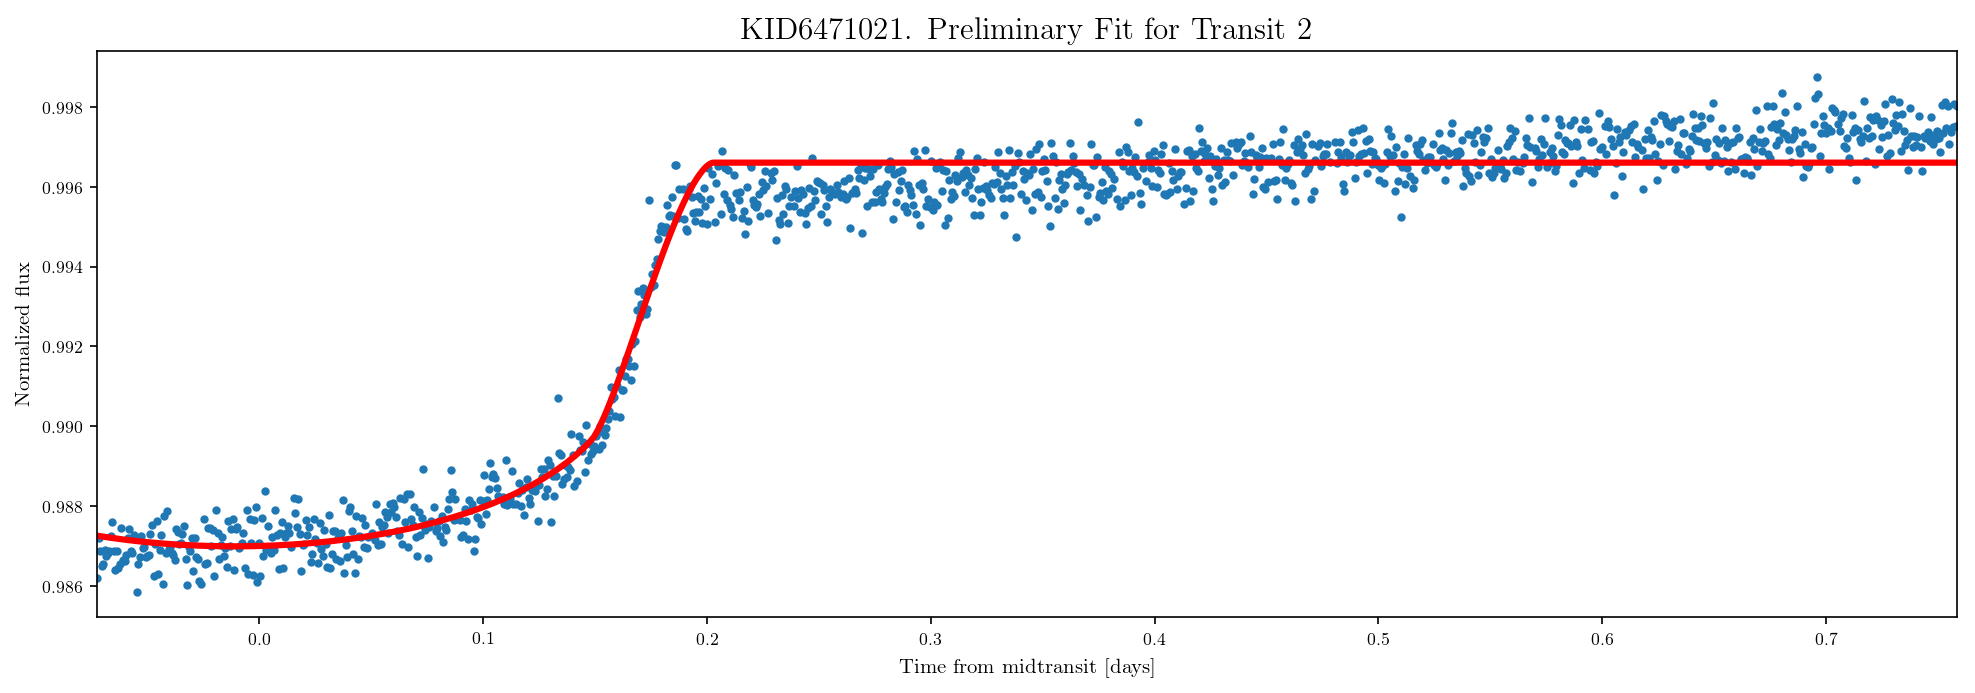

  0%|          | 0/250 [00:00<?, ?it/s]

------ Pre-MCMC Results ------
	Transit duration [d]:	 Fit=0.428	True=0.380
	Period [days]:	 Fit=322.54955967	True=125.62914790
	Impact Parameter:	 Fit=0.588416	True=0.471000
	Depth:	 Fit=0.008664	True=0.007842
	Stellar mass:	 Fit=0.981	True=0.972
	Stellar radius:	 Fit=0.890	True=1.091
	Sigma (white noise):	 Fit=0.000
	Out-of-transit flux:	 Fit=0.997

------ Prepare MCMC -------
Guess impact parameter: 0.5884160410527801
Guess of Rp [in Rsun]:  0.08282031355158666
1+rp_guess/rs:  1.0930805269124515
Running burn-in


  0%|          | 0/1000 [00:00<?, ?it/s]


------ Run MCMC -------


100%|██████████| 1000/1000 [02:26<00:00,  7.17it/s]



------ Post-MCMC Results ------

Depth:
	True = 0.008
	MCMC Fit = 0.008 (+0.000,-0.000)

Impact parameter:
	True = 0.471
	MCMC Fit = 0.480 (+0.061,-0.064)

Planet radius [REarth]:
	True = 10.020
	MCMC Fit = 10.412 (+0.645,-0.703)

Period [d]:
	True = 125.629
	MCMC Fit = 209.300 (+59.630,-38.118)

Inverse of scaled semi-major axis:
	True = 0.0097
	MCMC Fit = 0.0053 (+0.0003,-0.0004)

Stellar radius [Rsun]:
	True = 1.091
	MCMC Fit = 1.042 (+0.064,-0.067)

Stellar Mass [Msun]:
	True = 0.972
	MCMC Fit = 0.981 (+0.050,-0.047)
Mean acceptance fraction: 0.3359
Acceptance fraction: 33.59 %

	*TRANSIT 7
		Signal = 0.00017. Noise (rms) = 0.00047. SNR = 0.36815
		Out-of-transit error of the transit LC = 0.00047

	*TRANSIT 8
		Signal = 0.02445. Noise (rms) = 0.00175. SNR = 13.97020
		Out-of-transit error of the transit LC = 0.00175
Max. depth (guess) = 1.16488
Depth guess = 0.02719. True depth = 0.00784


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in subtract


Optimization terminated successfully.
         Current function value: -12980.883886
         Iterations: 1829
         Function evaluations: 2777
Optimization terminated successfully.
         Current function value: -13019.264192
         Iterations: 2137
         Function evaluations: 3170


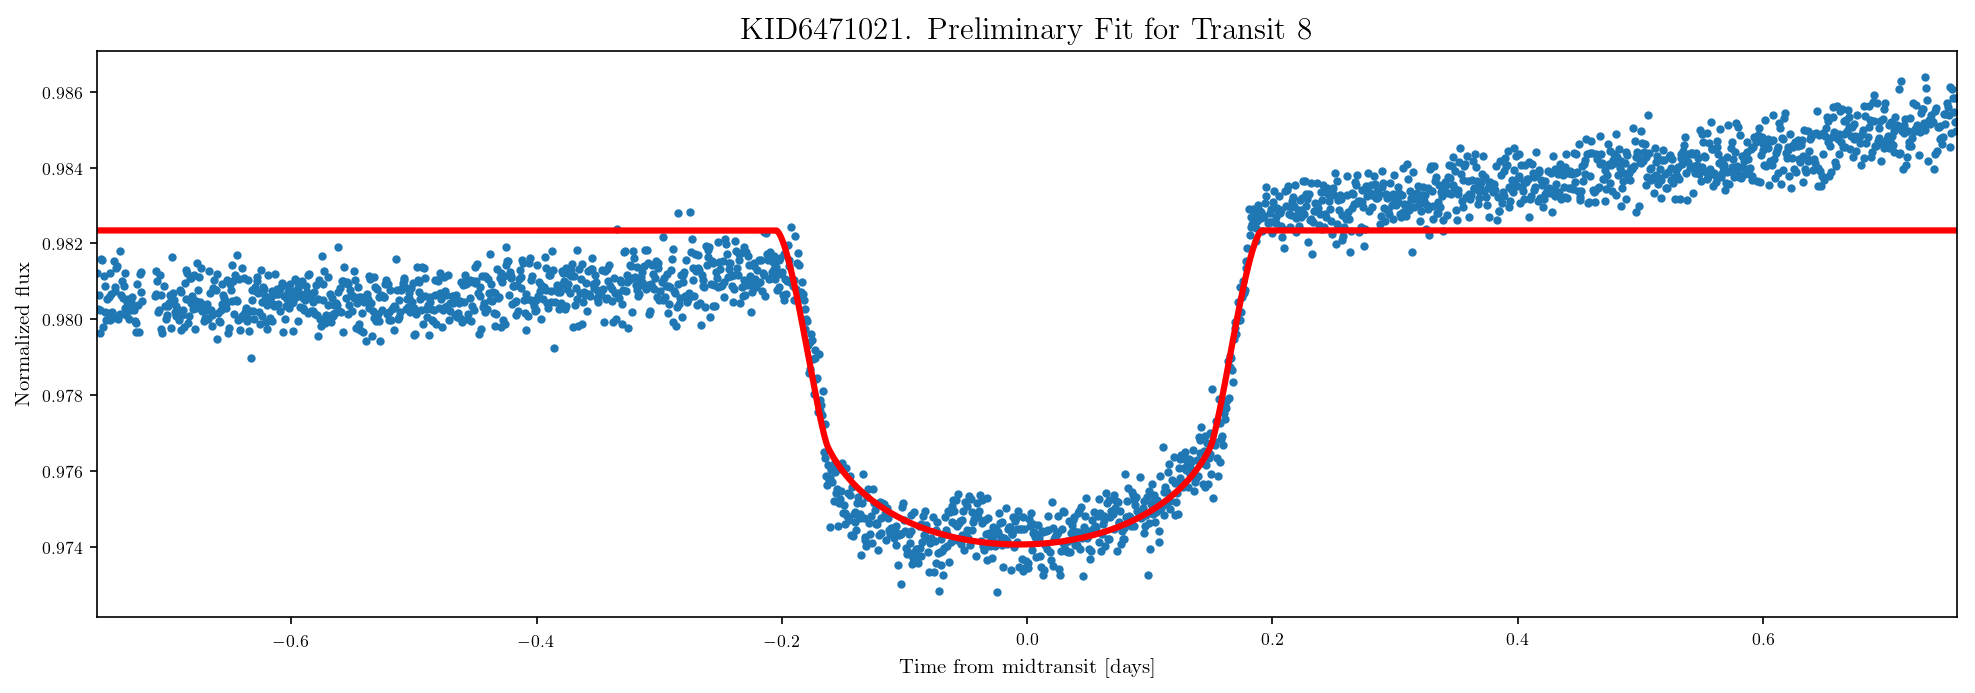

------ Pre-MCMC Results ------
	Transit duration [d]:	 Fit=0.396	True=0.380
	Period [days]:	 Fit=194.54309310	True=125.62914790
	Impact Parameter:	 Fit=0.524267	True=0.471000
	Depth:	 Fit=0.007275	True=0.007842
	Stellar mass:	 Fit=0.986	True=0.972
	Stellar radius:	 Fit=0.947	True=1.091
	Sigma (white noise):	 Fit=0.000
	Out-of-transit flux:	 Fit=0.982

------ Prepare MCMC -------
Guess impact parameter: 0.5242666690336252
Guess of Rp [in Rsun]:  0.08076986859014273
1+rp_guess/rs:  1.0852912419985108
Running burn-in


100%|██████████| 250/250 [01:05<00:00,  4.14it/s]



------ Run MCMC -------


100%|██████████| 1000/1000 [04:00<00:00,  4.22it/s]



------ Post-MCMC Results ------

Depth:
	True = 0.008
	MCMC Fit = 0.007 (+0.000,-0.000)

Impact parameter:
	True = 0.471
	MCMC Fit = 0.436 (+0.122,-0.140)

Planet radius [REarth]:
	True = 10.020
	MCMC Fit = 9.887 (+0.696,-0.719)

Period [d]:
	True = 125.629
	MCMC Fit = 113.053 (+39.766,-29.035)

Inverse of scaled semi-major axis:
	True = 0.0097
	MCMC Fit = 0.0077 (+0.0006,-0.0006)

Stellar radius [Rsun]:
	True = 1.091
	MCMC Fit = 1.077 (+0.072,-0.078)

Stellar Mass [Msun]:
	True = 0.972
	MCMC Fit = 0.971 (+0.053,-0.046)
Mean acceptance fraction: 0.32496
Acceptance fraction: 32.50 %

	*TRANSIT 9
		Signal = -0.00109. Noise (rms) = 0.00058. SNR = -1.87043
		Out-of-transit error of the transit LC = 0.00058

******************************** KID11133306 ********************************

	*TRANSIT 1
		Signal = 0.00039. Noise (rms) = 0.00030. SNR = 1.31444
		Out-of-transit error of the transit LC = 0.00030

	*TRANSIT 2
		Signal = 0.00036. Noise (rms) = 0.00029. SNR = 1.21043
		Out-of-transit 

/Users/mbadenas/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in subtract


Optimization terminated successfully.
         Current function value: -7195.978703
         Iterations: 3528
         Function evaluations: 5171
Optimization terminated successfully.
         Current function value: -7221.824884
         Iterations: 2528
         Function evaluations: 3805


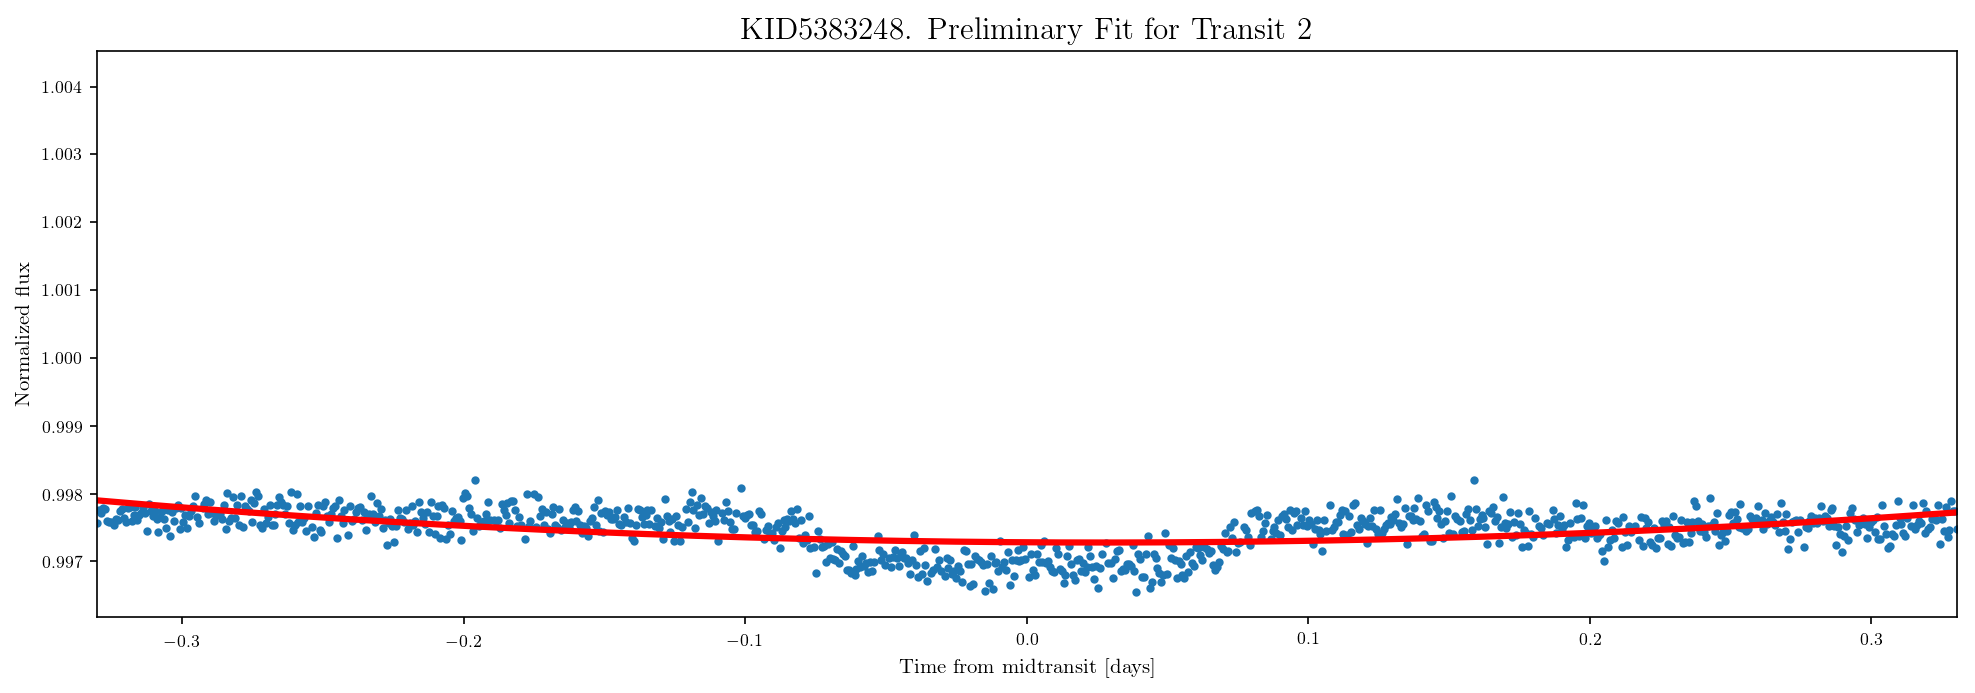

  0%|          | 0/250 [00:00<?, ?it/s]

------ Pre-MCMC Results ------
	Transit duration [d]:	 Fit=3.642	True=0.165
	Period [days]:	 Fit=19244.07511551	True=16.23847733
	Impact Parameter:	 Fit=0.000000	True=0.766000
	Depth:	 Fit=0.041313	True=0.000647
	Stellar mass:	 Fit=0.944	True=0.951
	Stellar radius:	 Fit=1.465	True=1.117
	Sigma (white noise):	 Fit=0.000
	Out-of-transit flux:	 Fit=1.047

------ Prepare MCMC -------
Guess impact parameter: 1.052861516529156e-10
Guess of Rp [in Rsun]:  0.29782973952892006
1+rp_guess/rs:  1.203255280069774
Running burn-in


  0%|          | 0/1000 [00:00<?, ?it/s]


------ Run MCMC -------


100%|██████████| 1000/1000 [01:45<00:00,  9.84it/s]



------ Post-MCMC Results ------

Depth:
	True = 0.001
	MCMC Fit = 0.045 (+0.016,-0.014)

Impact parameter:
	True = 0.766
	MCMC Fit = 0.000 (+0.000,-0.000)

Planet radius [REarth]:
	True = 2.760
	MCMC Fit = 30.291 (+8.768,-7.166)

Period [d]:
	True = 16.238
	MCMC Fit = 31772.457 (+19986.944,-14432.828)

Inverse of scaled semi-major axis:
	True = 0.0469
	MCMC Fit = 0.0004 (+0.0001,-0.0001)

Stellar radius [Rsun]:
	True = 1.117
	MCMC Fit = 1.320 (+0.221,-0.199)

Stellar Mass [Msun]:
	True = 0.951
	MCMC Fit = 0.954 (+0.049,-0.046)
Mean acceptance fraction: 0.32232
Acceptance fraction: 32.23 %

	*TRANSIT 9
		Signal = -0.00050. Noise (rms) = 0.00015. SNR = -3.27320
		Out-of-transit error of the transit LC = 0.00015

	*TRANSIT 10
		Signal = nan. Noise (rms) = 0.00016. SNR = nan
		Out-of-transit error of the transit LC = 0.00016

	*TRANSIT 20
		Signal = -0.00051. Noise (rms) = 0.00022. SNR = -2.26599
		Out-of-transit error of the transit LC = 0.00022

	*TRANSIT 21
		Signal = -0.00043. Noise (

/Users/mbadenas/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in subtract


Optimization terminated successfully.
         Current function value: -6941.740562
         Iterations: 1458
         Function evaluations: 2154
Optimization terminated successfully.
         Current function value: -6931.481919
         Iterations: 1521
         Function evaluations: 2248


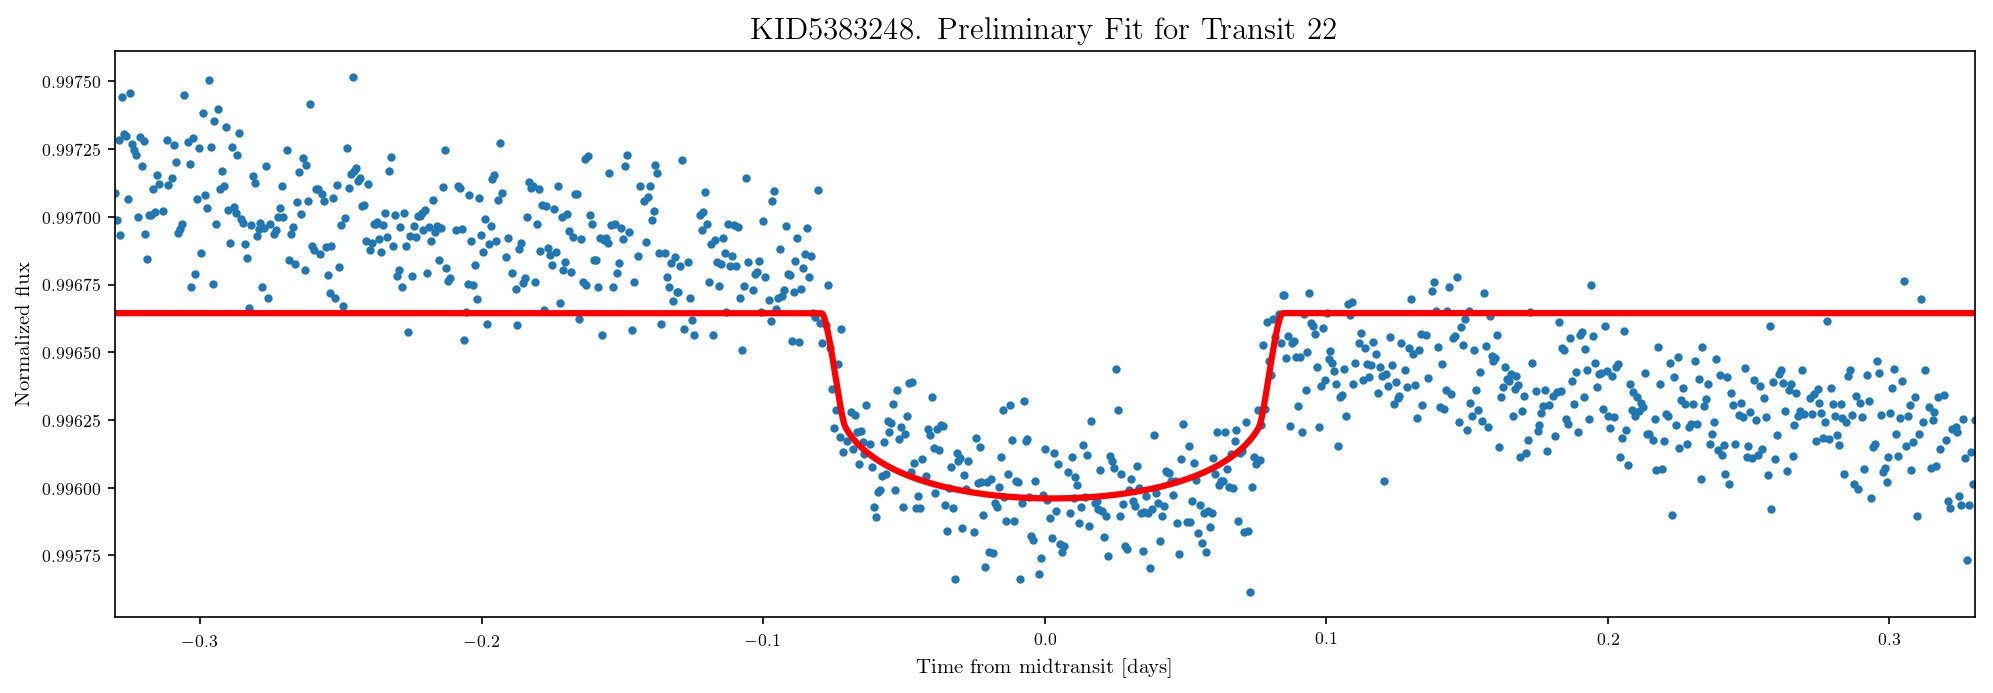

  0%|          | 0/250 [00:00<?, ?it/s]

------ Pre-MCMC Results ------
	Transit duration [d]:	 Fit=0.164	True=0.165
	Period [days]:	 Fit=13.50000091	True=16.23847733
	Impact Parameter:	 Fit=0.711972	True=0.766000
	Depth:	 Fit=0.000657	True=0.000647
	Stellar mass:	 Fit=0.950	True=0.951
	Stellar radius:	 Fit=1.208	True=1.117
	Sigma (white noise):	 Fit=0.000
	Out-of-transit flux:	 Fit=0.997

------ Prepare MCMC -------
Guess impact parameter: 0.7119720390929272
Guess of Rp [in Rsun]:  0.030962365245875
1+rp_guess/rs:  1.025631137311385
Running burn-in


  0%|          | 0/1000 [00:00<?, ?it/s]


------ Run MCMC -------


100%|██████████| 1000/1000 [01:24<00:00, 12.27it/s]



------ Post-MCMC Results ------

Depth:
	True = 0.001
	MCMC Fit = 0.001 (+0.000,-0.000)

Impact parameter:
	True = 0.766
	MCMC Fit = 0.728 (+0.102,-0.216)

Planet radius [REarth]:
	True = 2.760
	MCMC Fit = 3.175 (+0.859,-0.730)

Period [d]:
	True = 16.238
	MCMC Fit = 16.745 (+5.957,-2.520)

Inverse of scaled semi-major axis:
	True = 0.0469
	MCMC Fit = 0.0482 (+0.0104,-0.0087)

Stellar radius [Rsun]:
	True = 1.117
	MCMC Fit = 1.130 (+0.241,-0.204)

Stellar Mass [Msun]:
	True = 0.951
	MCMC Fit = 0.945 (+0.050,-0.047)
Mean acceptance fraction: 0.31812999999999997
Acceptance fraction: 31.81 %

	*TRANSIT 23
		Signal = 0.00295. Noise (rms) = 0.00020. SNR = 14.43326
		Out-of-transit error of the transit LC = 0.00020
Max. depth (guess) = 1.05851
Depth guess = 0.00342. True depth = 0.00065


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in subtract


Optimization terminated successfully.
         Current function value: -6769.233670
         Iterations: 3939
         Function evaluations: 5753
Optimization terminated successfully.
         Current function value: -6774.601535
         Iterations: 2868
         Function evaluations: 4279


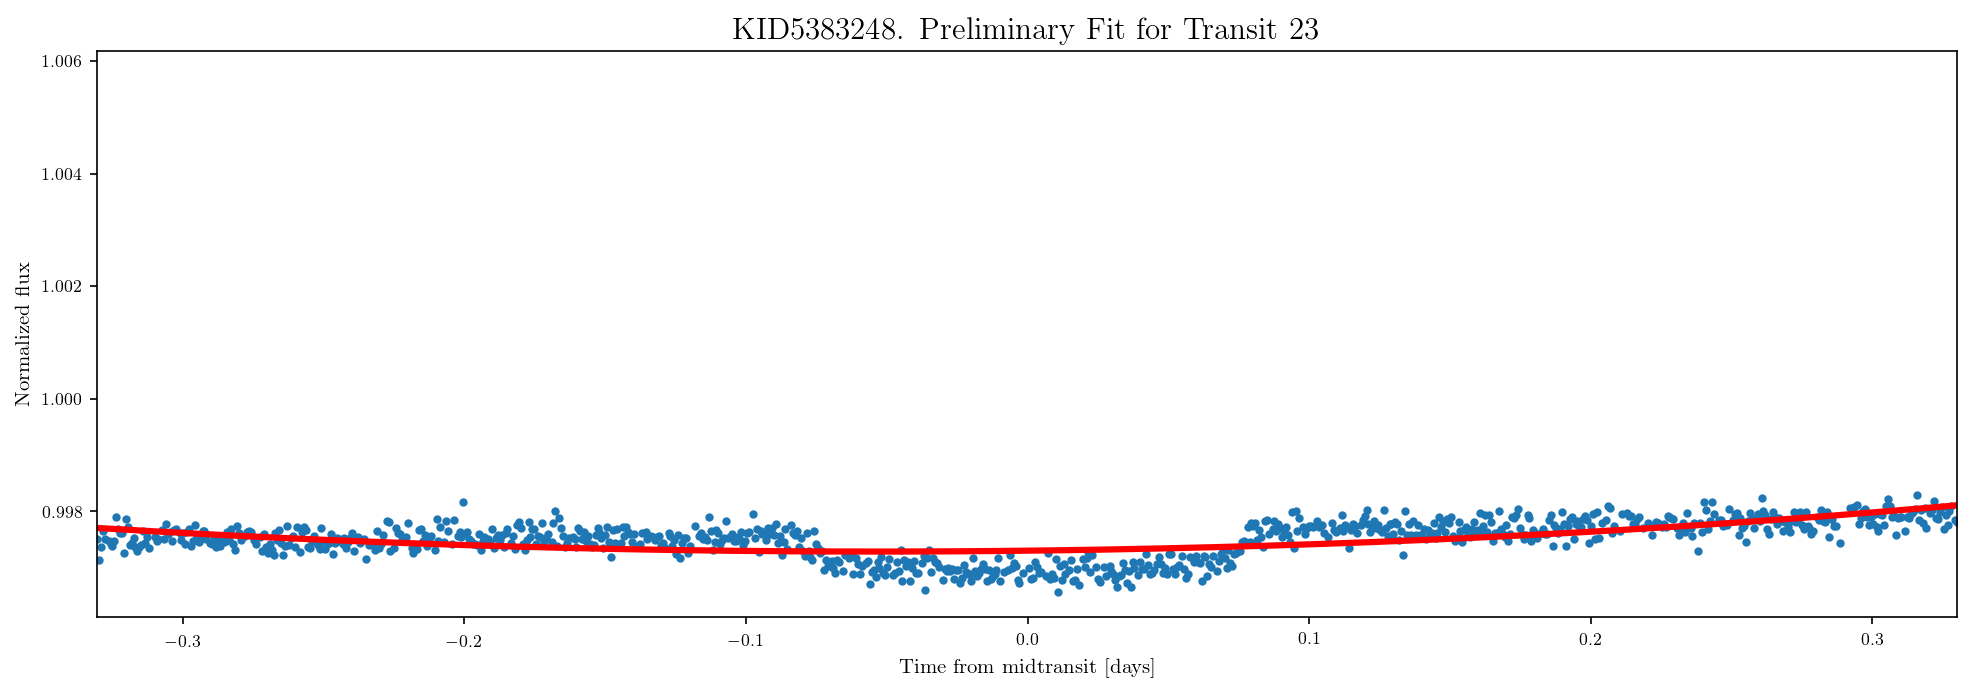

/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
  0%|          | 0/250 [00:00<?, ?it/s]

------ Pre-MCMC Results ------
	Transit duration [d]:	 Fit=4.060	True=0.165
	Period [days]:	 Fit=44981.67727012	True=16.23847733
	Impact Parameter:	 Fit=0.546846	True=0.766000
	Depth:	 Fit=0.047858	True=0.000647
	Stellar mass:	 Fit=0.947	True=0.951
	Stellar radius:	 Fit=1.361	True=1.117
	Sigma (white noise):	 Fit=0.000
	Out-of-transit flux:	 Fit=1.051

------ Prepare MCMC -------
Guess impact parameter: 0.546846430422947
Guess of Rp [in Rsun]:  0.2977145427385909
1+rp_guess/rs:  1.218765389233454
Running burn-in


  0%|          | 0/1000 [00:00<?, ?it/s]


------ Run MCMC -------


100%|██████████| 1000/1000 [01:59<00:00,  8.51it/s]



------ Post-MCMC Results ------

Depth:
	True = 0.001
	MCMC Fit = 0.051 (+0.014,-0.013)

Impact parameter:
	True = 0.766
	MCMC Fit = 0.536 (+0.062,-0.089)

Planet radius [REarth]:
	True = 2.760
	MCMC Fit = 32.315 (+8.426,-7.210)

Period [d]:
	True = 16.238
	MCMC Fit = 54252.788 (+20744.047,-18806.935)

Inverse of scaled semi-major axis:
	True = 0.0469
	MCMC Fit = 0.0003 (+0.0000,-0.0000)

Stellar radius [Rsun]:
	True = 1.117
	MCMC Fit = 1.308 (+0.204,-0.160)

Stellar Mass [Msun]:
	True = 0.951
	MCMC Fit = 0.949 (+0.058,-0.052)
Mean acceptance fraction: 0.20463000000000003
Acceptance fraction: 20.46 %

	*TRANSIT 24
		Signal = 0.00069. Noise (rms) = 0.00019. SNR = 3.60672
		Out-of-transit error of the transit LC = 0.00019
Max. depth (guess) = 1.03493
Depth guess = 0.00122. True depth = 0.00065


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in subtract


Optimization terminated successfully.
         Current function value: -7167.309955
         Iterations: 2252
         Function evaluations: 3338
Optimization terminated successfully.
         Current function value: -7176.974346
         Iterations: 2059
         Function evaluations: 3078


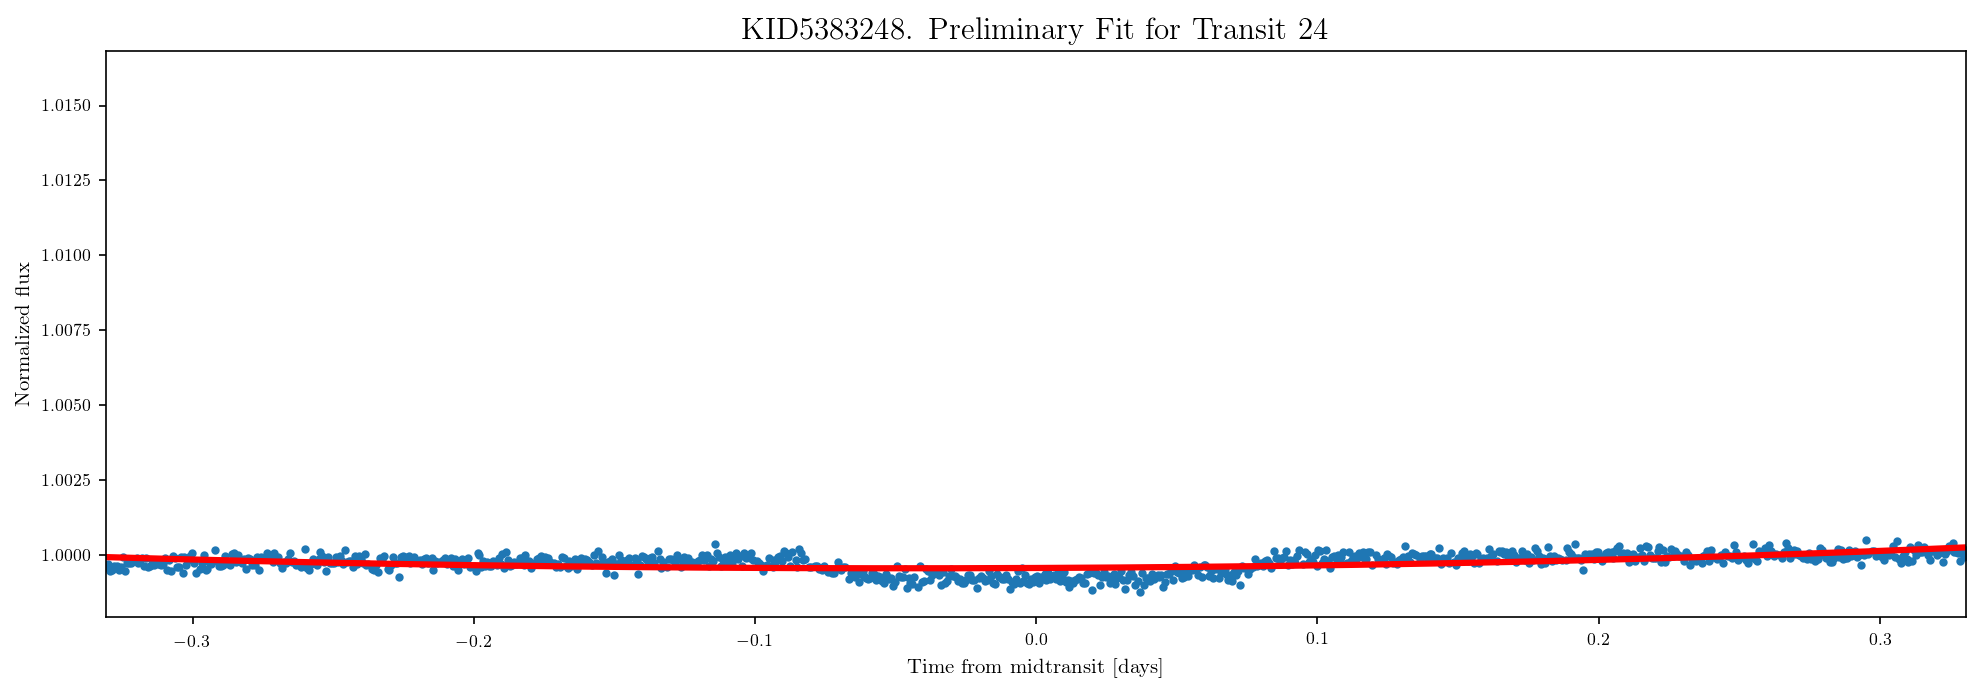

/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
  0%|          | 0/250 [00:00<?, ?it/s]

------ Pre-MCMC Results ------
	Transit duration [d]:	 Fit=1.973	True=0.165
	Period [days]:	 Fit=2398.14725430	True=16.23847733
	Impact Parameter:	 Fit=0.069016	True=0.766000
	Depth:	 Fit=0.013499	True=0.000647
	Stellar mass:	 Fit=0.937	True=0.951
	Stellar radius:	 Fit=1.712	True=1.117
	Sigma (white noise):	 Fit=0.000
	Out-of-transit flux:	 Fit=1.016

------ Prepare MCMC -------
Guess impact parameter: 0.0690160549568702
Guess of Rp [in Rsun]:  0.19892387427871983
1+rp_guess/rs:  1.1161852677852357
Running burn-in


  0%|          | 0/1000 [00:00<?, ?it/s]


------ Run MCMC -------


100%|██████████| 1000/1000 [01:49<00:00,  9.24it/s]



------ Post-MCMC Results ------

Depth:
	True = 0.001
	MCMC Fit = 0.028 (+0.012,-0.009)

Impact parameter:
	True = 0.766
	MCMC Fit = 0.061 (+0.065,-0.042)

Planet radius [REarth]:
	True = 2.760
	MCMC Fit = 26.735 (+7.428,-6.665)

Period [d]:
	True = 16.238
	MCMC Fit = 12042.930 (+6790.144,-5802.384)

Inverse of scaled semi-major axis:
	True = 0.0469
	MCMC Fit = 0.0020 (+0.0003,-0.0003)

Stellar radius [Rsun]:
	True = 1.117
	MCMC Fit = 1.463 (+0.221,-0.197)

Stellar Mass [Msun]:
	True = 0.951
	MCMC Fit = 0.946 (+0.049,-0.048)
Mean acceptance fraction: 0.341
Acceptance fraction: 34.10 %

	*TRANSIT 25
		Signal = 0.00047. Noise (rms) = 0.00019. SNR = 2.48073
		Out-of-transit error of the transit LC = 0.00019

	*TRANSIT 26
		Signal = -0.00086. Noise (rms) = 0.00016. SNR = -5.31127
		Out-of-transit error of the transit LC = 0.00016

	*TRANSIT 27
		Signal = -0.00033. Noise (rms) = 0.00017. SNR = -1.97904
		Out-of-transit error of the transit LC = 0.00017

	*TRANSIT 28
		Signal = -0.00016. No

/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in subtract


Optimization terminated successfully.
         Current function value: -7325.331427
         Iterations: 3447
         Function evaluations: 5133
Optimization terminated successfully.
         Current function value: -7326.079966
         Iterations: 1268
         Function evaluations: 1976


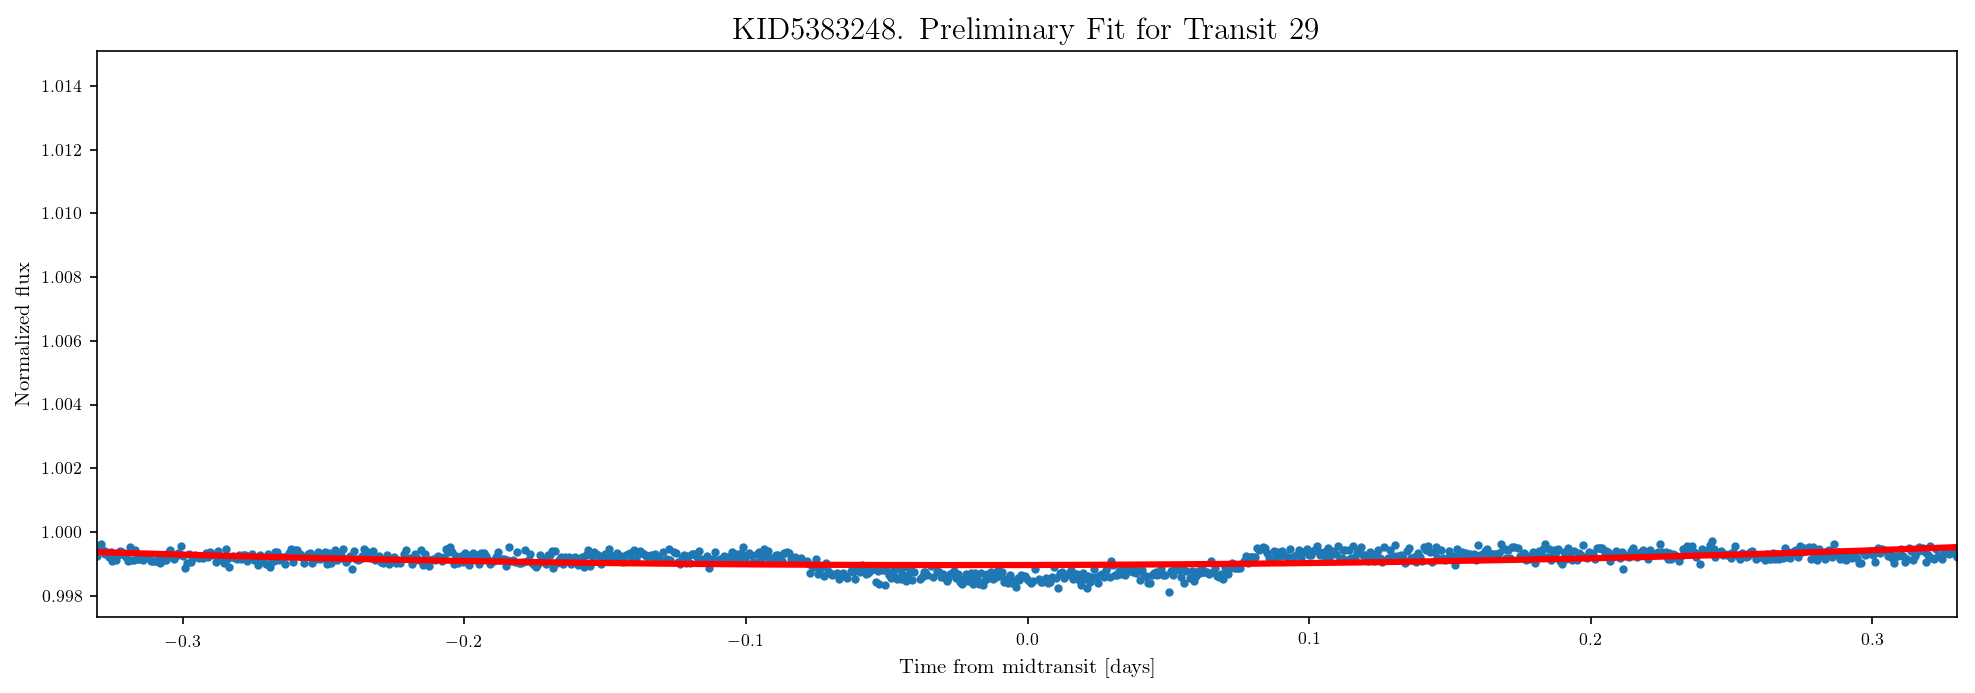

/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
  0%|          | 0/250 [00:00<?, ?it/s]

------ Pre-MCMC Results ------
	Transit duration [d]:	 Fit=1.964	True=0.165
	Period [days]:	 Fit=6372.17834028	True=16.23847733
	Impact Parameter:	 Fit=0.000000	True=0.766000
	Depth:	 Fit=0.012607	True=0.000647
	Stellar mass:	 Fit=0.948	True=0.951
	Stellar radius:	 Fit=1.238	True=1.117
	Sigma (white noise):	 Fit=0.000
	Out-of-transit flux:	 Fit=1.014

------ Prepare MCMC -------
Guess impact parameter: 3.3922061956103996e-14
Guess of Rp [in Rsun]:  0.13895312243449262
1+rp_guess/rs:  1.1122806135024572
Running burn-in


  0%|          | 0/1000 [00:00<?, ?it/s]


------ Run MCMC -------


100%|██████████| 1000/1000 [01:49<00:00,  9.41it/s]



------ Post-MCMC Results ------

Depth:
	True = 0.001
	MCMC Fit = 0.038 (+0.014,-0.013)

Impact parameter:
	True = 0.766
	MCMC Fit = 0.000 (+0.000,-0.000)

Planet radius [REarth]:
	True = 2.760
	MCMC Fit = 30.084 (+7.280,-7.567)

Period [d]:
	True = 16.238
	MCMC Fit = 21639.020 (+12565.244,-9434.988)

Inverse of scaled semi-major axis:
	True = 0.0469
	MCMC Fit = 0.0010 (+0.0001,-0.0001)

Stellar radius [Rsun]:
	True = 1.117
	MCMC Fit = 1.409 (+0.190,-0.177)

Stellar Mass [Msun]:
	True = 0.951
	MCMC Fit = 0.948 (+0.048,-0.049)
Mean acceptance fraction: 0.35767999999999994
Acceptance fraction: 35.77 %

	*TRANSIT 30
		Signal = 0.00055. Noise (rms) = 0.00016. SNR = 3.39445
		Out-of-transit error of the transit LC = 0.00016
Max. depth (guess) = 1.03490
Depth guess = 0.00122. True depth = 0.00065


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in multiply
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in subtract


Optimization terminated successfully.
         Current function value: -7311.629731
         Iterations: 3976
         Function evaluations: 5855
Optimization terminated successfully.
         Current function value: -7322.517147
         Iterations: 1627
         Function evaluations: 2480


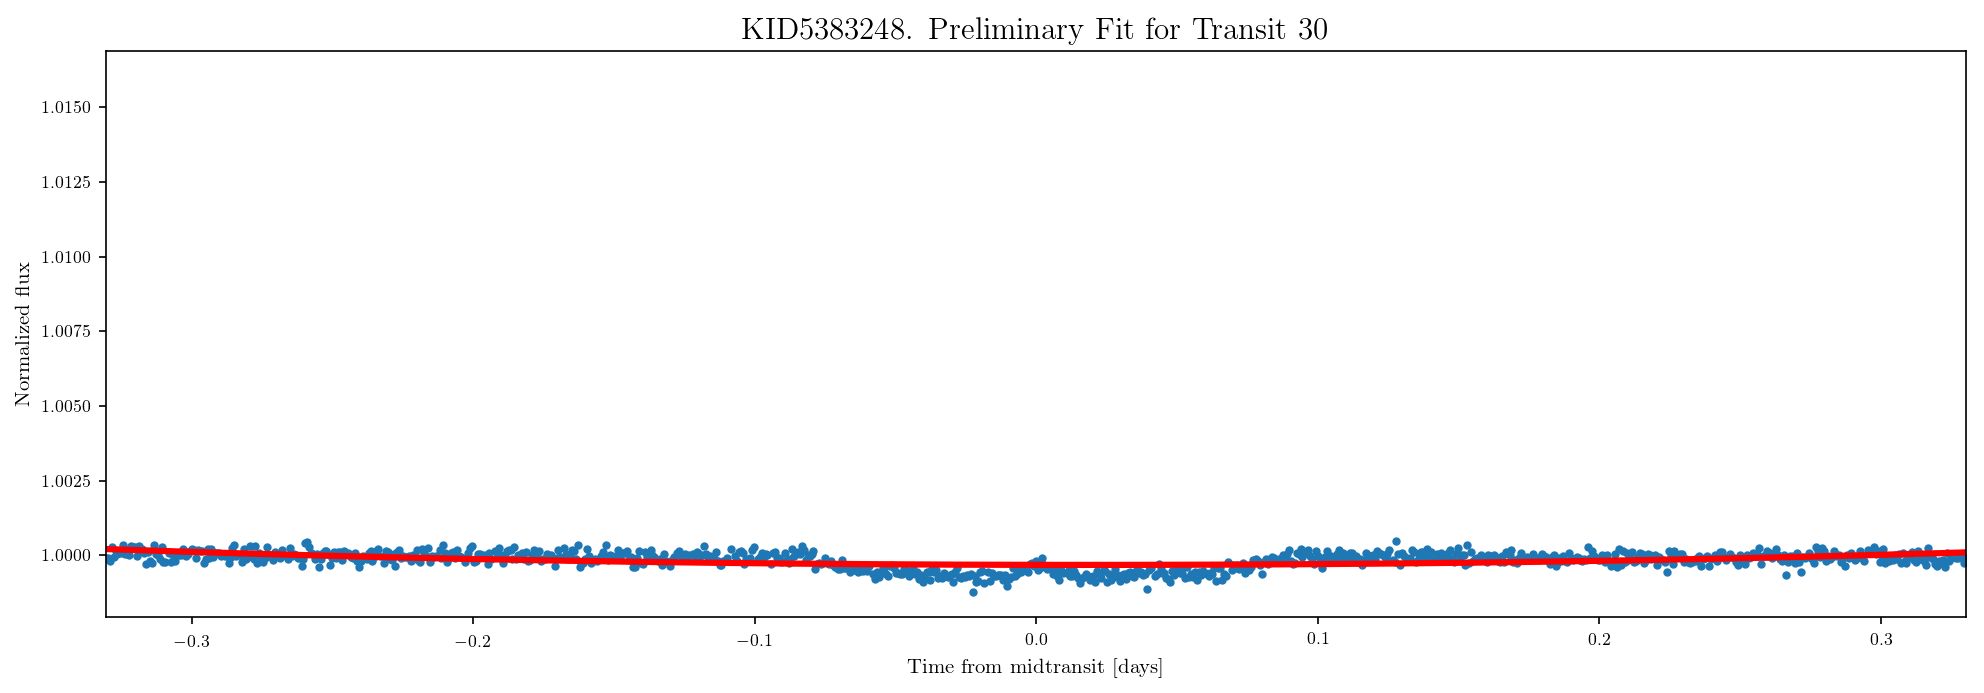

/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
  0%|          | 0/250 [00:00<?, ?it/s]

------ Pre-MCMC Results ------
	Transit duration [d]:	 Fit=2.066	True=0.165
	Period [days]:	 Fit=5284.92946913	True=16.23847733
	Impact Parameter:	 Fit=0.000000	True=0.766000
	Depth:	 Fit=0.013608	True=0.000647
	Stellar mass:	 Fit=0.946	True=0.951
	Stellar radius:	 Fit=1.379	True=1.117
	Sigma (white noise):	 Fit=0.000
	Out-of-transit flux:	 Fit=1.016

------ Prepare MCMC -------
Guess impact parameter: 4.890959880495691e-24
Guess of Rp [in Rsun]:  0.16085065241711274
1+rp_guess/rs:  1.1166536215044667
Running burn-in


  0%|          | 0/1000 [00:00<?, ?it/s]


------ Run MCMC -------


100%|██████████| 1000/1000 [01:46<00:00,  9.91it/s]



------ Post-MCMC Results ------

Depth:
	True = 0.001
	MCMC Fit = 0.037 (+0.013,-0.014)

Impact parameter:
	True = 0.766
	MCMC Fit = 0.000 (+0.000,-0.000)

Planet radius [REarth]:
	True = 2.760
	MCMC Fit = 29.078 (+7.649,-7.230)

Period [d]:
	True = 16.238
	MCMC Fit = 22699.303 (+13757.540,-10681.793)

Inverse of scaled semi-major axis:
	True = 0.0469
	MCMC Fit = 0.0011 (+0.0002,-0.0002)

Stellar radius [Rsun]:
	True = 1.117
	MCMC Fit = 1.395 (+0.197,-0.192)

Stellar Mass [Msun]:
	True = 0.951
	MCMC Fit = 0.944 (+0.051,-0.051)
Mean acceptance fraction: 0.35013000000000005
Acceptance fraction: 35.01 %

	*TRANSIT 32
		Signal = 0.00109. Noise (rms) = 0.00016. SNR = 6.97423
		Out-of-transit error of the transit LC = 0.00016
Max. depth (guess) = 1.04090
Depth guess = 0.00167. True depth = 0.00065


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in subtract


Optimization terminated successfully.
         Current function value: -7193.539948
         Iterations: 1873
         Function evaluations: 2821
Optimization terminated successfully.
         Current function value: -7215.770262
         Iterations: 2401
         Function evaluations: 3618


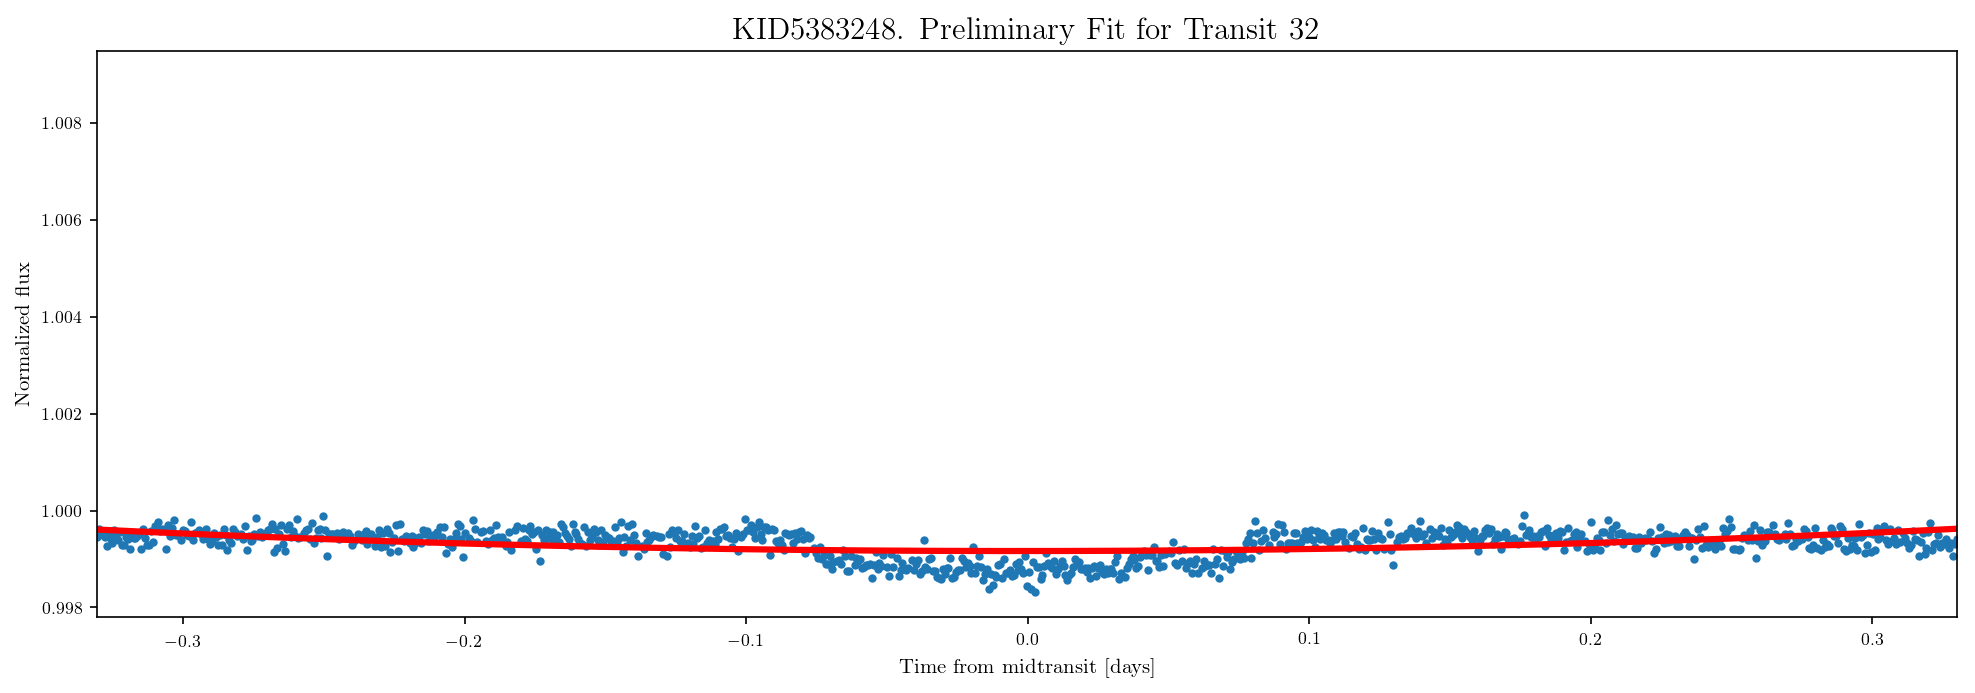

/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
  0%|          | 0/250 [00:00<?, ?it/s]

------ Pre-MCMC Results ------
	Transit duration [d]:	 Fit=2.482	True=0.165
	Period [days]:	 Fit=10204.17303579	True=16.23847733
	Impact Parameter:	 Fit=0.000000	True=0.766000
	Depth:	 Fit=0.018441	True=0.000647
	Stellar mass:	 Fit=0.948	True=0.951
	Stellar radius:	 Fit=1.308	True=1.117
	Sigma (white noise):	 Fit=0.000
	Out-of-transit flux:	 Fit=1.022

------ Prepare MCMC -------
Guess impact parameter: 2.282280888215398e-09
Guess of Rp [in Rsun]:  0.17769121070733457
1+rp_guess/rs:  1.1357987653070873
Running burn-in


  0%|          | 0/1000 [00:00<?, ?it/s]


------ Run MCMC -------


100%|██████████| 1000/1000 [01:48<00:00,  9.17it/s]



------ Post-MCMC Results ------

Depth:
	True = 0.001
	MCMC Fit = 0.037 (+0.014,-0.012)

Impact parameter:
	True = 0.766
	MCMC Fit = 0.000 (+0.000,-0.000)

Planet radius [REarth]:
	True = 2.760
	MCMC Fit = 28.577 (+7.918,-7.223)

Period [d]:
	True = 16.238
	MCMC Fit = 25203.114 (+14432.960,-11555.036)

Inverse of scaled semi-major axis:
	True = 0.0469
	MCMC Fit = 0.0007 (+0.0001,-0.0001)

Stellar radius [Rsun]:
	True = 1.117
	MCMC Fit = 1.373 (+0.197,-0.190)

Stellar Mass [Msun]:
	True = 0.951
	MCMC Fit = 0.945 (+0.052,-0.049)
Mean acceptance fraction: 0.3583799999999999
Acceptance fraction: 35.84 %

	*TRANSIT 34
		Signal = 0.00148. Noise (rms) = 0.00015. SNR = 9.70790
		Out-of-transit error of the transit LC = 0.00015
Max. depth (guess) = 1.04481
Depth guess = 0.00201. True depth = 0.00065


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in subtract


Optimization terminated successfully.
         Current function value: -7059.960577
         Iterations: 966
         Function evaluations: 1477
Optimization terminated successfully.
         Current function value: -7070.409162
         Iterations: 1225
         Function evaluations: 1853


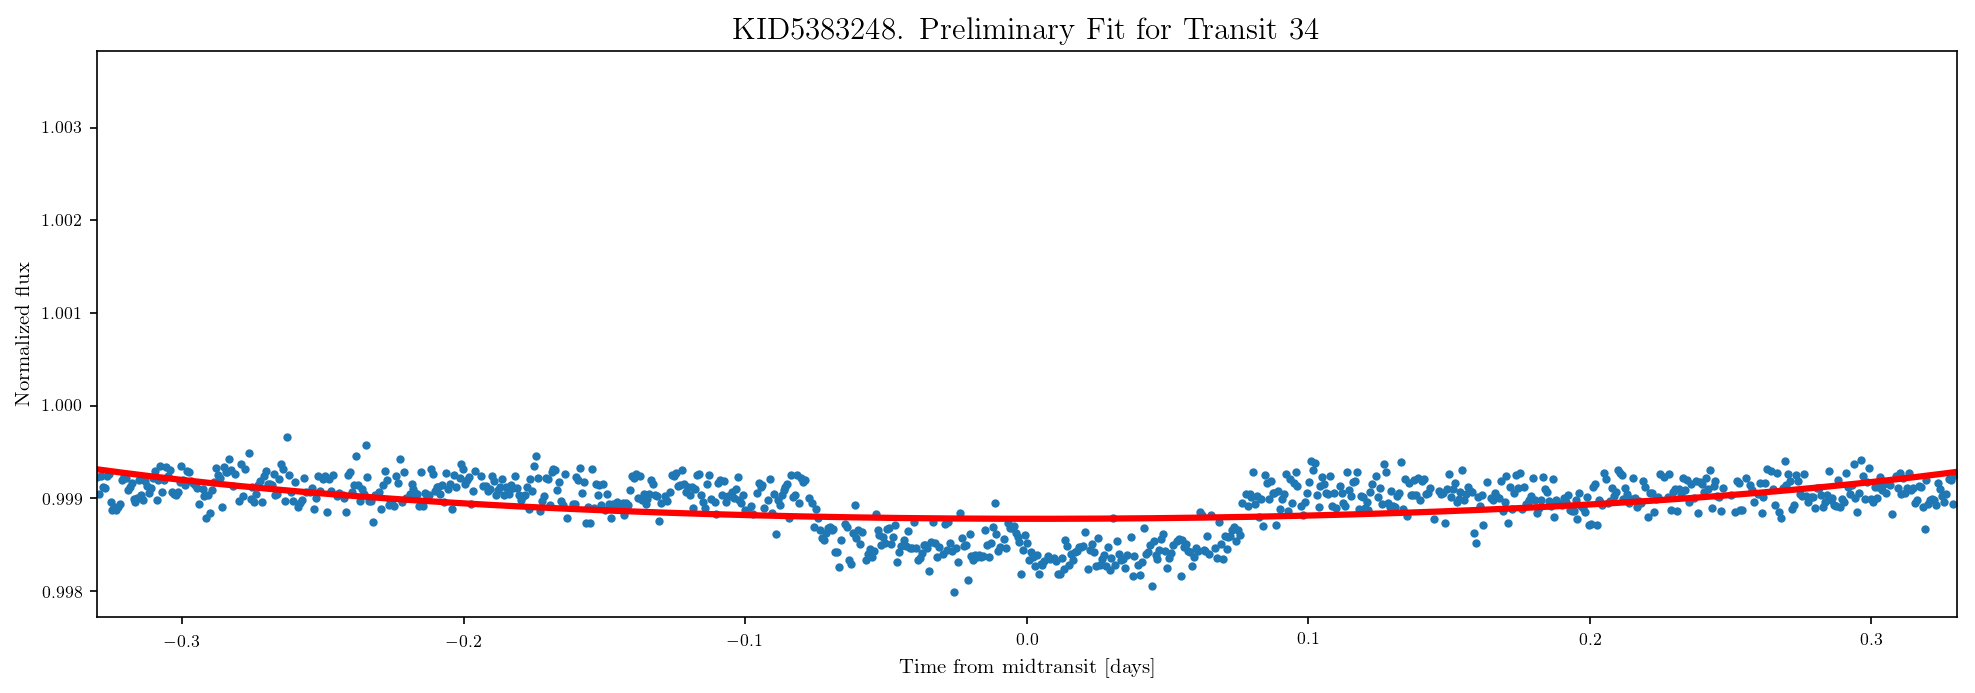

/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
  0%|          | 0/250 [00:00<?, ?it/s]

------ Pre-MCMC Results ------
	Transit duration [d]:	 Fit=1.097	True=0.165
	Period [days]:	 Fit=434.14563569	True=16.23847733
	Impact Parameter:	 Fit=0.000000	True=0.766000
	Depth:	 Fit=0.003918	True=0.000647
	Stellar mass:	 Fit=0.929	True=0.951
	Stellar radius:	 Fit=1.759	True=1.117
	Sigma (white noise):	 Fit=0.000
	Out-of-transit flux:	 Fit=1.004

------ Prepare MCMC -------
Guess impact parameter: 2.5763813834870408e-21
Guess of Rp [in Rsun]:  0.11012935294306543
1+rp_guess/rs:  1.0625926773258065
Running burn-in


  0%|          | 0/1000 [00:00<?, ?it/s]


------ Run MCMC -------


100%|██████████| 1000/1000 [01:45<00:00, 10.19it/s]



------ Post-MCMC Results ------

Depth:
	True = 0.001
	MCMC Fit = 0.028 (+0.011,-0.010)

Impact parameter:
	True = 0.766
	MCMC Fit = 0.000 (+0.000,-0.000)

Planet radius [REarth]:
	True = 2.760
	MCMC Fit = 27.531 (+7.609,-6.022)

Period [d]:
	True = 16.238
	MCMC Fit = 9277.790 (+8194.746,-4373.081)

Inverse of scaled semi-major axis:
	True = 0.0469
	MCMC Fit = 0.0065 (+0.0010,-0.0009)

Stellar radius [Rsun]:
	True = 1.117
	MCMC Fit = 1.530 (+0.240,-0.218)

Stellar Mass [Msun]:
	True = 0.951
	MCMC Fit = 0.946 (+0.050,-0.049)
Mean acceptance fraction: 0.38929
Acceptance fraction: 38.93 %

	*TRANSIT 35
		Signal = 0.00019. Noise (rms) = 0.00021. SNR = 0.91070
		Out-of-transit error of the transit LC = 0.00021

	*TRANSIT 36
		Signal = 0.00118. Noise (rms) = 0.00023. SNR = 5.16709
		Out-of-transit error of the transit LC = 0.00023
Max. depth (guess) = 1.04254
Depth guess = 0.00181. True depth = 0.00065


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in multiply
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in subtract


Optimization terminated successfully.
         Current function value: -7054.204688
         Iterations: 3831
         Function evaluations: 5673
Optimization terminated successfully.
         Current function value: -7055.217086
         Iterations: 1862
         Function evaluations: 2851


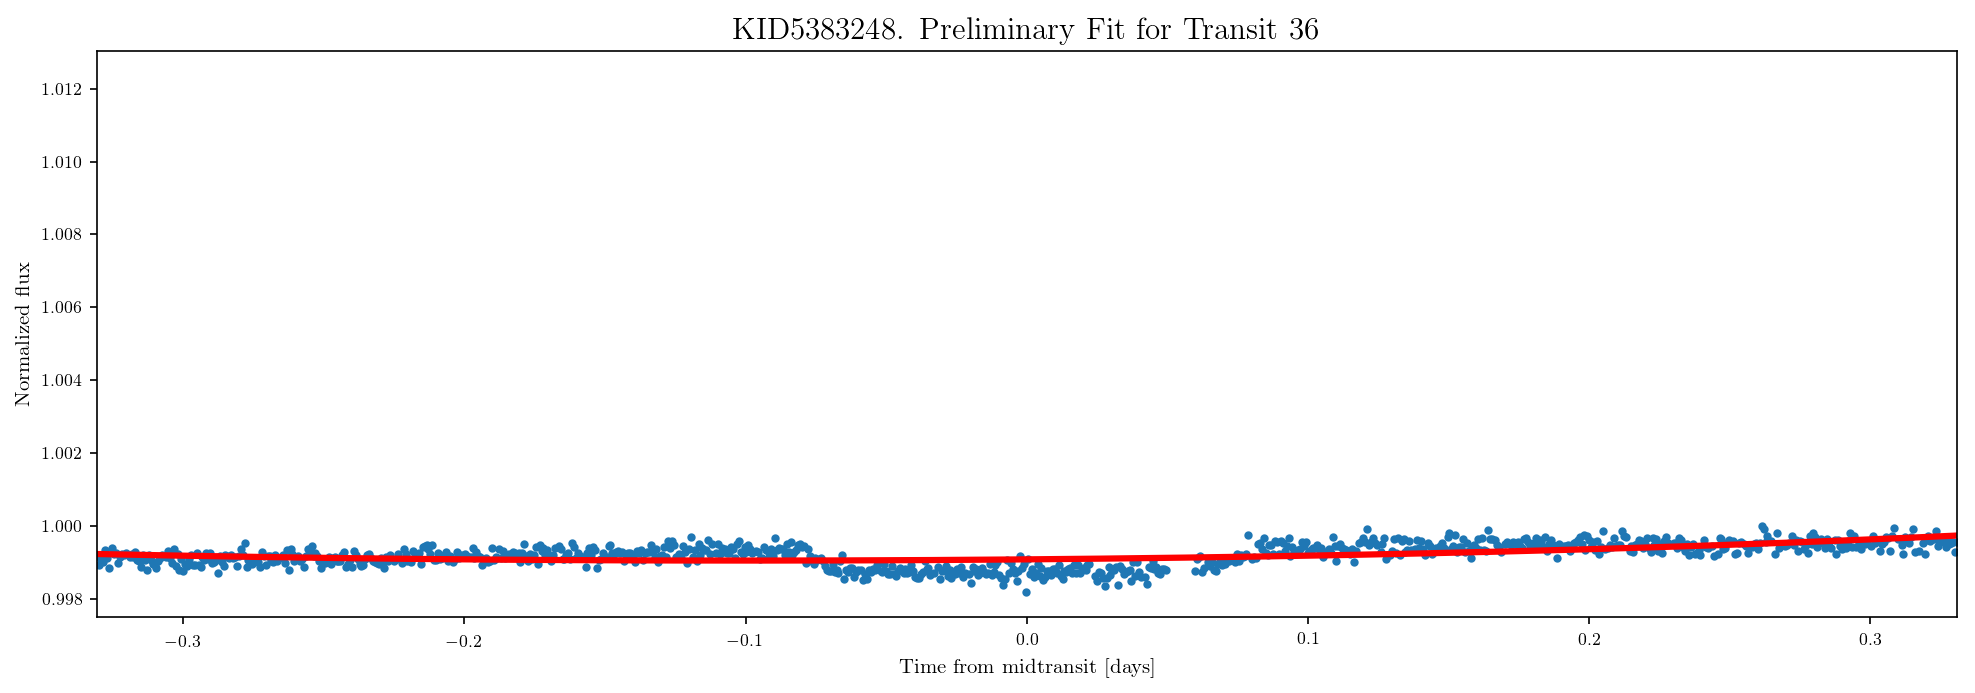

/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
  0%|          | 0/250 [00:00<?, ?it/s]/Users/mbadenas/anaconda3/lib/python3.6/site-packages/emcee-3.0.0.dev0-py3.6.egg/emcee/moves/red_blue.py:96: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - log_probs[j]
  1%|          | 2/250 [00:00<00:15, 15.69it/s]

------ Pre-MCMC Results ------
	Transit duration [d]:	 Fit=2.076	True=0.165
	Period [days]:	 Fit=8129.13774894	True=16.23847733
	Impact Parameter:	 Fit=0.294469	True=0.766000
	Depth:	 Fit=0.011134	True=0.000647
	Stellar mass:	 Fit=0.949	True=0.951
	Stellar radius:	 Fit=1.259	True=1.117
	Sigma (white noise):	 Fit=0.000
	Out-of-transit flux:	 Fit=1.012

------ Prepare MCMC -------
Guess impact parameter: 0.2944686516317122
Guess of Rp [in Rsun]:  0.13284824822124544
1+rp_guess/rs:  1.1055183800374753
Running burn-in


  0%|          | 2/1000 [00:00<00:56, 17.77it/s]


------ Run MCMC -------


100%|██████████| 1000/1000 [01:34<00:00, 10.58it/s]



------ Post-MCMC Results ------

Depth:
	True = 0.001
	MCMC Fit = 0.023 (+0.014,-0.010)

Impact parameter:
	True = 0.766
	MCMC Fit = 0.133 (+0.166,-0.091)

Planet radius [REarth]:
	True = 2.760
	MCMC Fit = 22.318 (+8.017,-6.895)

Period [d]:
	True = 16.238
	MCMC Fit = 17360.317 (+12732.965,-8703.464)

Inverse of scaled semi-major axis:
	True = 0.0469
	MCMC Fit = 0.0008 (+0.0001,-0.0001)

Stellar radius [Rsun]:
	True = 1.117
	MCMC Fit = 1.341 (+0.195,-0.183)

Stellar Mass [Msun]:
	True = 0.951
	MCMC Fit = 0.943 (+0.050,-0.045)
Mean acceptance fraction: 0.25598
Acceptance fraction: 25.60 %

	*TRANSIT 37
		Signal = 0.00009. Noise (rms) = 0.00018. SNR = 0.51844
		Out-of-transit error of the transit LC = 0.00018

	*TRANSIT 39
		Signal = 0.00030. Noise (rms) = 0.00017. SNR = 1.78915
		Out-of-transit error of the transit LC = 0.00017

	*TRANSIT 40
		Signal = 0.00008. Noise (rms) = 0.00015. SNR = 0.54058
		Out-of-transit error of the transit LC = 0.00015

	*TRANSIT 41
		Signal = 0.00070. Nois

/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in multiply
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in subtract


Optimization terminated successfully.
         Current function value: -7200.748271
         Iterations: 2559
         Function evaluations: 3854
Optimization terminated successfully.
         Current function value: -7204.712920
         Iterations: 2278
         Function evaluations: 3459


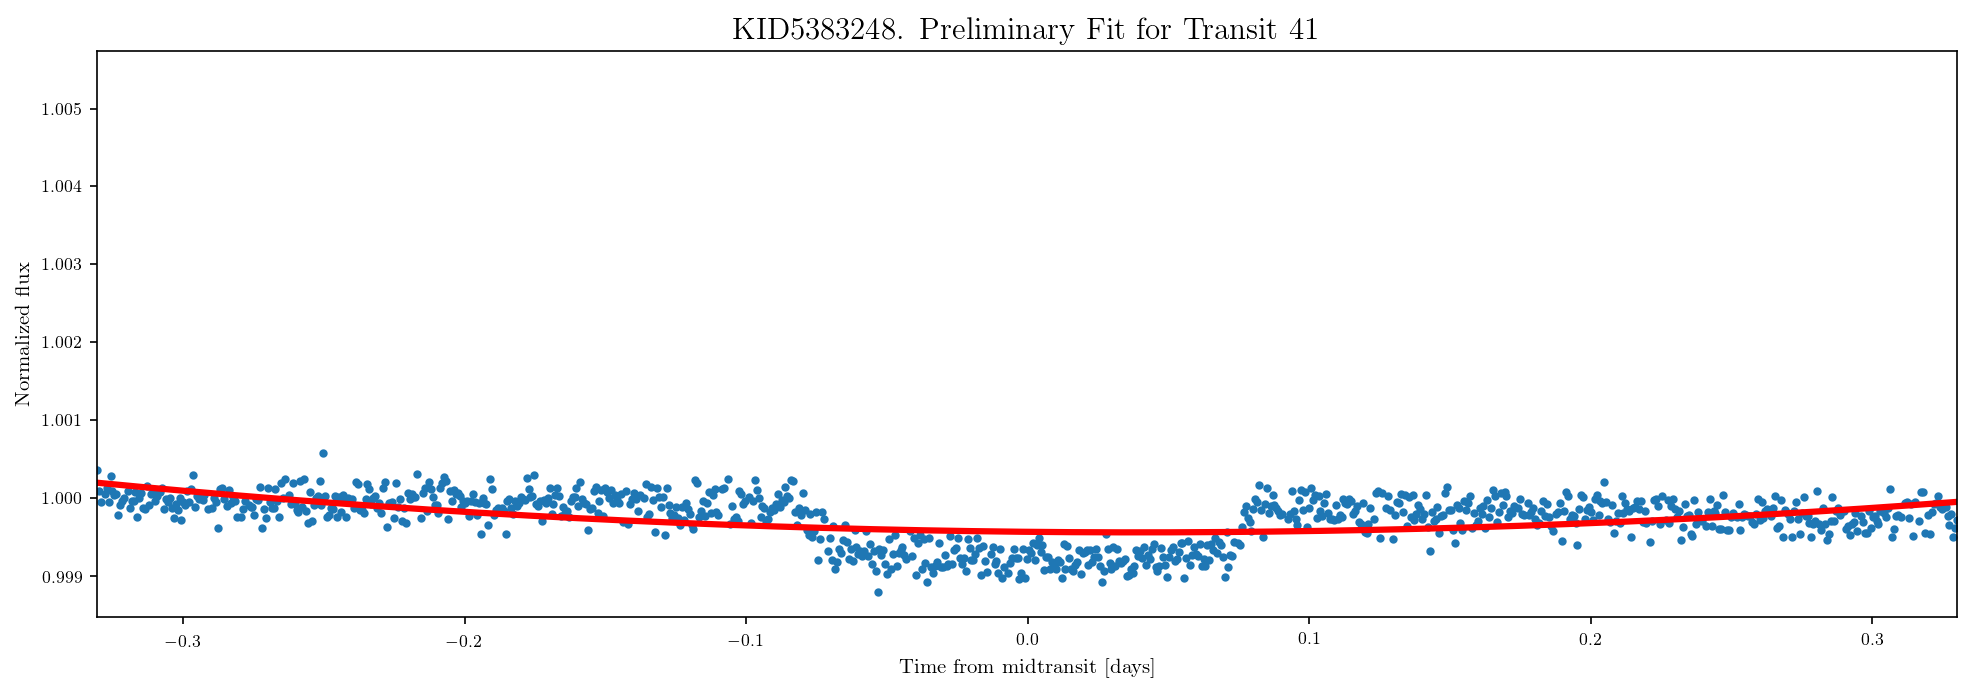

/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
  0%|          | 0/250 [00:00<?, ?it/s]

------ Pre-MCMC Results ------
	Transit duration [d]:	 Fit=5.255	True=0.165
	Period [days]:	 Fit=77863.94252454	True=16.23847733
	Impact Parameter:	 Fit=0.000000	True=0.766000
	Depth:	 Fit=0.072434	True=0.000647
	Stellar mass:	 Fit=0.949	True=0.951
	Stellar radius:	 Fit=1.260	True=1.117
	Sigma (white noise):	 Fit=0.000
	Out-of-transit flux:	 Fit=1.087

------ Prepare MCMC -------
Guess impact parameter: 1.107054160335262e-09
Guess of Rp [in Rsun]:  0.33910434782880716
1+rp_guess/rs:  1.2691352279180683
Running burn-in


  0%|          | 0/1000 [00:00<?, ?it/s]


------ Run MCMC -------


100%|██████████| 1000/1000 [01:45<00:00,  9.49it/s]



------ Post-MCMC Results ------

Depth:
	True = 0.001
	MCMC Fit = 0.077 (+0.017,-0.020)

Impact parameter:
	True = 0.766
	MCMC Fit = 0.000 (+0.000,-0.000)

Planet radius [REarth]:
	True = 2.760
	MCMC Fit = 37.280 (+9.139,-8.760)

Period [d]:
	True = 16.238
	MCMC Fit = 88534.577 (+50204.515,-30936.869)

Inverse of scaled semi-major axis:
	True = 0.0469
	MCMC Fit = 0.0002 (+0.0000,-0.0000)

Stellar radius [Rsun]:
	True = 1.117
	MCMC Fit = 1.233 (+0.205,-0.193)

Stellar Mass [Msun]:
	True = 0.951
	MCMC Fit = 0.952 (+0.050,-0.050)
Mean acceptance fraction: 0.29789
Acceptance fraction: 29.79 %

	*TRANSIT 42
		Signal = -0.00064. Noise (rms) = 0.00015. SNR = -4.17523
		Out-of-transit error of the transit LC = 0.00015

	*TRANSIT 43
		Signal = -0.00020. Noise (rms) = 0.00019. SNR = -1.03643
		Out-of-transit error of the transit LC = 0.00019

	*TRANSIT 44
		Signal = 0.00077. Noise (rms) = 0.00016. SNR = 4.88177
		Out-of-transit error of the transit LC = 0.00016
Max. depth (guess) = 1.03451
Dept

/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in subtract


Optimization terminated successfully.
         Current function value: -7190.905781
         Iterations: 2168
         Function evaluations: 3211
Optimization terminated successfully.
         Current function value: -7226.400287
         Iterations: 2127
         Function evaluations: 3213


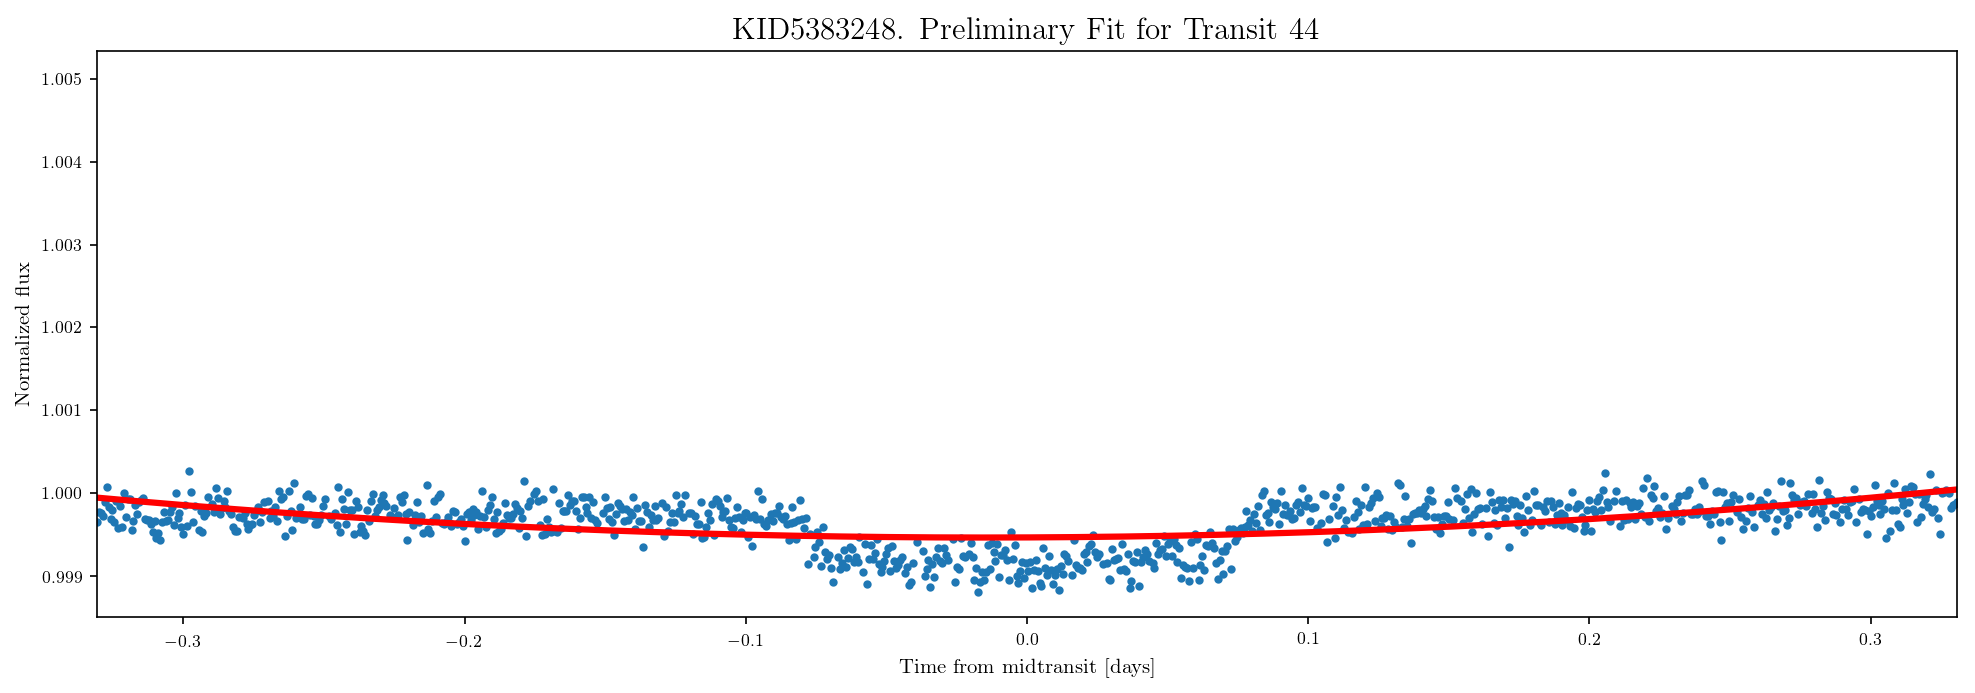

/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
  0%|          | 0/250 [00:00<?, ?it/s]

------ Pre-MCMC Results ------
	Transit duration [d]:	 Fit=6.369	True=0.165
	Period [days]:	 Fit=132741.29806095	True=16.23847733
	Impact Parameter:	 Fit=0.000000	True=0.766000
	Depth:	 Fit=0.100240	True=0.000647
	Stellar mass:	 Fit=0.949	True=0.951
	Stellar radius:	 Fit=1.233	True=1.117
	Sigma (white noise):	 Fit=0.000
	Out-of-transit flux:	 Fit=1.120

------ Prepare MCMC -------
Guess impact parameter: 6.516161875068042e-11
Guess of Rp [in Rsun]:  0.3902196801393878
1+rp_guess/rs:  1.316606897936633
Running burn-in


  0%|          | 0/1000 [00:00<?, ?it/s]


------ Run MCMC -------


100%|██████████| 1000/1000 [01:44<00:00,  9.57it/s]



------ Post-MCMC Results ------

Depth:
	True = 0.001
	MCMC Fit = 0.105 (+0.019,-0.020)

Impact parameter:
	True = 0.766
	MCMC Fit = 0.000 (+0.000,-0.000)

Planet radius [REarth]:
	True = 2.760
	MCMC Fit = 41.718 (+9.721,-8.123)

Period [d]:
	True = 16.238
	MCMC Fit = 160068.525 (+118984.414,-66570.200)

Inverse of scaled semi-major axis:
	True = 0.0469
	MCMC Fit = 0.0001 (+0.0000,-0.0000)

Stellar radius [Rsun]:
	True = 1.117
	MCMC Fit = 1.188 (+0.223,-0.194)

Stellar Mass [Msun]:
	True = 0.951
	MCMC Fit = 0.953 (+0.050,-0.048)
Mean acceptance fraction: 0.26759
Acceptance fraction: 26.76 %

	*TRANSIT 45
		Signal = 0.00065. Noise (rms) = 0.00015. SNR = 4.17888
		Out-of-transit error of the transit LC = 0.00015
Max. depth (guess) = 1.03428
Depth guess = 0.00118. True depth = 0.00065


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in multiply
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in subtract


Optimization terminated successfully.
         Current function value: -5808.821834
         Iterations: 1952
         Function evaluations: 2956
Optimization terminated successfully.
         Current function value: -5809.779809
         Iterations: 1127
         Function evaluations: 1770


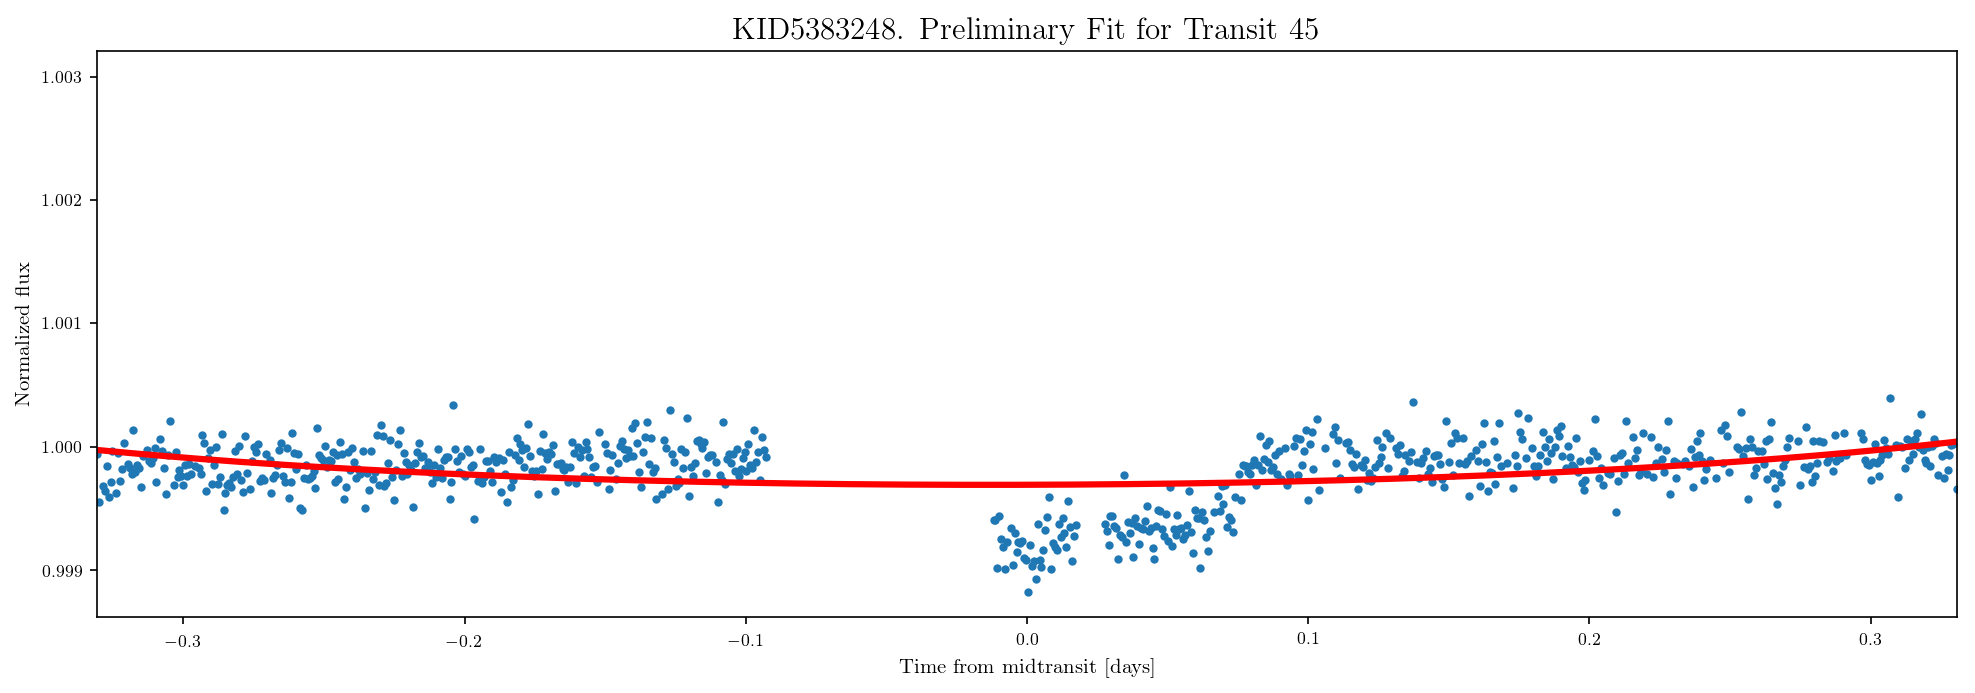

/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
  0%|          | 1/250 [00:00<00:25,  9.91it/s]

------ Pre-MCMC Results ------
	Transit duration [d]:	 Fit=1.146	True=0.165
	Period [days]:	 Fit=1364.36805934	True=16.23847733
	Impact Parameter:	 Fit=0.000000	True=0.766000
	Depth:	 Fit=0.002718	True=0.000647
	Stellar mass:	 Fit=0.945	True=0.951
	Stellar radius:	 Fit=1.274	True=1.117
	Sigma (white noise):	 Fit=0.000
	Out-of-transit flux:	 Fit=1.003

------ Prepare MCMC -------
Guess impact parameter: 2.1907036246068142e-23
Guess of Rp [in Rsun]:  0.06643794088978434
1+rp_guess/rs:  1.0521356002698494
Running burn-in


  0%|          | 0/1000 [00:00<?, ?it/s]


------ Run MCMC -------


100%|██████████| 1000/1000 [01:22<00:00, 12.10it/s]



------ Post-MCMC Results ------

Depth:
	True = 0.001
	MCMC Fit = 0.023 (+0.013,-0.011)

Impact parameter:
	True = 0.766
	MCMC Fit = 0.000 (+0.000,-0.000)

Planet radius [REarth]:
	True = 2.760
	MCMC Fit = 21.740 (+7.813,-6.667)

Period [d]:
	True = 16.238
	MCMC Fit = 20223.391 (+18896.890,-12317.282)

Inverse of scaled semi-major axis:
	True = 0.0469
	MCMC Fit = 0.0027 (+0.0005,-0.0004)

Stellar radius [Rsun]:
	True = 1.117
	MCMC Fit = 1.358 (+0.233,-0.213)

Stellar Mass [Msun]:
	True = 0.951
	MCMC Fit = 0.947 (+0.048,-0.051)
Mean acceptance fraction: 0.3677
Acceptance fraction: 36.77 %

	*TRANSIT 46
		Signal = -0.00029. Noise (rms) = 0.00017. SNR = -1.68245
		Out-of-transit error of the transit LC = 0.00017

	*TRANSIT 47
		Signal = 0.00032. Noise (rms) = 0.00017. SNR = 1.86733
		Out-of-transit error of the transit LC = 0.00017

	*TRANSIT 48
		Signal = 0.00032. Noise (rms) = 0.00016. SNR = 2.01990
		Out-of-transit error of the transit LC = 0.00016

	*TRANSIT 49
		Signal = 0.00003. No

/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in multiply
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in subtract


Optimization terminated successfully.
         Current function value: -6982.548446
         Iterations: 2232
         Function evaluations: 3363
Optimization terminated successfully.
         Current function value: -7162.568344
         Iterations: 1448
         Function evaluations: 2238


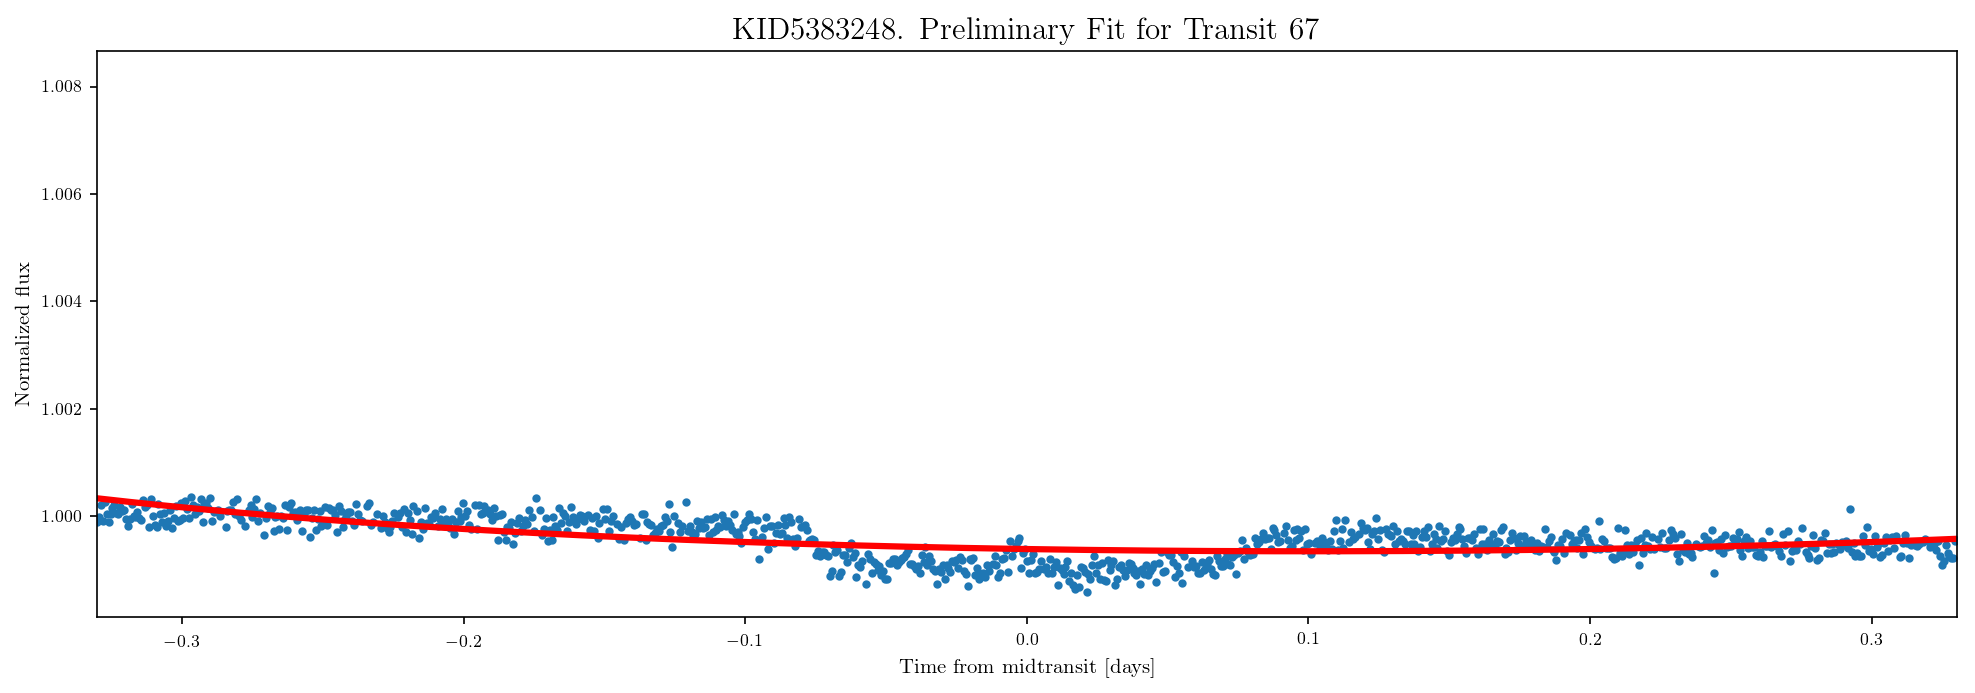

/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
  0%|          | 0/250 [00:00<?, ?it/s]

------ Pre-MCMC Results ------
	Transit duration [d]:	 Fit=1.450	True=0.165
	Period [days]:	 Fit=1067.93071728	True=16.23847733
	Impact Parameter:	 Fit=0.000000	True=0.766000
	Depth:	 Fit=0.007263	True=0.000647
	Stellar mass:	 Fit=0.947	True=0.951
	Stellar radius:	 Fit=1.698	True=1.117
	Sigma (white noise):	 Fit=0.000
	Out-of-transit flux:	 Fit=1.008

------ Prepare MCMC -------
Guess impact parameter: 8.997413692377425e-13
Guess of Rp [in Rsun]:  0.14466908948091087
1+rp_guess/rs:  1.085222873336748
Running burn-in


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/emcee-3.0.0.dev0-py3.6.egg/emcee/moves/red_blue.py:96: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - log_probs[j]
  0%|          | 0/1000 [00:00<?, ?it/s]


------ Run MCMC -------


100%|██████████| 1000/1000 [36:27<00:00,  2.19s/it]   



------ Post-MCMC Results ------

Depth:
	True = 0.001
	MCMC Fit = 0.031 (+0.012,-0.010)

Impact parameter:
	True = 0.766
	MCMC Fit = 0.000 (+0.000,-0.000)

Planet radius [REarth]:
	True = 2.760
	MCMC Fit = 31.174 (+7.725,-7.295)

Period [d]:
	True = 16.238
	MCMC Fit = 8859.098 (+5820.164,-4177.217)

Inverse of scaled semi-major axis:
	True = 0.0469
	MCMC Fit = 0.0038 (+0.0005,-0.0006)

Stellar radius [Rsun]:
	True = 1.117
	MCMC Fit = 1.616 (+0.236,-0.245)

Stellar Mass [Msun]:
	True = 0.951
	MCMC Fit = 0.941 (+0.054,-0.056)


Mean acceptance fraction: 0.32322
Acceptance fraction: 32.32 %

	*TRANSIT 71
		Signal = 0.00016. Noise (rms) = 0.00022. SNR = 0.69653
		Out-of-transit error of the transit LC = 0.00022

	*TRANSIT 72
		Signal = -0.00100. Noise (rms) = 0.00016. SNR = -6.42076
		Out-of-transit error of the transit LC = 0.00016

	*TRANSIT 74
		Signal = 0.00078. Noise (rms) = 0.00016. SNR = 4.98102
		Out-of-transit error of the transit LC = 0.00016
Max. depth (guess) = 1.03644
Depth guess = 0.00133. True depth = 0.00065


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in subtract


Optimization terminated successfully.
         Current function value: -7222.774129
         Iterations: 1372
         Function evaluations: 2124
Optimization terminated successfully.
         Current function value: -7234.804563
         Iterations: 1440
         Function evaluations: 2196


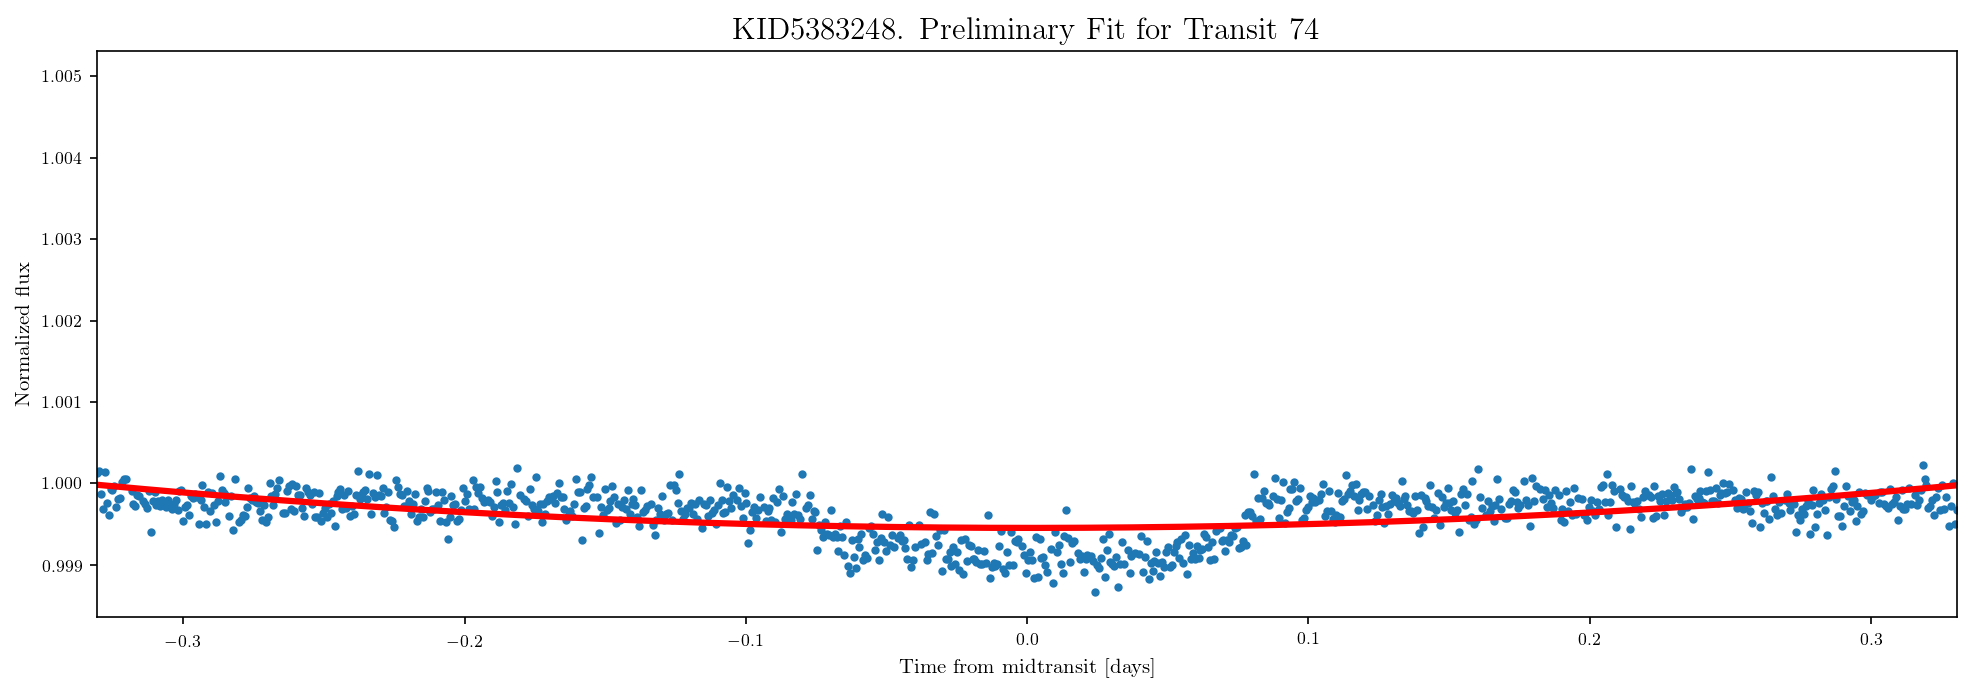

/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
  0%|          | 0/250 [00:00<?, ?it/s]

------ Pre-MCMC Results ------
	Transit duration [d]:	 Fit=5.334	True=0.165
	Period [days]:	 Fit=79068.54197075	True=16.23847733
	Impact Parameter:	 Fit=0.035775	True=0.766000
	Depth:	 Fit=0.076179	True=0.000647
	Stellar mass:	 Fit=0.949	True=0.951
	Stellar radius:	 Fit=1.266	True=1.117
	Sigma (white noise):	 Fit=0.000
	Out-of-transit flux:	 Fit=1.091

------ Prepare MCMC -------
Guess impact parameter: 0.03577519497349524
Guess of Rp [in Rsun]:  0.34945290768026566
1+rp_guess/rs:  1.2760057859482823
Running burn-in


  0%|          | 0/1000 [00:00<?, ?it/s]


------ Run MCMC -------


100%|██████████| 1000/1000 [01:50<00:00,  9.45it/s]



------ Post-MCMC Results ------

Depth:
	True = 0.001
	MCMC Fit = 0.078 (+0.017,-0.016)

Impact parameter:
	True = 0.766
	MCMC Fit = 0.042 (+0.037,-0.029)

Planet radius [REarth]:
	True = 2.760
	MCMC Fit = 38.111 (+8.643,-7.398)

Period [d]:
	True = 16.238
	MCMC Fit = 83165.288 (+49540.830,-32645.311)

Inverse of scaled semi-major axis:
	True = 0.0469
	MCMC Fit = 0.0002 (+0.0000,-0.0000)

Stellar radius [Rsun]:
	True = 1.117
	MCMC Fit = 1.263 (+0.197,-0.187)

Stellar Mass [Msun]:
	True = 0.951
	MCMC Fit = 0.943 (+0.046,-0.045)
Mean acceptance fraction: 0.26647
Acceptance fraction: 26.65 %

	*TRANSIT 75
		Signal = nan. Noise (rms) = 0.00016. SNR = nan
		Out-of-transit error of the transit LC = 0.00016

	*TRANSIT 76
		Signal = -0.00031. Noise (rms) = 0.00019. SNR = -1.67789
		Out-of-transit error of the transit LC = 0.00019

	*TRANSIT 77
		Signal = 0.00007. Noise (rms) = 0.00018. SNR = 0.41839
		Out-of-transit error of the transit LC = 0.00018

	*TRANSIT 78
		Signal = 0.00069. Noise (rm

/Users/mbadenas/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in subtract


Optimization terminated successfully.
         Current function value: -7359.739463
         Iterations: 2241
         Function evaluations: 3371
Optimization terminated successfully.
         Current function value: -7387.649415
         Iterations: 3917
         Function evaluations: 5837


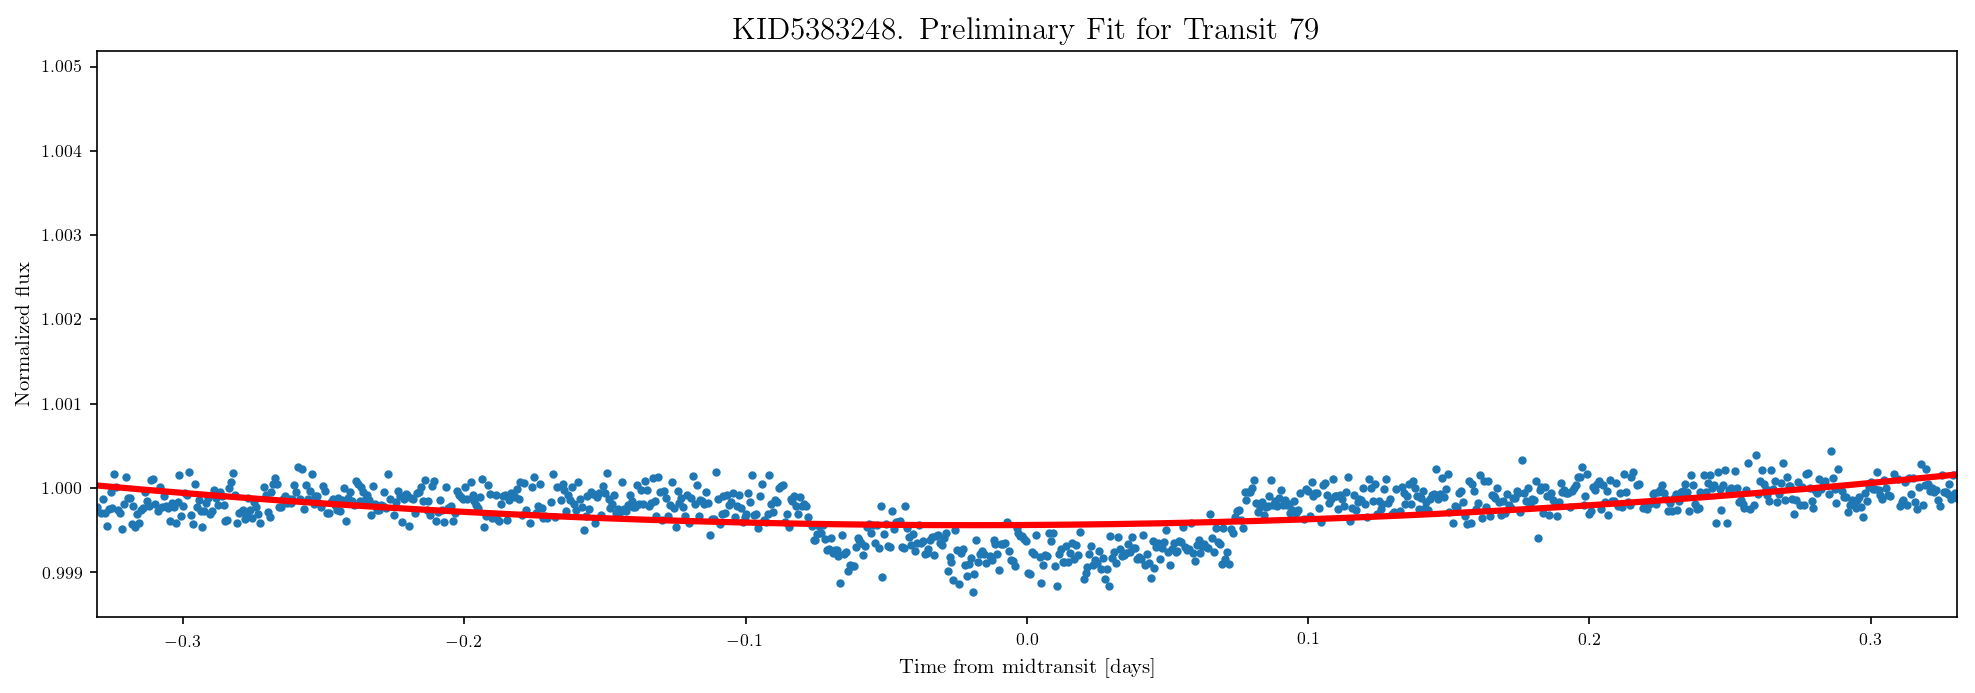

/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
  0%|          | 0/250 [00:00<?, ?it/s]

------ Pre-MCMC Results ------
	Transit duration [d]:	 Fit=12.484	True=0.165
	Period [days]:	 Fit=807652.79483189	True=16.23847733
	Impact Parameter:	 Fit=0.000000	True=0.766000
	Depth:	 Fit=0.250484	True=0.000647
	Stellar mass:	 Fit=0.950	True=0.951
	Stellar radius:	 Fit=1.162	True=1.117
	Sigma (white noise):	 Fit=0.000
	Out-of-transit flux:	 Fit=1.296

------ Prepare MCMC -------
Guess impact parameter: 1.35768426176869e-10
Guess of Rp [in Rsun]:  0.5814119512096548
1+rp_guess/rs:  1.500484181466271
Running burn-in


  0%|          | 0/1000 [00:00<?, ?it/s]


------ Run MCMC -------


100%|██████████| 1000/1000 [09:26<00:00,  9.68it/s]  



------ Post-MCMC Results ------

Depth:
	True = 0.001
	MCMC Fit = 0.247 (+0.018,-0.022)

Impact parameter:
	True = 0.766
	MCMC Fit = 0.000 (+0.000,-0.000)

Planet radius [REarth]:
	True = 2.760
	MCMC Fit = 63.056 (+10.986,-8.610)

Period [d]:
	True = 16.238
	MCMC Fit = 749397.971 (+419307.466,-242544.693)

Inverse of scaled semi-major axis:
	True = 0.0469
	MCMC Fit = 0.0000 (+0.0000,-0.0000)

Stellar radius [Rsun]:
	True = 1.117
	MCMC Fit = 1.165 (+0.194,-0.145)

Stellar Mass [Msun]:
	True = 0.951
	MCMC Fit = 0.953 (+0.051,-0.051)
Mean acceptance fraction: 0.26294000000000006
Acceptance fraction: 26.29 %

	*TRANSIT 81
		Signal = 0.00318. Noise (rms) = 0.00015. SNR = 20.55678
		Out-of-transit error of the transit LC = 0.00015
Max. depth (guess) = 1.06373
Depth guess = 0.00406. True depth = 0.00065


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in subtract


Optimization terminated successfully.
         Current function value: -7358.854368
         Iterations: 856
         Function evaluations: 1327
Optimization terminated successfully.
         Current function value: -7816.183621
         Iterations: 973
         Function evaluations: 1489


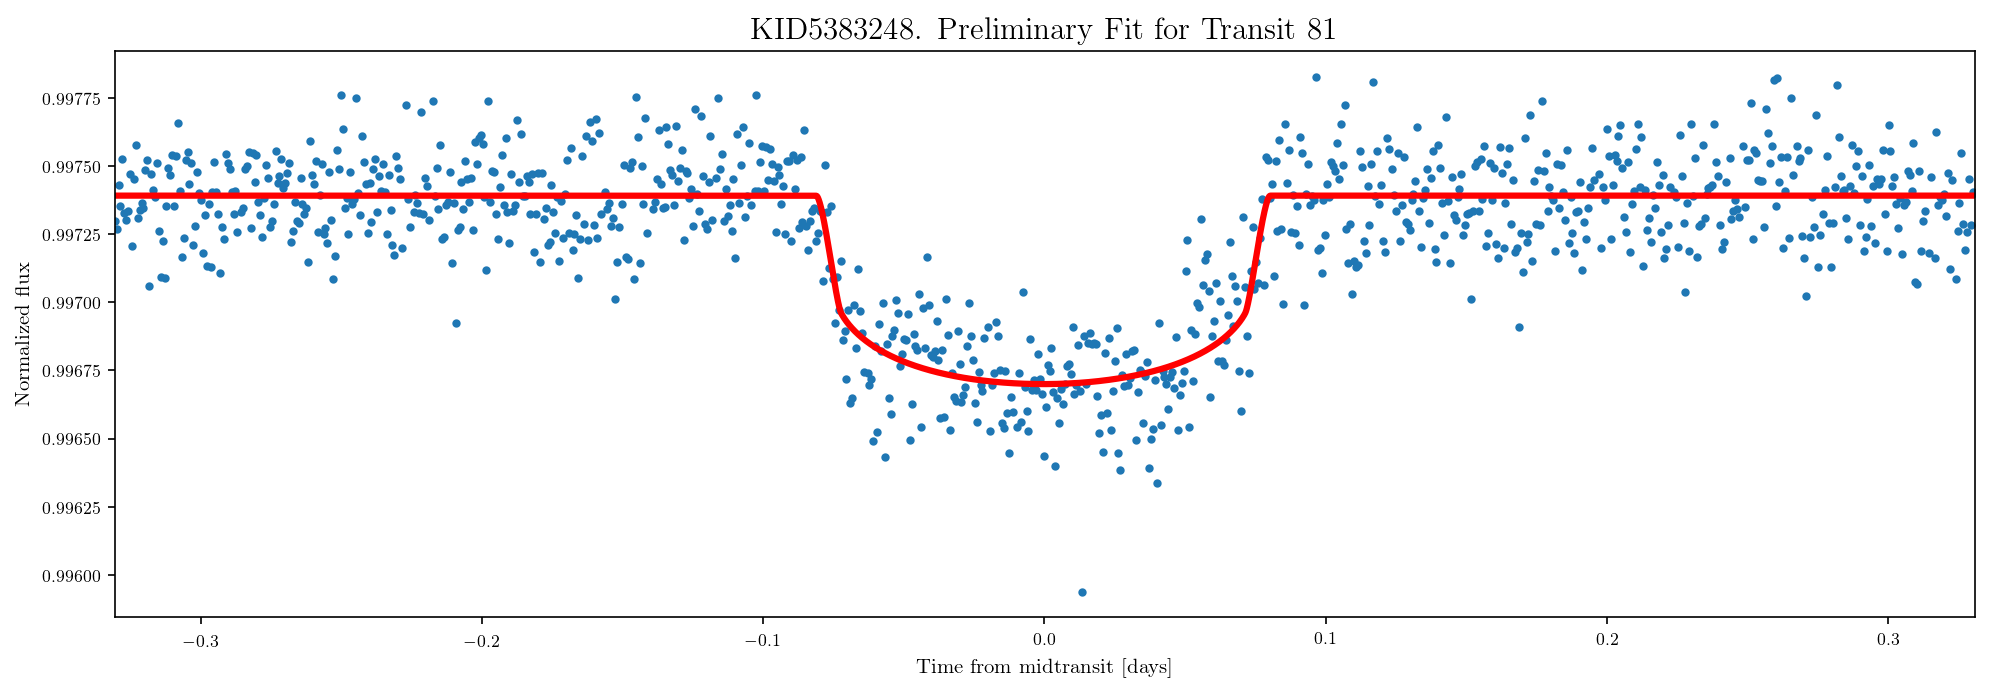

/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
  0%|          | 1/250 [00:00<00:28,  8.76it/s]

------ Pre-MCMC Results ------
	Transit duration [d]:	 Fit=0.161	True=0.165
	Period [days]:	 Fit=22.97488372	True=16.23847733
	Impact Parameter:	 Fit=0.734593	True=0.766000
	Depth:	 Fit=0.000675	True=0.000647
	Stellar mass:	 Fit=0.951	True=0.951
	Stellar radius:	 Fit=1.029	True=1.117
	Sigma (white noise):	 Fit=0.000
	Out-of-transit flux:	 Fit=0.997

------ Prepare MCMC -------
Guess impact parameter: 0.7345933665632063
Guess of Rp [in Rsun]:  0.026738517706504785
1+rp_guess/rs:  1.025978507983907
Running burn-in


  0%|          | 0/1000 [00:00<?, ?it/s]


------ Run MCMC -------


100%|██████████| 1000/1000 [07:15<00:00,  6.02it/s] 



------ Post-MCMC Results ------

Depth:
	True = 0.001
	MCMC Fit = 0.001 (+0.000,-0.000)

Impact parameter:
	True = 0.766
	MCMC Fit = 0.746 (+0.066,-0.098)

Planet radius [REarth]:
	True = 2.760
	MCMC Fit = 2.990 (+0.526,-0.445)

Period [d]:
	True = 16.238
	MCMC Fit = 21.989 (+9.854,-5.883)

Inverse of scaled semi-major axis:
	True = 0.0469
	MCMC Fit = 0.0315 (+0.0048,-0.0041)

Stellar radius [Rsun]:
	True = 1.117
	MCMC Fit = 1.053 (+0.150,-0.140)

Stellar Mass [Msun]:
	True = 0.951
	MCMC Fit = 0.946 (+0.051,-0.051)
Mean acceptance fraction: 0.29141
Acceptance fraction: 29.14 %

	*TRANSIT 82
		Signal = 0.00052. Noise (rms) = 0.00015. SNR = 3.38741
		Out-of-transit error of the transit LC = 0.00015
Max. depth (guess) = 1.03111
Depth guess = 0.00097. True depth = 0.00065


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in subtract


Optimization terminated successfully.
         Current function value: -7664.274367
         Iterations: 1848
         Function evaluations: 2791
Optimization terminated successfully.
         Current function value: -7671.355188
         Iterations: 892
         Function evaluations: 1356


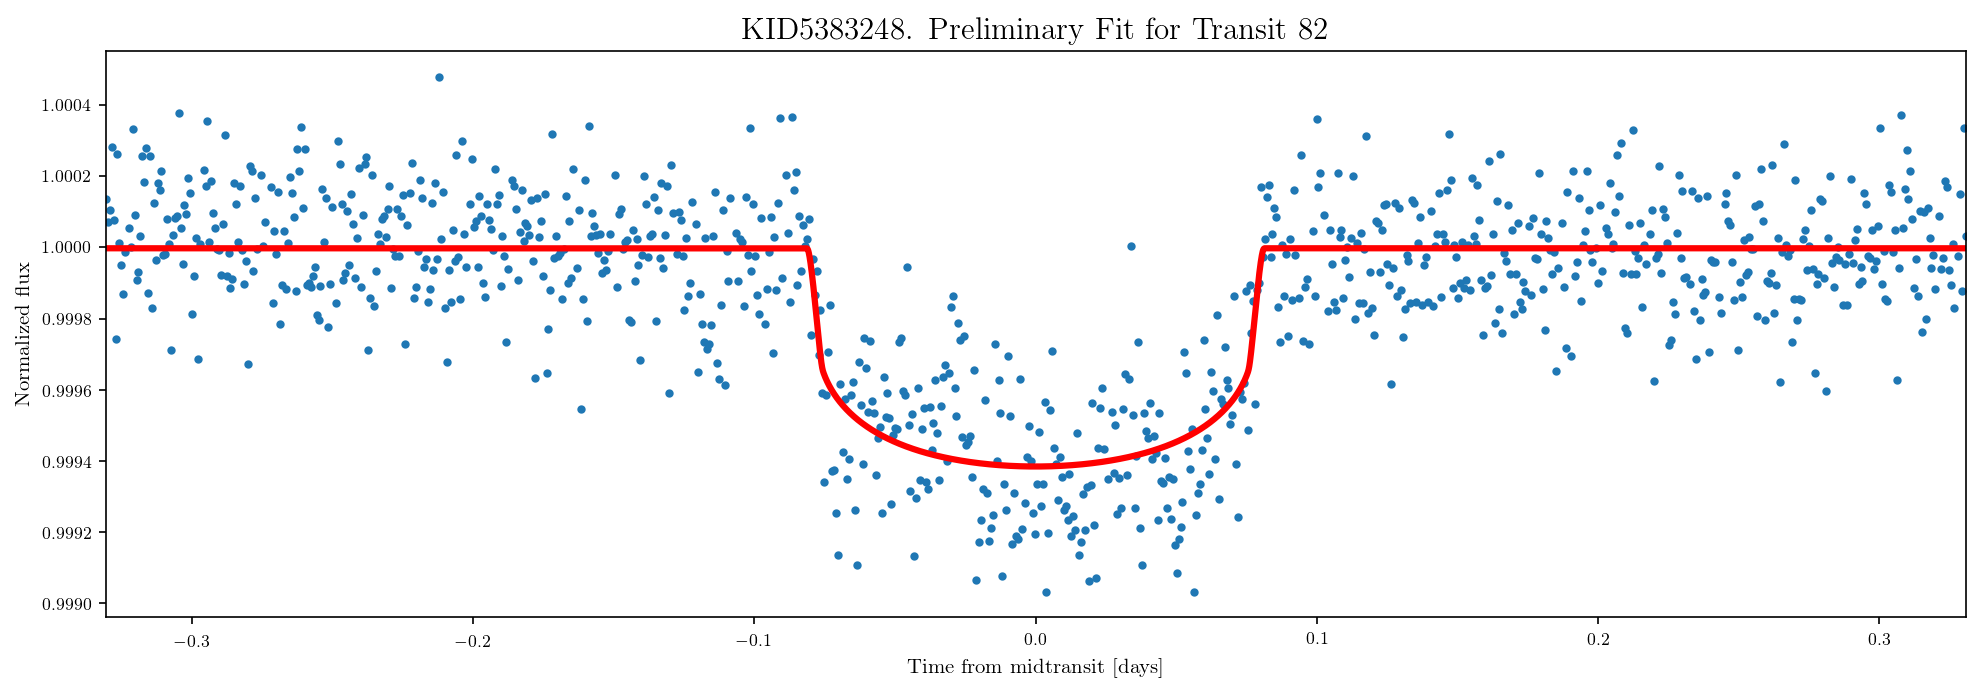

/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
  0%|          | 0/250 [00:00<?, ?it/s]

------ Pre-MCMC Results ------
	Transit duration [d]:	 Fit=0.162	True=0.165
	Period [days]:	 Fit=13.50008197	True=16.23847733
	Impact Parameter:	 Fit=0.564284	True=0.766000
	Depth:	 Fit=0.000547	True=0.000647
	Stellar mass:	 Fit=0.966	True=0.951
	Stellar radius:	 Fit=1.043	True=1.117
	Sigma (white noise):	 Fit=0.000
	Out-of-transit flux:	 Fit=1.000

------ Prepare MCMC -------
Guess impact parameter: 0.5642839727454438
Guess of Rp [in Rsun]:  0.024405443313866567
1+rp_guess/rs:  1.0233963037237934
Running burn-in


  0%|          | 0/1000 [00:00<?, ?it/s]


------ Run MCMC -------


100%|██████████| 1000/1000 [10:28<00:00, 11.06it/s] 



------ Post-MCMC Results ------

Depth:
	True = 0.001
	MCMC Fit = 0.001 (+0.000,-0.000)

Impact parameter:
	True = 0.766
	MCMC Fit = 0.620 (+0.099,-0.140)

Planet radius [REarth]:
	True = 2.760
	MCMC Fit = 2.561 (+0.393,-0.310)

Period [d]:
	True = 16.238
	MCMC Fit = 17.666 (+5.646,-3.191)

Inverse of scaled semi-major axis:
	True = 0.0469
	MCMC Fit = 0.0422 (+0.0052,-0.0043)

Stellar radius [Rsun]:
	True = 1.117
	MCMC Fit = 0.991 (+0.117,-0.103)

Stellar Mass [Msun]:
	True = 0.951
	MCMC Fit = 0.952 (+0.050,-0.050)
Mean acceptance fraction: 0.32528
Acceptance fraction: 32.53 %

	*TRANSIT 83
		Signal = -0.00047. Noise (rms) = 0.00019. SNR = -2.48274
		Out-of-transit error of the transit LC = 0.00019

	*TRANSIT 84
		Signal = -0.00056. Noise (rms) = 0.00016. SNR = -3.57697
		Out-of-transit error of the transit LC = 0.00016

	*TRANSIT 85
		Signal = -0.00083. Noise (rms) = 0.00019. SNR = -4.39830
		Out-of-transit error of the transit LC = 0.00019

******************************** KID415532

/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in subtract


Optimization terminated successfully.
         Current function value: -5222.819150
         Iterations: 1623
         Function evaluations: 2465
Optimization terminated successfully.
         Current function value: -5262.532011
         Iterations: 2906
         Function evaluations: 4285


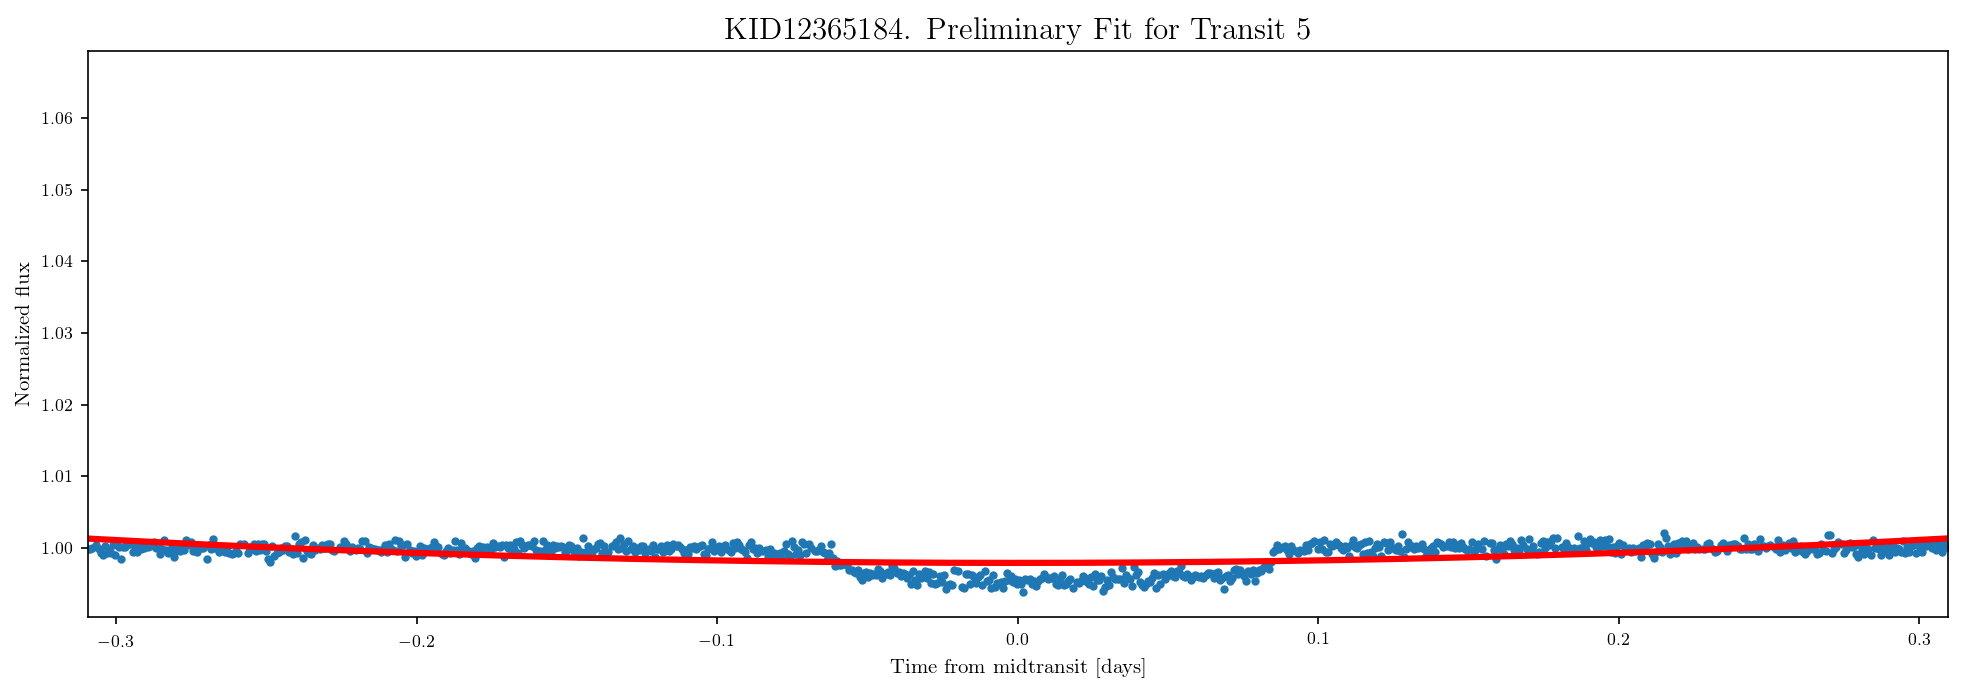

/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
  0%|          | 0/250 [00:00<?, ?it/s]

------ Pre-MCMC Results ------
	Transit duration [d]:	 Fit=7.414	True=0.155
	Period [days]:	 Fit=52813.82504571	True=69.72646639
	Impact Parameter:	 Fit=0.000000	True=0.019000
	Depth:	 Fit=0.454791	True=0.004491
	Stellar mass:	 Fit=1.394	True=1.398
	Stellar radius:	 Fit=1.744	True=1.731
	Sigma (white noise):	 Fit=0.001
	Out-of-transit flux:	 Fit=1.511

------ Prepare MCMC -------
Guess impact parameter: 5.69287543958073e-12
Guess of Rp [in Rsun]:  1.1760464046479726
1+rp_guess/rs:  1.674382236193558
Running burn-in


  0%|          | 0/1000 [00:00<?, ?it/s]


------ Run MCMC -------


100%|██████████| 1000/1000 [01:43<00:00, 10.15it/s]



------ Post-MCMC Results ------

Depth:
	True = 0.004
	MCMC Fit = 0.457 (+0.040,-0.045)

Impact parameter:
	True = 0.019
	MCMC Fit = 0.000 (+0.000,-0.000)

Planet radius [REarth]:
	True = 11.650
	MCMC Fit = 127.317 (+8.714,-8.584)

Period [d]:
	True = 69.726
	MCMC Fit = 54729.505 (+19934.649,-16020.172)

Inverse of scaled semi-major axis:
	True = 0.0066
	MCMC Fit = 0.0003 (+0.0000,-0.0000)

Stellar radius [Rsun]:
	True = 1.731
	MCMC Fit = 1.737 (+0.085,-0.093)

Stellar Mass [Msun]:
	True = 1.398
	MCMC Fit = 1.394 (+0.073,-0.072)
Mean acceptance fraction: 0.30549000000000004
Acceptance fraction: 30.55 %

	*TRANSIT 6
		Signal = 0.00388. Noise (rms) = 0.00066. SNR = 5.92327
		Out-of-transit error of the transit LC = 0.00066
Max. depth (guess) = 1.07804
Depth guess = 0.00609. True depth = 0.00449


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in subtract


Optimization terminated successfully.
         Current function value: -5247.043431
         Iterations: 1710
         Function evaluations: 2597
Optimization terminated successfully.
         Current function value: -5255.035262
         Iterations: 2552
         Function evaluations: 3778


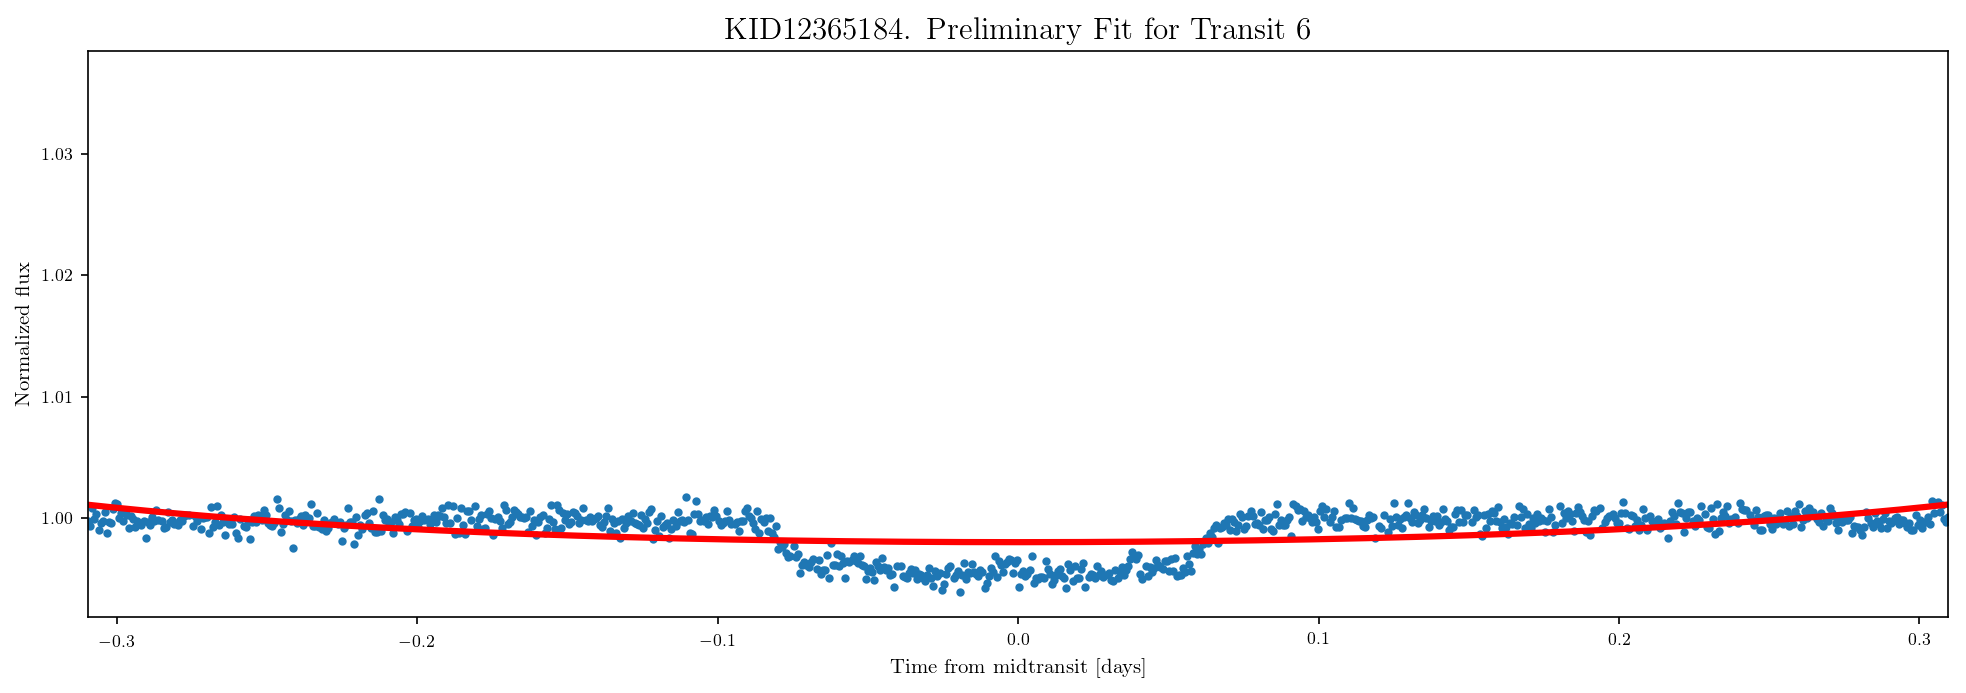

/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
  0%|          | 0/250 [00:00<?, ?it/s]

------ Pre-MCMC Results ------
	Transit duration [d]:	 Fit=1.200	True=0.155
	Period [days]:	 Fit=572.80533358	True=69.72646639
	Impact Parameter:	 Fit=0.000000	True=0.019000
	Depth:	 Fit=0.032633	True=0.004491
	Stellar mass:	 Fit=1.381	True=1.398
	Stellar radius:	 Fit=1.803	True=1.731
	Sigma (white noise):	 Fit=0.001
	Out-of-transit flux:	 Fit=1.036

------ Prepare MCMC -------
Guess impact parameter: 2.985730966954517e-24
Guess of Rp [in Rsun]:  0.3257142999618613
1+rp_guess/rs:  1.1806463699114371
Running burn-in


  0%|          | 0/1000 [00:00<?, ?it/s]


------ Run MCMC -------


100%|██████████| 1000/1000 [01:43<00:00,  9.66it/s]



------ Post-MCMC Results ------

Depth:
	True = 0.004
	MCMC Fit = 0.172 (+0.040,-0.036)

Impact parameter:
	True = 0.019
	MCMC Fit = 0.000 (+0.000,-0.000)

Planet radius [REarth]:
	True = 11.650
	MCMC Fit = 79.471 (+9.687,-10.105)

Period [d]:
	True = 69.726
	MCMC Fit = 6741.012 (+3336.726,-2439.935)

Inverse of scaled semi-major axis:
	True = 0.0066
	MCMC Fit = 0.0054 (+0.0003,-0.0003)

Stellar radius [Rsun]:
	True = 1.731
	MCMC Fit = 1.760 (+0.083,-0.085)

Stellar Mass [Msun]:
	True = 1.398
	MCMC Fit = 1.388 (+0.077,-0.072)
Mean acceptance fraction: 0.39022
Acceptance fraction: 39.02 %

	*TRANSIT 7
		Signal = 0.00249. Noise (rms) = 0.00107. SNR = 2.33487
		Out-of-transit error of the transit LC = 0.00107

	*TRANSIT 8
		Signal = nan. Noise (rms) = 0.00066. SNR = nan
		Out-of-transit error of the transit LC = 0.00066

	*TRANSIT 9
		Signal = 0.00263. Noise (rms) = 0.00165. SNR = 1.59230
		Out-of-transit error of the transit LC = 0.00165

	*TRANSIT 10
		Signal = 0.00259. Noise (rms) = 0

/Users/mbadenas/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in subtract


Optimization terminated successfully.
         Current function value: -5265.179176
         Iterations: 3416
         Function evaluations: 5108
Optimization terminated successfully.
         Current function value: -5271.378664
         Iterations: 4035
         Function evaluations: 5916


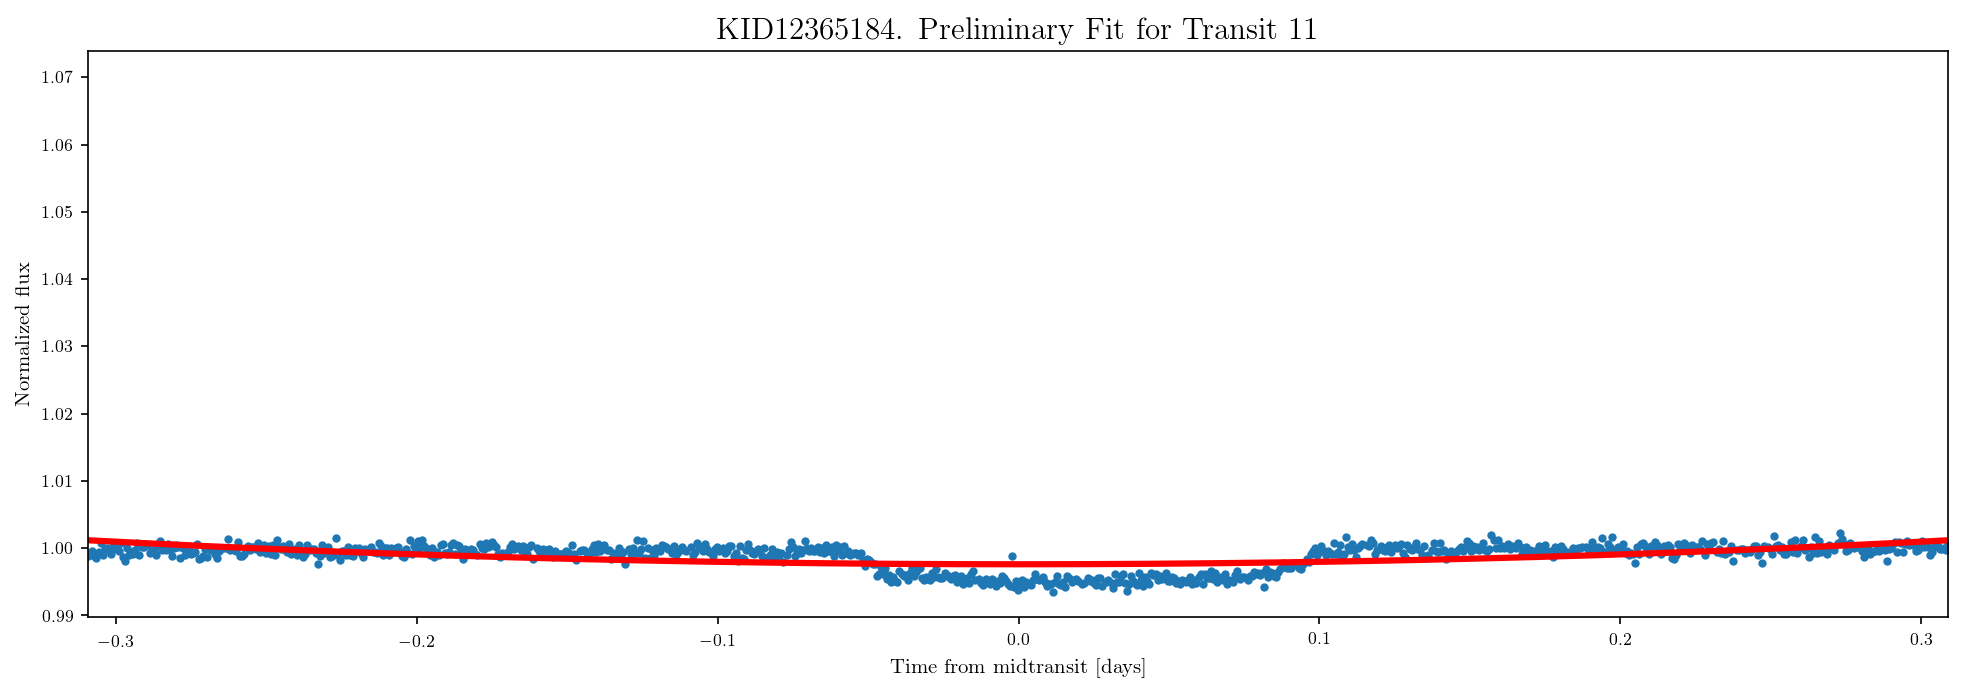

/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
  0%|          | 0/250 [00:00<?, ?it/s]

------ Pre-MCMC Results ------
	Transit duration [d]:	 Fit=7.261	True=0.155
	Period [days]:	 Fit=49518.24942730	True=69.72646639
	Impact Parameter:	 Fit=0.000000	True=0.019000
	Depth:	 Fit=0.456035	True=0.004491
	Stellar mass:	 Fit=1.394	True=1.398
	Stellar radius:	 Fit=1.744	True=1.731
	Sigma (white noise):	 Fit=0.001
	Out-of-transit flux:	 Fit=1.512

------ Prepare MCMC -------
Guess impact parameter: 9.610611864326583e-11
Guess of Rp [in Rsun]:  1.1776532315680144
1+rp_guess/rs:  1.675303836851286
Running burn-in


  0%|          | 1/1000 [00:00<01:55,  8.67it/s]


------ Run MCMC -------


100%|██████████| 1000/1000 [01:43<00:00,  9.67it/s]



------ Post-MCMC Results ------

Depth:
	True = 0.004
	MCMC Fit = 0.458 (+0.040,-0.044)

Impact parameter:
	True = 0.019
	MCMC Fit = 0.000 (+0.000,-0.000)

Planet radius [REarth]:
	True = 11.650
	MCMC Fit = 127.804 (+8.626,-9.701)

Period [d]:
	True = 69.726
	MCMC Fit = 52472.087 (+16928.477,-13534.493)

Inverse of scaled semi-major axis:
	True = 0.0066
	MCMC Fit = 0.0003 (+0.0000,-0.0000)

Stellar radius [Rsun]:
	True = 1.731
	MCMC Fit = 1.729 (+0.088,-0.088)

Stellar Mass [Msun]:
	True = 1.398
	MCMC Fit = 1.397 (+0.079,-0.077)
Mean acceptance fraction: 0.3174
Acceptance fraction: 31.74 %

	*TRANSIT 12
		Signal = 0.00356. Noise (rms) = 0.00068. SNR = 5.23411
		Out-of-transit error of the transit LC = 0.00068
Max. depth (guess) = 1.07810
Depth guess = 0.00610. True depth = 0.00449


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in subtract


Optimization terminated successfully.
         Current function value: -5269.021265
         Iterations: 1621
         Function evaluations: 2499
Optimization terminated successfully.
         Current function value: -5273.942953
         Iterations: 2664
         Function evaluations: 3951


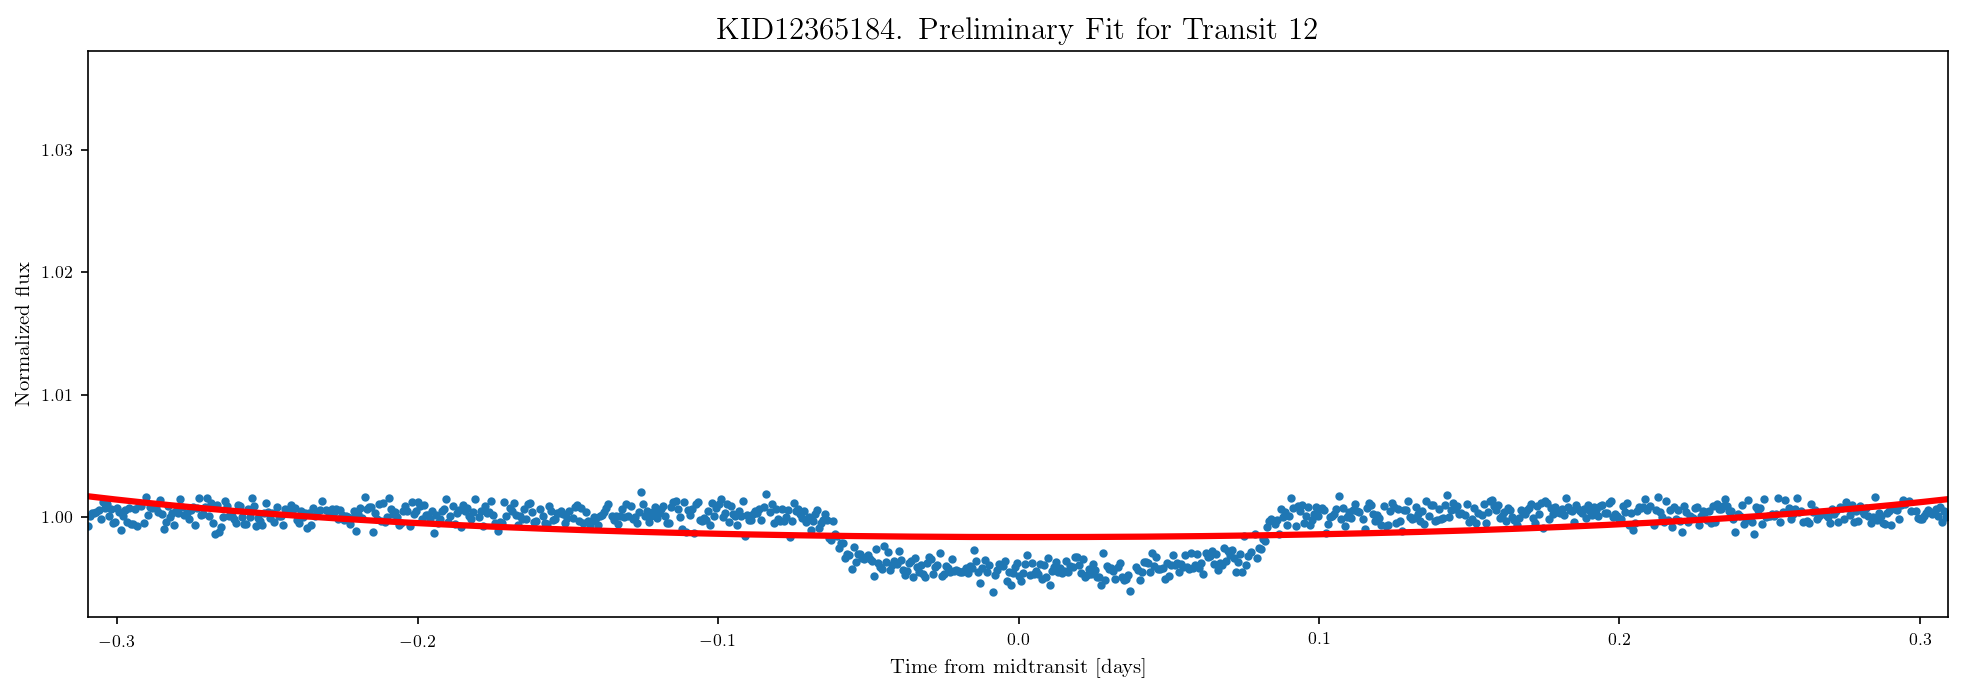

/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
  0%|          | 0/250 [00:00<?, ?it/s]

------ Pre-MCMC Results ------
	Transit duration [d]:	 Fit=1.172	True=0.155
	Period [days]:	 Fit=587.04064473	True=69.72646639
	Impact Parameter:	 Fit=0.000000	True=0.019000
	Depth:	 Fit=0.031962	True=0.004491
	Stellar mass:	 Fit=1.388	True=1.398
	Stellar radius:	 Fit=1.752	True=1.731
	Sigma (white noise):	 Fit=0.001
	Out-of-transit flux:	 Fit=1.036

------ Prepare MCMC -------
Guess impact parameter: 3.599268875370378e-20
Guess of Rp [in Rsun]:  0.3132874103435621
1+rp_guess/rs:  1.1787798036581374
Running burn-in


  0%|          | 0/1000 [00:00<?, ?it/s]


------ Run MCMC -------


100%|██████████| 1000/1000 [01:46<00:00,  9.40it/s]



------ Post-MCMC Results ------

Depth:
	True = 0.004
	MCMC Fit = 0.183 (+0.044,-0.045)

Impact parameter:
	True = 0.019
	MCMC Fit = 0.000 (+0.000,-0.000)

Planet radius [REarth]:
	True = 11.650
	MCMC Fit = 81.711 (+10.201,-11.590)

Period [d]:
	True = 69.726
	MCMC Fit = 6747.456 (+3707.834,-2628.080)

Inverse of scaled semi-major axis:
	True = 0.0066
	MCMC Fit = 0.0053 (+0.0003,-0.0003)

Stellar radius [Rsun]:
	True = 1.731
	MCMC Fit = 1.762 (+0.085,-0.090)

Stellar Mass [Msun]:
	True = 1.398
	MCMC Fit = 1.395 (+0.072,-0.077)
Mean acceptance fraction: 0.38770999999999994
Acceptance fraction: 38.77 %

	*TRANSIT 13
		Signal = 0.00410. Noise (rms) = 0.00068. SNR = 6.04253
		Out-of-transit error of the transit LC = 0.00068
Max. depth (guess) = 1.07879
Depth guess = 0.00621. True depth = 0.00449


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in subtract


Optimization terminated successfully.
         Current function value: -5266.974658
         Iterations: 2844
         Function evaluations: 4187
Optimization terminated successfully.
         Current function value: -5273.198797
         Iterations: 1369
         Function evaluations: 2055


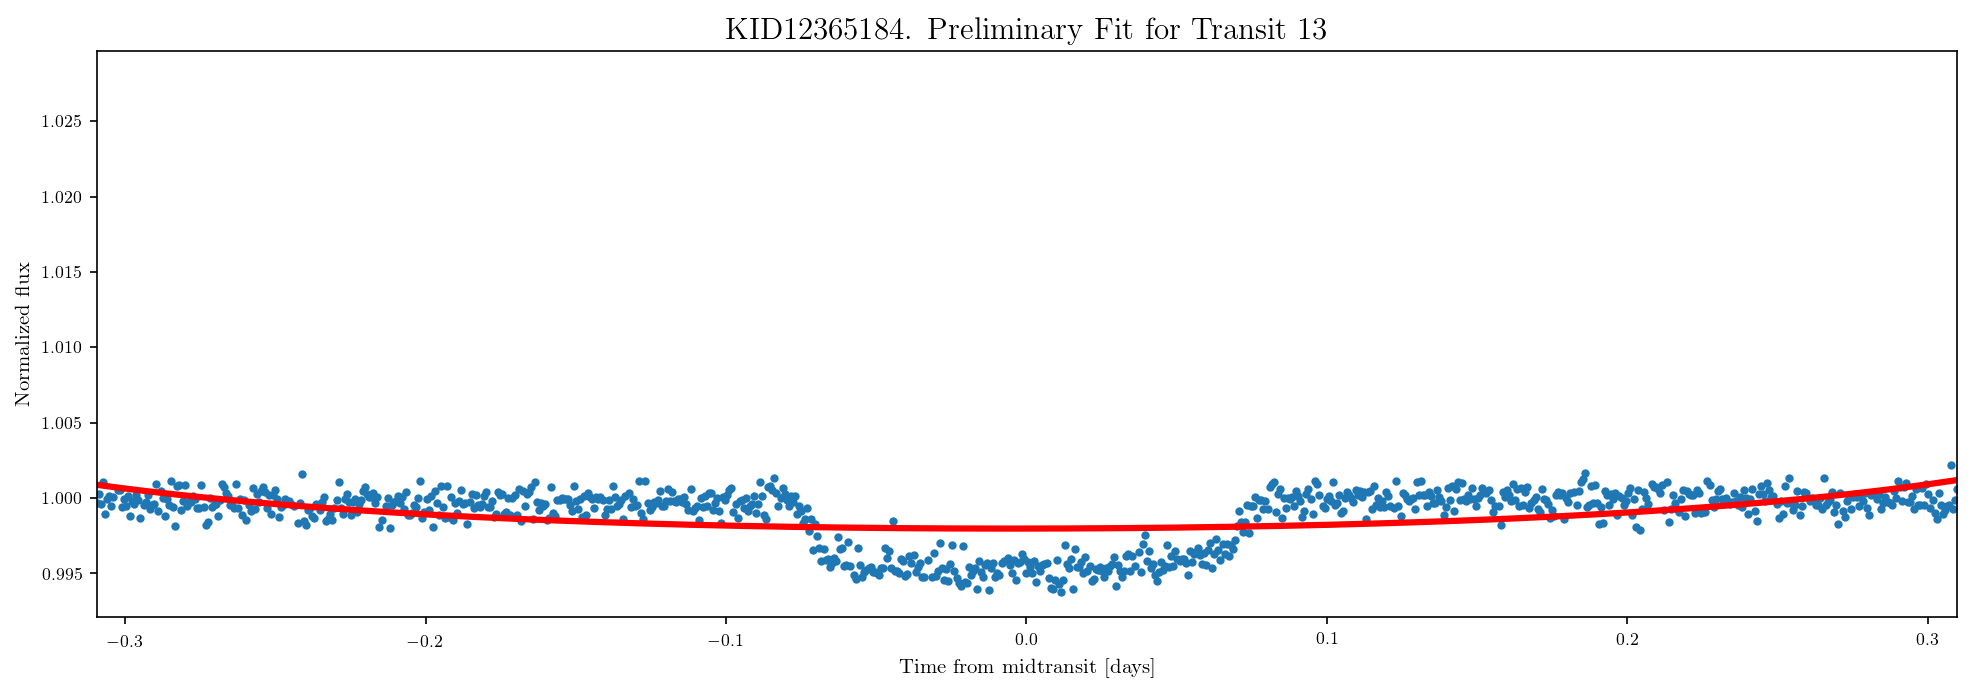

/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
  0%|          | 0/250 [00:00<?, ?it/s]

------ Pre-MCMC Results ------
	Transit duration [d]:	 Fit=1.078	True=0.155
	Period [days]:	 Fit=501.34675695	True=69.72646639
	Impact Parameter:	 Fit=0.000000	True=0.019000
	Depth:	 Fit=0.025463	True=0.004491
	Stellar mass:	 Fit=1.395	True=1.398
	Stellar radius:	 Fit=1.729	True=1.731
	Sigma (white noise):	 Fit=0.001
	Out-of-transit flux:	 Fit=1.028

------ Prepare MCMC -------
Guess impact parameter: 1.0790311762845845e-15
Guess of Rp [in Rsun]:  0.2759301815980435
1+rp_guess/rs:  1.1595723539601623
Running burn-in


  0%|          | 0/1000 [00:00<?, ?it/s]


------ Run MCMC -------


100%|██████████| 1000/1000 [01:46<00:00,  9.61it/s]



------ Post-MCMC Results ------

Depth:
	True = 0.004
	MCMC Fit = 0.175 (+0.038,-0.042)

Impact parameter:
	True = 0.019
	MCMC Fit = 0.000 (+0.000,-0.000)

Planet radius [REarth]:
	True = 11.650
	MCMC Fit = 79.644 (+9.820,-10.296)

Period [d]:
	True = 69.726
	MCMC Fit = 6650.180 (+3169.897,-2532.159)

Inverse of scaled semi-major axis:
	True = 0.0066
	MCMC Fit = 0.0059 (+0.0003,-0.0003)

Stellar radius [Rsun]:
	True = 1.731
	MCMC Fit = 1.758 (+0.086,-0.087)

Stellar Mass [Msun]:
	True = 1.398
	MCMC Fit = 1.385 (+0.076,-0.070)
Mean acceptance fraction: 0.39149999999999996
Acceptance fraction: 39.15 %

	*TRANSIT 14
		Signal = 0.00346. Noise (rms) = 0.00073. SNR = 4.73376
		Out-of-transit error of the transit LC = 0.00073
Max. depth (guess) = 1.07632
Depth guess = 0.00582. True depth = 0.00449


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in subtract


Optimization terminated successfully.
         Current function value: -5294.310935
         Iterations: 1630
         Function evaluations: 2443
Optimization terminated successfully.
         Current function value: -5327.889978
         Iterations: 1887
         Function evaluations: 2846


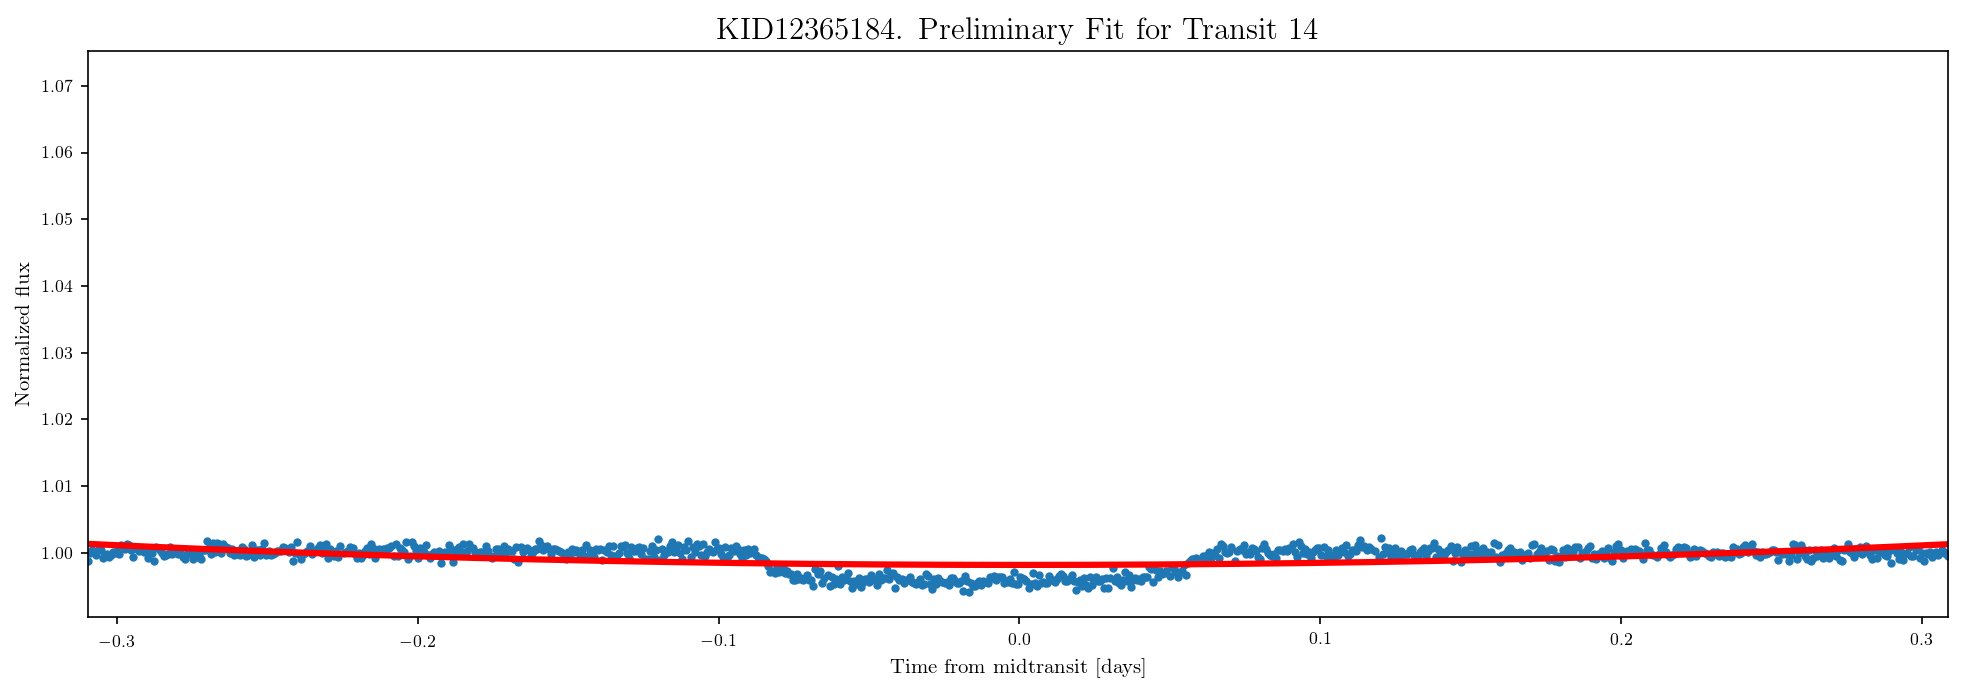

/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
  0%|          | 0/250 [00:00<?, ?it/s]

------ Pre-MCMC Results ------
	Transit duration [d]:	 Fit=4.828	True=0.155
	Period [days]:	 Fit=18378.30777887	True=69.72646639
	Impact Parameter:	 Fit=0.000000	True=0.019000
	Depth:	 Fit=0.282588	True=0.004491
	Stellar mass:	 Fit=1.389	True=1.398
	Stellar radius:	 Fit=1.763	True=1.731
	Sigma (white noise):	 Fit=0.001
	Out-of-transit flux:	 Fit=1.323

------ Prepare MCMC -------
Guess impact parameter: 8.644181744674165e-22
Guess of Rp [in Rsun]:  0.9370857601057401
1+rp_guess/rs:  1.5315897354981955
Running burn-in


  0%|          | 0/1000 [00:00<?, ?it/s]


------ Run MCMC -------


100%|██████████| 1000/1000 [02:00<00:00,  8.33it/s]



------ Post-MCMC Results ------

Depth:
	True = 0.004
	MCMC Fit = 0.322 (+0.040,-0.052)

Impact parameter:
	True = 0.019
	MCMC Fit = 0.000 (+0.000,-0.000)

Planet radius [REarth]:
	True = 11.650
	MCMC Fit = 106.177 (+9.654,-10.130)

Period [d]:
	True = 69.726
	MCMC Fit = 26808.962 (+9446.248,-8857.535)

Inverse of scaled semi-major axis:
	True = 0.0066
	MCMC Fit = 0.0005 (+0.0000,-0.0000)

Stellar radius [Rsun]:
	True = 1.731
	MCMC Fit = 1.734 (+0.084,-0.091)

Stellar Mass [Msun]:
	True = 1.398
	MCMC Fit = 1.406 (+0.073,-0.069)
Mean acceptance fraction: 0.31946
Acceptance fraction: 31.95 %

	*TRANSIT 15
		Signal = 0.00289. Noise (rms) = 0.00111. SNR = 2.60324
		Out-of-transit error of the transit LC = 0.00111

******************************** KID2853093 ********************************

	*TRANSIT 1
		Signal = 0.00354. Noise (rms) = 0.00275. SNR = 1.28815
		Out-of-transit error of the transit LC = 0.00275

******************************** KID11802615 ********************************

	

/Users/mbadenas/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in subtract


Optimization terminated successfully.
         Current function value: -7396.954170
         Iterations: 1946
         Function evaluations: 2866
Optimization terminated successfully.
         Current function value: -7400.190634
         Iterations: 2062
         Function evaluations: 2994


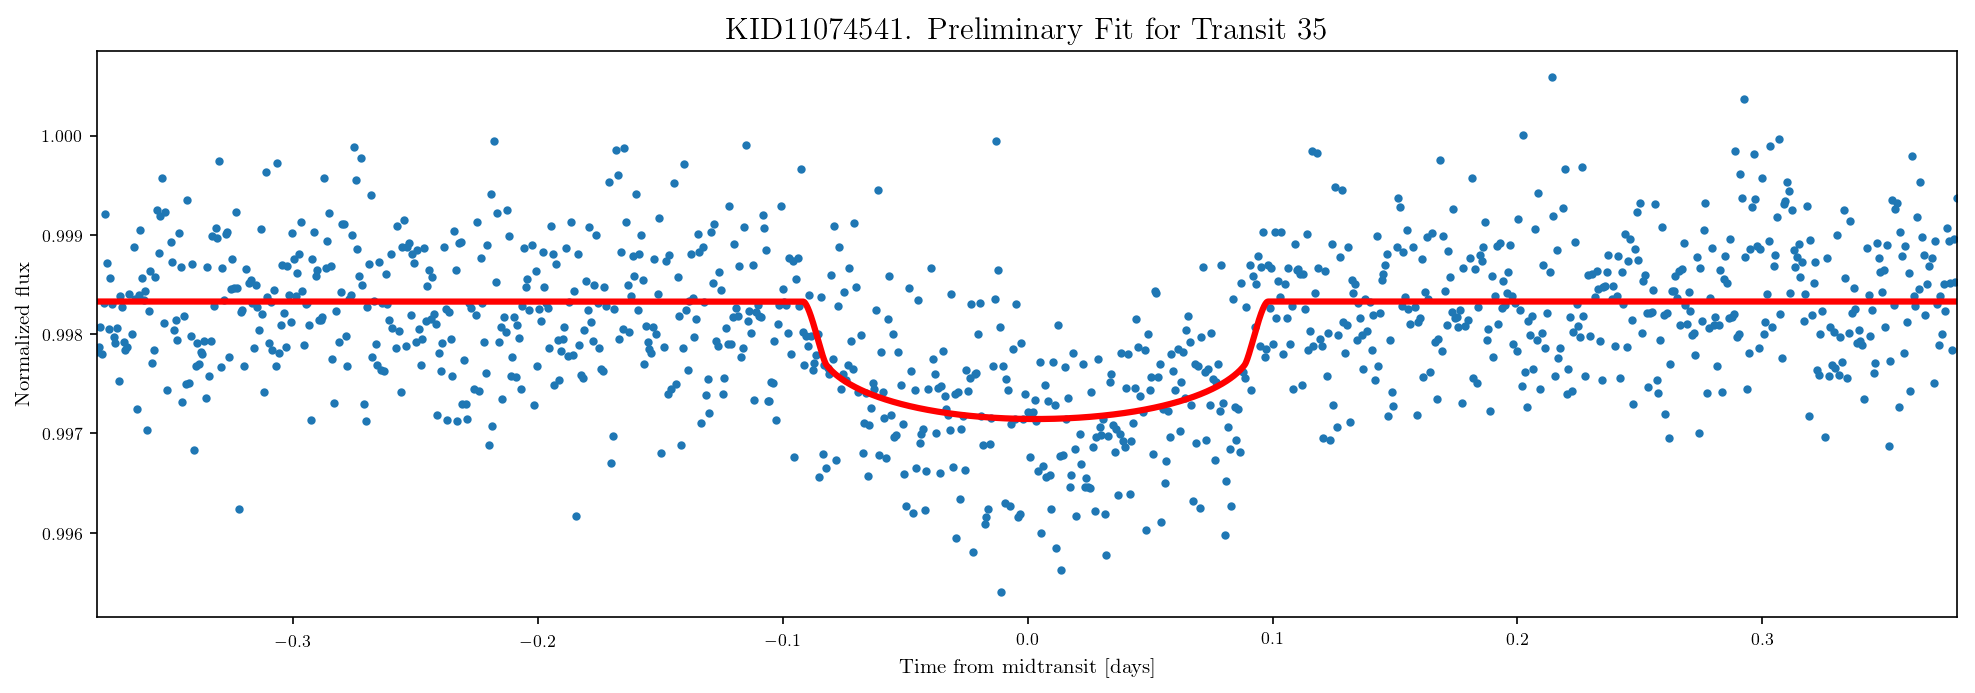

/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
  0%|          | 0/250 [00:00<?, ?it/s]

------ Pre-MCMC Results ------
	Transit duration [d]:	 Fit=0.190	True=0.190
	Period [days]:	 Fit=23.14021299	True=29.88487723
	Impact Parameter:	 Fit=0.604703	True=0.658000
	Depth:	 Fit=0.001056	True=0.001276
	Stellar mass:	 Fit=0.724	True=0.725
	Stellar radius:	 Fit=0.944	True=0.830
	Sigma (white noise):	 Fit=0.000
	Out-of-transit flux:	 Fit=0.998

------ Prepare MCMC -------
Guess impact parameter: 0.6047025481705703
Guess of Rp [in Rsun]:  0.030664520139762473
1+rp_guess/rs:  1.0324930121820026
Running burn-in


  0%|          | 0/1000 [00:00<?, ?it/s]


------ Run MCMC -------


100%|██████████| 1000/1000 [01:47<00:00,  9.29it/s]



------ Post-MCMC Results ------

Depth:
	True = 0.001
	MCMC Fit = 0.001 (+0.000,-0.000)

Impact parameter:
	True = 0.658
	MCMC Fit = 0.552 (+0.183,-0.305)

Planet radius [REarth]:
	True = 2.810
	MCMC Fit = 2.980 (+0.831,-0.494)

Period [d]:
	True = 29.885
	MCMC Fit = 25.691 (+18.327,-8.669)

Inverse of scaled semi-major axis:
	True = 0.0251
	MCMC Fit = 0.0281 (+0.0057,-0.0045)

Stellar radius [Rsun]:
	True = 0.830
	MCMC Fit = 0.863 (+0.173,-0.139)

Stellar Mass [Msun]:
	True = 0.725
	MCMC Fit = 0.727 (+0.035,-0.036)
Mean acceptance fraction: 0.28891
Acceptance fraction: 28.89 %

******************************** KID10528068 ********************************

	*TRANSIT 1
		Signal = 0.00070. Noise (rms) = 0.00047. SNR = 1.46562
		Out-of-transit error of the transit LC = 0.00047

******************************** KID7761545 ********************************

******************************** KID6504954 ********************************

	*TRANSIT 1
		Signal = 0.00433. Noise (rms) = 0.00202. SN

/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in subtract


Optimization terminated successfully.
         Current function value: -12836.268214
         Iterations: 1831
         Function evaluations: 2710
Optimization terminated successfully.
         Current function value: -12902.568843
         Iterations: 1400
         Function evaluations: 2093


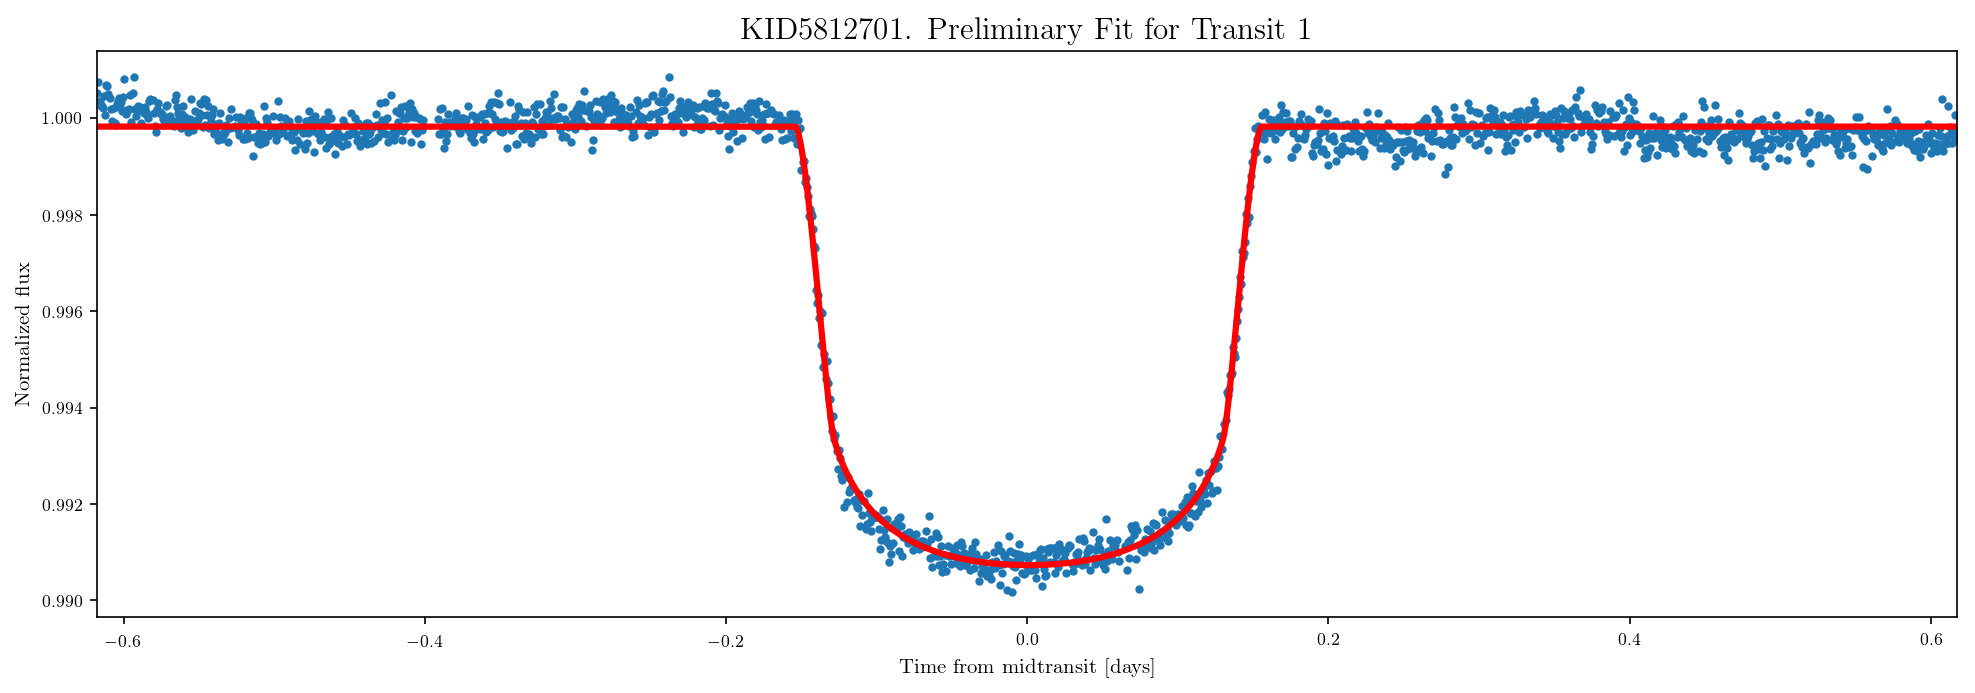

------ Pre-MCMC Results ------
	Transit duration [d]:	 Fit=0.309	True=0.309
	Period [days]:	 Fit=16.83211046	True=17.85522168
	Impact Parameter:	 Fit=0.000001	True=0.075000
	Depth:	 Fit=0.007773	True=0.009065
	Stellar mass:	 Fit=1.383	True=1.386
	Stellar radius:	 Fit=1.633	True=1.631
	Sigma (white noise):	 Fit=0.000
	Out-of-transit flux:	 Fit=1.000

------ Prepare MCMC -------
Guess impact parameter: 7.907067292291537e-07
Guess of Rp [in Rsun]:  0.14400850557192382
1+rp_guess/rs:  1.0881633448404124
Running burn-in


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
100%|██████████| 250/250 [00:58<00:00,  4.96it/s]



------ Run MCMC -------


100%|██████████| 1000/1000 [35:50<00:00,  4.98it/s]    



------ Post-MCMC Results ------

Depth:
	True = 0.009
	MCMC Fit = 0.008 (+0.000,-0.000)

Impact parameter:
	True = 0.075
	MCMC Fit = 0.000 (+0.001,-0.000)

Planet radius [REarth]:
	True = 13.160
	MCMC Fit = 15.644 (+0.370,-0.389)

Period [d]:
	True = 17.855
	MCMC Fit = 17.113 (+1.674,-1.458)

Inverse of scaled semi-major axis:
	True = 0.0500
	MCMC Fit = 0.0528 (+0.0016,-0.0016)

Stellar radius [Rsun]:
	True = 1.631
	MCMC Fit = 1.627 (+0.038,-0.041)

Stellar Mass [Msun]:
	True = 1.386
	MCMC Fit = 1.390 (+0.074,-0.069)
Mean acceptance fraction: 0.39453000000000005
Acceptance fraction: 39.45 %

	*TRANSIT 5
		Signal = 0.00836. Noise (rms) = 0.00045. SNR = 18.71609
		Out-of-transit error of the transit LC = 0.00045
Max. depth (guess) = 1.09763
Depth guess = 0.00953. True depth = 0.00907


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in subtract


Optimization terminated successfully.
         Current function value: -11755.892618
         Iterations: 1788
         Function evaluations: 2636
Optimization terminated successfully.
         Current function value: -11745.675174
         Iterations: 1321
         Function evaluations: 1954


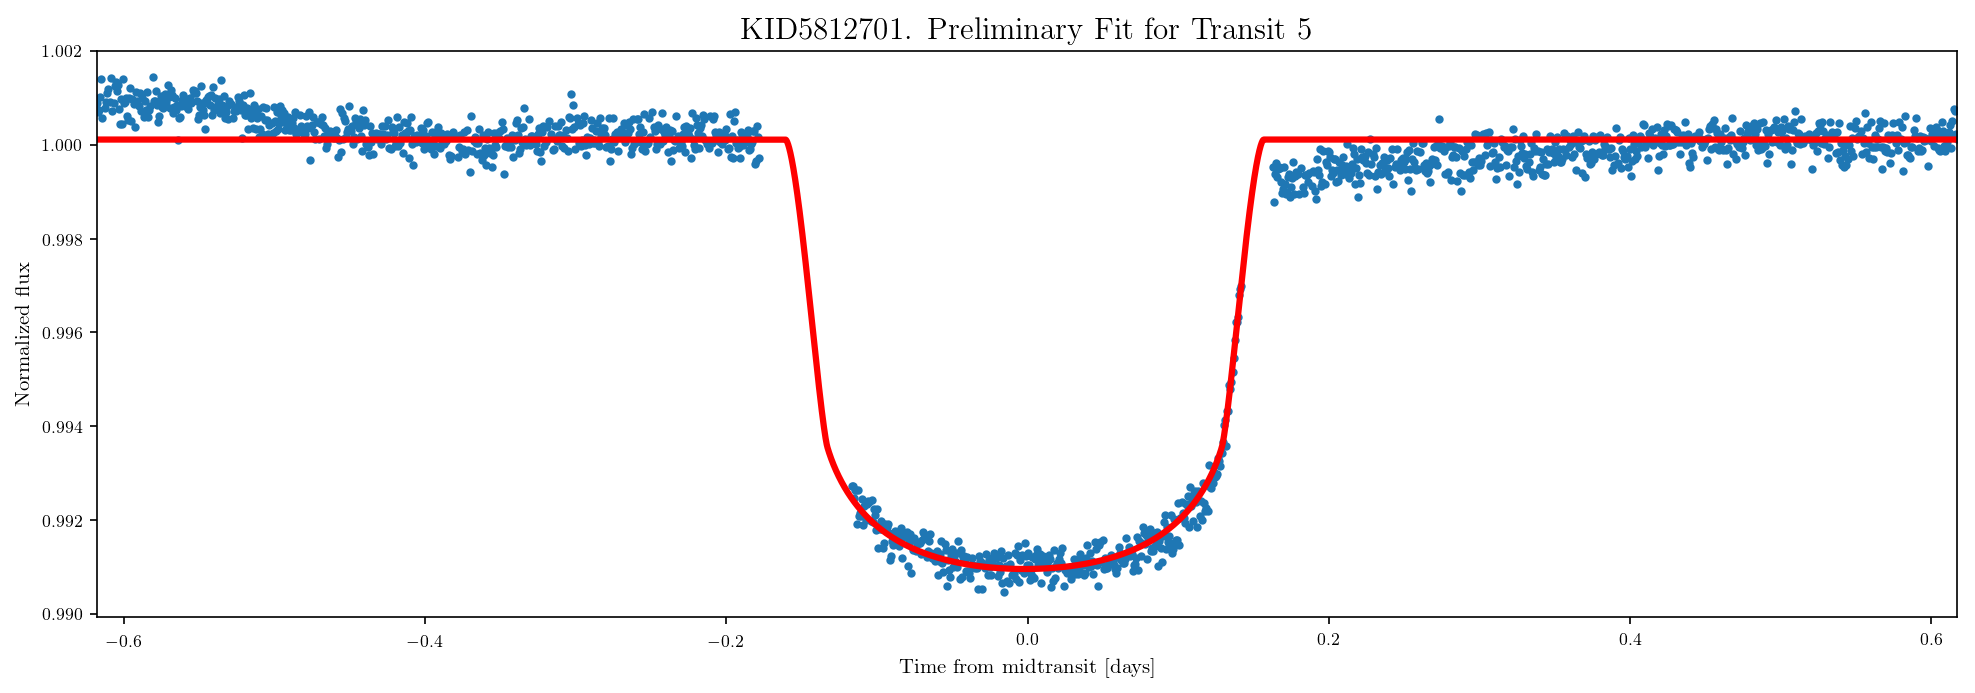

/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
  0%|          | 0/250 [00:00<?, ?it/s]

------ Pre-MCMC Results ------
	Transit duration [d]:	 Fit=0.317	True=0.309
	Period [days]:	 Fit=19.64580085	True=17.85522168
	Impact Parameter:	 Fit=0.252622	True=0.075000
	Depth:	 Fit=0.007905	True=0.009065
	Stellar mass:	 Fit=1.377	True=1.386
	Stellar radius:	 Fit=1.633	True=1.631
	Sigma (white noise):	 Fit=0.000
	Out-of-transit flux:	 Fit=1.000

------ Prepare MCMC -------
Guess impact parameter: 0.25262238232493295
Guess of Rp [in Rsun]:  0.14517405538095982
1+rp_guess/rs:  1.0889073171004784
Running burn-in


  0%|          | 0/1000 [00:00<?, ?it/s]


------ Run MCMC -------


100%|██████████| 1000/1000 [30:04<00:00,  5.82it/s]  



------ Post-MCMC Results ------

Depth:
	True = 0.009
	MCMC Fit = 0.008 (+0.000,-0.000)

Impact parameter:
	True = 0.075
	MCMC Fit = 0.163 (+0.105,-0.097)

Planet radius [REarth]:
	True = 13.160
	MCMC Fit = 15.781 (+0.348,-0.353)

Period [d]:
	True = 17.855
	MCMC Fit = 18.128 (+2.069,-1.723)

Inverse of scaled semi-major axis:
	True = 0.0500
	MCMC Fit = 0.0478 (+0.0014,-0.0013)

Stellar radius [Rsun]:
	True = 1.631
	MCMC Fit = 1.630 (+0.035,-0.036)

Stellar Mass [Msun]:
	True = 1.386
	MCMC Fit = 1.386 (+0.066,-0.070)
Mean acceptance fraction: 0.36697
Acceptance fraction: 36.70 %

	*TRANSIT 6
		Signal = 0.00764. Noise (rms) = 0.00034. SNR = 22.60210
		Out-of-transit error of the transit LC = 0.00034
Max. depth (guess) = 1.09847
Depth guess = 0.00970. True depth = 0.00907


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in multiply
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in subtract


Optimization terminated successfully.
         Current function value: -12742.632553
         Iterations: 2642
         Function evaluations: 3858
Optimization terminated successfully.
         Current function value: -12894.844402
         Iterations: 2535
         Function evaluations: 3698


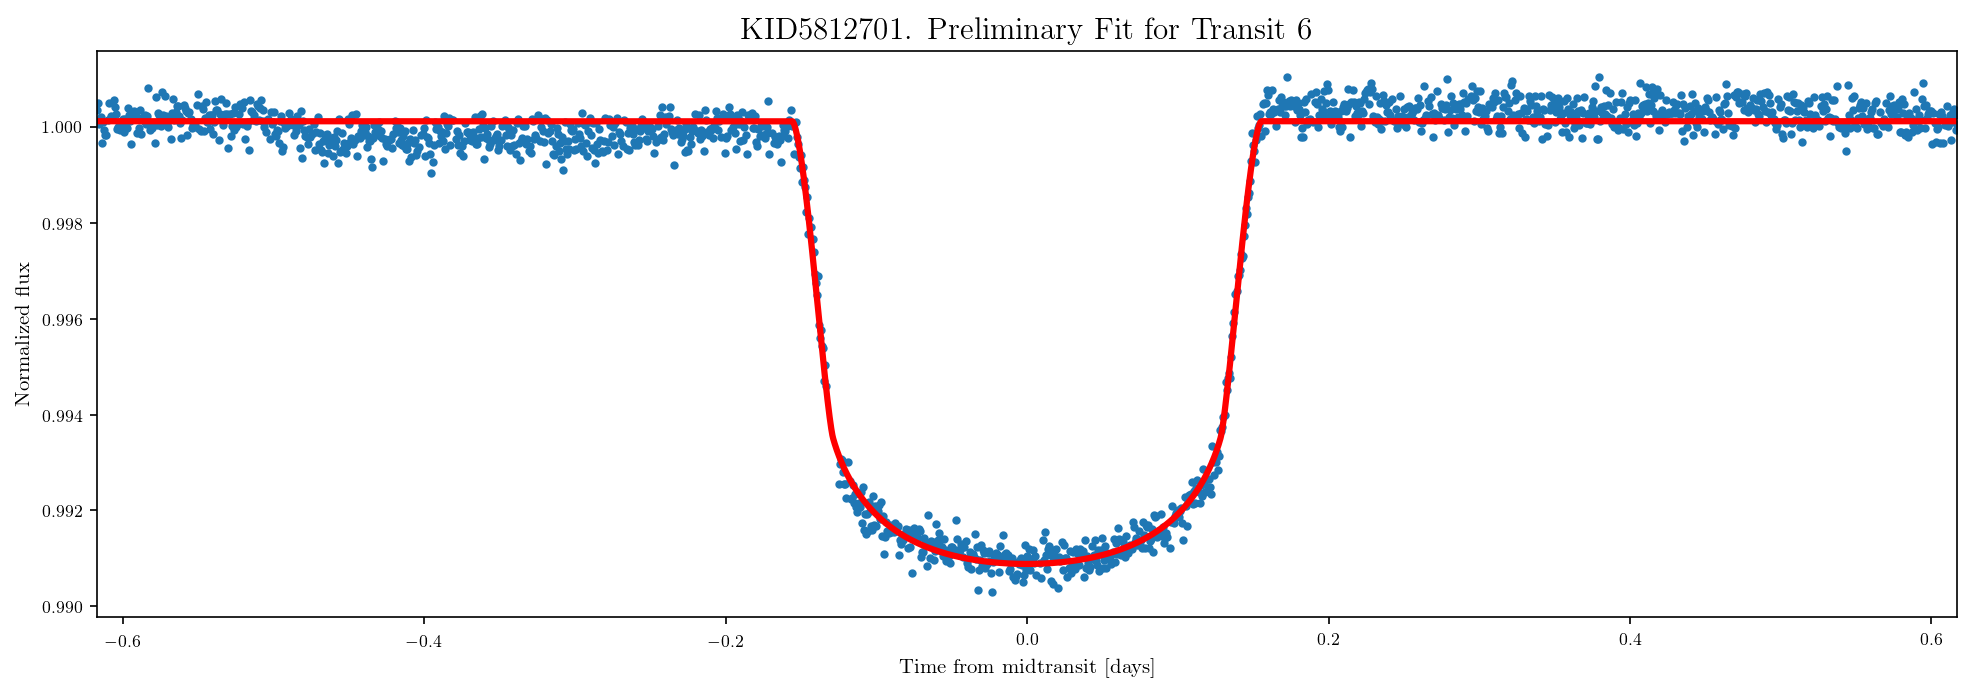

------ Pre-MCMC Results ------
	Transit duration [d]:	 Fit=0.311	True=0.309
	Period [days]:	 Fit=19.74532584	True=17.85522168
	Impact Parameter:	 Fit=0.232072	True=0.075000
	Depth:	 Fit=0.007962	True=0.009065
	Stellar mass:	 Fit=1.401	True=1.386
	Stellar radius:	 Fit=1.600	True=1.631
	Sigma (white noise):	 Fit=0.000
	Out-of-transit flux:	 Fit=1.000

------ Prepare MCMC -------
Guess impact parameter: 0.23207249275489777
Guess of Rp [in Rsun]:  0.14275337041262845
1+rp_guess/rs:  1.0892294721029459
Running burn-in


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
100%|██████████| 250/250 [00:57<00:00,  4.62it/s]



------ Run MCMC -------


100%|██████████| 1000/1000 [03:29<00:00,  5.16it/s]



------ Post-MCMC Results ------

Depth:
	True = 0.009
	MCMC Fit = 0.008 (+0.000,-0.000)

Impact parameter:
	True = 0.075
	MCMC Fit = 0.170 (+0.074,-0.075)

Planet radius [REarth]:
	True = 13.160
	MCMC Fit = 15.801 (+0.385,-0.352)

Period [d]:
	True = 17.855
	MCMC Fit = 17.957 (+1.719,-1.527)

Inverse of scaled semi-major axis:
	True = 0.0500
	MCMC Fit = 0.0475 (+0.0014,-0.0013)

Stellar radius [Rsun]:
	True = 1.631
	MCMC Fit = 1.627 (+0.039,-0.036)

Stellar Mass [Msun]:
	True = 1.386
	MCMC Fit = 1.387 (+0.072,-0.070)
Mean acceptance fraction: 0.35125999999999996
Acceptance fraction: 35.13 %

	*TRANSIT 7
		Signal = 0.00762. Noise (rms) = 0.00037. SNR = 20.71804
		Out-of-transit error of the transit LC = 0.00037
Max. depth (guess) = 1.09861
Depth guess = 0.00972. True depth = 0.00907


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in multiply
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in subtract


Optimization terminated successfully.
         Current function value: -12827.647250
         Iterations: 4216
         Function evaluations: 6161
Optimization terminated successfully.
         Current function value: -12827.497326
         Iterations: 659
         Function evaluations: 993


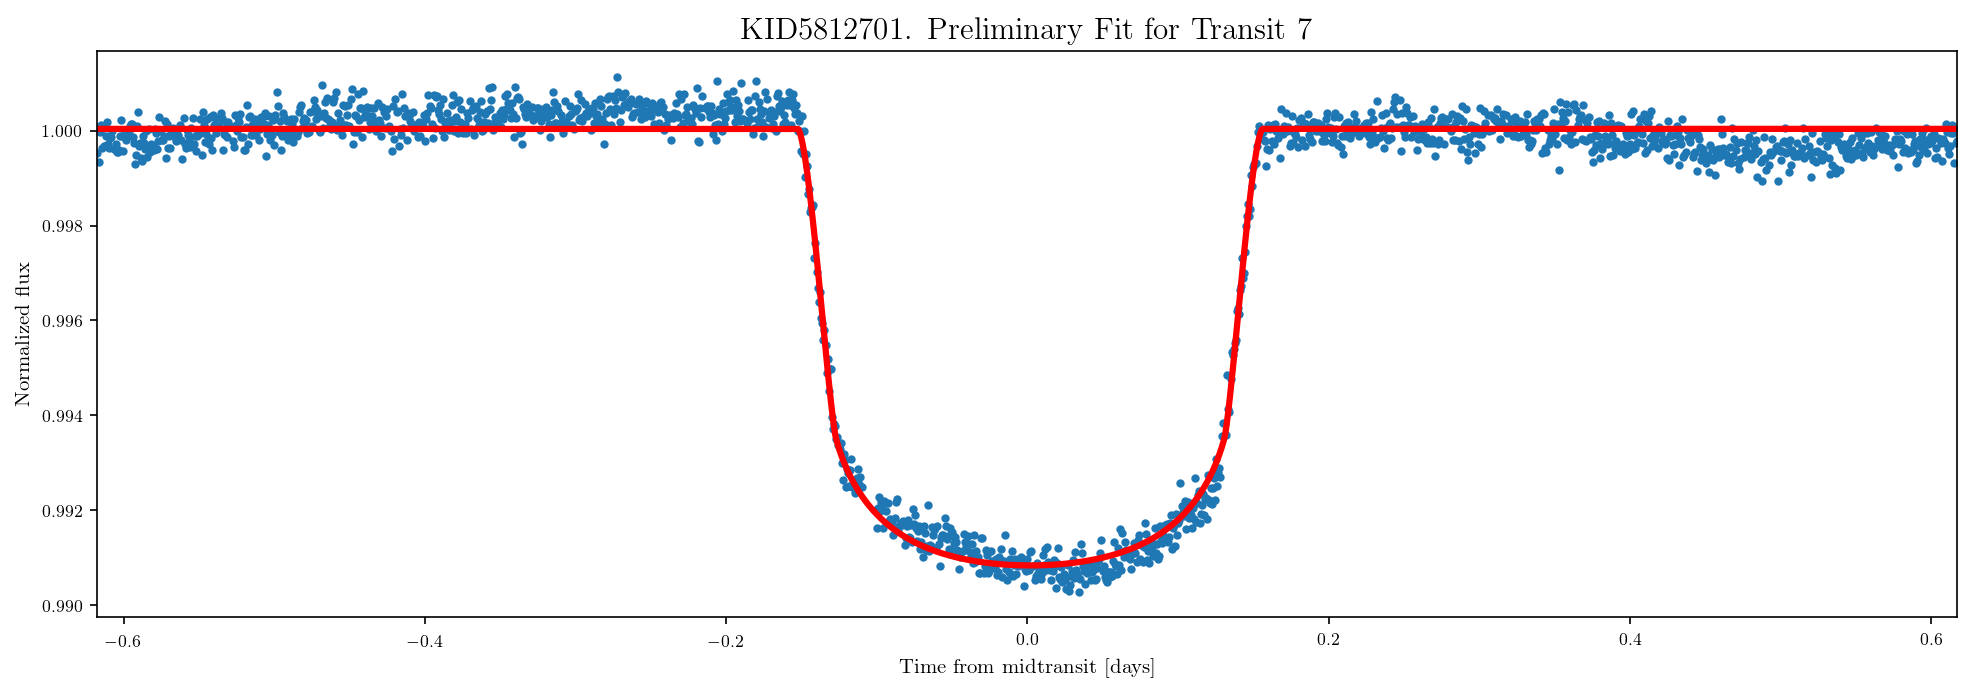

------ Pre-MCMC Results ------
	Transit duration [d]:	 Fit=0.308	True=0.309
	Period [days]:	 Fit=16.63913399	True=17.85522168
	Impact Parameter:	 Fit=0.000095	True=0.075000
	Depth:	 Fit=0.007865	True=0.009065
	Stellar mass:	 Fit=1.382	True=1.386
	Stellar radius:	 Fit=1.634	True=1.631
	Sigma (white noise):	 Fit=0.000
	Out-of-transit flux:	 Fit=1.000

------ Prepare MCMC -------
Guess impact parameter: 9.505658614308243e-05
Guess of Rp [in Rsun]:  0.1448773421547934
1+rp_guess/rs:  1.0886855057713858
Running burn-in


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
100%|██████████| 250/250 [00:58<00:00,  4.99it/s]



------ Run MCMC -------


100%|██████████| 1000/1000 [03:26<00:00,  4.83it/s]



------ Post-MCMC Results ------

Depth:
	True = 0.009
	MCMC Fit = 0.008 (+0.000,-0.000)

Impact parameter:
	True = 0.075
	MCMC Fit = 0.012 (+0.061,-0.011)

Planet radius [REarth]:
	True = 13.160
	MCMC Fit = 15.752 (+0.372,-0.369)

Period [d]:
	True = 17.855
	MCMC Fit = 16.914 (+1.532,-1.394)

Inverse of scaled semi-major axis:
	True = 0.0500
	MCMC Fit = 0.0533 (+0.0015,-0.0015)

Stellar radius [Rsun]:
	True = 1.631
	MCMC Fit = 1.628 (+0.039,-0.038)

Stellar Mass [Msun]:
	True = 1.386
	MCMC Fit = 1.388 (+0.073,-0.075)


Mean acceptance fraction: 0.39704
Acceptance fraction: 39.70 %

	*TRANSIT 8
		Signal = 0.00771. Noise (rms) = 0.00036. SNR = 21.29857
		Out-of-transit error of the transit LC = 0.00036
Max. depth (guess) = 1.09926
Depth guess = 0.00985. True depth = 0.00907


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in subtract


Optimization terminated successfully.
         Current function value: -12867.083496
         Iterations: 1694
         Function evaluations: 2524
Optimization terminated successfully.
         Current function value: -12936.611191
         Iterations: 1480
         Function evaluations: 2163


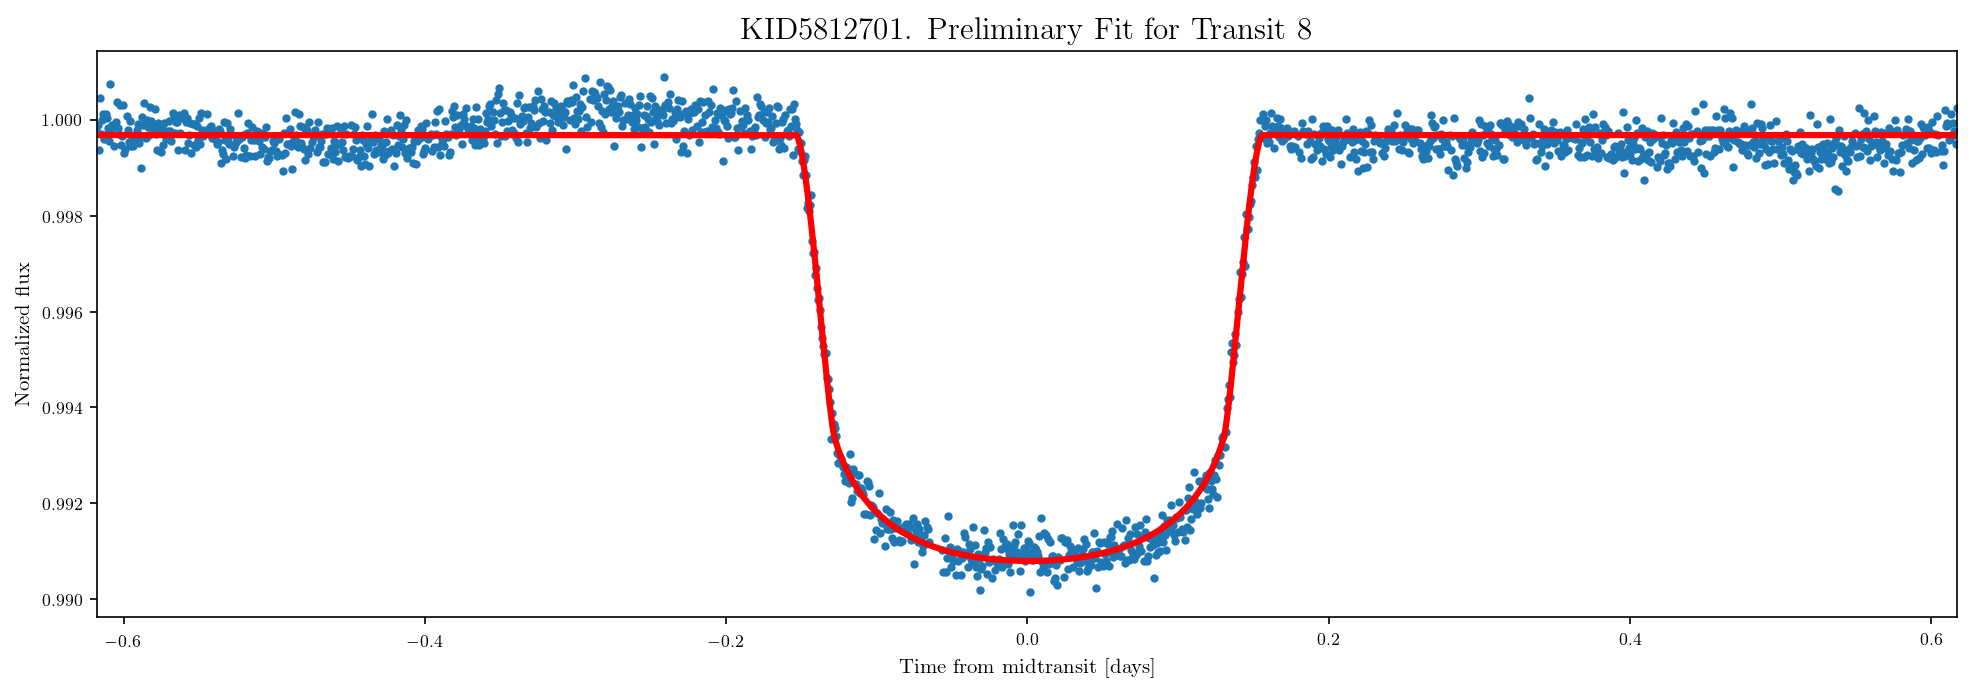

------ Pre-MCMC Results ------
	Transit duration [d]:	 Fit=0.309	True=0.309
	Period [days]:	 Fit=17.17654551	True=17.85522168
	Impact Parameter:	 Fit=0.120327	True=0.075000
	Depth:	 Fit=0.007622	True=0.009065
	Stellar mass:	 Fit=1.383	True=1.386
	Stellar radius:	 Fit=1.633	True=1.631
	Sigma (white noise):	 Fit=0.000
	Out-of-transit flux:	 Fit=1.000

------ Prepare MCMC -------
Guess impact parameter: 0.12032729795176783
Guess of Rp [in Rsun]:  0.14259533564622454
1+rp_guess/rs:  1.087305376279214
Running burn-in


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
100%|██████████| 250/250 [01:00<00:00,  4.63it/s]



------ Run MCMC -------


100%|██████████| 1000/1000 [03:33<00:00,  4.88it/s]



------ Post-MCMC Results ------

Depth:
	True = 0.009
	MCMC Fit = 0.008 (+0.000,-0.000)

Impact parameter:
	True = 0.075
	MCMC Fit = 0.122 (+0.074,-0.069)

Planet radius [REarth]:
	True = 13.160
	MCMC Fit = 15.525 (+0.376,-0.356)

Period [d]:
	True = 17.855
	MCMC Fit = 17.415 (+1.829,-1.497)

Inverse of scaled semi-major axis:
	True = 0.0500
	MCMC Fit = 0.0523 (+0.0014,-0.0015)

Stellar radius [Rsun]:
	True = 1.631
	MCMC Fit = 1.630 (+0.040,-0.037)

Stellar Mass [Msun]:
	True = 1.386
	MCMC Fit = 1.388 (+0.074,-0.071)
Mean acceptance fraction: 0.3536800000000001
Acceptance fraction: 35.37 %

	*TRANSIT 9
		Signal = 0.00475. Noise (rms) = 0.00041. SNR = 11.57033
		Out-of-transit error of the transit LC = 0.00041
Max. depth (guess) = 1.09156
Depth guess = 0.00838. True depth = 0.00907


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in multiply
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in subtract


Optimization terminated successfully.
         Current function value: -10019.695803
         Iterations: 1171
         Function evaluations: 1755
Optimization terminated successfully.
         Current function value: -10041.977172
         Iterations: 1249
         Function evaluations: 1839


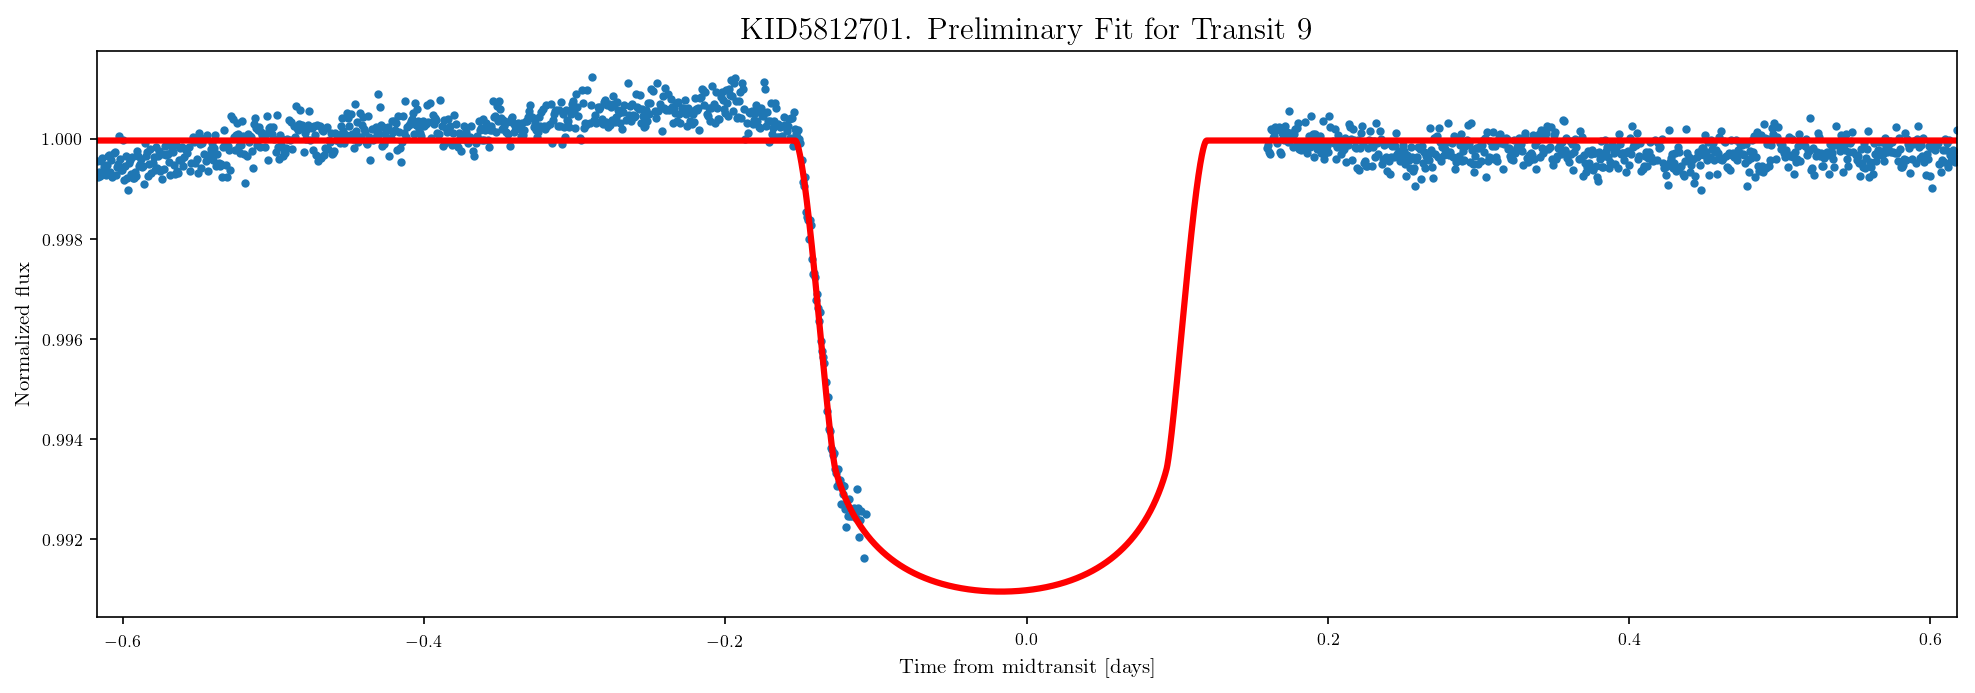

/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
  0%|          | 0/250 [00:00<?, ?it/s]

------ Pre-MCMC Results ------
	Transit duration [d]:	 Fit=0.273	True=0.309
	Period [days]:	 Fit=14.44063901	True=17.85522168
	Impact Parameter:	 Fit=0.407501	True=0.075000
	Depth:	 Fit=0.007912	True=0.009065
	Stellar mass:	 Fit=1.383	True=1.386
	Stellar radius:	 Fit=1.633	True=1.631
	Sigma (white noise):	 Fit=0.000
	Out-of-transit flux:	 Fit=1.000

------ Prepare MCMC -------
Guess impact parameter: 0.40750126701961914
Guess of Rp [in Rsun]:  0.14529763588027889
1+rp_guess/rs:  1.088949073925789
Running burn-in


  0%|          | 0/1000 [00:00<?, ?it/s]


------ Run MCMC -------


100%|██████████| 1000/1000 [02:02<00:00,  8.53it/s]



------ Post-MCMC Results ------

Depth:
	True = 0.009
	MCMC Fit = 0.008 (+0.000,-0.000)

Impact parameter:
	True = 0.075
	MCMC Fit = 0.360 (+0.100,-0.104)

Planet radius [REarth]:
	True = 13.160
	MCMC Fit = 15.767 (+0.405,-0.407)

Period [d]:
	True = 17.855
	MCMC Fit = 16.346 (+2.544,-1.951)

Inverse of scaled semi-major axis:
	True = 0.0500
	MCMC Fit = 0.0582 (+0.0018,-0.0016)

Stellar radius [Rsun]:
	True = 1.631
	MCMC Fit = 1.623 (+0.039,-0.038)

Stellar Mass [Msun]:
	True = 1.386
	MCMC Fit = 1.397 (+0.069,-0.070)
Mean acceptance fraction: 0.3423599999999999
Acceptance fraction: 34.24 %

	*TRANSIT 10
		Signal = 0.00746. Noise (rms) = 0.00040. SNR = 18.88406
		Out-of-transit error of the transit LC = 0.00040
Max. depth (guess) = 1.09690
Depth guess = 0.00939. True depth = 0.00907


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in subtract
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in multiply


Optimization terminated successfully.
         Current function value: -12492.640268
         Iterations: 1929
         Function evaluations: 2862
Optimization terminated successfully.
         Current function value: -12754.979362
         Iterations: 1487
         Function evaluations: 2194


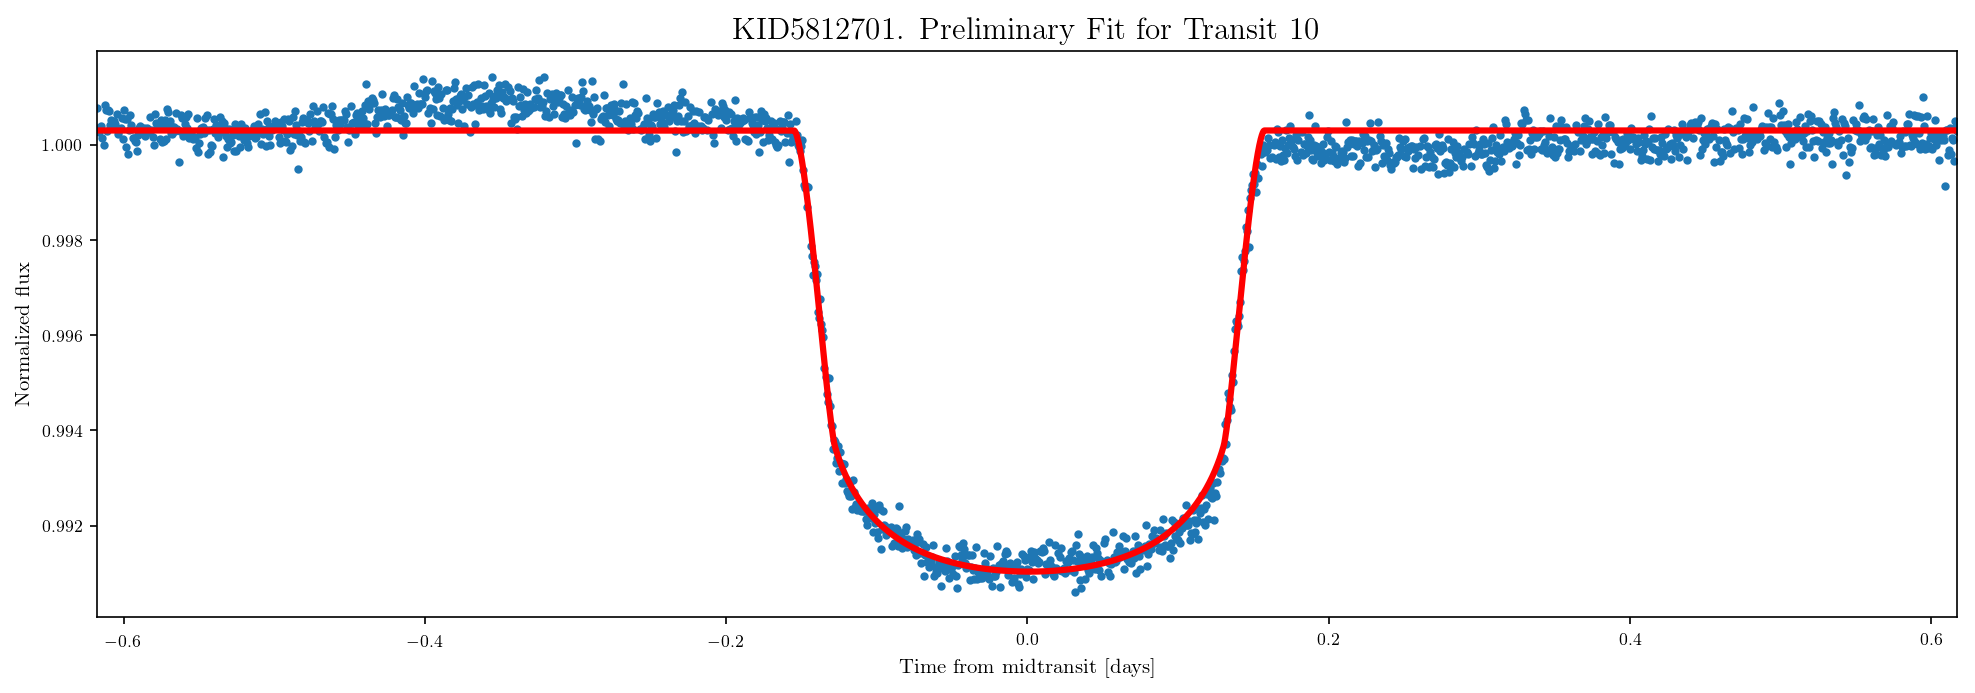

------ Pre-MCMC Results ------
	Transit duration [d]:	 Fit=0.312	True=0.309
	Period [days]:	 Fit=18.28410789	True=17.85522168
	Impact Parameter:	 Fit=0.213497	True=0.075000
	Depth:	 Fit=0.007976	True=0.009065
	Stellar mass:	 Fit=1.384	True=1.386
	Stellar radius:	 Fit=1.633	True=1.631
	Sigma (white noise):	 Fit=0.000
	Out-of-transit flux:	 Fit=1.000

------ Prepare MCMC -------
Guess impact parameter: 0.21349661940851727
Guess of Rp [in Rsun]:  0.14580860395977568
1+rp_guess/rs:  1.089307042848751
Running burn-in


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
100%|██████████| 250/250 [01:01<00:00,  4.40it/s]



------ Run MCMC -------


100%|██████████| 1000/1000 [03:43<00:00,  4.74it/s]



------ Post-MCMC Results ------

Depth:
	True = 0.009
	MCMC Fit = 0.008 (+0.000,-0.000)

Impact parameter:
	True = 0.075
	MCMC Fit = 0.199 (+0.065,-0.082)

Planet radius [REarth]:
	True = 13.160
	MCMC Fit = 15.854 (+0.379,-0.360)

Period [d]:
	True = 17.855
	MCMC Fit = 18.362 (+1.683,-1.582)

Inverse of scaled semi-major axis:
	True = 0.0500
	MCMC Fit = 0.0501 (+0.0015,-0.0014)

Stellar radius [Rsun]:
	True = 1.631
	MCMC Fit = 1.629 (+0.038,-0.036)

Stellar Mass [Msun]:
	True = 1.386
	MCMC Fit = 1.389 (+0.068,-0.072)
Mean acceptance fraction: 0.36074
Acceptance fraction: 36.07 %

	*TRANSIT 11
		Signal = 0.00780. Noise (rms) = 0.00036. SNR = 21.85859
		Out-of-transit error of the transit LC = 0.00036
Max. depth (guess) = 1.09930
Depth guess = 0.00986. True depth = 0.00907


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in subtract


Optimization terminated successfully.
         Current function value: -12136.631205
         Iterations: 706
         Function evaluations: 1112
Optimization terminated successfully.
         Current function value: -12983.980257
         Iterations: 2560
         Function evaluations: 3735


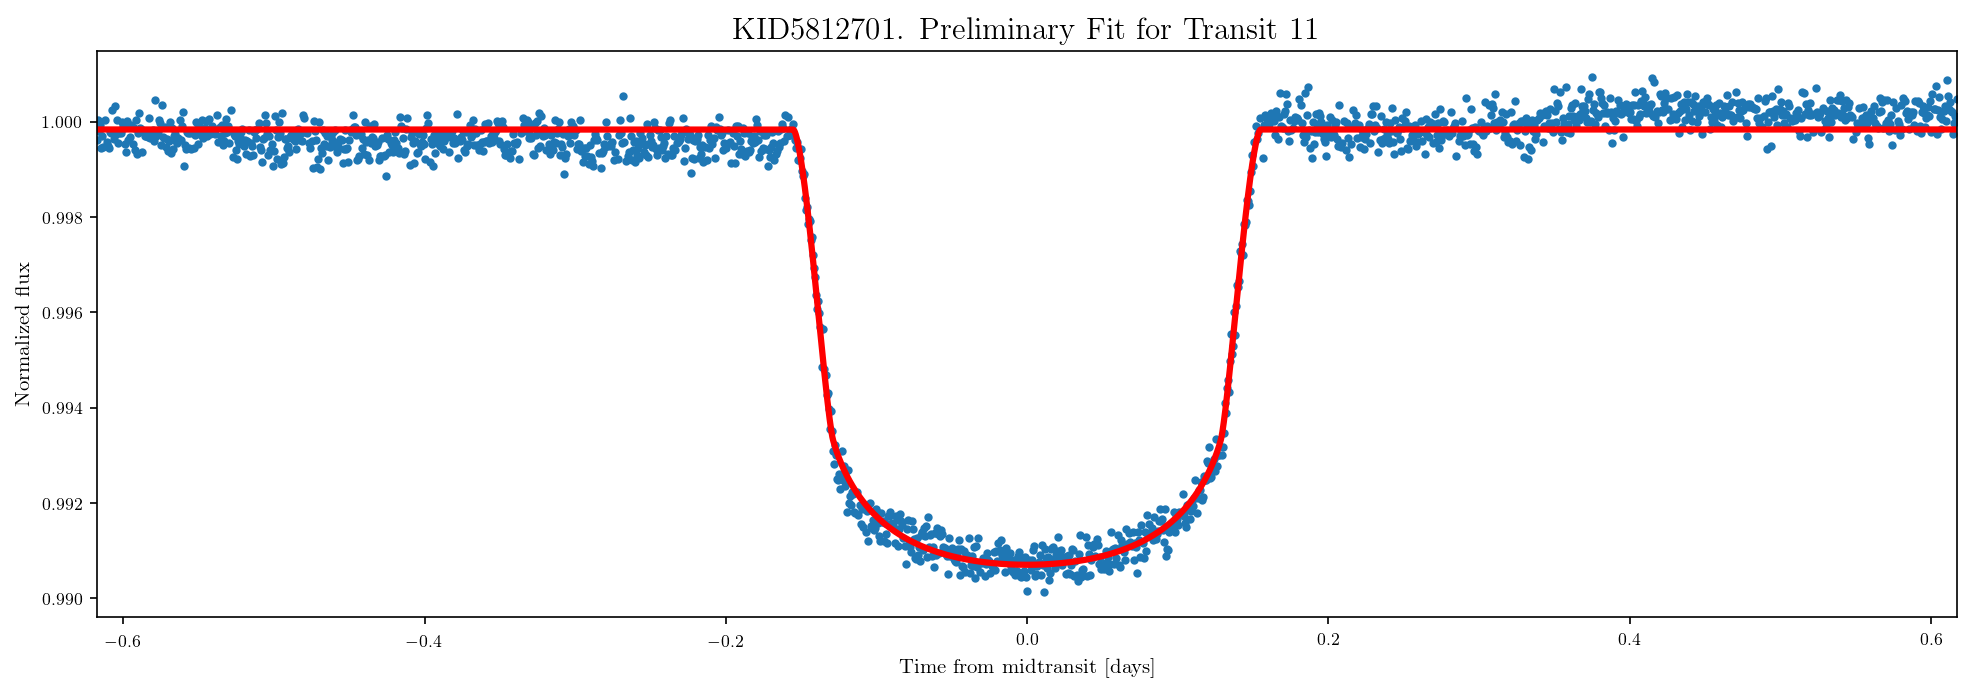

------ Pre-MCMC Results ------
	Transit duration [d]:	 Fit=0.310	True=0.309
	Period [days]:	 Fit=17.79662208	True=17.85522168
	Impact Parameter:	 Fit=0.194567	True=0.075000
	Depth:	 Fit=0.007843	True=0.009065
	Stellar mass:	 Fit=1.383	True=1.386
	Stellar radius:	 Fit=1.633	True=1.631
	Sigma (white noise):	 Fit=0.000
	Out-of-transit flux:	 Fit=1.000

------ Prepare MCMC -------
Guess impact parameter: 0.19456696926206393
Guess of Rp [in Rsun]:  0.14464527299811453
1+rp_guess/rs:  1.0885596637927437
Running burn-in


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
100%|██████████| 250/250 [00:59<00:00,  4.58it/s]



------ Run MCMC -------


100%|██████████| 1000/1000 [03:39<00:00,  4.54it/s]



------ Post-MCMC Results ------

Depth:
	True = 0.009
	MCMC Fit = 0.008 (+0.000,-0.000)

Impact parameter:
	True = 0.075
	MCMC Fit = 0.184 (+0.060,-0.074)

Planet radius [REarth]:
	True = 13.160
	MCMC Fit = 15.732 (+0.358,-0.373)

Period [d]:
	True = 17.855
	MCMC Fit = 17.885 (+1.722,-1.469)

Inverse of scaled semi-major axis:
	True = 0.0500
	MCMC Fit = 0.0510 (+0.0014,-0.0013)

Stellar radius [Rsun]:
	True = 1.631
	MCMC Fit = 1.629 (+0.037,-0.038)

Stellar Mass [Msun]:
	True = 1.386
	MCMC Fit = 1.384 (+0.073,-0.066)
Mean acceptance fraction: 0.3565099999999999
Acceptance fraction: 35.65 %

	*TRANSIT 12
		Signal = 0.00771. Noise (rms) = 0.00037. SNR = 20.91152
		Out-of-transit error of the transit LC = 0.00037
Max. depth (guess) = 1.09875
Depth guess = 0.00975. True depth = 0.00907


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in subtract


Optimization terminated successfully.
         Current function value: -12328.603434
         Iterations: 1785
         Function evaluations: 2633
Optimization terminated successfully.
         Current function value: -12753.514640
         Iterations: 1298
         Function evaluations: 1920


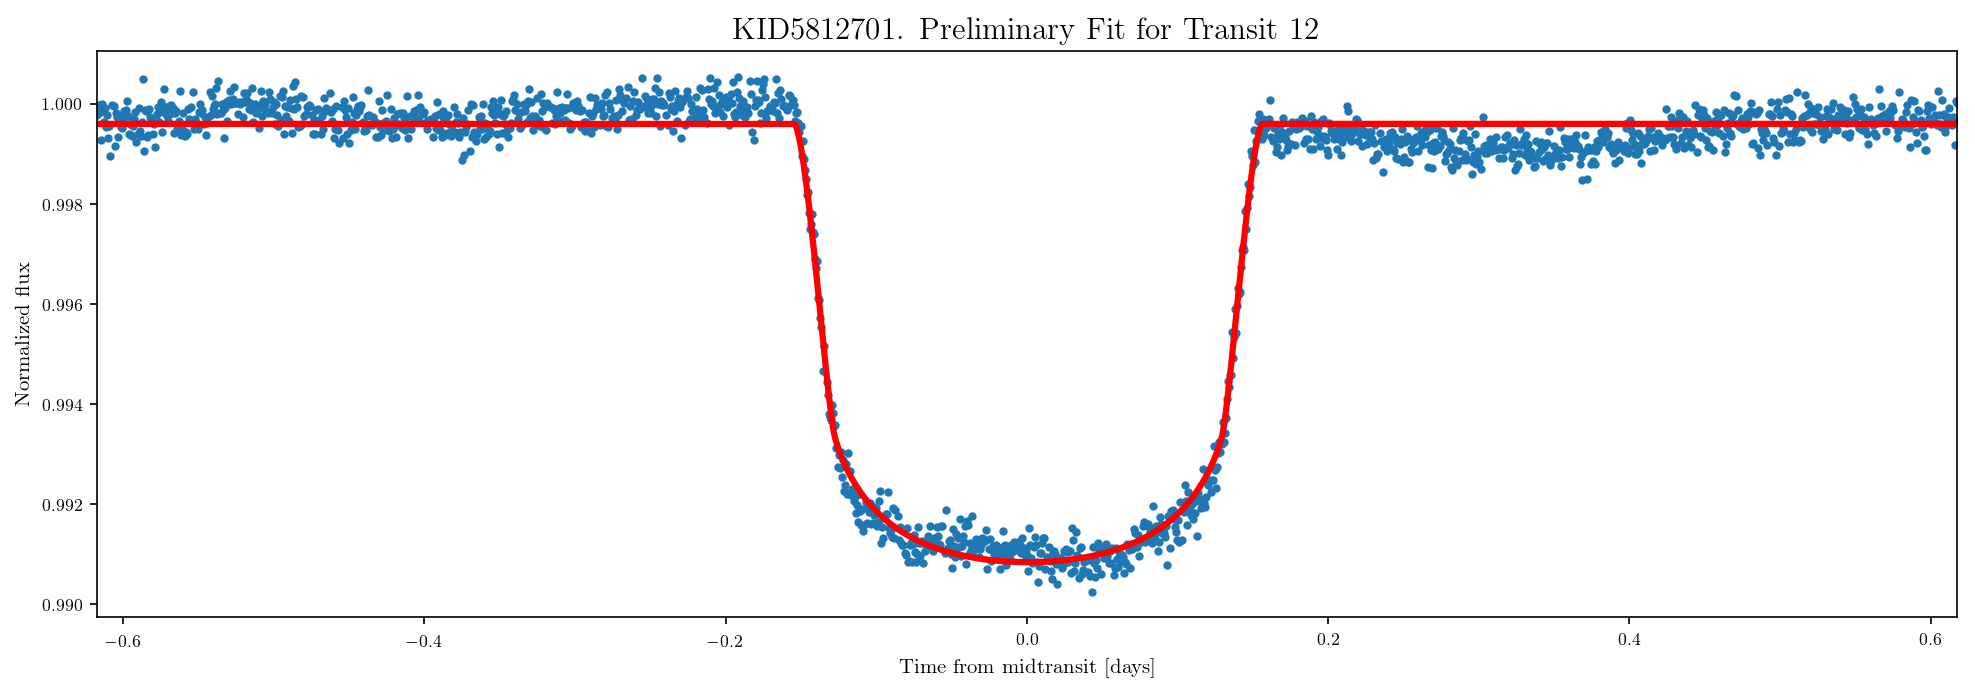

------ Pre-MCMC Results ------
	Transit duration [d]:	 Fit=0.311	True=0.309
	Period [days]:	 Fit=17.04434654	True=17.85522168
	Impact Parameter:	 Fit=0.267135	True=0.075000
	Depth:	 Fit=0.007568	True=0.009065
	Stellar mass:	 Fit=1.273	True=1.386
	Stellar radius:	 Fit=1.640	True=1.631
	Sigma (white noise):	 Fit=0.000
	Out-of-transit flux:	 Fit=1.000

------ Prepare MCMC -------
Guess impact parameter: 0.2671345999667546
Guess of Rp [in Rsun]:  0.14269841692707153
1+rp_guess/rs:  1.0869955555108535
Running burn-in


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
100%|██████████| 250/250 [01:31<00:00,  4.40it/s]



------ Run MCMC -------


100%|██████████| 1000/1000 [03:28<00:00,  5.32it/s]



------ Post-MCMC Results ------

Depth:
	True = 0.009
	MCMC Fit = 0.007 (+0.000,-0.000)

Impact parameter:
	True = 0.075
	MCMC Fit = 0.074 (+0.071,-0.049)

Planet radius [REarth]:
	True = 13.160
	MCMC Fit = 15.377 (+0.380,-0.372)

Period [d]:
	True = 17.855
	MCMC Fit = 17.207 (+1.561,-1.494)

Inverse of scaled semi-major axis:
	True = 0.0500
	MCMC Fit = 0.0525 (+0.0016,-0.0015)

Stellar radius [Rsun]:
	True = 1.631
	MCMC Fit = 1.629 (+0.039,-0.039)

Stellar Mass [Msun]:
	True = 1.386
	MCMC Fit = 1.383 (+0.074,-0.072)
Mean acceptance fraction: 0.37142
Acceptance fraction: 37.14 %

	*TRANSIT 13
		Signal = 0.00733. Noise (rms) = 0.00033. SNR = 22.43202
		Out-of-transit error of the transit LC = 0.00033
Max. depth (guess) = 1.09614
Depth guess = 0.00924. True depth = 0.00907


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in subtract


Optimization terminated successfully.
         Current function value: -9401.849419
         Iterations: 2846
         Function evaluations: 4143
Optimization terminated successfully.
         Current function value: -9425.456607
         Iterations: 1430
         Function evaluations: 2155


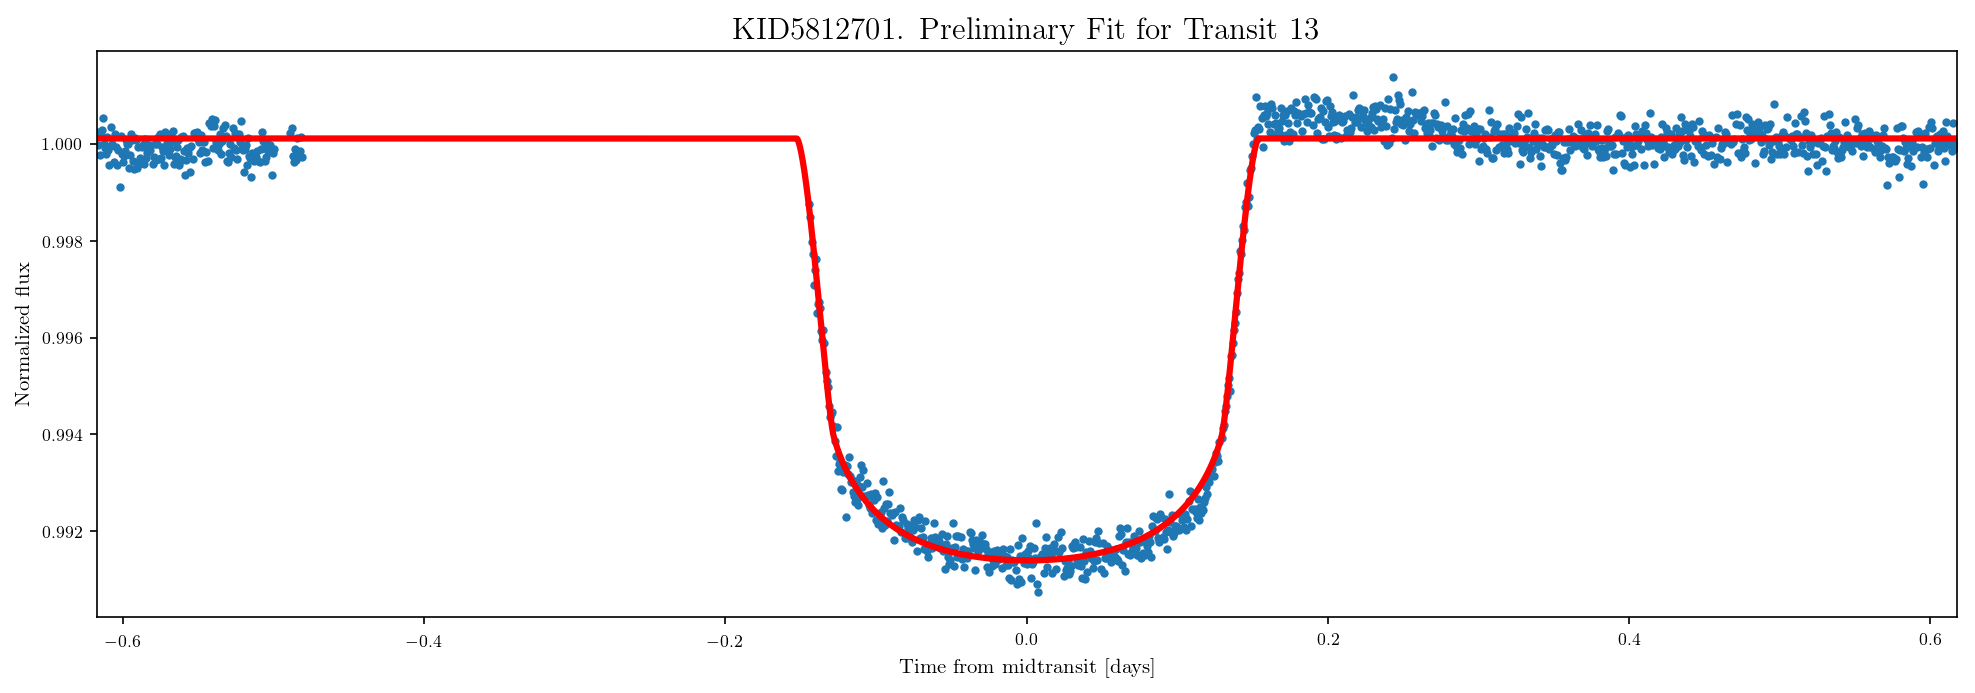

------ Pre-MCMC Results ------
	Transit duration [d]:	 Fit=0.307	True=0.309
	Period [days]:	 Fit=16.54120671	True=17.85522168
	Impact Parameter:	 Fit=0.000000	True=0.075000
	Depth:	 Fit=0.007437	True=0.009065
	Stellar mass:	 Fit=1.385	True=1.386
	Stellar radius:	 Fit=1.632	True=1.631
	Sigma (white noise):	 Fit=0.000
	Out-of-transit flux:	 Fit=1.000

------ Prepare MCMC -------
Guess impact parameter: 3.1336511944236e-08
Guess of Rp [in Rsun]:  0.14075139862980168
1+rp_guess/rs:  1.0862352873942525
Running burn-in


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
100%|██████████| 250/250 [00:47<00:00,  6.08it/s]



------ Run MCMC -------


100%|██████████| 1000/1000 [02:49<00:00,  6.15it/s]



------ Post-MCMC Results ------

Depth:
	True = 0.009
	MCMC Fit = 0.007 (+0.000,-0.000)

Impact parameter:
	True = 0.075
	MCMC Fit = 0.000 (+0.000,-0.000)

Planet radius [REarth]:
	True = 13.160
	MCMC Fit = 15.307 (+0.364,-0.373)

Period [d]:
	True = 17.855
	MCMC Fit = 16.675 (+1.716,-1.415)

Inverse of scaled semi-major axis:
	True = 0.0500
	MCMC Fit = 0.0535 (+0.0016,-0.0017)

Stellar radius [Rsun]:
	True = 1.631
	MCMC Fit = 1.628 (+0.039,-0.039)

Stellar Mass [Msun]:
	True = 1.386
	MCMC Fit = 1.389 (+0.074,-0.071)
Mean acceptance fraction: 0.39302
Acceptance fraction: 39.30 %

	*TRANSIT 14
		Signal = 0.00754. Noise (rms) = 0.00030. SNR = 24.95460
		Out-of-transit error of the transit LC = 0.00030
Max. depth (guess) = 1.09849
Depth guess = 0.00970. True depth = 0.00907


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in multiply
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in subtract


Optimization terminated successfully.
         Current function value: -13015.654276
         Iterations: 3042
         Function evaluations: 4485
Optimization terminated successfully.
         Current function value: -13174.860158
         Iterations: 791
         Function evaluations: 1213


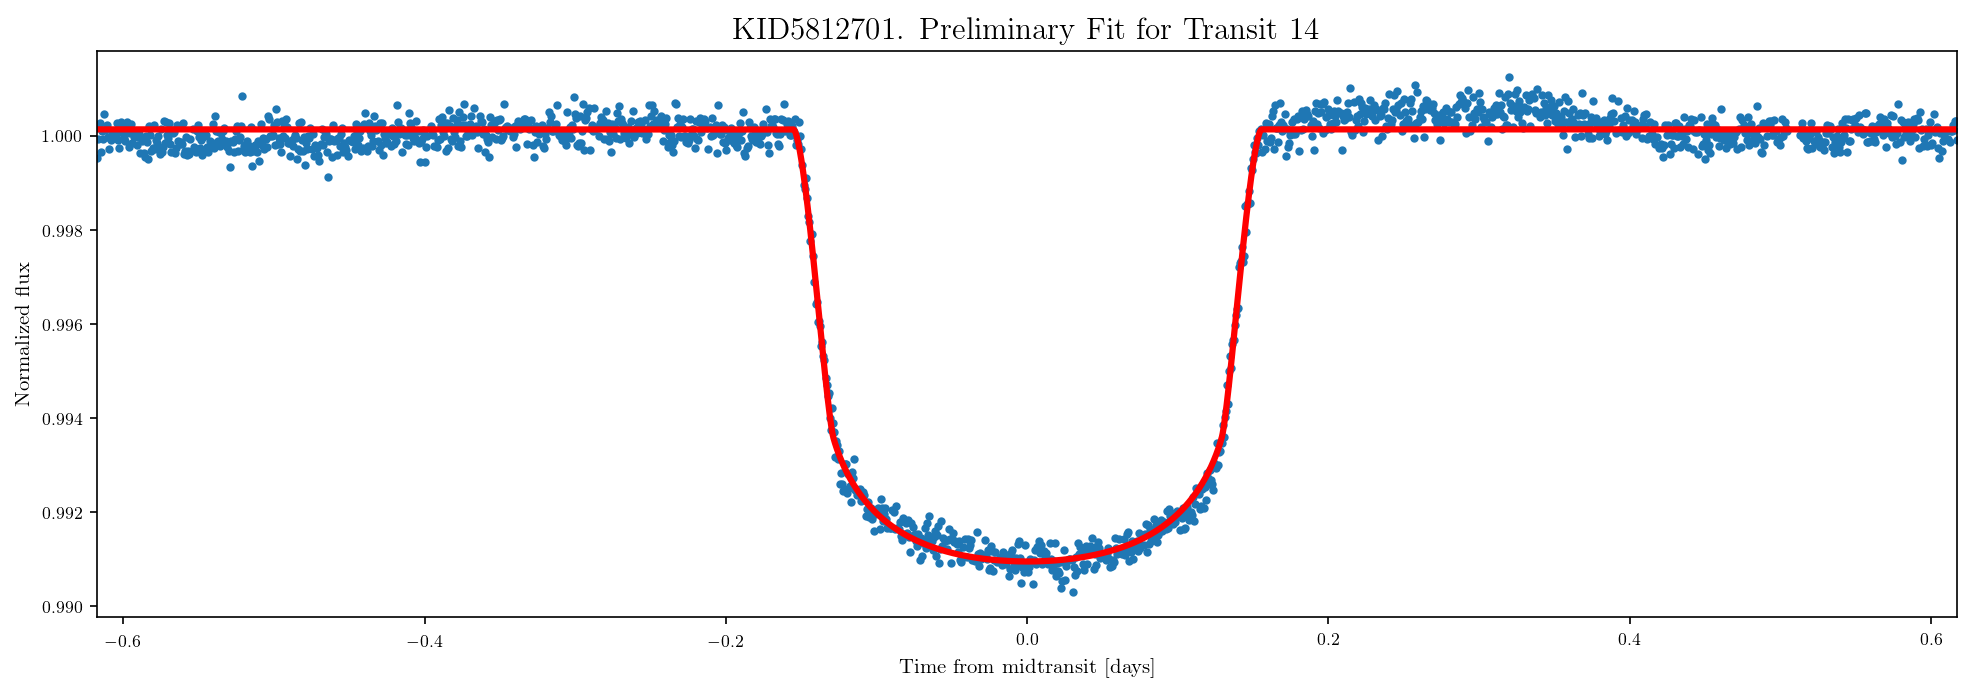

------ Pre-MCMC Results ------
	Transit duration [d]:	 Fit=0.310	True=0.309
	Period [days]:	 Fit=17.76987962	True=17.85522168
	Impact Parameter:	 Fit=0.176575	True=0.075000
	Depth:	 Fit=0.007891	True=0.009065
	Stellar mass:	 Fit=1.379	True=1.386
	Stellar radius:	 Fit=1.629	True=1.631
	Sigma (white noise):	 Fit=0.000
	Out-of-transit flux:	 Fit=1.000

------ Prepare MCMC -------
Guess impact parameter: 0.17657516544988072
Guess of Rp [in Rsun]:  0.14471751939253916
1+rp_guess/rs:  1.088832558737745
Running burn-in


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
100%|██████████| 250/250 [01:00<00:00,  4.49it/s]



------ Run MCMC -------


100%|██████████| 1000/1000 [03:36<00:00,  4.83it/s]



------ Post-MCMC Results ------

Depth:
	True = 0.009
	MCMC Fit = 0.008 (+0.000,-0.000)

Impact parameter:
	True = 0.075
	MCMC Fit = 0.151 (+0.062,-0.079)

Planet radius [REarth]:
	True = 13.160
	MCMC Fit = 15.794 (+0.353,-0.335)

Period [d]:
	True = 17.855
	MCMC Fit = 17.562 (+1.531,-1.303)

Inverse of scaled semi-major axis:
	True = 0.0500
	MCMC Fit = 0.0511 (+0.0013,-0.0013)

Stellar radius [Rsun]:
	True = 1.631
	MCMC Fit = 1.632 (+0.036,-0.035)

Stellar Mass [Msun]:
	True = 1.386
	MCMC Fit = 1.385 (+0.075,-0.068)
Mean acceptance fraction: 0.34671
Acceptance fraction: 34.67 %

	*TRANSIT 15
		Signal = 0.00756. Noise (rms) = 0.00037. SNR = 20.32221
		Out-of-transit error of the transit LC = 0.00037
Max. depth (guess) = 1.09980
Depth guess = 0.00996. True depth = 0.00907


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in multiply
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in subtract


Optimization terminated successfully.
         Current function value: -11952.528945
         Iterations: 2574
         Function evaluations: 3769
Optimization terminated successfully.
         Current function value: -12105.950100
         Iterations: 2312
         Function evaluations: 3410


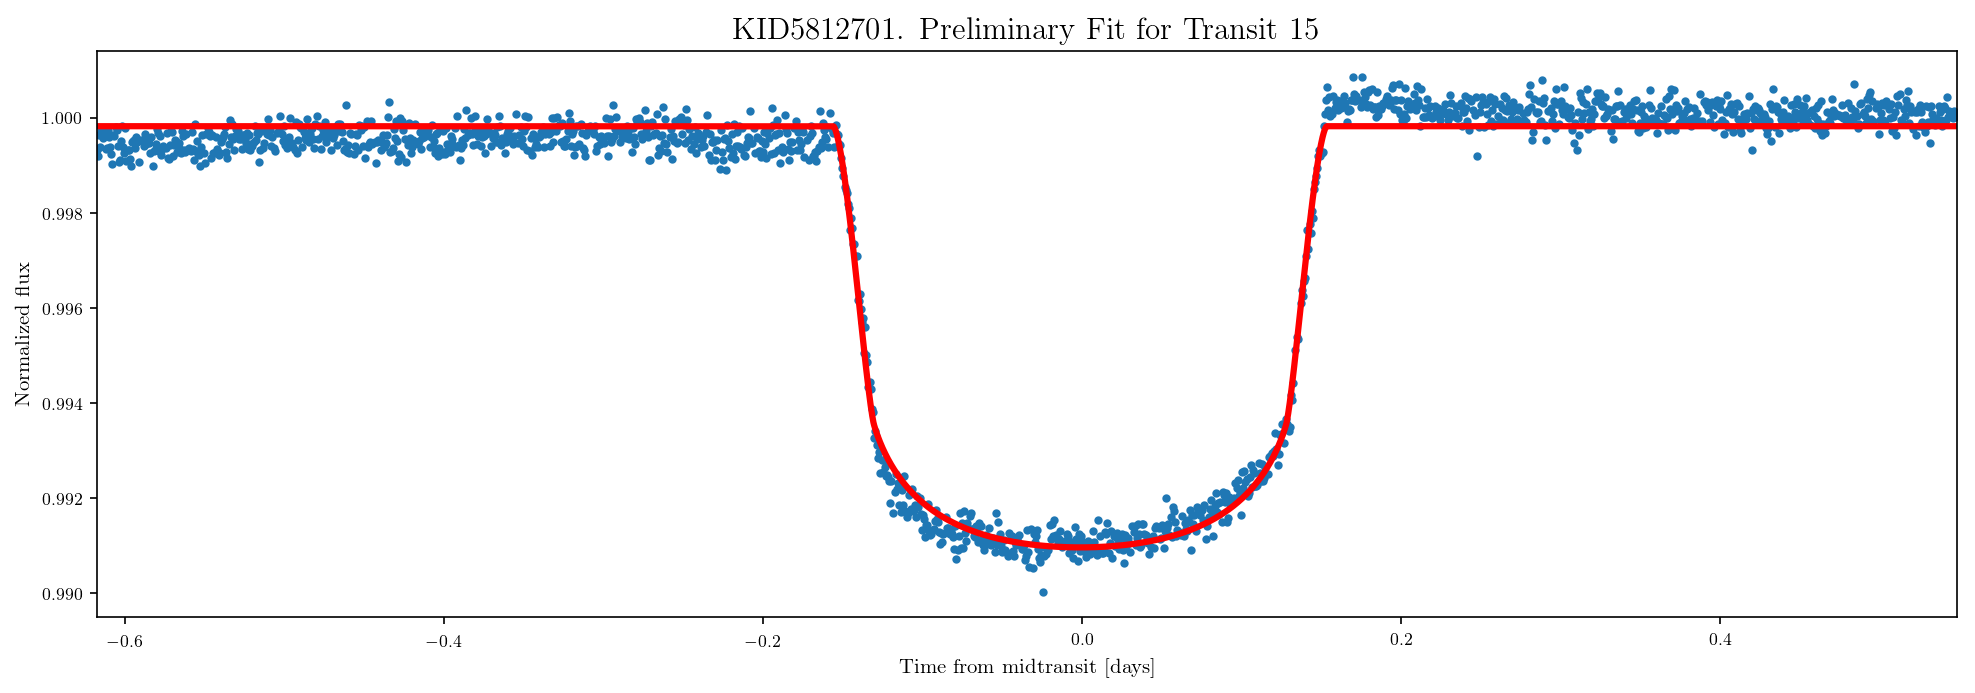

------ Pre-MCMC Results ------
	Transit duration [d]:	 Fit=0.309	True=0.309
	Period [days]:	 Fit=17.62742087	True=17.85522168
	Impact Parameter:	 Fit=0.156461	True=0.075000
	Depth:	 Fit=0.007591	True=0.009065
	Stellar mass:	 Fit=1.402	True=1.386
	Stellar radius:	 Fit=1.634	True=1.631
	Sigma (white noise):	 Fit=0.000
	Out-of-transit flux:	 Fit=1.000

------ Prepare MCMC -------
Guess impact parameter: 0.15646141282179543
Guess of Rp [in Rsun]:  0.1424048445692191
1+rp_guess/rs:  1.087125886256528
Running burn-in


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
100%|██████████| 250/250 [00:57<00:00,  4.73it/s]



------ Run MCMC -------


100%|██████████| 1000/1000 [03:27<00:00,  5.17it/s]



------ Post-MCMC Results ------

Depth:
	True = 0.009
	MCMC Fit = 0.008 (+0.000,-0.000)

Impact parameter:
	True = 0.075
	MCMC Fit = 0.124 (+0.072,-0.076)

Planet radius [REarth]:
	True = 13.160
	MCMC Fit = 15.474 (+0.324,-0.328)

Period [d]:
	True = 17.855
	MCMC Fit = 17.506 (+1.516,-1.384)

Inverse of scaled semi-major axis:
	True = 0.0500
	MCMC Fit = 0.0512 (+0.0014,-0.0013)

Stellar radius [Rsun]:
	True = 1.631
	MCMC Fit = 1.630 (+0.034,-0.035)

Stellar Mass [Msun]:
	True = 1.386
	MCMC Fit = 1.389 (+0.072,-0.068)
Mean acceptance fraction: 0.36367
Acceptance fraction: 36.37 %

	*TRANSIT 16
		Signal = 0.00752. Noise (rms) = 0.00026. SNR = 29.43216
		Out-of-transit error of the transit LC = 0.00026
Max. depth (guess) = 1.09844
Depth guess = 0.00969. True depth = 0.00907


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in subtract


Optimization terminated successfully.
         Current function value: -9821.518491
         Iterations: 3293
         Function evaluations: 4737
Optimization terminated successfully.
         Current function value: -9821.518491
         Iterations: 1031
         Function evaluations: 1542


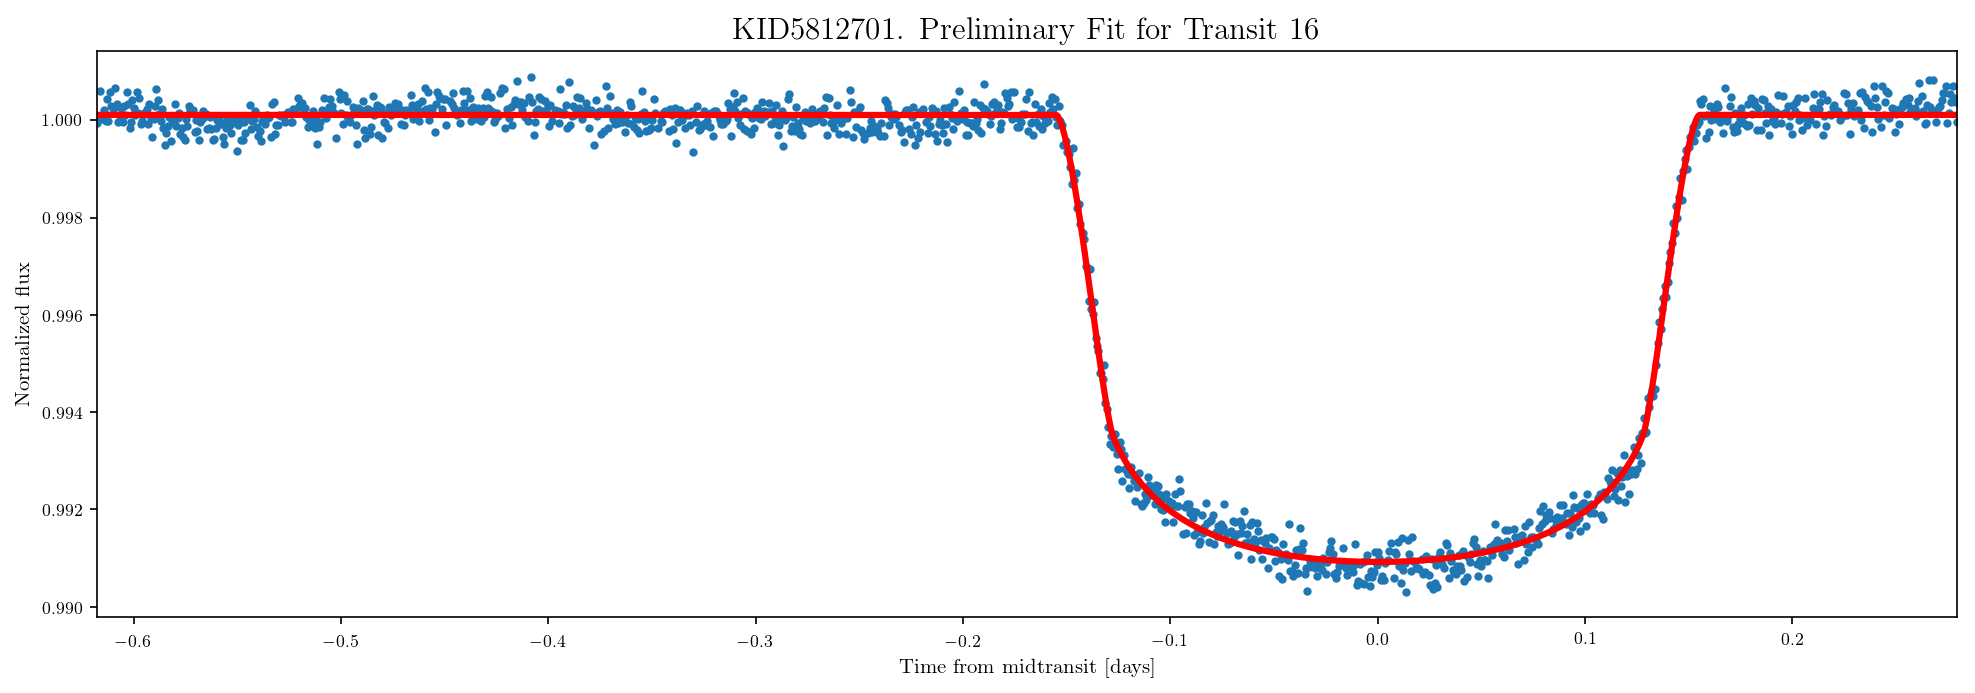

------ Pre-MCMC Results ------
	Transit duration [d]:	 Fit=0.310	True=0.309
	Period [days]:	 Fit=18.45422083	True=17.85522168
	Impact Parameter:	 Fit=0.258514	True=0.075000
	Depth:	 Fit=0.007928	True=0.009065
	Stellar mass:	 Fit=1.382	True=1.386
	Stellar radius:	 Fit=1.633	True=1.631
	Sigma (white noise):	 Fit=0.000
	Out-of-transit flux:	 Fit=1.000

------ Prepare MCMC -------
Guess impact parameter: 0.2585141236083873
Guess of Rp [in Rsun]:  0.1454487452270419
1+rp_guess/rs:  1.0890411738226875
Running burn-in


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
100%|██████████| 250/250 [00:58<00:00,  4.56it/s]



------ Run MCMC -------


100%|██████████| 1000/1000 [03:36<00:00,  4.74it/s]



------ Post-MCMC Results ------

Depth:
	True = 0.009
	MCMC Fit = 0.008 (+0.000,-0.000)

Impact parameter:
	True = 0.075
	MCMC Fit = 0.252 (+0.036,-0.046)

Planet radius [REarth]:
	True = 13.160
	MCMC Fit = 15.863 (+0.341,-0.366)

Period [d]:
	True = 17.855
	MCMC Fit = 18.466 (+1.684,-1.612)

Inverse of scaled semi-major axis:
	True = 0.0500
	MCMC Fit = 0.0498 (+0.0014,-0.0014)

Stellar radius [Rsun]:
	True = 1.631
	MCMC Fit = 1.634 (+0.035,-0.038)

Stellar Mass [Msun]:
	True = 1.386
	MCMC Fit = 1.392 (+0.067,-0.073)
Mean acceptance fraction: 0.37394
Acceptance fraction: 37.39 %

	*TRANSIT 17
		Signal = 0.00708. Noise (rms) = 0.00035. SNR = 20.10303
		Out-of-transit error of the transit LC = 0.00035
Max. depth (guess) = 1.09498
Depth guess = 0.00902. True depth = 0.00907


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in multiply
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in subtract


Optimization terminated successfully.
         Current function value: -12327.347412
         Iterations: 1109
         Function evaluations: 1687
Optimization terminated successfully.
         Current function value: -13036.399637
         Iterations: 1237
         Function evaluations: 1870


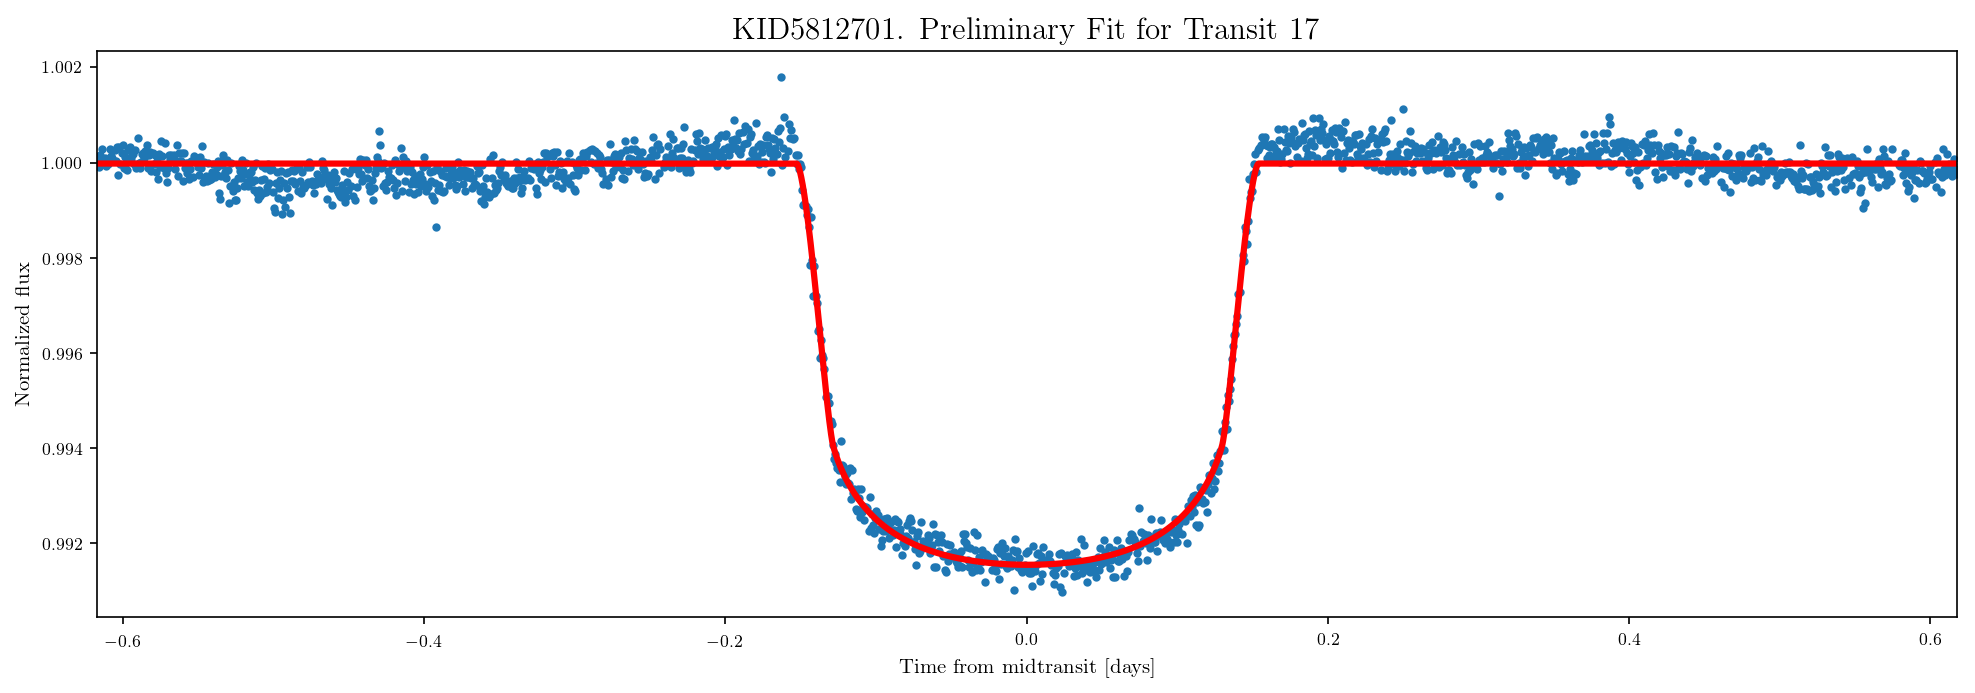

------ Pre-MCMC Results ------
	Transit duration [d]:	 Fit=0.306	True=0.309
	Period [days]:	 Fit=16.55296276	True=17.85522168
	Impact Parameter:	 Fit=0.023758	True=0.075000
	Depth:	 Fit=0.007207	True=0.009065
	Stellar mass:	 Fit=1.384	True=1.386
	Stellar radius:	 Fit=1.633	True=1.631
	Sigma (white noise):	 Fit=0.000
	Out-of-transit flux:	 Fit=1.000

------ Prepare MCMC -------
Guess impact parameter: 0.023758435475048297
Guess of Rp [in Rsun]:  0.13862646287926844
1+rp_guess/rs:  1.0848925149981212
Running burn-in


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
100%|██████████| 250/250 [00:56<00:00,  5.13it/s]



------ Run MCMC -------


100%|██████████| 1000/1000 [03:20<00:00,  5.35it/s]



------ Post-MCMC Results ------

Depth:
	True = 0.009
	MCMC Fit = 0.007 (+0.000,-0.000)

Impact parameter:
	True = 0.075
	MCMC Fit = 0.089 (+0.072,-0.059)

Planet radius [REarth]:
	True = 13.160
	MCMC Fit = 15.107 (+0.341,-0.335)

Period [d]:
	True = 17.855
	MCMC Fit = 17.131 (+1.394,-1.479)

Inverse of scaled semi-major axis:
	True = 0.0500
	MCMC Fit = 0.0534 (+0.0016,-0.0014)

Stellar radius [Rsun]:
	True = 1.631
	MCMC Fit = 1.631 (+0.036,-0.036)

Stellar Mass [Msun]:
	True = 1.386
	MCMC Fit = 1.396 (+0.074,-0.074)
Mean acceptance fraction: 0.37450000000000006
Acceptance fraction: 37.45 %

	*TRANSIT 18
		Signal = 0.00758. Noise (rms) = 0.00042. SNR = 17.96627
		Out-of-transit error of the transit LC = 0.00042
Max. depth (guess) = 1.09871
Depth guess = 0.00974. True depth = 0.00907


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in subtract


Optimization terminated successfully.
         Current function value: -12764.316526
         Iterations: 2478
         Function evaluations: 3643
Optimization terminated successfully.
         Current function value: -12769.923812
         Iterations: 1480
         Function evaluations: 2187


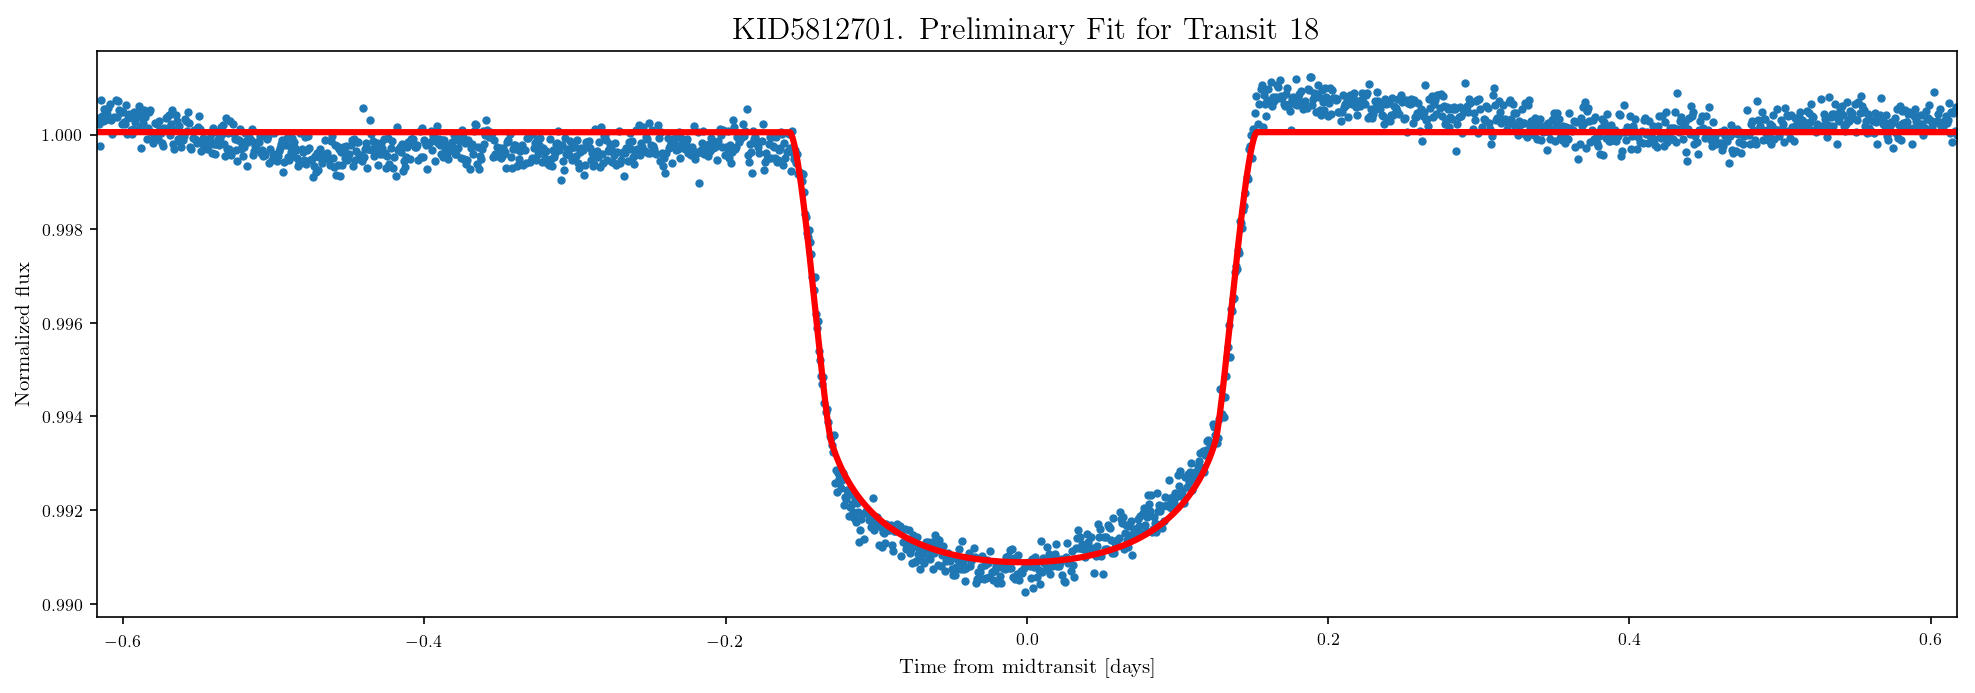

------ Pre-MCMC Results ------
	Transit duration [d]:	 Fit=0.310	True=0.309
	Period [days]:	 Fit=18.72462045	True=17.85522168
	Impact Parameter:	 Fit=0.270472	True=0.075000
	Depth:	 Fit=0.007929	True=0.009065
	Stellar mass:	 Fit=1.378	True=1.386
	Stellar radius:	 Fit=1.628	True=1.631
	Sigma (white noise):	 Fit=0.000
	Out-of-transit flux:	 Fit=1.000

------ Prepare MCMC -------
Guess impact parameter: 0.2704724271588496
Guess of Rp [in Rsun]:  0.14494961516364763
1+rp_guess/rs:  1.0890449838083716
Running burn-in


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
100%|██████████| 250/250 [01:01<00:00,  4.32it/s]



------ Run MCMC -------


100%|██████████| 1000/1000 [03:46<00:00,  4.58it/s]



------ Post-MCMC Results ------

Depth:
	True = 0.009
	MCMC Fit = 0.008 (+0.000,-0.000)

Impact parameter:
	True = 0.075
	MCMC Fit = 0.249 (+0.060,-0.072)

Planet radius [REarth]:
	True = 13.160
	MCMC Fit = 15.816 (+0.352,-0.403)

Period [d]:
	True = 17.855
	MCMC Fit = 18.434 (+1.953,-1.678)

Inverse of scaled semi-major axis:
	True = 0.0500
	MCMC Fit = 0.0493 (+0.0014,-0.0014)

Stellar radius [Rsun]:
	True = 1.631
	MCMC Fit = 1.630 (+0.036,-0.040)

Stellar Mass [Msun]:
	True = 1.386
	MCMC Fit = 1.384 (+0.065,-0.070)
Mean acceptance fraction: 0.36752
Acceptance fraction: 36.75 %

	*TRANSIT 23
		Signal = 0.00799. Noise (rms) = 0.00032. SNR = 24.76736
		Out-of-transit error of the transit LC = 0.00032
Max. depth (guess) = 1.10100
Depth guess = 0.01020. True depth = 0.00907


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in multiply
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in subtract


Optimization terminated successfully.
         Current function value: -13050.950064
         Iterations: 1875
         Function evaluations: 2787
Optimization terminated successfully.
         Current function value: -13056.172476
         Iterations: 1133
         Function evaluations: 1673


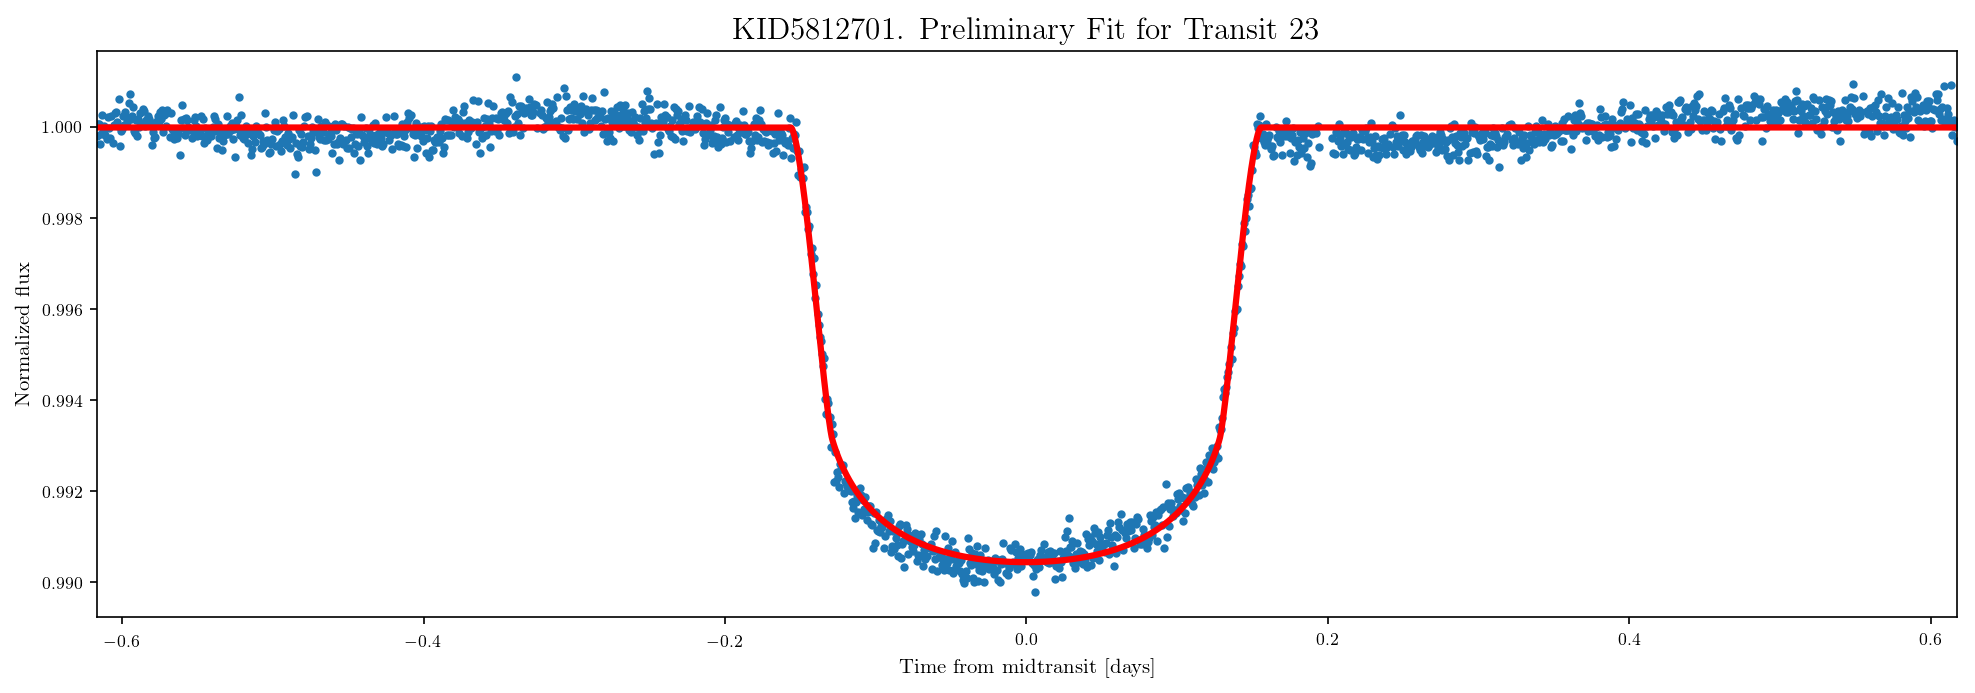

------ Pre-MCMC Results ------
	Transit duration [d]:	 Fit=0.312	True=0.309
	Period [days]:	 Fit=18.32323430	True=17.85522168
	Impact Parameter:	 Fit=0.228797	True=0.075000
	Depth:	 Fit=0.008210	True=0.009065
	Stellar mass:	 Fit=1.383	True=1.386
	Stellar radius:	 Fit=1.633	True=1.631
	Sigma (white noise):	 Fit=0.000
	Out-of-transit flux:	 Fit=1.000

------ Prepare MCMC -------
Guess impact parameter: 0.2287968961712074
Guess of Rp [in Rsun]:  0.1479932958451554
1+rp_guess/rs:  1.090607635849285
Running burn-in


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
100%|██████████| 250/250 [01:01<00:00,  4.47it/s]



------ Run MCMC -------


100%|██████████| 1000/1000 [03:50<00:00,  4.62it/s]



------ Post-MCMC Results ------

Depth:
	True = 0.009
	MCMC Fit = 0.008 (+0.000,-0.000)

Impact parameter:
	True = 0.075
	MCMC Fit = 0.227 (+0.048,-0.063)

Planet radius [REarth]:
	True = 13.160
	MCMC Fit = 16.112 (+0.370,-0.394)

Period [d]:
	True = 17.855
	MCMC Fit = 18.563 (+1.874,-1.790)

Inverse of scaled semi-major axis:
	True = 0.0500
	MCMC Fit = 0.0500 (+0.0015,-0.0015)

Stellar radius [Rsun]:
	True = 1.631
	MCMC Fit = 1.631 (+0.037,-0.040)

Stellar Mass [Msun]:
	True = 1.386
	MCMC Fit = 1.392 (+0.068,-0.076)
Mean acceptance fraction: 0.35888000000000003
Acceptance fraction: 35.89 %

	*TRANSIT 24
		Signal = 0.00718. Noise (rms) = 0.00030. SNR = 24.11042
		Out-of-transit error of the transit LC = 0.00030
Max. depth (guess) = 1.09768
Depth guess = 0.00954. True depth = 0.00907


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in subtract


Optimization terminated successfully.
         Current function value: -6084.005919
         Iterations: 2085
         Function evaluations: 3054
Optimization terminated successfully.
         Current function value: -6084.477134
         Iterations: 1682
         Function evaluations: 2489


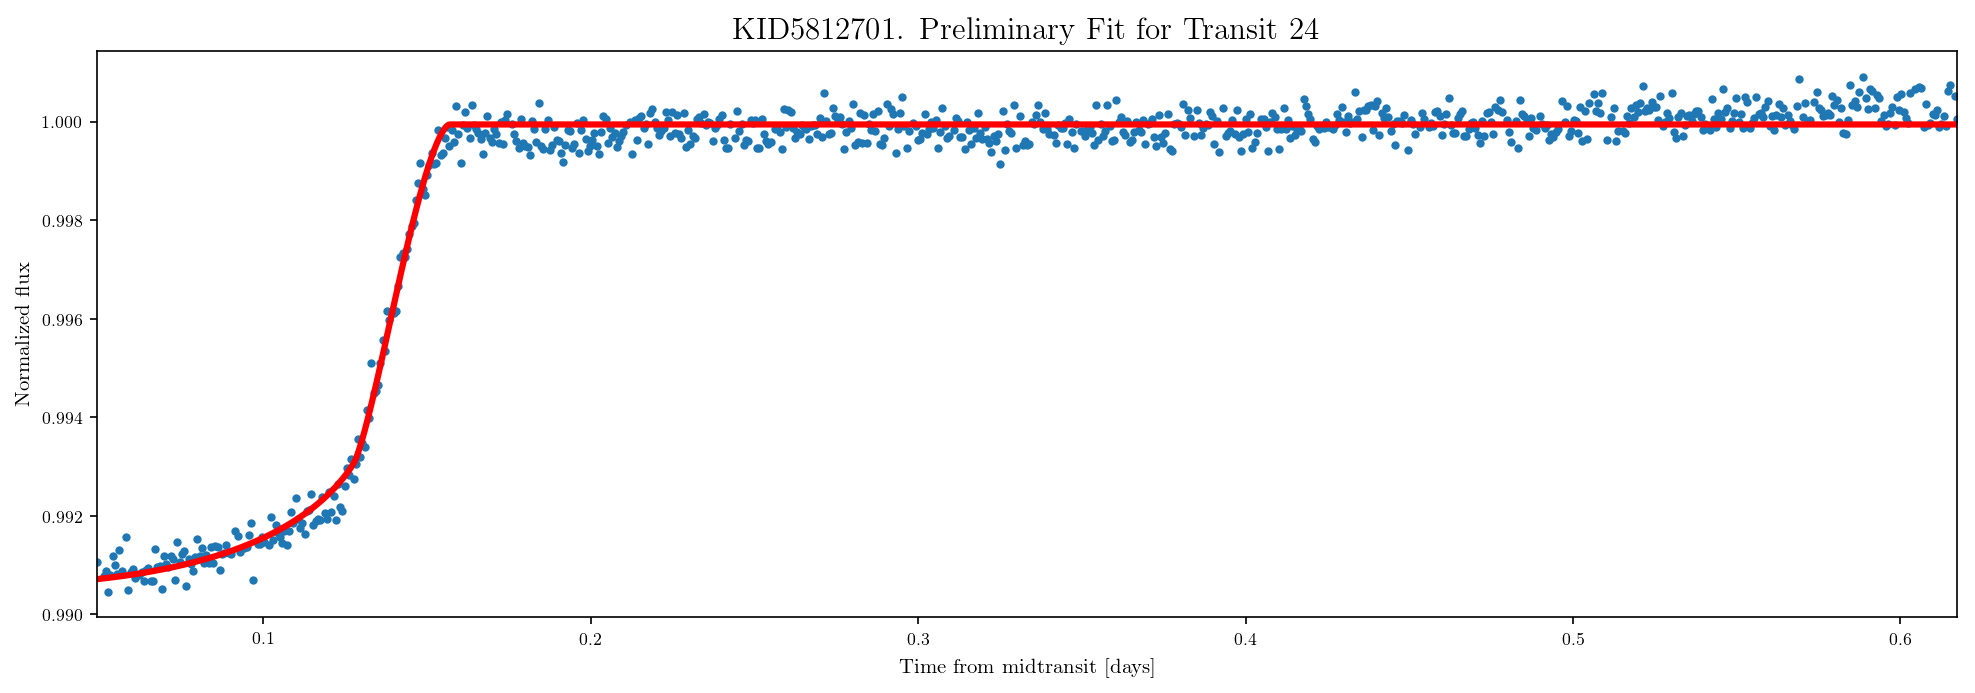

/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
  0%|          | 0/250 [00:00<?, ?it/s]

------ Pre-MCMC Results ------
	Transit duration [d]:	 Fit=0.286	True=0.309
	Period [days]:	 Fit=16.51880665	True=17.85522168
	Impact Parameter:	 Fit=0.442487	True=0.075000
	Depth:	 Fit=0.008255	True=0.009065
	Stellar mass:	 Fit=1.368	True=1.386
	Stellar radius:	 Fit=1.651	True=1.631
	Sigma (white noise):	 Fit=0.000
	Out-of-transit flux:	 Fit=1.000

------ Prepare MCMC -------
Guess impact parameter: 0.44248709776530026
Guess of Rp [in Rsun]:  0.1499855172374377
1+rp_guess/rs:  1.0908595421213645
Running burn-in


  0%|          | 0/1000 [00:00<?, ?it/s]


------ Run MCMC -------


100%|██████████| 1000/1000 [01:53<00:00,  8.80it/s]



------ Post-MCMC Results ------

Depth:
	True = 0.009
	MCMC Fit = 0.008 (+0.000,-0.000)

Impact parameter:
	True = 0.075
	MCMC Fit = 0.571 (+0.055,-0.080)

Planet radius [REarth]:
	True = 13.160
	MCMC Fit = 16.041 (+0.357,-0.397)

Period [d]:
	True = 17.855
	MCMC Fit = 14.783 (+2.194,-0.951)

Inverse of scaled semi-major axis:
	True = 0.0500
	MCMC Fit = 0.0524 (+0.0015,-0.0015)

Stellar radius [Rsun]:
	True = 1.631
	MCMC Fit = 1.607 (+0.036,-0.039)

Stellar Mass [Msun]:
	True = 1.386
	MCMC Fit = 1.423 (+0.068,-0.073)
Mean acceptance fraction: 0.35934
Acceptance fraction: 35.93 %

	*TRANSIT 25
		Signal = 0.00785. Noise (rms) = 0.00030. SNR = 25.98730
		Out-of-transit error of the transit LC = 0.00030
Max. depth (guess) = 1.09941
Depth guess = 0.00988. True depth = 0.00907


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in subtract


Optimization terminated successfully.
         Current function value: -13280.839845
         Iterations: 2646
         Function evaluations: 3878
Optimization terminated successfully.
         Current function value: -13285.086287
         Iterations: 1520
         Function evaluations: 2245


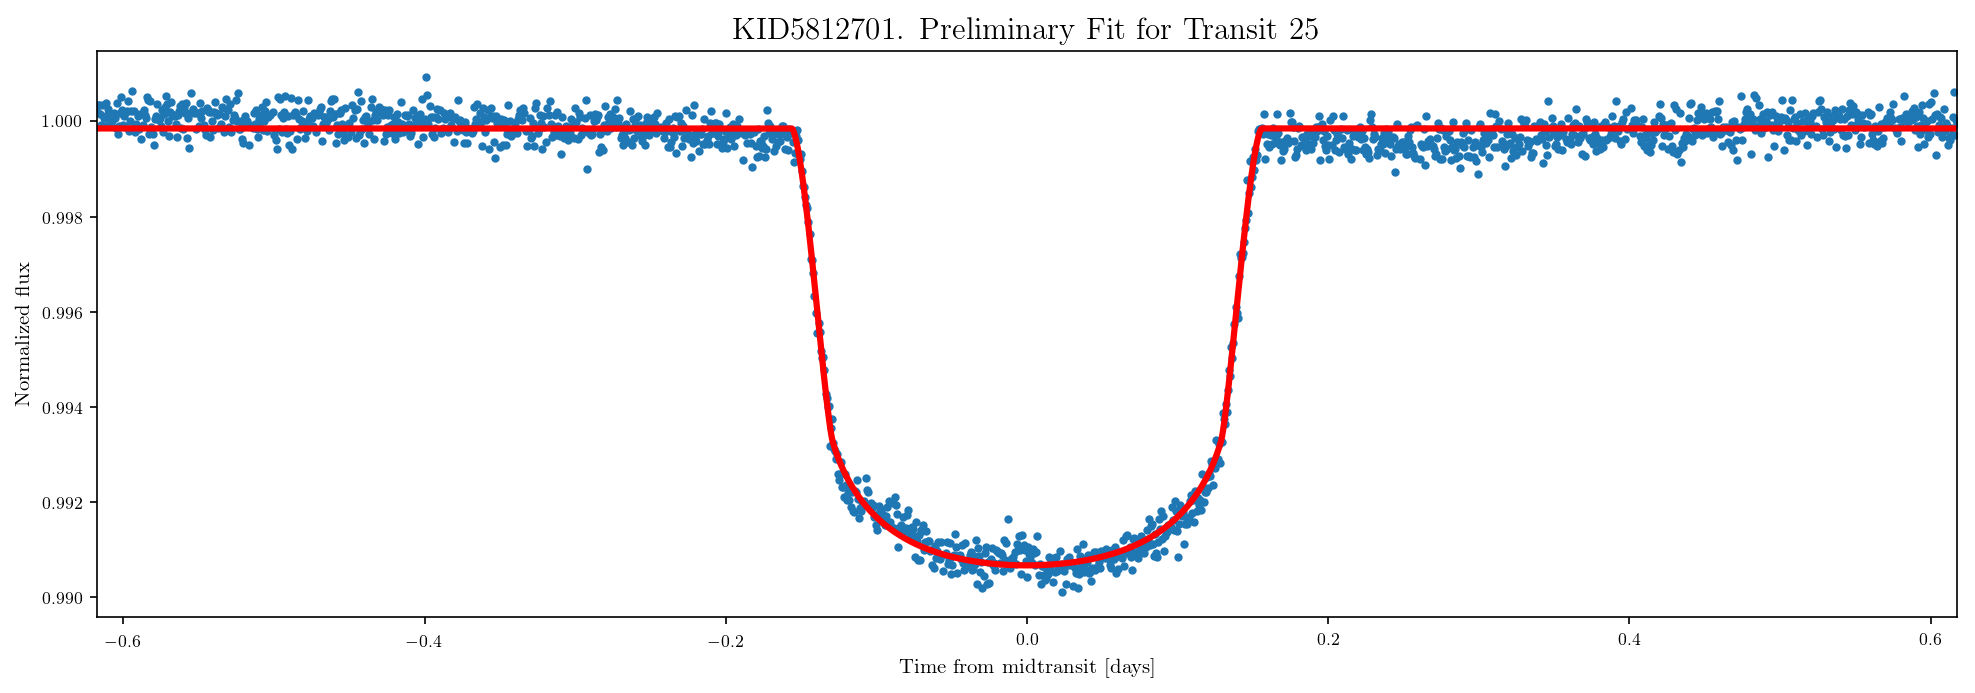

------ Pre-MCMC Results ------
	Transit duration [d]:	 Fit=0.312	True=0.309
	Period [days]:	 Fit=18.43794566	True=17.85522168
	Impact Parameter:	 Fit=0.230312	True=0.075000
	Depth:	 Fit=0.007906	True=0.009065
	Stellar mass:	 Fit=1.382	True=1.386
	Stellar radius:	 Fit=1.633	True=1.631
	Sigma (white noise):	 Fit=0.000
	Out-of-transit flux:	 Fit=1.000

------ Prepare MCMC -------
Guess impact parameter: 0.23031238363367543
Guess of Rp [in Rsun]:  0.14522181335362802
1+rp_guess/rs:  1.0889142382467658
Running burn-in


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
100%|██████████| 250/250 [01:02<00:00,  4.27it/s]



------ Run MCMC -------


100%|██████████| 1000/1000 [03:45<00:00,  4.63it/s]



------ Post-MCMC Results ------

Depth:
	True = 0.009
	MCMC Fit = 0.008 (+0.000,-0.000)

Impact parameter:
	True = 0.075
	MCMC Fit = 0.222 (+0.041,-0.055)

Planet radius [REarth]:
	True = 13.160
	MCMC Fit = 15.796 (+0.371,-0.381)

Period [d]:
	True = 17.855
	MCMC Fit = 18.545 (+1.794,-1.473)

Inverse of scaled semi-major axis:
	True = 0.0500
	MCMC Fit = 0.0498 (+0.0014,-0.0015)

Stellar radius [Rsun]:
	True = 1.631
	MCMC Fit = 1.630 (+0.038,-0.039)

Stellar Mass [Msun]:
	True = 1.386
	MCMC Fit = 1.393 (+0.072,-0.073)
Mean acceptance fraction: 0.36555000000000004
Acceptance fraction: 36.56 %

	*TRANSIT 26
		Signal = 0.00776. Noise (rms) = 0.00036. SNR = 21.35576
		Out-of-transit error of the transit LC = 0.00036
Max. depth (guess) = 1.09987
Depth guess = 0.00997. True depth = 0.00907


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in multiply
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in subtract


Optimization terminated successfully.
         Current function value: -12390.774664
         Iterations: 1686
         Function evaluations: 2523
Optimization terminated successfully.
         Current function value: -12753.568241
         Iterations: 2323
         Function evaluations: 3435


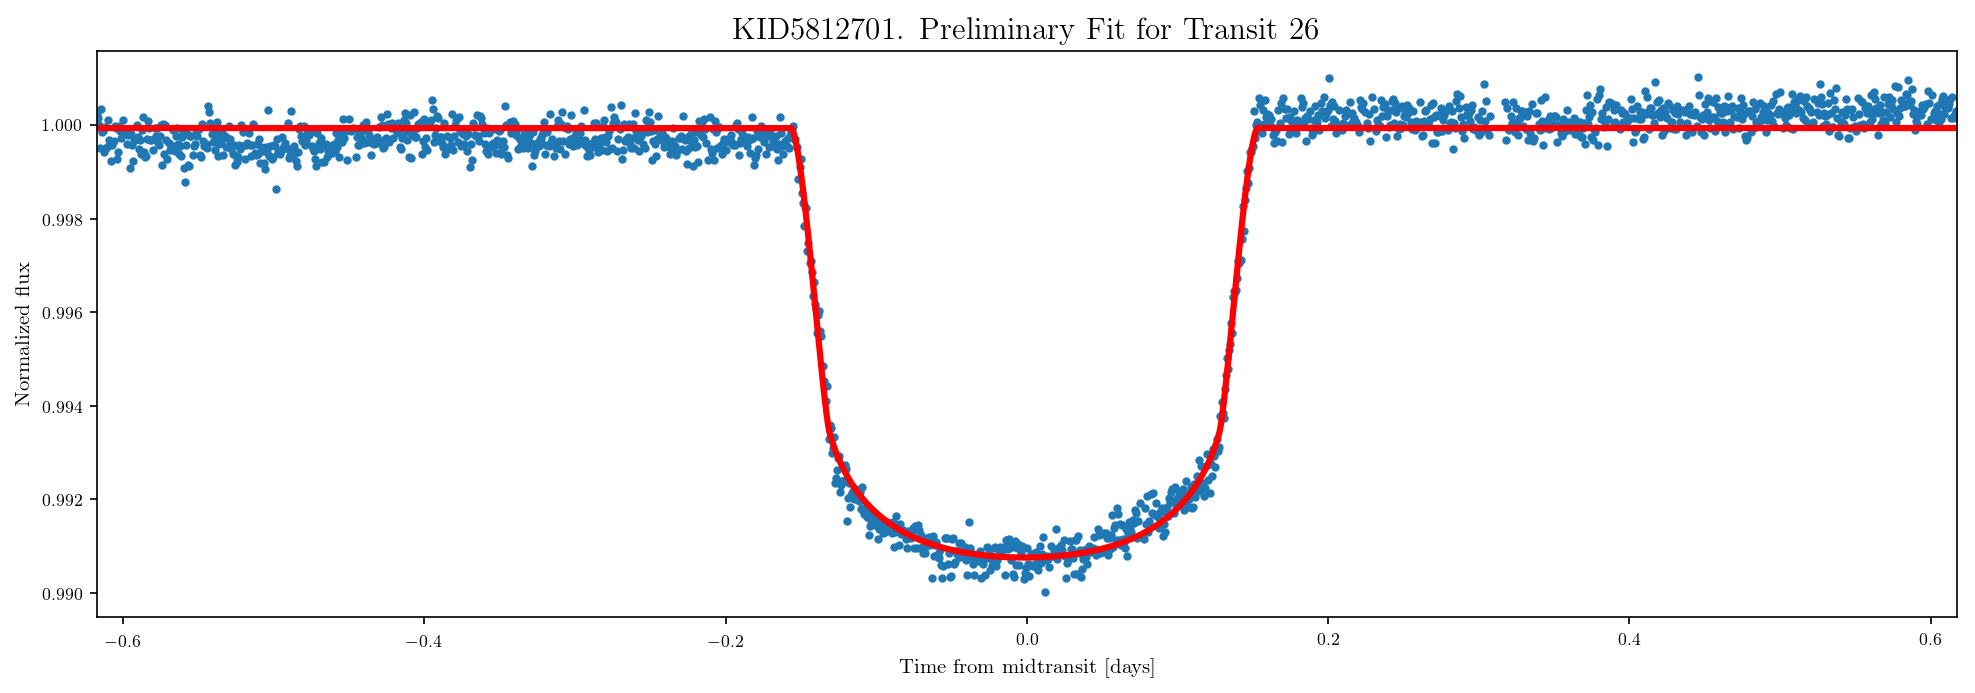

------ Pre-MCMC Results ------
	Transit duration [d]:	 Fit=0.309	True=0.309
	Period [days]:	 Fit=16.82571548	True=17.85522168
	Impact Parameter:	 Fit=0.000000	True=0.075000
	Depth:	 Fit=0.007843	True=0.009065
	Stellar mass:	 Fit=1.382	True=1.386
	Stellar radius:	 Fit=1.634	True=1.631
	Sigma (white noise):	 Fit=0.000
	Out-of-transit flux:	 Fit=1.000

------ Prepare MCMC -------
Guess impact parameter: 8.021610215045668e-11
Guess of Rp [in Rsun]:  0.14468120235756537
1+rp_guess/rs:  1.0885608152511002
Running burn-in


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
100%|██████████| 250/250 [00:56<00:00,  4.94it/s]



------ Run MCMC -------


100%|██████████| 1000/1000 [03:25<00:00,  5.32it/s]



------ Post-MCMC Results ------

Depth:
	True = 0.009
	MCMC Fit = 0.008 (+0.000,-0.000)

Impact parameter:
	True = 0.075
	MCMC Fit = 0.000 (+0.000,-0.000)

Planet radius [REarth]:
	True = 13.160
	MCMC Fit = 15.769 (+0.378,-0.382)

Period [d]:
	True = 17.855
	MCMC Fit = 16.899 (+1.608,-1.463)

Inverse of scaled semi-major axis:
	True = 0.0500
	MCMC Fit = 0.0530 (+0.0016,-0.0016)

Stellar radius [Rsun]:
	True = 1.631
	MCMC Fit = 1.633 (+0.039,-0.040)

Stellar Mass [Msun]:
	True = 1.386
	MCMC Fit = 1.390 (+0.074,-0.078)


Mean acceptance fraction: 0.39967999999999987
Acceptance fraction: 39.97 %

	*TRANSIT 27
		Signal = 0.00781. Noise (rms) = 0.00037. SNR = 21.00099
		Out-of-transit error of the transit LC = 0.00037
Max. depth (guess) = 1.09960
Depth guess = 0.00992. True depth = 0.00907


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in multiply
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in subtract


Optimization terminated successfully.
         Current function value: -12828.743340
         Iterations: 3226
         Function evaluations: 4715
Optimization terminated successfully.
         Current function value: -12827.307245
         Iterations: 1590
         Function evaluations: 2344


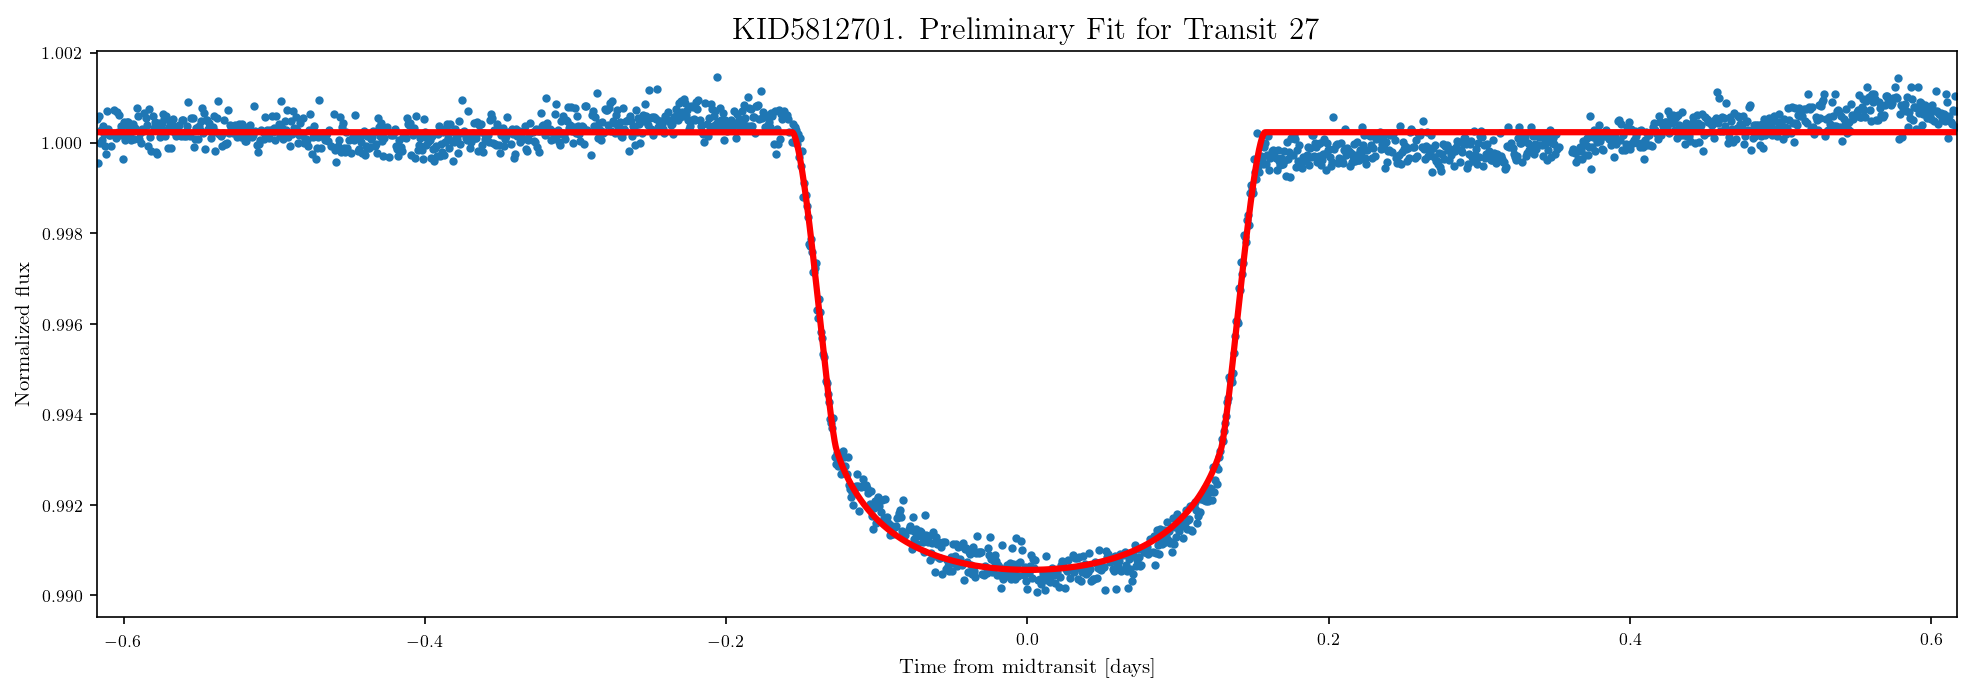

------ Pre-MCMC Results ------
	Transit duration [d]:	 Fit=0.314	True=0.309
	Period [days]:	 Fit=19.69655049	True=17.85522168
	Impact Parameter:	 Fit=0.309862	True=0.075000
	Depth:	 Fit=0.008389	True=0.009065
	Stellar mass:	 Fit=1.382	True=1.386
	Stellar radius:	 Fit=1.634	True=1.631
	Sigma (white noise):	 Fit=0.000
	Out-of-transit flux:	 Fit=1.000

------ Prepare MCMC -------
Guess impact parameter: 0.3098622732215377
Guess of Rp [in Rsun]:  0.1496175854240934
1+rp_guess/rs:  1.0915920978226343
Running burn-in


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
100%|██████████| 250/250 [01:01<00:00,  4.33it/s]



------ Run MCMC -------


100%|██████████| 1000/1000 [03:52<00:00,  4.52it/s]



------ Post-MCMC Results ------

Depth:
	True = 0.009
	MCMC Fit = 0.008 (+0.000,-0.000)

Impact parameter:
	True = 0.075
	MCMC Fit = 0.310 (+0.033,-0.045)

Planet radius [REarth]:
	True = 13.160
	MCMC Fit = 16.267 (+0.365,-0.366)

Period [d]:
	True = 17.855
	MCMC Fit = 19.795 (+1.874,-1.626)

Inverse of scaled semi-major axis:
	True = 0.0500
	MCMC Fit = 0.0477 (+0.0013,-0.0013)

Stellar radius [Rsun]:
	True = 1.631
	MCMC Fit = 1.629 (+0.036,-0.036)

Stellar Mass [Msun]:
	True = 1.386
	MCMC Fit = 1.386 (+0.066,-0.071)
Mean acceptance fraction: 0.38205
Acceptance fraction: 38.20 %

	*TRANSIT 28
		Signal = 0.00751. Noise (rms) = 0.00037. SNR = 20.40620
		Out-of-transit error of the transit LC = 0.00037
Max. depth (guess) = 1.09849
Depth guess = 0.00970. True depth = 0.00907


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in multiply
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in subtract


Optimization terminated successfully.
         Current function value: -12217.596073
         Iterations: 1281
         Function evaluations: 1943
Optimization terminated successfully.
         Current function value: -12807.782547
         Iterations: 1793
         Function evaluations: 2625


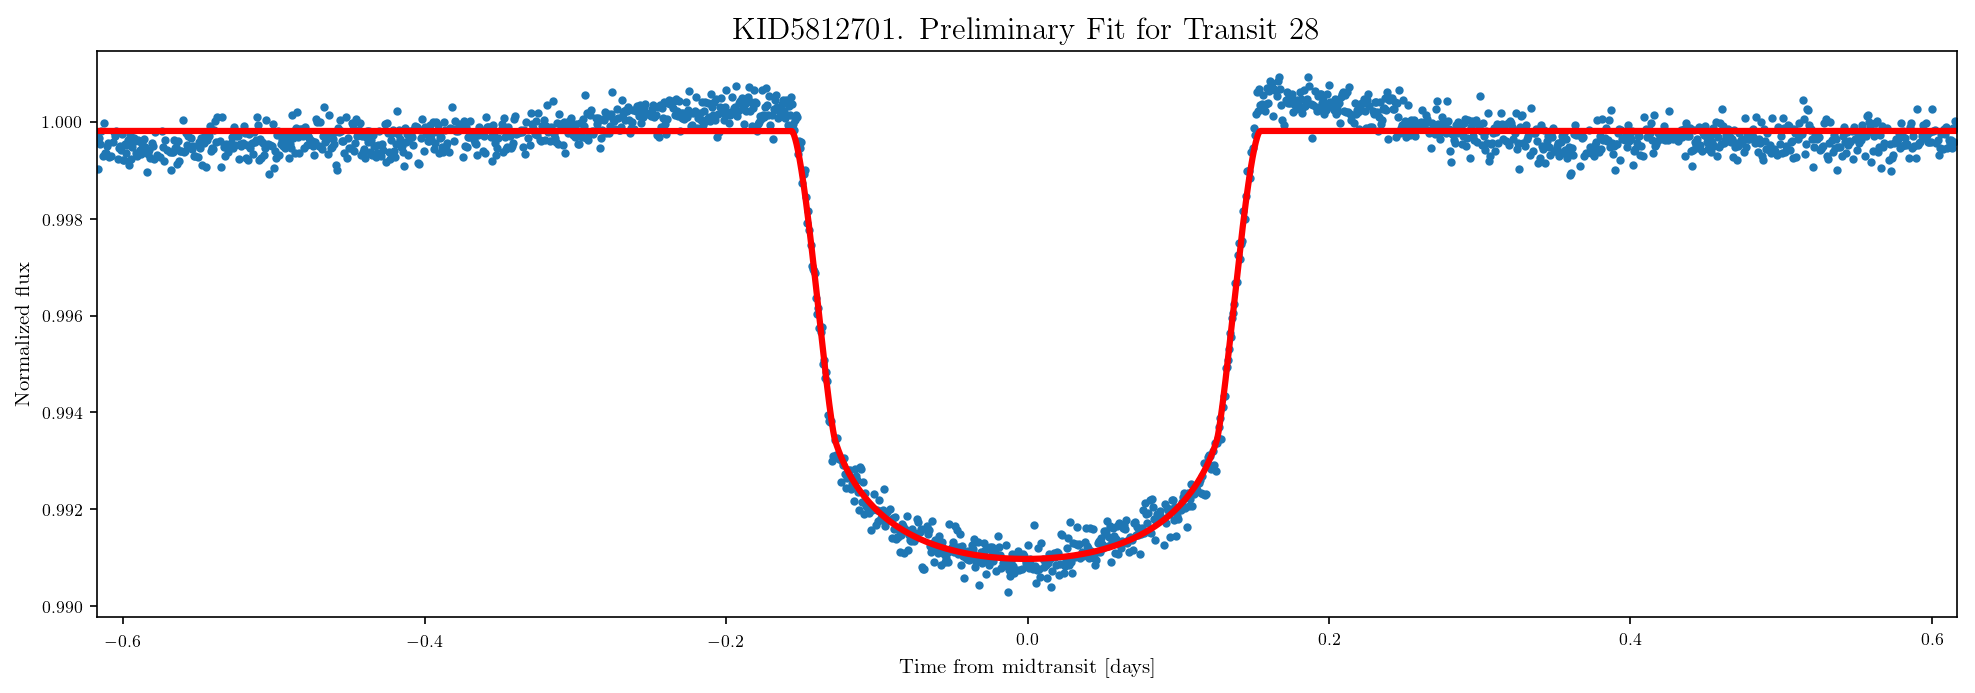

------ Pre-MCMC Results ------
	Transit duration [d]:	 Fit=0.311	True=0.309
	Period [days]:	 Fit=26.67960711	True=17.85522168
	Impact Parameter:	 Fit=0.364949	True=0.075000
	Depth:	 Fit=0.007707	True=0.009065
	Stellar mass:	 Fit=1.537	True=1.386
	Stellar radius:	 Fit=1.549	True=1.631
	Sigma (white noise):	 Fit=0.000
	Out-of-transit flux:	 Fit=1.000

------ Prepare MCMC -------
Guess impact parameter: 0.3649488601156412
Guess of Rp [in Rsun]:  0.13597585384608205
1+rp_guess/rs:  1.0877870049188991
Running burn-in


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
100%|██████████| 250/250 [01:00<00:00,  4.45it/s]



------ Run MCMC -------


100%|██████████| 1000/1000 [04:32<00:00,  4.92it/s]



------ Post-MCMC Results ------

Depth:
	True = 0.009
	MCMC Fit = 0.008 (+0.000,-0.000)

Impact parameter:
	True = 0.075
	MCMC Fit = 0.176 (+0.064,-0.069)

Planet radius [REarth]:
	True = 13.160
	MCMC Fit = 15.375 (+0.348,-0.350)

Period [d]:
	True = 17.855
	MCMC Fit = 17.781 (+1.792,-1.522)

Inverse of scaled semi-major axis:
	True = 0.0500
	MCMC Fit = 0.0387 (+0.0011,-0.0011)

Stellar radius [Rsun]:
	True = 1.631
	MCMC Fit = 1.622 (+0.037,-0.038)

Stellar Mass [Msun]:
	True = 1.386
	MCMC Fit = 1.387 (+0.070,-0.067)
Mean acceptance fraction: 0.38537
Acceptance fraction: 38.54 %

	*TRANSIT 29
		Signal = 0.00729. Noise (rms) = 0.00036. SNR = 20.32348
		Out-of-transit error of the transit LC = 0.00036
Max. depth (guess) = 1.09654
Depth guess = 0.00932. True depth = 0.00907


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in multiply
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in subtract


Optimization terminated successfully.
         Current function value: -12216.767504
         Iterations: 1521
         Function evaluations: 2264
Optimization terminated successfully.
         Current function value: -12394.506652
         Iterations: 1151
         Function evaluations: 1721


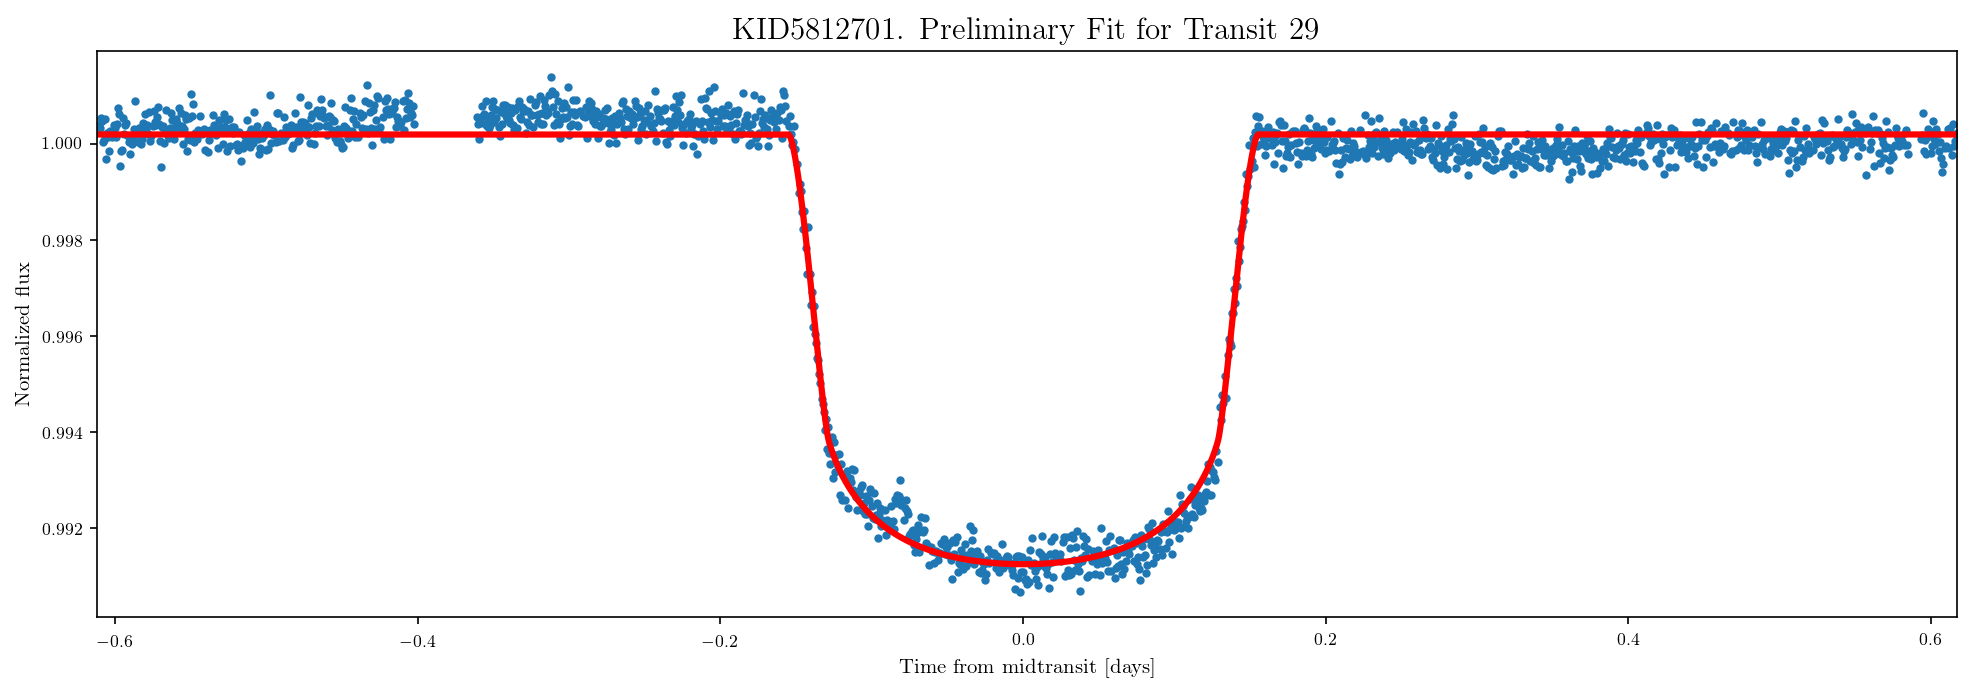

------ Pre-MCMC Results ------
	Transit duration [d]:	 Fit=0.310	True=0.309
	Period [days]:	 Fit=19.84667999	True=17.85522168
	Impact Parameter:	 Fit=0.233995	True=0.075000
	Depth:	 Fit=0.007696	True=0.009065
	Stellar mass:	 Fit=1.442	True=1.386
	Stellar radius:	 Fit=1.611	True=1.631
	Sigma (white noise):	 Fit=0.000
	Out-of-transit flux:	 Fit=1.000

------ Prepare MCMC -------
Guess impact parameter: 0.2339954006348447
Guess of Rp [in Rsun]:  0.14132852739115812
1+rp_guess/rs:  1.0877269871531272
Running burn-in


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
100%|██████████| 250/250 [00:59<00:00,  4.51it/s]



------ Run MCMC -------


100%|██████████| 1000/1000 [03:39<00:00,  5.21it/s]



------ Post-MCMC Results ------

Depth:
	True = 0.009
	MCMC Fit = 0.008 (+0.000,-0.000)

Impact parameter:
	True = 0.075
	MCMC Fit = 0.134 (+0.070,-0.076)

Planet radius [REarth]:
	True = 13.160
	MCMC Fit = 15.520 (+0.342,-0.350)

Period [d]:
	True = 17.855
	MCMC Fit = 17.649 (+1.647,-1.393)

Inverse of scaled semi-major axis:
	True = 0.0500
	MCMC Fit = 0.0473 (+0.0013,-0.0013)

Stellar radius [Rsun]:
	True = 1.631
	MCMC Fit = 1.627 (+0.036,-0.037)

Stellar Mass [Msun]:
	True = 1.386
	MCMC Fit = 1.396 (+0.070,-0.073)
Mean acceptance fraction: 0.36182999999999993
Acceptance fraction: 36.18 %

	*TRANSIT 30
		Signal = 0.00727. Noise (rms) = 0.00038. SNR = 19.12094
		Out-of-transit error of the transit LC = 0.00038
Max. depth (guess) = 1.09720
Depth guess = 0.00945. True depth = 0.00907


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in multiply
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in subtract


Optimization terminated successfully.
         Current function value: -12709.580092
         Iterations: 2487
         Function evaluations: 3633
Optimization terminated successfully.
         Current function value: -12740.811330
         Iterations: 902
         Function evaluations: 1338


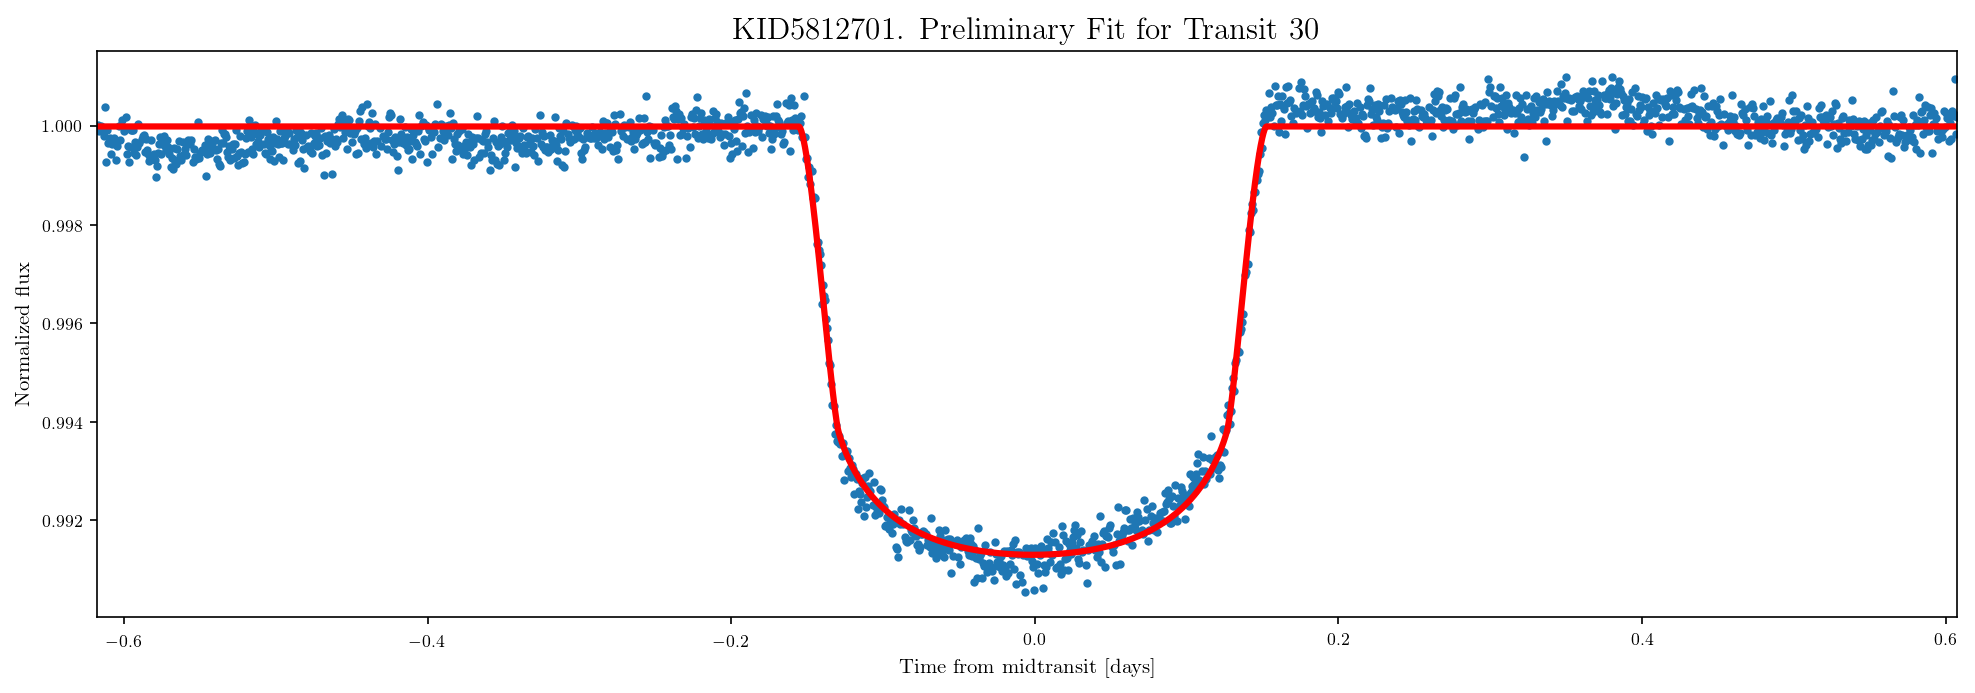

------ Pre-MCMC Results ------
	Transit duration [d]:	 Fit=0.308	True=0.309
	Period [days]:	 Fit=14.83246289	True=17.85522168
	Impact Parameter:	 Fit=0.230305	True=0.075000
	Depth:	 Fit=0.007485	True=0.009065
	Stellar mass:	 Fit=1.324	True=1.386
	Stellar radius:	 Fit=1.712	True=1.631
	Sigma (white noise):	 Fit=0.000
	Out-of-transit flux:	 Fit=1.000

------ Prepare MCMC -------
Guess impact parameter: 0.23030546827037426
Guess of Rp [in Rsun]:  0.1481371006557405
1+rp_guess/rs:  1.0865139683930223
Running burn-in


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
100%|██████████| 250/250 [00:59<00:00,  4.42it/s]



------ Run MCMC -------


100%|██████████| 1000/1000 [03:34<00:00,  4.31it/s]



------ Post-MCMC Results ------

Depth:
	True = 0.009
	MCMC Fit = 0.007 (+0.000,-0.000)

Impact parameter:
	True = 0.075
	MCMC Fit = 0.172 (+0.068,-0.082)

Planet radius [REarth]:
	True = 13.160
	MCMC Fit = 15.389 (+0.331,-0.333)

Period [d]:
	True = 17.855
	MCMC Fit = 17.336 (+1.698,-1.471)

Inverse of scaled semi-major axis:
	True = 0.0500
	MCMC Fit = 0.0577 (+0.0016,-0.0015)

Stellar radius [Rsun]:
	True = 1.631
	MCMC Fit = 1.634 (+0.035,-0.035)

Stellar Mass [Msun]:
	True = 1.386
	MCMC Fit = 1.388 (+0.069,-0.071)
Mean acceptance fraction: 0.36406
Acceptance fraction: 36.41 %

	*TRANSIT 31
		Signal = 0.00770. Noise (rms) = 0.00028. SNR = 27.44036
		Out-of-transit error of the transit LC = 0.00028
Max. depth (guess) = 1.09888
Depth guess = 0.00978. True depth = 0.00907


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in subtract


Optimization terminated successfully.
         Current function value: -13385.901828
         Iterations: 3428
         Function evaluations: 5005
Optimization terminated successfully.
         Current function value: -13438.840193
         Iterations: 1941
         Function evaluations: 2875


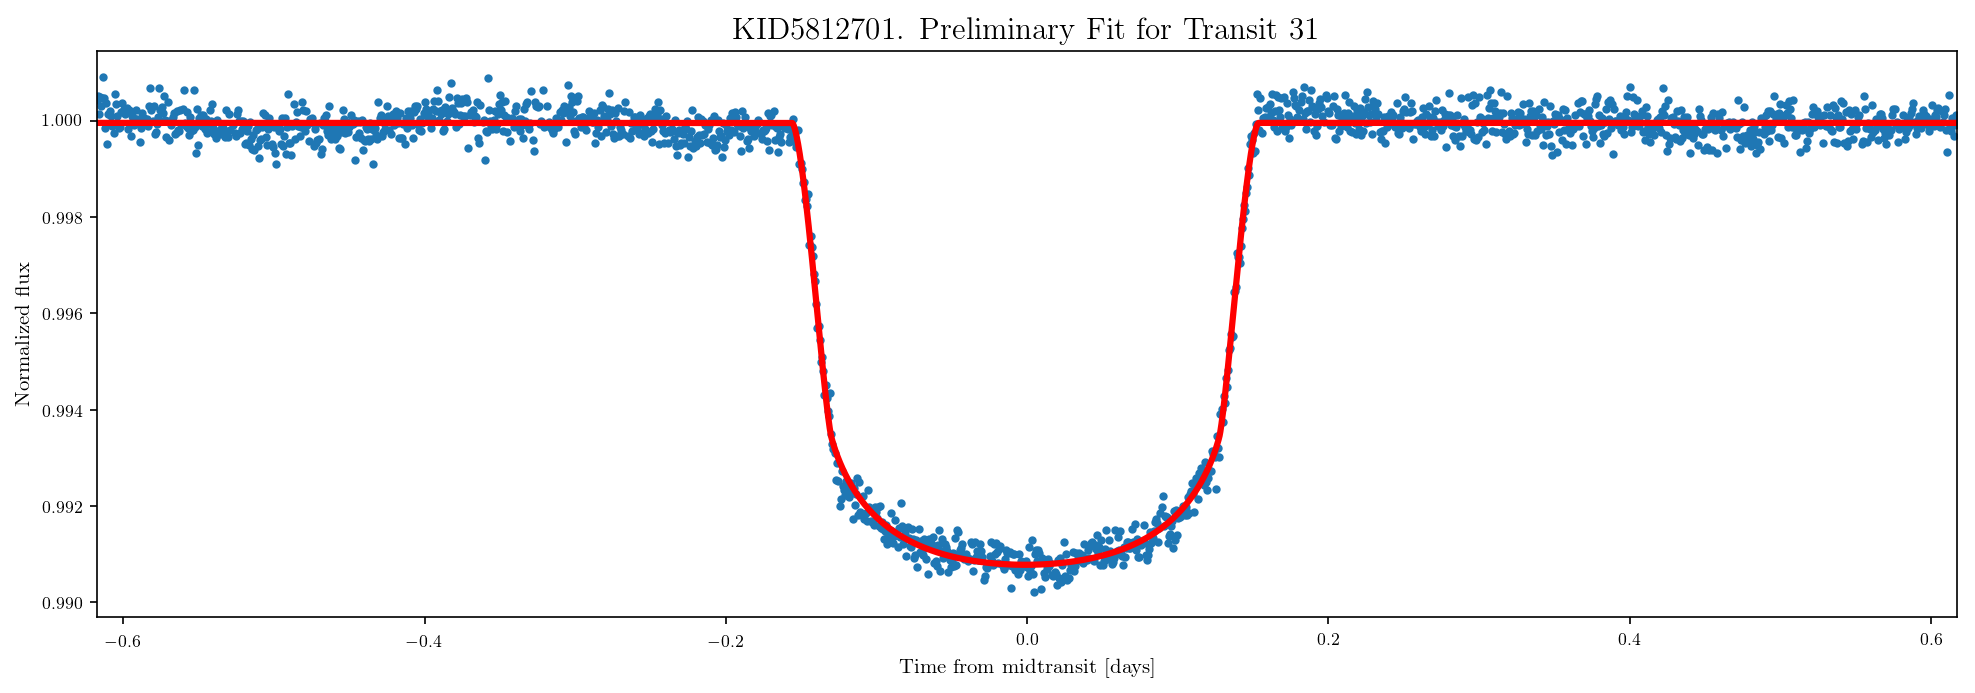

------ Pre-MCMC Results ------
	Transit duration [d]:	 Fit=0.310	True=0.309
	Period [days]:	 Fit=17.44945255	True=17.85522168
	Impact Parameter:	 Fit=0.167436	True=0.075000
	Depth:	 Fit=0.007865	True=0.009065
	Stellar mass:	 Fit=1.380	True=1.386
	Stellar radius:	 Fit=1.632	True=1.631
	Sigma (white noise):	 Fit=0.000
	Out-of-transit flux:	 Fit=1.000

------ Prepare MCMC -------
Guess impact parameter: 0.16743640339996002
Guess of Rp [in Rsun]:  0.144766201899173
1+rp_guess/rs:  1.0886829771009074
Running burn-in


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
100%|██████████| 250/250 [01:03<00:00,  4.25it/s]



------ Run MCMC -------


100%|██████████| 1000/1000 [04:03<00:00,  4.61it/s]



------ Post-MCMC Results ------

Depth:
	True = 0.009
	MCMC Fit = 0.008 (+0.000,-0.000)

Impact parameter:
	True = 0.075
	MCMC Fit = 0.149 (+0.058,-0.063)

Planet radius [REarth]:
	True = 13.160
	MCMC Fit = 15.775 (+0.340,-0.372)

Period [d]:
	True = 17.855
	MCMC Fit = 17.427 (+1.627,-1.357)

Inverse of scaled semi-major axis:
	True = 0.0500
	MCMC Fit = 0.0517 (+0.0014,-0.0014)

Stellar radius [Rsun]:
	True = 1.631
	MCMC Fit = 1.632 (+0.035,-0.039)

Stellar Mass [Msun]:
	True = 1.386
	MCMC Fit = 1.388 (+0.071,-0.077)
Mean acceptance fraction: 0.35799
Acceptance fraction: 35.80 %

	*TRANSIT 32
		Signal = 0.00758. Noise (rms) = 0.00038. SNR = 20.16558
		Out-of-transit error of the transit LC = 0.00038
Max. depth (guess) = 1.09856
Depth guess = 0.00971. True depth = 0.00907


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in multiply
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in subtract


Optimization terminated successfully.
         Current function value: -12767.663034
         Iterations: 3134
         Function evaluations: 4564
Optimization terminated successfully.
         Current function value: -12761.069572
         Iterations: 1437
         Function evaluations: 2152


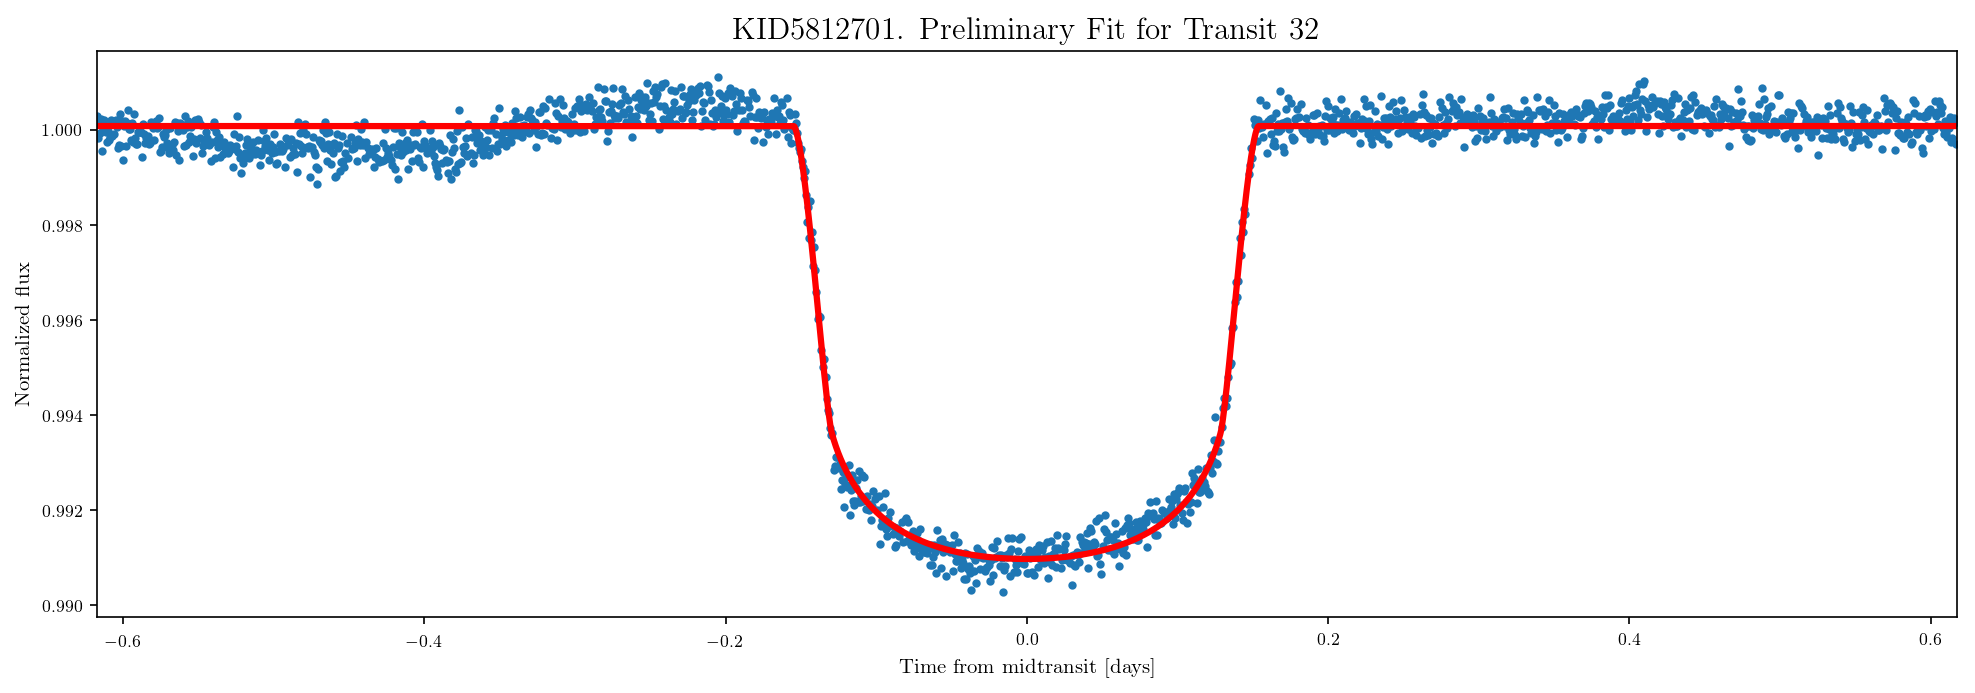

------ Pre-MCMC Results ------
	Transit duration [d]:	 Fit=0.309	True=0.309
	Period [days]:	 Fit=16.70096494	True=17.85522168
	Impact Parameter:	 Fit=0.000000	True=0.075000
	Depth:	 Fit=0.007778	True=0.009065
	Stellar mass:	 Fit=1.383	True=1.386
	Stellar radius:	 Fit=1.633	True=1.631
	Sigma (white noise):	 Fit=0.000
	Out-of-transit flux:	 Fit=1.000

------ Prepare MCMC -------
Guess impact parameter: 1.4228678137594817e-09
Guess of Rp [in Rsun]:  0.1440481428048498
1+rp_guess/rs:  1.088195076462544
Running burn-in


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
100%|██████████| 250/250 [00:59<00:00,  5.09it/s]



------ Run MCMC -------


100%|██████████| 1000/1000 [04:01<00:00,  3.87it/s]



------ Post-MCMC Results ------

Depth:
	True = 0.009
	MCMC Fit = 0.008 (+0.000,-0.000)

Impact parameter:
	True = 0.075
	MCMC Fit = 0.000 (+0.000,-0.000)

Planet radius [REarth]:
	True = 13.160
	MCMC Fit = 15.641 (+0.392,-0.403)

Period [d]:
	True = 17.855
	MCMC Fit = 16.988 (+1.655,-1.438)

Inverse of scaled semi-major axis:
	True = 0.0500
	MCMC Fit = 0.0531 (+0.0016,-0.0016)

Stellar radius [Rsun]:
	True = 1.631
	MCMC Fit = 1.627 (+0.041,-0.042)

Stellar Mass [Msun]:
	True = 1.386
	MCMC Fit = 1.393 (+0.068,-0.075)


Mean acceptance fraction: 0.39826999999999996
Acceptance fraction: 39.83 %

	*TRANSIT 33
		Signal = 0.00744. Noise (rms) = 0.00036. SNR = 20.59098
		Out-of-transit error of the transit LC = 0.00036
Max. depth (guess) = 1.09701
Depth guess = 0.00941. True depth = 0.00907


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in subtract


Optimization terminated successfully.
         Current function value: -12951.354190
         Iterations: 2620
         Function evaluations: 3849
Optimization terminated successfully.
         Current function value: -12949.971062
         Iterations: 1513
         Function evaluations: 2197


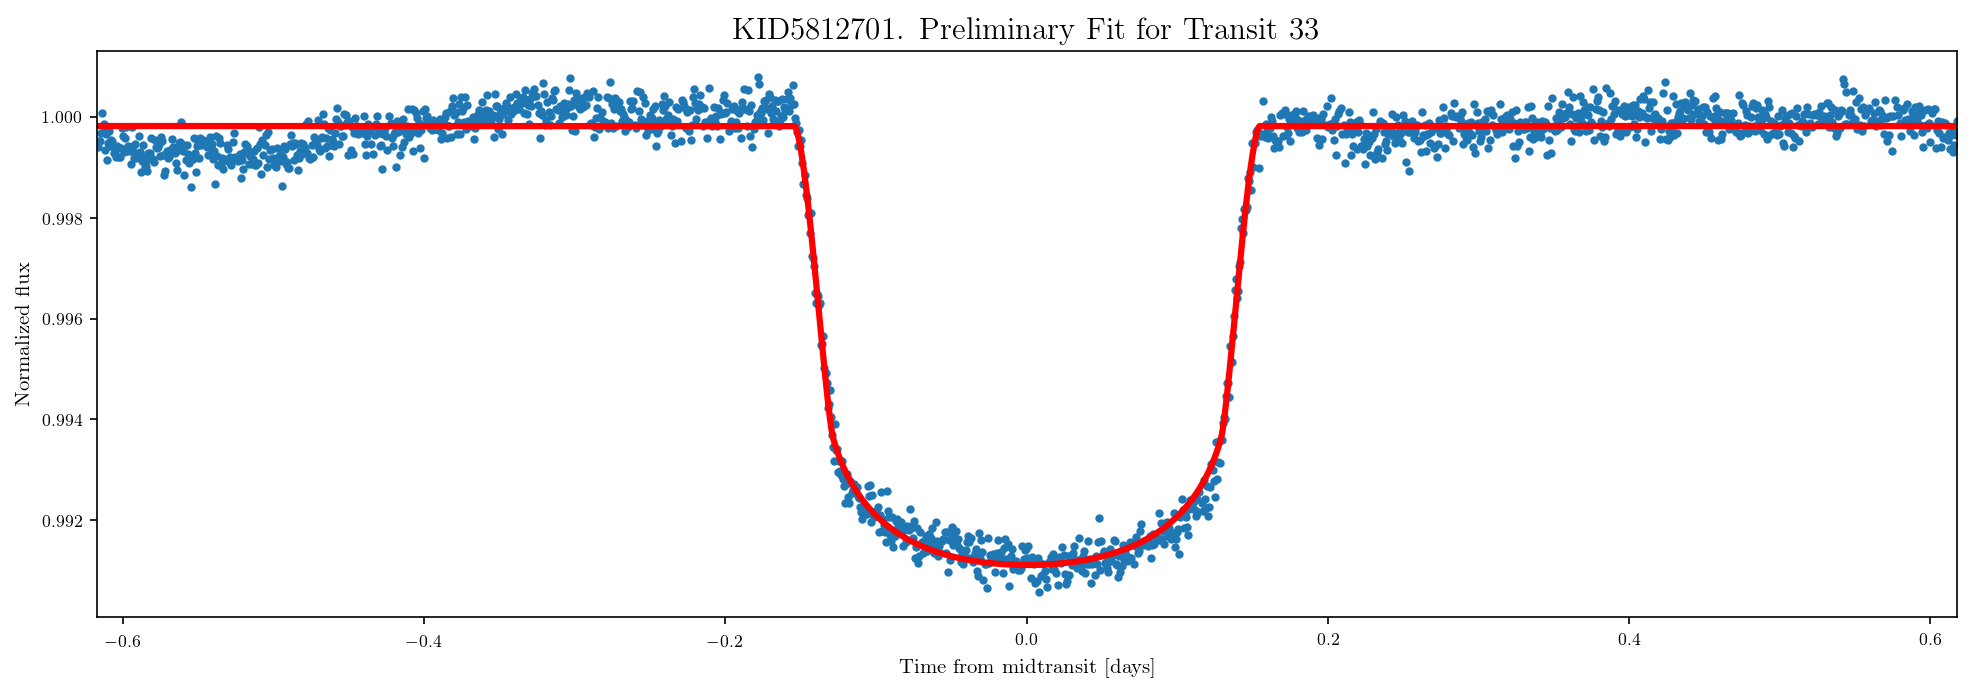

------ Pre-MCMC Results ------
	Transit duration [d]:	 Fit=0.309	True=0.309
	Period [days]:	 Fit=17.52105447	True=17.85522168
	Impact Parameter:	 Fit=0.178613	True=0.075000
	Depth:	 Fit=0.007462	True=0.009065
	Stellar mass:	 Fit=1.383	True=1.386
	Stellar radius:	 Fit=1.633	True=1.631
	Sigma (white noise):	 Fit=0.000
	Out-of-transit flux:	 Fit=1.000

------ Prepare MCMC -------
Guess impact parameter: 0.17861300258694351
Guess of Rp [in Rsun]:  0.14108350113098536
1+rp_guess/rs:  1.0863807730727608
Running burn-in


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
100%|██████████| 250/250 [01:03<00:00,  4.43it/s]



------ Run MCMC -------


100%|██████████| 1000/1000 [03:39<00:00,  4.82it/s]



------ Post-MCMC Results ------

Depth:
	True = 0.009
	MCMC Fit = 0.007 (+0.000,-0.000)

Impact parameter:
	True = 0.075
	MCMC Fit = 0.157 (+0.070,-0.081)

Planet radius [REarth]:
	True = 13.160
	MCMC Fit = 15.361 (+0.348,-0.357)

Period [d]:
	True = 17.855
	MCMC Fit = 17.579 (+1.626,-1.515)

Inverse of scaled semi-major axis:
	True = 0.0500
	MCMC Fit = 0.0516 (+0.0014,-0.0014)

Stellar radius [Rsun]:
	True = 1.631
	MCMC Fit = 1.631 (+0.036,-0.038)

Stellar Mass [Msun]:
	True = 1.386
	MCMC Fit = 1.388 (+0.072,-0.068)
Mean acceptance fraction: 0.35067
Acceptance fraction: 35.07 %

	*TRANSIT 34
		Signal = 0.00724. Noise (rms) = 0.00046. SNR = 15.68613
		Out-of-transit error of the transit LC = 0.00046
Max. depth (guess) = 1.09594
Depth guess = 0.00920. True depth = 0.00907


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in multiply
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in subtract


Optimization terminated successfully.
         Current function value: -12194.370042
         Iterations: 1655
         Function evaluations: 2467
Optimization terminated successfully.
         Current function value: -12593.637042
         Iterations: 2884
         Function evaluations: 4244


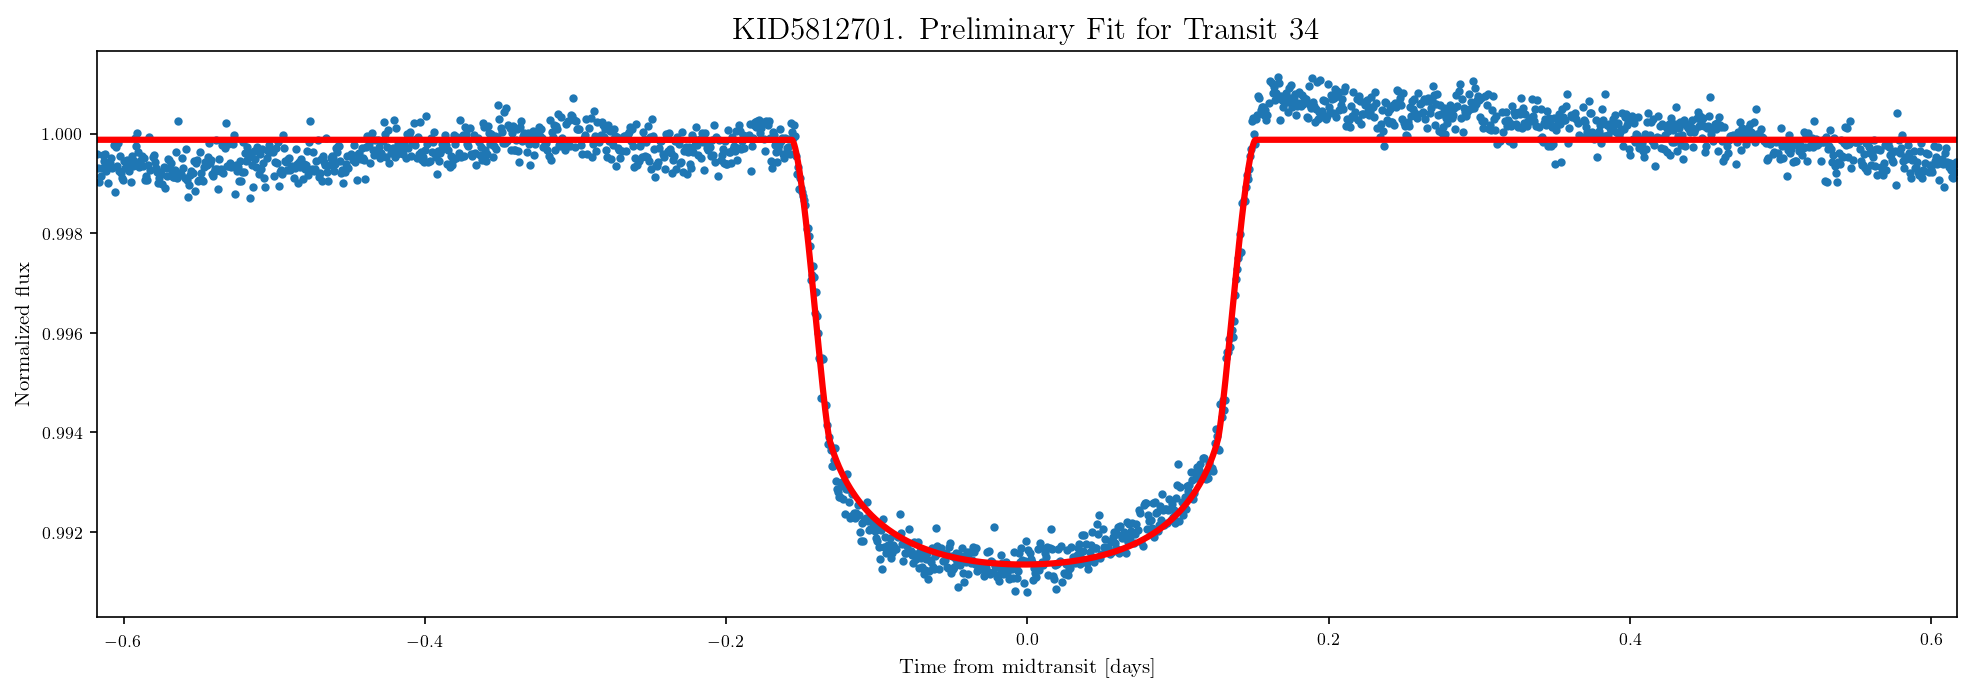

------ Pre-MCMC Results ------
	Transit duration [d]:	 Fit=0.308	True=0.309
	Period [days]:	 Fit=17.28435947	True=17.85522168
	Impact Parameter:	 Fit=0.162154	True=0.075000
	Depth:	 Fit=0.007322	True=0.009065
	Stellar mass:	 Fit=1.384	True=1.386
	Stellar radius:	 Fit=1.633	True=1.631
	Sigma (white noise):	 Fit=0.000
	Out-of-transit flux:	 Fit=1.000

------ Prepare MCMC -------
Guess impact parameter: 0.16215414447394866
Guess of Rp [in Rsun]:  0.13973796330969918
1+rp_guess/rs:  1.0855676445214266
Running burn-in


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
100%|██████████| 250/250 [01:01<00:00,  4.58it/s]



------ Run MCMC -------


100%|██████████| 1000/1000 [03:36<00:00,  4.88it/s]



------ Post-MCMC Results ------

Depth:
	True = 0.009
	MCMC Fit = 0.007 (+0.000,-0.000)

Impact parameter:
	True = 0.075
	MCMC Fit = 0.160 (+0.087,-0.092)

Planet radius [REarth]:
	True = 13.160
	MCMC Fit = 15.197 (+0.373,-0.354)

Period [d]:
	True = 17.855
	MCMC Fit = 17.729 (+1.721,-1.648)

Inverse of scaled semi-major axis:
	True = 0.0500
	MCMC Fit = 0.0519 (+0.0015,-0.0015)

Stellar radius [Rsun]:
	True = 1.631
	MCMC Fit = 1.628 (+0.039,-0.037)

Stellar Mass [Msun]:
	True = 1.386
	MCMC Fit = 1.390 (+0.072,-0.066)
Mean acceptance fraction: 0.35514
Acceptance fraction: 35.51 %

	*TRANSIT 35
		Signal = 0.00680. Noise (rms) = 0.00029. SNR = 23.39020
		Out-of-transit error of the transit LC = 0.00029
Max. depth (guess) = 1.09270
Depth guess = 0.00859. True depth = 0.00907


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in multiply
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in subtract


Optimization terminated successfully.
         Current function value: -11525.882153
         Iterations: 2399
         Function evaluations: 3508
Optimization terminated successfully.
         Current function value: -11697.879413
         Iterations: 3667
         Function evaluations: 5365


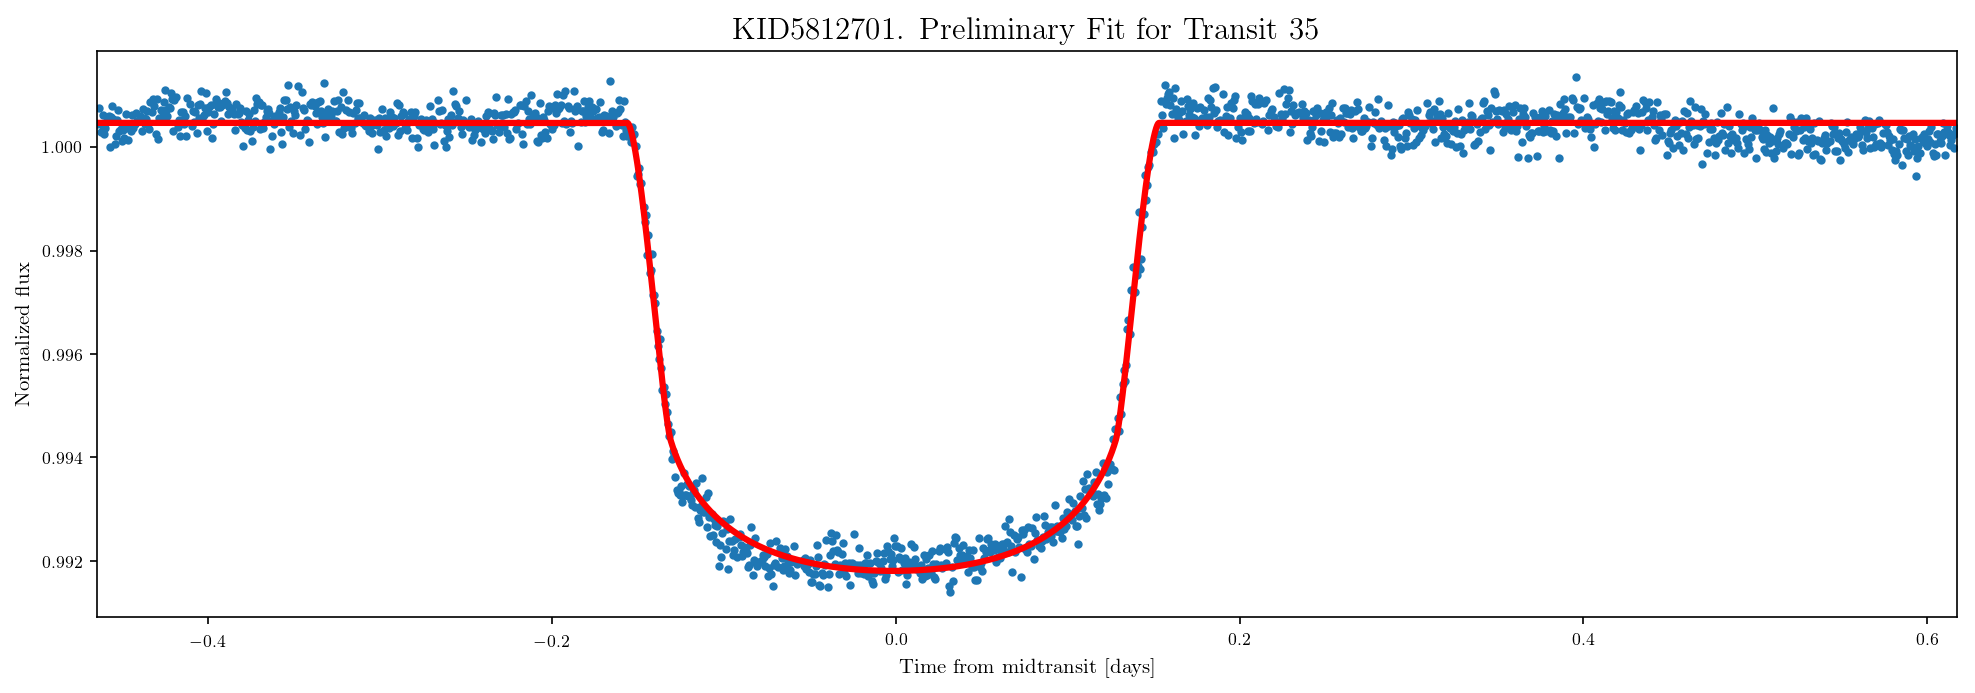

------ Pre-MCMC Results ------
	Transit duration [d]:	 Fit=0.309	True=0.309
	Period [days]:	 Fit=17.30990149	True=17.85522168
	Impact Parameter:	 Fit=0.109420	True=0.075000
	Depth:	 Fit=0.007409	True=0.009065
	Stellar mass:	 Fit=1.385	True=1.386
	Stellar radius:	 Fit=1.629	True=1.631
	Sigma (white noise):	 Fit=0.000
	Out-of-transit flux:	 Fit=1.000

------ Prepare MCMC -------
Guess impact parameter: 0.10942041021367377
Guess of Rp [in Rsun]:  0.140236953012843
1+rp_guess/rs:  1.0860764749061835
Running burn-in


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
100%|██████████| 250/250 [00:56<00:00,  5.33it/s]



------ Run MCMC -------


100%|██████████| 1000/1000 [03:17<00:00,  5.25it/s]



------ Post-MCMC Results ------

Depth:
	True = 0.009
	MCMC Fit = 0.007 (+0.000,-0.000)

Impact parameter:
	True = 0.075
	MCMC Fit = 0.083 (+0.073,-0.056)

Planet radius [REarth]:
	True = 13.160
	MCMC Fit = 15.315 (+0.326,-0.340)

Period [d]:
	True = 17.855
	MCMC Fit = 17.201 (+1.480,-1.380)

Inverse of scaled semi-major axis:
	True = 0.0500
	MCMC Fit = 0.0521 (+0.0014,-0.0014)

Stellar radius [Rsun]:
	True = 1.631
	MCMC Fit = 1.632 (+0.035,-0.036)

Stellar Mass [Msun]:
	True = 1.386
	MCMC Fit = 1.384 (+0.072,-0.074)
Mean acceptance fraction: 0.35141
Acceptance fraction: 35.14 %

	*TRANSIT 36
		Signal = 0.00770. Noise (rms) = 0.00047. SNR = 16.37973
		Out-of-transit error of the transit LC = 0.00047
Max. depth (guess) = 1.09883
Depth guess = 0.00977. True depth = 0.00907


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in multiply
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in subtract


Optimization terminated successfully.
         Current function value: -12011.759550
         Iterations: 3769
         Function evaluations: 5501
Optimization terminated successfully.
         Current function value: -12134.972927
         Iterations: 1348
         Function evaluations: 2002


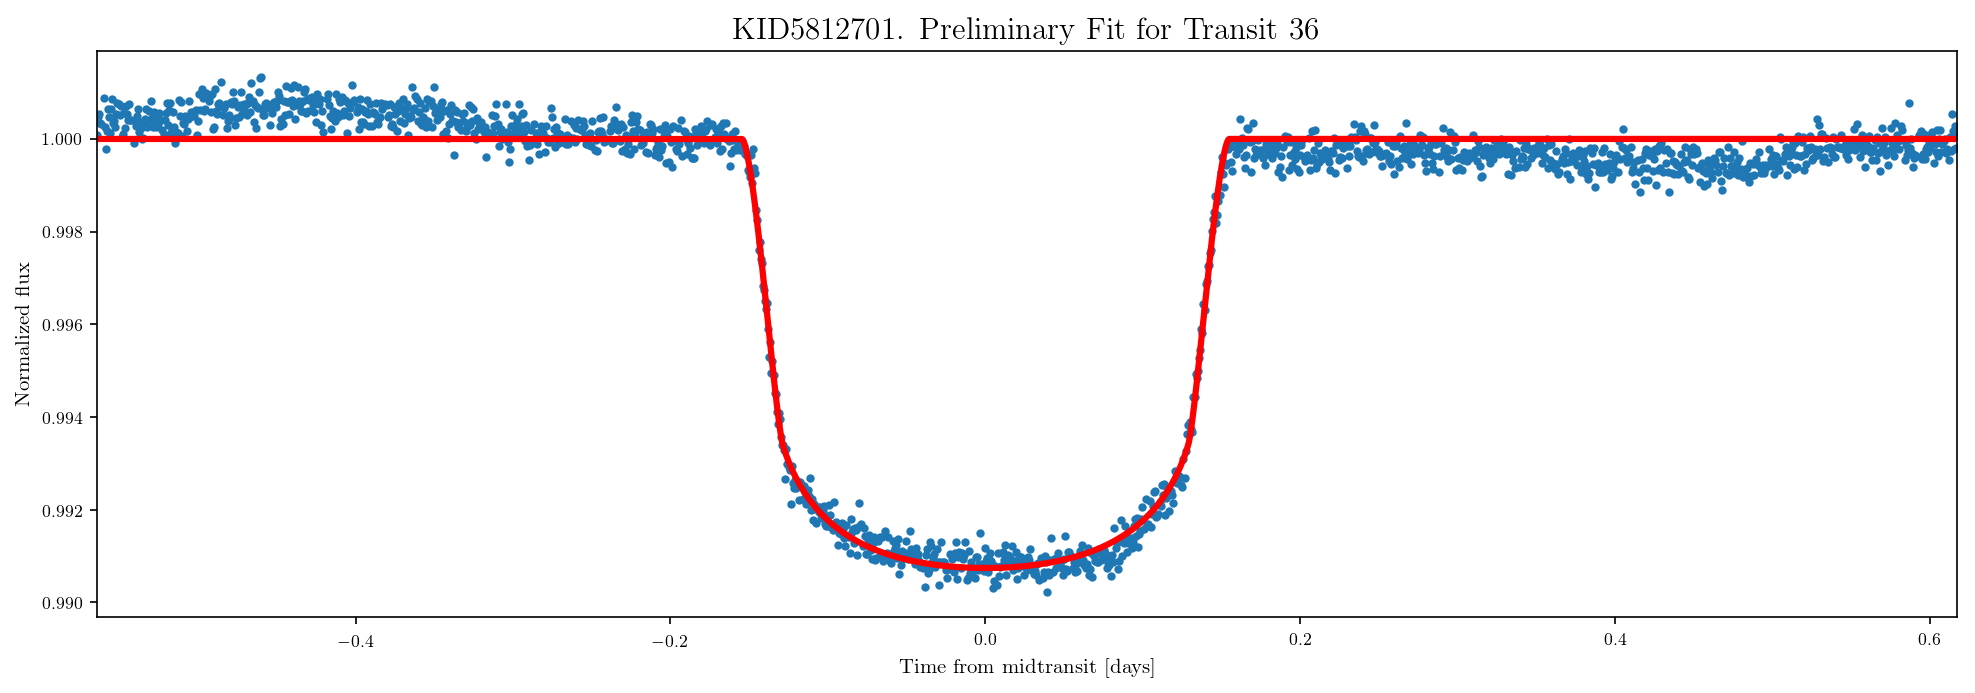

------ Pre-MCMC Results ------
	Transit duration [d]:	 Fit=0.309	True=0.309
	Period [days]:	 Fit=17.14217328	True=17.85522168
	Impact Parameter:	 Fit=0.116295	True=0.075000
	Depth:	 Fit=0.007921	True=0.009065
	Stellar mass:	 Fit=1.385	True=1.386
	Stellar radius:	 Fit=1.633	True=1.631
	Sigma (white noise):	 Fit=0.000
	Out-of-transit flux:	 Fit=1.000

------ Prepare MCMC -------
Guess impact parameter: 0.11629466858553258
Guess of Rp [in Rsun]:  0.1453063069912821
1+rp_guess/rs:  1.0890016441129076
Running burn-in


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
100%|██████████| 250/250 [01:00<00:00,  4.86it/s]



------ Run MCMC -------


100%|██████████| 1000/1000 [03:34<00:00,  4.88it/s]



------ Post-MCMC Results ------

Depth:
	True = 0.009
	MCMC Fit = 0.008 (+0.000,-0.000)

Impact parameter:
	True = 0.075
	MCMC Fit = 0.114 (+0.075,-0.074)

Planet radius [REarth]:
	True = 13.160
	MCMC Fit = 15.836 (+0.382,-0.362)

Period [d]:
	True = 17.855
	MCMC Fit = 17.322 (+1.698,-1.525)

Inverse of scaled semi-major axis:
	True = 0.0500
	MCMC Fit = 0.0523 (+0.0015,-0.0015)

Stellar radius [Rsun]:
	True = 1.631
	MCMC Fit = 1.631 (+0.040,-0.037)

Stellar Mass [Msun]:
	True = 1.386
	MCMC Fit = 1.387 (+0.073,-0.071)
Mean acceptance fraction: 0.35830000000000006
Acceptance fraction: 35.83 %

	*TRANSIT 37
		Signal = 0.00717. Noise (rms) = 0.00039. SNR = 18.51229
		Out-of-transit error of the transit LC = 0.00039
Max. depth (guess) = 1.09583
Depth guess = 0.00918. True depth = 0.00907


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in subtract


Optimization terminated successfully.
         Current function value: -12734.306456
         Iterations: 4623
         Function evaluations: 6681
Optimization terminated successfully.
         Current function value: -12730.321398
         Iterations: 1427
         Function evaluations: 2118


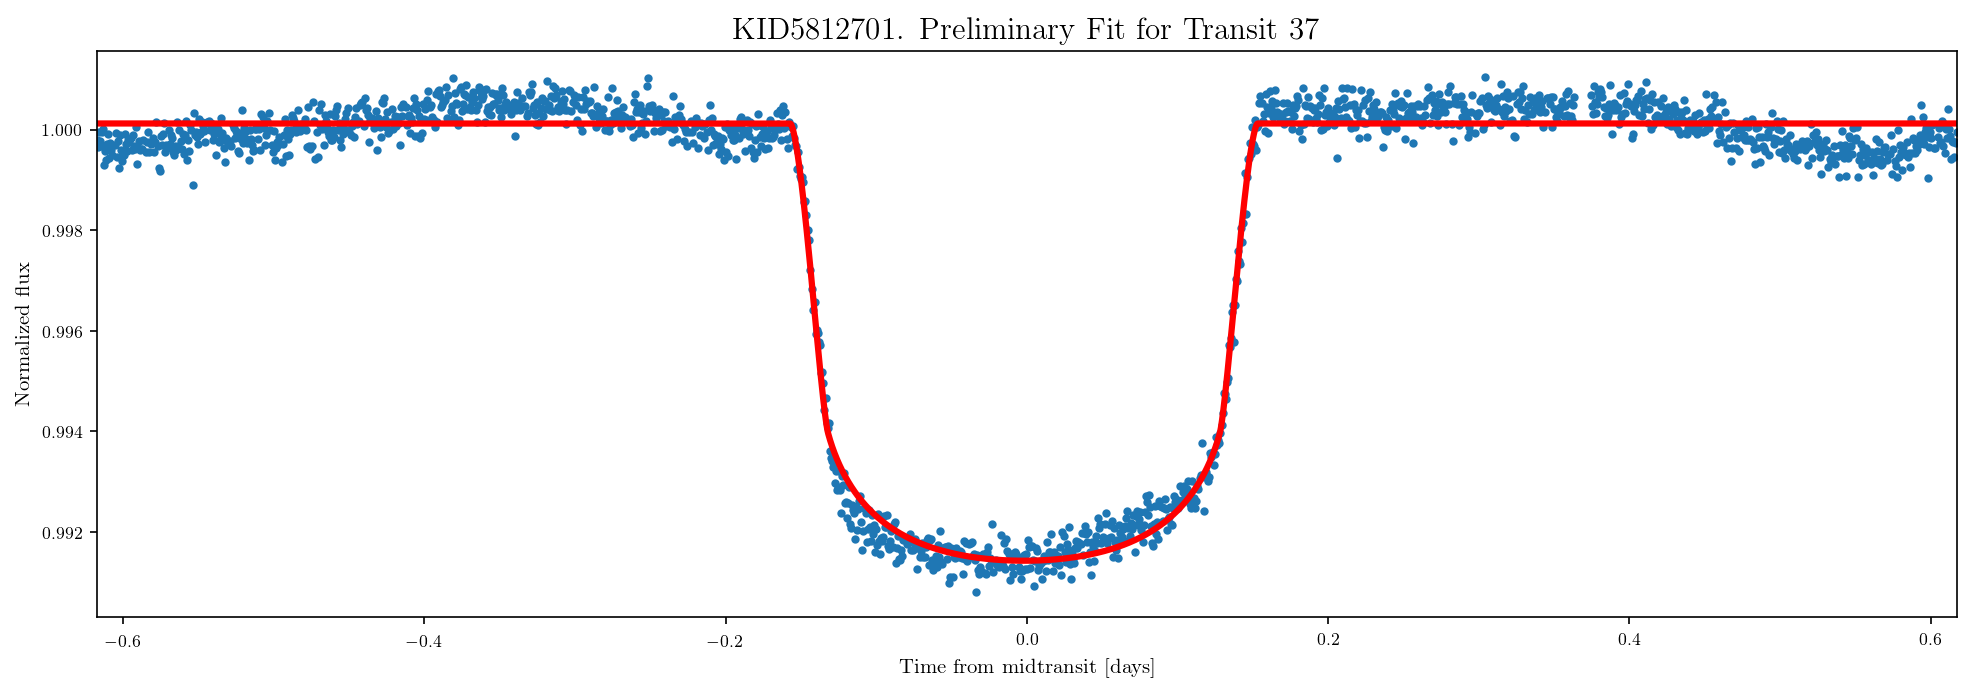

------ Pre-MCMC Results ------
	Transit duration [d]:	 Fit=0.310	True=0.309
	Period [days]:	 Fit=17.20958086	True=17.85522168
	Impact Parameter:	 Fit=0.080147	True=0.075000
	Depth:	 Fit=0.007433	True=0.009065
	Stellar mass:	 Fit=1.383	True=1.386
	Stellar radius:	 Fit=1.633	True=1.631
	Sigma (white noise):	 Fit=0.000
	Out-of-transit flux:	 Fit=1.000

------ Prepare MCMC -------
Guess impact parameter: 0.0801473028172286
Guess of Rp [in Rsun]:  0.1408091966712011
1+rp_guess/rs:  1.0862127008528994
Running burn-in


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
100%|██████████| 250/250 [00:59<00:00,  4.56it/s]



------ Run MCMC -------


 24%|██▍       | 238/1000 [00:58<02:39,  4.76it/s]

In [ ]:
for target in targets:
    print("\n******************************** KID"+str(target.kepid)+" ********************************")
    key = target.kepid
    missed_trans = set(target.ind_missed_transits)
    
    fit_results = []
    period_distributions = []
    MCMC_transits = []
        
    if target.kepid not in bad_lc:
        for i in range(len(target.transit_times)): 
            if i in missed_trans:
                fit_results.append(0)  
                period_distributions.append(0)
                MCMC_transits.append(0)
            else: 
                print("\n\t*TRANSIT "+str(i+1))
                dt_i = target.ttrans[target.trans_id==i]-target.transit_times[i]
                f_trans_i = target.ftrans[target.trans_id==i]

                oot = np.abs(dt_i)>=(target.duration/2)
                iit = np.abs(dt_i)<(target.duration/2)
                d = 1-np.mean(f_trans_i[iit])
                error_trans_oot = np.std(f_trans_i[oot])
                snr = d/error_trans_oot
                print("\t\tSignal = {0:0.5f}. Noise (rms) = {1:0.5f}. SNR = {2:0.5f}".format(d, error_trans_oot, snr))
                print("\t\tOut-of-transit error of the transit LC = {0:0.5f}".format(error_trans_oot))

                if snr > 3: 
                    lc_fit = run_transit_routine(target, dt_i, f_trans_i, error_trans_oot, i, True)
                    fit_results.append(lc_fit)

                    period_res, mcmc_res = run_mcmc(target, dt_i, f_trans_i, error_trans_oot, i, lc_fit, True)
                    period_distributions.append(period_res)
                    MCMC_transits.append(mcmc_res)

                    locs_P_trans = '/Users/mbadenas/Documents/Master UAB/Tesis UAB/TFM2018/results/period_distributions/'
                    locs_MCMC = '/Users/mbadenas/Documents/Master UAB/Tesis UAB/TFM2018/results/MCMC_results/'
                    fname_P_trans = str(target.kepid)+"_st"+str(steps)+"_Pdist_trans"+str(i+1)+".txt"
                    fname_MCMC = str(target.kepid)+"_st"+str(steps)+"_MCMCres_trans"+str(i+1)+".txt"
                    np.savetxt(locs_P_trans+fname_P_trans, np.transpose(period_res), fmt = "%0.15f")
                    np.savetxt(locs_MCMC+fname_MCMC, np.column_stack((id_mcmc, mcmc_res)), 
                                               header = header_mcmc, delimiter=" ", fmt="%s")

        target.res_transfit = fit_results
        target.P_distribution = period_distributions
        target.MCMC_transits = MCMC_transits

# Period Analysis

In [ ]:
def plot_periods(star):
    bin_num = 40
    
    fig = plt.figure(figsize=(18,16))
    ax=fig.add_subplot(211)
    for i in range(len(star.full_P_trans)):
        ax.hist(star.full_P_trans[i]['Period'], density = True, bins=30, histtype='step', label='Transit '+str(i+1));
    ax.set_title('KID'+str(star.kepid)+' - Transit Period distribution', fontsize = 20)
    plt.axvline(x = star.P, color = 'r', linewidth = 4, label = 'True Period' )
    ax.set_xlabel(r'$P$ [d]')
    ax.set_ylabel('Frequency')
    #ax.set_xlim([10,star.full_stats['min'][0]*4])Co
    #ax.set_yscale('log')
    if (len(star.transit_times) < 10): ax.legend(loc='best', fontsize = 12)

    ax=fig.add_subplot(212)
    ax.set_title('KID'+str(star.kepid)+' - Full Period Distribution', fontsize = 20)
    ax.hist(star.full_P['Period'], bins=bin_num*3, density = True, color='steelblue', alpha = 0.5) 
    ax.set_xlabel(r'$P$ [d]')
    ax.set_ylabel('Frequency')
    #ax.set_xlim([star.full_stats['min'][0]-5,star.P+20])
    #ax.set_yscale('log')
    plt.axvline(x = star.P, color = 'r', linewidth = 4, label = 'True Period')
    plt.axvline(x = star.full_stats['mode'][0], color = 'b', ls = 'dashed', lw = 3, label = 'Mode')
    plt.axvline(x = star.full_stats['mean'][0], color = 'k', ls = 'dashed', lw = 3, label = 'Mean')
    plt.axvline(x = star.full_stats['median'][0], color = 'r',  ls = 'dashed', lw = 3, label = 'Median')
    plt.axvline(x = star.full_stats['16%'][0], color = 'k', ls = ':', lw = 3, label = '16%')
    plt.axvline(x = star.full_stats['50%'][0], color = 'm', ls = ':', lw = 3, label = '50%')
    plt.axvline(x = star.full_stats['84%'][0], color = 'g', ls = ':', lw = 3, label = '84%')
    ax.legend(loc = 'best', fontsize = 12)
    plt.show()
    plt.tight_layout()
    plt.close(fig)

In [ ]:
def get_statistics(data):
    full_statistics = pd.DataFrame({'mean': data.mean(), 'median': data.median(),'mode': data.mode(),
                        'std': data.std(), 'min': data.min(), 'max': data.max(), 
                   '16%': data.quantile(0.16), '50%': data.quantile(0.5), '84%': data.quantile(0.84)})
    return full_statistics

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

def closest_statistic(df, P):
    cols = ['Mean', 'Median', 'Mode']
    stats = [df['mean'], df['median'],df['mode']]
    res = find_nearest(stats, P)
    idx_res = np.where(stats == res)[0][0]
    return cols[idx_res]

def show_best_stats(star):
    fig = plt.figure(figsize=(18,8))
    ax=fig.add_subplot(111)
    ax.hist(star.best_stats, density = False)
    ax.set_ylabel('Frequency')
    ax.set_xlabel('Statistical Parameter', fontsize = 15)
    ax.set_title('Best Statistics Measure from Individual Transits', fontsize = 20)
    plt.show()
    plt.tight_layout()
    plt.close(fig)

In [ ]:
keylist = set(list(ugly_stars.keys()))
bad_transits = list(ugly_stars.values())

print(keylist)
#print(bad_transits)
print(ugly_stars)

In [ ]:
path = '/Users/mbadenas/Documents/Master UAB/Tesis UAB/TFM2018/results/period_distributions/'
plt.close('all')
count = 0

for target in targets:
    period_distribution = []
    P_trans_stats = []
    best_statistics = []
    search_files = glob.glob(path+str(target.kepid)+"*.txt") #afegir nº steps (per si de cas)
    if len(search_files) != 0:
        for i in range(len(search_files)):
            filename = search_files[i]
            Ptrans = pd.read_csv(filename, sep = " ", names=['Period'], index_col=None)
            period_distribution.append(Ptrans)
            trans_stats = get_statistics(Ptrans['Period']).iloc[0]
            P_trans_stats.append(trans_stats)
            best_statistics.append(closest_statistic(trans_stats, target.P))
    
        target.full_P_trans = period_distribution
        target.full_P = pd.concat(period_distribution)
        target.best_stats = best_statistics

        #Calculate statistical properties 
        target.full_P_trans_stats = P_trans_stats
        target.full_stats = get_statistics(target.full_P['Period'])
        
        plot_periods(target)
        show_best_stats(target)
        count += 1

In [ ]:
print(count)

# Old